In [1]:
%matplotlib inline
import os
import yt
yt.mylog.setLevel("WARNING")
import numpy as np
import matplotlib
matplotlib.rcParams['font.family'] = 'stixgeneral'
matplotlib.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt

In [2]:
from yt_conduction_fields import *

In [ ]:
from yt.fields.derived_field import ValidateSpatial
from yt.funcs import just_one

@yt.derived_field('xray_cooling_time', sampling_type='cell', units='Myr')
def _xray_cooling_time(field, data):
    xray_emis = ('gas', 'xray_emissivity_0.1_100_keV')
    if xray_emis not in data.ds.derived_field_list:
        xray_fields = yt.add_xray_emissivity_field(data.ds, 0.1, 100, table_type='apec', metallicity=0.5)
    gamma = 5./3.
    thermal_energy = 1./(gamma-1)*data['pressure']
    return thermal_energy/data[xray_emis]

@yt.derived_field('total_heating_rate_density', sampling_type='cell', units='erg/s/cm**3')
def _total_heating_rate_density(field, data):
    xray_emis = ('gas', 'xray_emissivity_0.1_100_keV')
    if xray_emis not in data.ds.derived_field_list:
        xray_fields = yt.add_xray_emissivity_field(data.ds, 0.1, 100, table_type='apec', metallicity=0.5)
    return - data['spitzer_heat_flux_divergence'] - data[xray_emis]

@yt.derived_field('spitzer_conduction_coefficient', sampling_type='cell', units='cm**2/s')
def _spitzer_conduction_coefficient(field, data):
    T1 = data['temperature'].to_equivalent('keV', 'thermal')/10/yt.units.keV
    n = data['H_nuclei_density']/1E-3/yt.units.cm**(-3)
    return 4E32*T1**2.5/n*yt.units.cm**2*yt.units.s**(-1)

def _spitzer_heat_flux(ax):
    def func(field, data):
        return -data['spitzer_conduction_coefficient']*yt.physical_constants.kb*data['H_nuclei_density']*data['temperature_gradient_%s' % ax]
    return func

for ax in 'xyz':
    f = _spitzer_heat_flux(ax)
    yt.add_field('spitzer_heat_flux_%s' % ax, function=f, sampling_type='cell', units='erg/s/cm**2')
    

basename = 'spitzer_heat_flux'
xn = basename + '_x'
yn = basename + '_y'
zn = basename + '_z'

sl_left = slice(None, -2, None)
sl_right = slice(2, None, None)

div_fac = 2


def _divergence(field, data):
    ds = div_fac * just_one(data["index", "dx"])
    f  = data[xn][sl_right,1:-1,1:-1]/ds
    f -= data[xn][sl_left ,1:-1,1:-1]/ds
    ds = div_fac * just_one(data["index", "dy"])
    f += data[yn][1:-1,sl_right,1:-1]/ds
    f -= data[yn][1:-1,sl_left ,1:-1]/ds
    ds = div_fac * just_one(data["index", "dz"])
    f += data[zn][1:-1,1:-1,sl_right]/ds
    f -= data[zn][1:-1,1:-1,sl_left ]/ds
    new_field = data.ds.arr(np.zeros(data[xn].shape, dtype=np.float64),
                            f.units)        
    new_field[1:-1,1:-1,1:-1] = f
    return new_field


yt.add_field(('gas', "%s_divergence" % basename), sampling_type="cell", 
                   function=_divergence,
                   units='erg/s/cm**3',
                   validators=[ValidateSpatial(2)])

def _spitzer_heating_rate(field, data):
    return -data[('gas', 'spitzer_heat_flux_divergence')]*data[('gas', 'cell_volume')]

yt.add_field(('gas', 'spitzer_heating_rate'), sampling_type="cell", 
                   function=_spitzer_heating_rate,
                   units='erg/s')

def _total_heating_rate(field, data):
    return -data[('gas', 'total_heating_rate_density')]*data[('gas', 'cell_volume')]

yt.add_field(('gas', 'total_heating_rate'), sampling_type="cell", 
                   function=_total_heating_rate,
                   units='erg/s')

def _total_cooling_time(field, data):
    gamma = 5./3.
    thermal_energy = 1./(gamma-1)*data['pressure']
    return thermal_energy/(-data['total_heating_rate'])

yt.add_field(('gas', 'total_cooling_time'), sampling_type="cell", 
                   function=_total_cooling_time,
                   units='Myr')

In [3]:
ds = yt.load('/home/ychen/data/0only_1022_h1_10Myr/data/MHD_Jet_10Myr_hdf5_plt_cnt_1700')
sp = ds.sphere([0,0,0], (180, 'kpc'))

ds.derived_field_list

[('all', 'mesh_id'),
 ('all', 'particle_blk'),
 ('all', 'particle_cylindrical_velocity_theta'),
 ('all', 'particle_cylindrical_velocity_z'),
 ('all', 'particle_den0'),
 ('all', 'particle_dens'),
 ('all', 'particle_gamc'),
 ('all', 'particle_index'),
 ('all', 'particle_jet'),
 ('all', 'particle_magx'),
 ('all', 'particle_magy'),
 ('all', 'particle_magz'),
 ('all', 'particle_ones'),
 ('all', 'particle_position'),
 ('all', 'particle_position_cylindrical_radius'),
 ('all', 'particle_position_cylindrical_theta'),
 ('all', 'particle_position_cylindrical_z'),
 ('all', 'particle_position_relative'),
 ('all', 'particle_position_relative_x'),
 ('all', 'particle_position_relative_y'),
 ('all', 'particle_position_relative_z'),
 ('all', 'particle_position_spherical_phi'),
 ('all', 'particle_position_spherical_radius'),
 ('all', 'particle_position_spherical_theta'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_position_z'),
 ('all', 'particle_posx'),
 ('all', 


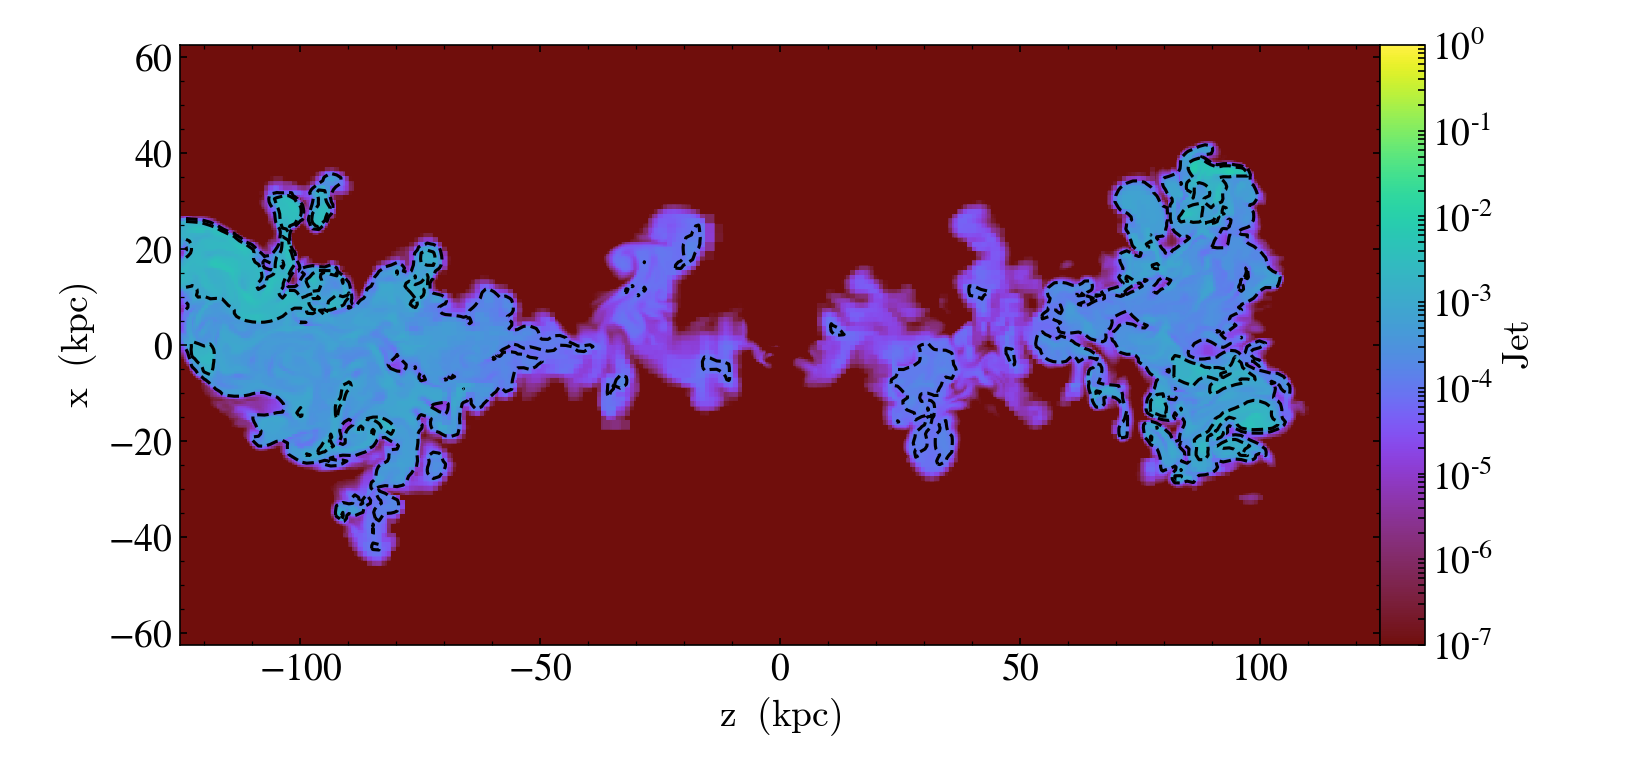

In [4]:
plot = yt.SlicePlot(ds, 'y', 'jet ')
plot.zoom(4)
plot.set_zlim('jet ', 1E-7, 1)
plot.annotate_contour('jet ', ncont=2, clim=(1E-4, 1E-3), take_log=True)
plot.show()


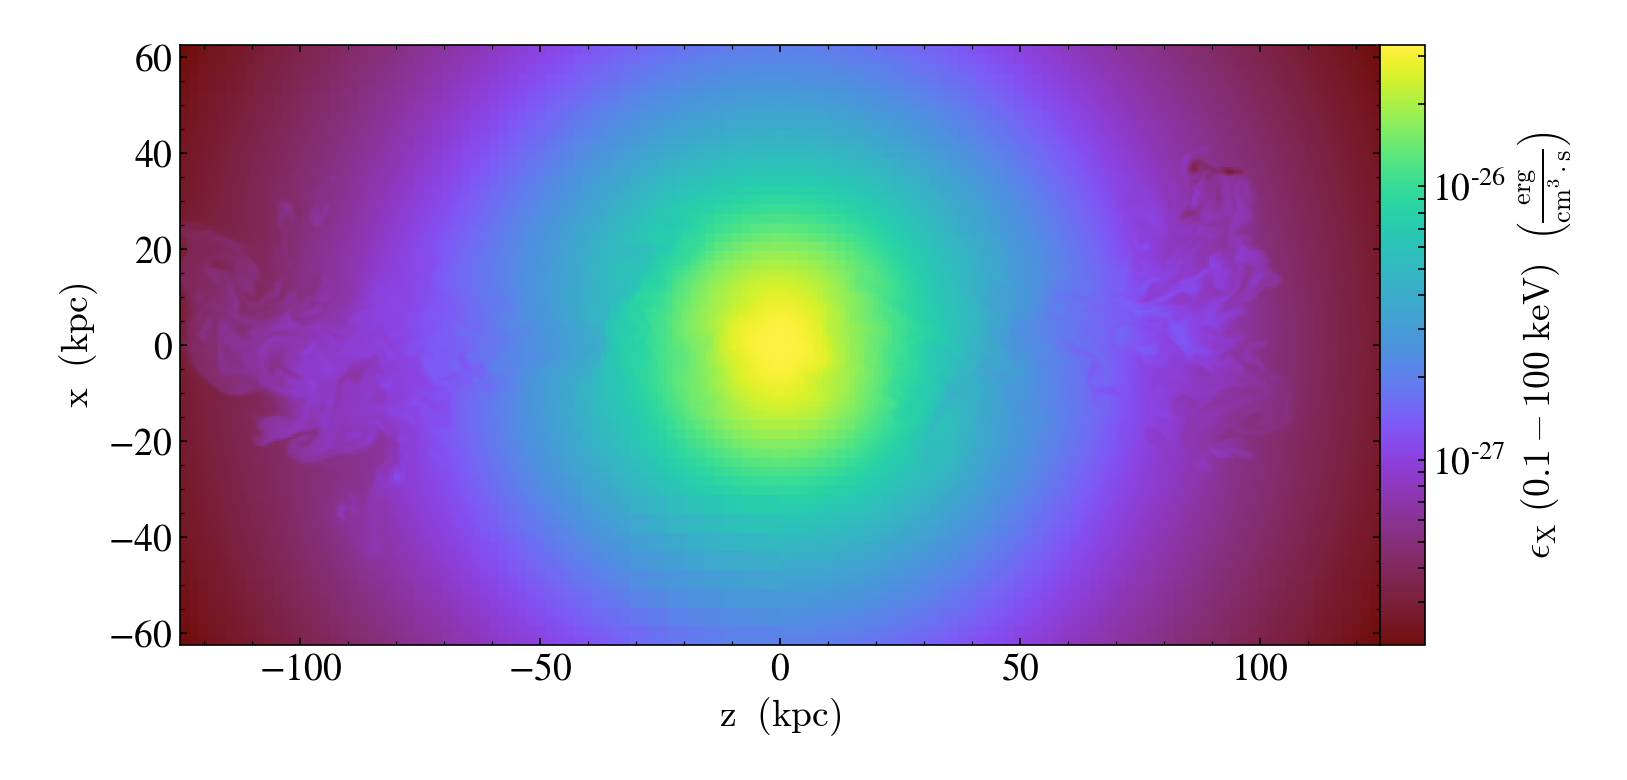

In [10]:
plot = yt.SlicePlot(ds, 'y', 'xray_emissivity_0.1_100_keV')
plot.zoom(4)
plot.show()data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABlsAAAMMCAYAAADU4BEIAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAXEQAAFxEByibzPwAAIABJREFUeJzs3Xu4ZFV95//P2rv69Gku3SLtDxSBDBIQb6AIjQoqiDqjGH/E4KOOQhJEMeIVEzOB3/jEYFBmUEcTESOoMcH4MM4FRp0HxImjo+INFYjNoBhEw0Whabob+lK11++Pqr3Pvqy917dO1bl1v1/Pc+D0Od9a67t37apTtb+119d5770AAAAAAAAAAAAwL8lSJwAAAAAAAAAAALCSUWwBAAAAAAAAAACYAMUWAAAAAAAAAACACVBsAQAAAAAAAAAAmADFFgAAAAAAAAAAgAlQbAEAAAAAAAAAAJgAxRYAAAAAAAAAAIAJUGwBAAAAAAAAAACYAMUWAAAAAAAAAACACVBsAQAAAAAAAAAAmADFFgAAAAAAAAAAgAlQbAEAAAAAAAAAAJgAxRYAAAAAAAAAAIAJUGwBAAAAAAAAAACYAMUWAAAAAAAAAACACVBsAQAAAAAAAAAAmADFFgAAAAAAAAAAgAlQbAEAAAAAAAAAAJgAxRYAAAAAAAAAAIAJUGwBAAAAAAAAAACYAMUWAAAAAAAAAACACVBsAQAAAAAAAAAAmADFFgAAAAAAAAAAgAlQbAEAAAAAAAAAAJgAxRYAAAAAAAAAAIAJUGwBAAAAAAAAAACYAMUWAAAAAAAAAACACVBsAQAAAAAAAAAAmADFFgAAAAAAAAAAgAlQbAEAAAAAAAAAAJgAxRYAAAAAAAAAAIAJUGwBAAAAAAAAAACYAMUWAAAAAAAAAACACVBsAQAAAAAAAAAAmADFFgAAAAAAAAAAgAlQbAEAAAAAAAAAAJgAxRYAAAAAAAAAAIAJUGwBAAAAAAAAAACYAMUWAAAAAAAAAACACVBsAQAAAAAAAAAAmADFFgAAAAAAAAAAgAlQbAEAAAAAAAAAAJgAxRYAAAAAAAAAAIAJ9JY6Aew+7rvvPn3zm9/UTTfdpNtuu02//du/rb/4i79ojffe6wc/+IG++93v6sEHH9TjHvc4HX/88XriE584r/kPPPBAbdu2TYcccsh8NwEAAAAAAABYMLfddpsk6cgjj1ziTMbzhCc8Qddcc81SpwEsaxRbMJEHH3xQV155pa666ir94Ac/0DOe8Qy94Q1v0B/8wR/ot37rt1pvd9111+kd73iHfvKTn+ikk07S4x//eH3yk5/Uz372M734xS/W5ZdfrkMPPXSsXLZt26ZHtm7VPRs3RiJddCwXCMu8tN1nmnWJklDABPPJWceyjecCMZm8Hsn6WpP0lFhzd840n3GwiWI27XpYkvTomb2mMt54MZZhusfx3uvhwQ7tlc7KRWJD918oajoxtlgvr4f7j2iv3ho513VR5HTyclMcS3LKlOnh/lbt1dtHSfCizsV/nI4T432mbf2HtHdvbWD/G8cZK/94Tt0h1ZjfPHynJGn9Xs3ndT/1fd81jnW+6j+9H+jhHZu01+r95Fxqns5P+ZDx8xwnyzJt3/GAZlc/WkmSzHuceec04XzeD7T9kQc0u+bRci415j+1zEy6ZvN+oB2PbNLqNYbjZ1oP0yna8sDPJUn7PvpfLXEmNca7OLb/l2SXG54c8oj68d8cazopjbUfOuasj1N//rGOM1Zexn0wn6eF4PO/KW8/Vm6GROxzlgT//hrGmlrixVzzm7P5+mdauRtiJtpPw59n8sPXn+neShqv36z7OLBf5nm7cWO8z/Rw/2Ht1dsr8v5k/ttiiZn3HvBeDw+2a690den1c+C2jR/N9/jvPh7Gua33c+9/91u1V+gG8xrXzvxHtvVXw/MPA61J0sb5Bz+1x6kxbqz9MHr8ls//REcbfz8PskwzM07K7hz7tkvlp3c8vNQpACsCxRbMS5Zl+uhHP6r3vOc92rx5s4466ih95Stf0SmnnBK97Yc//GGdf/75mpmZ0XXXXadTTz1VktTv93XBBRfokksu0XHHHacvf/nLOvbYY805HXLIIbpn40aduU/bi5Ehl8xEx3IukWpvaDcPBrpi82/0mrX7aV2ayrk0ctI5n2/VVGLyfFzX6n95TCCvB/s79PF7f6KzHnOEHtVbbcvLrZIi2+hcGo0pxpog5rJffE2S9KZDTh4Ft5+wKvZR10mtUc5O8ROnptwj+3PTzi360E8/r3MPO0P7zaydfD5TTPxYn7vvuvfnpp2bdMlPPqQ3H/Em7bd6v445Z+NTKu2+b0ZzxmKk1HT/yc3ogR2/1sU3v0NvPeq9evTqxzRDiv3Zdcyk8ZhiPMu+t8c8sP1uve+mM/T2p/6NHj372EBekcegSyXDc58f47nIdz3uazGXfnv4PH/+CV9pzpnGX4pkppj4/eKTRD6JFBYT14jZtO1OffjLT9MbXvBV7bf38ITVoBd/3hv04qcJ/WiYzLCw68Dwqi00zuYtd+qTn3uy/u3pX9O6fQ/VoBd/Q+gTKTOcmbTk7RPLOL6Yt27L5jt11SeO1u++7qvad92hRWzneIbcx8krOlbHfFsf/IW+8NFjddrZ12mfR3VffWudb5pi++Hav3quJOll5/3vzjiXLW7ZIjHOF9v/boyqqGVOy35IDHPmc9WP/+pcU8wps+fmsq5xXCWm/vwTmrNL2o/HJFl3TsMYH40ZzlcNCj3/u8xX/h8yFxOfNBkMDDHxHeECMfW/v85nku+ezxIjSS7bFY1RtnP4/87xstaYxusfvzM+ZyOmOa5vzBXIzxJT+5n3WeXnw9ef79Jbn/j/6dGr11djg+MF5gnsF6/MEGPZxuo49dts2rFJl/zkP+rNR7xR+83sF547mHMWzmHe2xKPUSCvTTsf0gdv/3u98V+drv1m9m2NaxwPPhDTso2NmMDP6/kG92E9xmel97/PG/20dn+F9kPkPg3GGMZpHS+0H0Y/e7C/Qx+/5xad9Zjf1qN6q4Mxcz+Y57HR8nxlGT8Yp7n9UZz/2Xet1tXeZ5jyjzyPfvShrTr8sL10y3ee3Rm3nDzl+G8udQrAikDPFoxt06ZNevGLX6y3v/3t2rx5s84991z98Ic/NBVaPv/5z+sd73iHsizTpZdeWhRaJKnX6+kDH/iAXvrSl+rXv/61Tj/9dN1///0LuSkAAAAAAAAAAEyMYgvGcs899+jEE0/UV74y/HTU+973Pl122WWamYl/Yvqee+7RueeeK0k6+OCDdc455wTjLrroIknSXXfdpfPOO29KmQMAAAAAAADLgVfmd62Yr+mtjQns3ii2wGzz5s069dRT9U//9E+SpDe/+c36sz/7M/PtL774Yj344IOSpFe96lVatSq8XM0xxxyjpz3taZKGV8LccsstE2Y+Haud0wmze2v11PoeLK7ZJNVz9j1As4m93wCmZzad0cmPeaZm09Xx4GVoNp3VCw44RbNpfJmw5WhNupde+NjTtSbtXmZwuVrT20cvevwfaE1vn6VOZY80u2qdnn/Un2p21bqlTmVeVs+s07Oe8e+0emZl5j+zep2Offa7NbN6heY/u05HP/ePNTO7MvNf6Vb6/l/px/9Kf/5Z6c//K91Kf/0zfP35/67Y15/D1//PX7Gv/2fT1Xr++mdoNjUs3YupG55/eOyKPf+w0s//AFg69GyB2Wte8xrdeuutkqSjjz5a/+k//SfzbR9++GFdeeWVxb9PO+20zviXvexl+vGPfyzvvS699FJ96lOfml/SUzSbJHr2Xivzhb4kzSY9nbT2sfFALIg16Wqd8v8cp5Va416TrtGpj33BUqcxb2t6e+tFB71iqdOYtzW9ffXig89e6jT2WGtmHqWTn/zvljqNeZtd/Sg9+5kXLHUa87Z69lF65nNW7v6fmV2nY573J0udxh5rpe//lX78r/Tnn5X+/L/Szev1T73nX+CD2PVzp8Ee3/Xzq60f6J7ry5D3zczHW9Nbqxcd9HsK9Uupt/qa64VRzn9Q3Z5RD4h6D89Qq6Xm+AG129Vvs1dvH5362BdW+lHkc1f7aaSqbGPeG7OegyXPecY0NzDTmnS1XnDAhrkQP1D1vZihkdO4yj0N874etWMy1Oatvk1Oc8dp/bgqYgL7oT5061ylniMu77Xoa/dhS98Wq9mkp5PWPc7UAyrEKakeZ/l+9NXH3Lwfvn5Q6XWb92HJ98eaNG2e/8kfg7XelaYcgn1ppIEMzcmWCa/mdgFoWpln/bDoLr/8cn3pS1+SJDnn9LGPfUypoRlx7vrrr9fWrVuL28ca3x933HHF99dcc436/ZXzBwgAAAAAAAAAsGfhyhZEbd68WRdcMPeJtJNPPlnPfvazxxrjxhtvLL4/7LDDtPfee3fGH3300cX3DzzwgL7xjW/o+c9//lhzYvfypkOet9QpAJin80/4ylKnAGCeXnbe/17qFADME39/gZXrTYecvNQpAADmgWILoi6//HLdf//9xb/zJvfj+M53vlN8f+ihh0bjDz74YCVJoiwbXsp50003UWwBAAAAAADAbsArW0HLiHWspwighGILoq644ori+zRN9W/+zb/RzTffrM9+9rO68cYb9eCDD2r//ffX05/+dL361a/WM5/5zMYYN998c/H9gQceGJ0zTVOtX79e9913nyQVvWIsXH2d3mBMZAU9l5rGaawJPN8YQ2yxNu/U8jKsImiJMXCaYlO80bbV1yoOxUxtG037YUqrMlqPl7GOq67c7PtzavejS7vnK+aczrEefbxLtrnyfbWYzw2m+zmJx7lUfkrzeRd/LspjfNe+Twwx+XjJtGKcfNK90rBPnAY9y1jREFNMlsRj85jMMN6gF38T5BMpCy3i3TJv+zheWWKbLz6XIZ9Rzt4Sa8nLtA9sbyotOVlY7pdpm1bubpEbyMYey2Uu64qNb38yuv0gjcc6Q16+M5+hzDklwcYE5cRsS+q7zHAf94cP1KxjfySjuZKObRyMjidnWeq/b7gPe3PztskUfxU2SJzSvuUxH89pvFd8hr8nwYYhtRjLH4C0J2XxHR/bQuua/N5wJxevmbpeX2Q7bYlJMr1eazStyH9e7pdQ7TES7FnR6EPS7BfRls98esIEe2tIhhwWQaRvzLCvRq3XjNToX1J+L+EDfWwmzrGyX/K5q71JfCCmcX+Fhjf2lvGB3jWT9j5ZEIHeMuX3ON4PwjH1+zD0Or6+vW29Vnx3P5bloHHMLNM8ASwvFFvQ6Z/+6Z/0f//v/y3+ffjhh+ttb3ubPvWpTzXeGPyv//W/9KEPfUh/+Id/qMsuu0yrVq0qfvfAAw8U369fv940d7nY8vOf/3ySzaiwnXhdvHGGg03nJPY4OVlPnEdPLLvENNZUimCKFAXGME7hwHRy3RRnOCkuTe14sBSJxiviWcYz3M+m+zA13kdTihlrny9iXpZ95VIpmTHEGU74mAofq+Ix+TgdBZCiIGMokmSGHmHWQorlRJqlODDoGU6WLlEhJaZvOGE8zUJKP42fZJh2AcWWu63IMK0CiGU+SwFoufKG48rKxYoMkgaGIklRZDHk1lXYmCsgGE7EG86pDVIf38bEm4syMT3D35JBz/A4HeVjOJ+vnuHMuakQq/jzY5LFz2W6TJLhedsk/xByx9+TJMuPmfZjL/9dZnntZNnpWfxPvemcr0ukbFc8zPSBJcNrnfw1TF506WR57dRyErRRMGgWBxonm0MFhEUXKmJUt6VZ+AjFNPedpeDhlNYKCIET5/VG5sVc7Q3X83wajeEtzeODhanlUdAIFpTqRQtT8WoRBYpCzSJDIKZ+bBS3rTWP9y3HZKA5/byO7dA4FrUCXT7OWGNMyMtrsAyvbHnmhluCP7/jjh06/PBFTgZYgSi2oNM3vvGNyr9vu+02HXnkkfrHf/xHPeMZz5BzTrfeeqs++tGP6u/+7u/kvdcVV1yhTZs26Qtf+IIkaevWrZUG96tXrzbNPTs7W3z/0EMPmW6zOcv0mS1bgr87a999TWMAAAAAAAAAk2g7P8W1McDui2ILOtWX7zr33HN12WWXVX52/PHH67Of/aye+MQn6sILL5Qk/Zf/8l/02c9+Vq973esahZL5FFu2tPyBAgAAAAAAAFaawTIsu9x441HBn2/Y8JNFzgRYmSi2oNNdd91VfJ+mqS666KLW2D/7sz/T5z//+aI/yyWXXKLXve51jTW8rWt6p6VlYzLLpfOS1iUJV7AAAAAAAABgSeXnp3ytz8tHH9q6FOkAWAQUW9CpfEXJE5/4RO2///6tsc45vf71r9fb3vY2SdItt9yi22+/XQcccEAlbseOHaa5t2/fXny/zz77jJM2AAAAAGBPU+8TY2hOH4ppbXJvuG1srMp4bTkp0JQ9OHj4NpW+H43m8bnavgp9JrKtsb2lt4Zh/OY2BnqA1HvCtPWNCeZfG8twXwRj6jm19ZYJ9aXp6F0zzrY0Dj3LcdsMad/n9d4yS63eU2V0jHUd20XflfpQgeF9W/+cWg+YZi8ndfaNKX5syAHA7mmKHb6xO0pKjYv322+/aPwLX/jCyr+/973vaZ999lGvN1fXsxZbynHr1q0z3QYAAAAAAABYzry8BspWzJe3VJcBUGxBt31LS3Lt3LkzGn/44YdXlv+69957lSSJDjnkkOJnmzZtMs1djjvssMNMtwEAAAAAAAAAYLGxjBg6Pf7xjy++f/jhh6Pxq1at0rp16/TAAw9IkrZt2yZpWIS54447JEl33313dBzvve65557i30ccccRYeQMAAAAAAADL1UDLYMk2AFPFlS3o9JSnPKX4/pe//KXpNnvttVfxfb781wknnDDWOPfee6927dpV/Pv44483zQ0AAAAAAAAAwGLjyhZ0Oumkk4rvH3zwQf3mN7/R+vXrO29Tbmx/8MEHS5JOPvlkvfe975Uk3X777dqxY4dWr17dOsaPfvSj4vu9995bz3nOc4wZu2ZTxEZI5PeSnEuDTc7q40RjJFuMpe45yrtzvDwmMTy0Tbmn0TineMyQfRsnjxnO5epNGUMxblV8PEPupnFcGr+vXWoay5b36HjomjM/Ziz7SjPTycsZxlFquK9t+8o0nyGmaPJpiTXFGHJP4uP4ZMb0GPRJfD5TTDp8fvEdc/pRvy+fxPPK0vhjOuvFxxkYYrKeU5bE21MODE+hlphslJLvSC1LfDQm10/j6yQPevFPx1nmyhKvLNT9dT7zGcaZ2w+GWMN4lnHGyWvScaw5WVi2fyVLgh2O58dl8bHcGPMlUxrPkpdlP7jMmXKyPE7TfvyJIc/JMqfvx2P6aTymN7Dsh3hOw5joUKa/Eaklpu9H88Yfr2nf8qnm+N/nZBBqgF7lskwu657PLXZjbJ+/x+l4PZA3pbakZuqMbY0pN94eNTufz/gBjUbmwU7mtX+GmrJLKudZvLavN0E3NaefZw6mPI3HVeg48IPK+5lirHqTckNM9X3dMCbYAH2+Ak3my++zvAa29+GW/Ry43fA4mtvXc8dt+RhJitzK+XlVY0wPnfnmWR8nFNPWwD50P09DPpcvP+6TYR7Fv0P7M63cZhxeUn8F9UFZOZkCS4srW9DpyCOPrCzh9c1vfrMzfteuXZVeKxs2bJAknXjiiTrggAMkSf1+v1JMCfnud79bfP+Sl7xEMzOWE6EAAAAAAAAAACw+ii2IOuecc4rvv/zlL3fG/uQnP9Fg9Kmqk046SQceeKAkqdfr6cwzzyzivvjFL3aOc+211xbfn3vuuWPnDAAAAAAAAADAYqHYgqhzzjlH+++/vyTp7//+7/XQQw+1xn7pS18qvn/Xu95V+d3b3/52rV27VpJ01VVXFUWZuo0bNxZXtmzYsEGnnHLKRPkDAAAAAAAAy8lAfsV8AbCh2IKodevW6WMf+5gkacuWLXr3u98djHv44YeLuFe+8pX6nd/5ncrvH/e4x+niiy+WJP30pz/VZz7zmeA4F154obz3mpmZ0RVXXDGtzQAAAAAA7M5cWv1S4KvRFyT/XW2cwG2HvT3nvlrHj+XQGDcJ9OYM5FTL3bWNWcvBKWl8NWOaX80ckkbPkUbvx2CeSUueSeUrmIN1W2rzNfpWNu73RPVTYsP7NGl8Ne73Wt6h3NtiFl4597ntmjtmVc0rj6nc78tQ23FVf7y5ucdT8biyxNTnKfXMrcc092fayK9xu8bzAoDdFcUWmLzyla/UBRdcIEn6+Mc/rgsuuEA7d+4sfr99+3adddZZuuuuu3Tqqae2FlL+6I/+qBjnLW95i2644Ybid1mW6c///M/1hS98QWvWrNHVV1+tJz/5yQu4VQAAAACAPU7wpGe5ELA0gid/l1xgvwRO1i+50AnvckFmmVj2RY3cYt7HoULKcjq2JtS2LV7SYAV9cW0LYNNb6gSwclx00UU6+uij9Z73vEd/+Zd/qU9/+tN69rOfrZmZGX31q1/Vjh079IEPfEDnn3++0rT9hcNFF12kI444Qn/6p3+qU089Vc997nN1yCGH6Hvf+542btyoY489VpdddpmOO+64Rdw6AAAAAAAAAADmh2ILxnLGGWfojDPO0I033qiNGzfq7rvv1tq1a3XWWWfp5JNP1qpVq0zjnHnmmXrNa16jr3/96/rxj3+srVu36sQTT9SGDRt0zDHHLPBWAAAAAAAAAEunL7fUKQCYMootmJcNGzZow4YNE43R6/V08skn6+STT55SVgAAAAAAAAAALD6KLUBA0UQtGjilGENspbHaYpnSOqlu1IAuGjfOWrod4xXr31pipily34SaNwZjppWO4seMZV+NtW618fiM7n8XXy97eExZ5ptSTLkBojV2UWKm93zlDY/TPMYn7bH577xr/6RWEZPEP8016BnySpx8JCwzxSgak8fFDHrxlY3zuTLXHpvP5RP7eF36aWYYxyuzzNeRd27Qi8/Xtf3lnKxzTit3yz635G4dyzSOcb7lyvnux/xgiiuCu47noFwSyaes6zmtmNMwXmIYx3snl0XiUm96Dk378ScGy+PUj/LJOvIv9qfhXWbaj8f0JSWR1JLEKYsdN4mkvuG+MT23j2I78hr0XDTGZXms4TVyZnguUiqXRXdWdBxlMr0HcKbXHvHjKte1hcU9Z5mzPlB+Yz8o/TDVsANBRHm+4vblHAaV/eC9YcyxVecL5VV+Xe0t27UAgjk08kxKMfZjY6qC92n5eF+qvEo5+CyYZ/194tTu63xuP7ftTml1/FFM/Vk09Litv0wJ/Vl0krxfon09Zc6l1cd+ft8tyPMBgJWAYgt2K062RmqmNweLaUr5uOJFUHw86z6InxRPFnd/WgpAU94PtjeTthhLMcVWCJriifppjmfg1GyA2GQp0BmP4akVRceJsRynluJHGj/mXTpWkaQzJo2/LJgrknQUW0Yn4roLMqOTdsZCSkx+Yqt7nHiRxCdS3/DqaCkKKZY5p1VIsRY0THlbchqjgLKYRRJrgcSU05SLJNMq3iwml7mp7QdLUcOnhvtljGLLtIo33jlD/t5clJmGvLCTdBR4iufPjmPPUpCZE3/+T/vSIFYkz6TYn4nEO9NzaPNUYlNvVCTqembLU866xhsFWYpOlr+VST9TdJ9mma3gYjhNYDpRmoyWmO446Wg5UvJ7zvSarm2uxsnrcrP3tkljJ1CrRZs8P99W8GmMH1IeL6nt57QRI5dWcsrfRzSGD53wtpwU9/WT+qEcksaJ+mEOXXkmk+dZG69SwAncX5YYKVHo6at+nwZjJMN+sOyrakzryfvA46FRDCnyLs1ZLw4skfJ7veI4rxfoQjGLqX7c5h86m1IuXqay77Kx8l55Aktjeh+hBgAAAAAAAAAA2ANxZQsAAAAAAAAALBIvqW+6vm954MoWwIZiCwAAAAAAQEWgX8oiz7nkyyippR/LchDsv7LE6r1Xlo1l0JdmWhaoF9C0lwgDsOei2AIAAAAAAFa+eh+LYAdvtcS09xgpiiCGDuH1fh6NHi75OKHxG/1RQv0iAmPVf1TvcxJIYbICUq0QFSgyNIo0oR4jjTznn1PwpLvlxPwCF22a+8Gyrxa2aFPuf1T0b6nNGSyyLWYxydIvpa0XUO0xYWqbNBqnUeAMHB/1mPD+tB1Xfbo7ALsdHtUAAAAAAAAAAAAT4MoW7FYySZsHc58aWO2cZhNqigAAAAAAAFga27NMO0aXptH/BNh9UWzBbmW7z3TFQ5uKf58wu0bPXrP3EmYEAAAAAACAPdlNO7br2zu2F//2chqsoAWHfHBBNgB1FFuwW5l1iV6z79ri36vrC+YCAAAAAAAAi+jpq2f1pJnVkqRPb9m8xNkAWCgUW7BbSZy0rjfTGeNcWmloFg4yxEi2GMMnFSzj5A3WOmMt44wR65RG44bN4GIxSbAhYjMwHlM06uvIyxIzZzoxTvFttMXE97kkObfKkJNlP6TV2OBA+bFnmbP78TcMiscM57IcM9OZb67padeclpjRvk7ic3pDjJJV8obnq1iMd4lkWFIx68VfFmRp/H7JeqPmlEm84D3oxfMa9CzjSD4yVJYMv7r4RMqS+IX9u1bFY/xonK7x8py7YrJR91hvyGuQxpuVDnrxmMz5qc3n691v5zuOIZ98Lsuc44wXk1nmM45lZcl/OXLZdD4I4+rdb+cpMYwzzlzJwPA33DKnYT8l3pniLI+v1JL3aC7LPkv78fEsx3A/ddH5kszJRTZxGDOdYyb/29Y1Z5JV/x+S397yt3JarVZdlijpR3ZWmioZTKdJuBv0h//v+gPtix3RPs4oxvKs57Kd8aC2BvOGxvPzimlr+h5soF1rPN/4d6CBdyDGpPaaNvRnqtFoPBTTGDcwlS81We8UeJ1pycEaE2qmrnrD9UAKtfG9JaYZ0twP+X1ZavrulIZjAmPVmRrDe0mlbc6bu3tfm7OWk9TM3fQQmXee8b9diy5/zJSPI5dUcg3vz1RO0po00Zr8Rxruq/4KulpkZb7yBBbfyrleDQAAAAAAAAAAYBniyhYAAAAAAAAAWER9PgMP7HZ4VAMAAAAAAAAAAEyAK1sAAAAAAMDKZ+kTKVV6LhSfQa23Tqg0KBg0x/dsGlUiAAAgAElEQVThniqNlAI5NXp+mHq/NOep94uY6zFYG36iXiu1niZSrfdJrcdIsU9q/T0m6gkzbp+TUJ5JY77QnME2UVPsH1LulVnkXO7L4rNwzFSVP3c93Lbycer9oJHTkgj0Nar3sG3rjVOJCd3vqvWFMfRjAQALii0AAAAAAGDPEWxO3yVUQEhrtw0XOmzjjyNe4JkmVzoxXxRext5/kwps86IWA6on+N3oPvaNot10Gs8HYxb8uIprFIFcYLGcKeXVKHQEiiHTmCNXzLWIx7aXU1/GAvEy4INVYQB1LCMGAAAAAAAAAAAwAa5sAQAAAAAAAIBFNOAz8MBuh0c1AAAAAAAAAADABLiyBXsc55Jo40RLzDBw8WKK9URD66LmMcU6wfE6qrOsDeqSYEPHqqTRpK45TlpZ67c1zK0y5SRF8s9jOnO3xIyTl2EbXRrf7y6RU3w+2/1nGMfNjMaz1N4tc84Y5kwMY6WGx0Va5B8dK5rUaBzDMdMZk6/NnBjySuL3j09WyUceX94lUhKPyXrxP/lZGt9XWS8Z5da+Zm82+l1XjB+lPOjF1/4dGF6t9HtzY7bn5eMxziszPBz6M/G1wftpPMYnvsitNWbU5XPQi483sMzpfOd8eYyPxEjD/RWNMeYkqXNOb5krH8cQa9k+yzjmOONY0bkMea90LpvSmuDBLse1uaYUk0siz8eSlBjnjO2HgWy5JYN4TvnjtGvOfK7EcP+YnhsMx3KSueg2Jll8XyXemfK2fBYxyXwxZhuXzeUWi+n1DWkZ1sn3SVKM2T6n7/zbnMdMS7E3O/pp+Gx07HX9gR7d3nIP1qca69lkPk3ryzGt/R2ar69cbWwf7PLdNne1T0x9rOB4lsbwgRSGXcSrTeaHsdVeGu2N7cfNYf49MsKN56v9N6bdf6bRVH4xG88H3pNYG8NXYorbVPvNNHrNSI1eMqH7q/7+er4N7Be+D4+Npa9L9HyIwvvBS+qvoM/A7/6vQIHpWDmPagAAAAAAAAAAgGWIYgsAAAAAAAAAAMAEWEYMAAAAAAAAABaJl1PfsuT1MuHHW5gR2GNRbAEAAAAAAHu2CXp3VG7faGww/z4kYeWTs9MeO2DS/TLfufIftfaWqfUUqfUTGcaWY9IJ+s8s7HYH+80suma/maUW7Jey3NSOKwCg2AIAAAAAAFa+WqPq1r7zvnYSPvSzWNN6P5Cp8BEoINTHbm9yH8mz5VPx9fF8sLP1JM3oa43mAwWZhS8g1PZ9oPH81HKo34eB/dm+z+fReD7U2N7SVF4yFZQqMaMc6sWMcqP7IufaPnaB488vUKGmyLP+80BsIyZUQHOK7wfjvppEn+4OwG6HRzUAAAAAAAAAAMAEuLIFAAAAAAAAABaJl9PA07MF2N1wZQsAAAAAAAAAAMAEuLIFuxlXWVs0HDKdTw44l1TWqu2KG2fM9l8OfxdaF7URY9lGQ17DcbrjnEui+9QpHmPOKd/+jti57Z8sZi44nrtzq+IxSg3bmC7AvmofrziGO+cc/s65mficpuN9xrCNqeE4TiVDTraY0f3XNaeL70+f/y6JHw/eEJMlPSnp3qfeJfKxmCRRlsaPq8GMIaYXv499ksfGP/00MLwS2WW4Cwe94GLkFf3UyyfdcVnii/w7c1oVX/d7kMbXc85G+ZhiDTGWcSwxPvHyoQWuyzEuvj8laZAY5hvN1TVeLJ9KjCXWkPtYc05lLNNQ02XMP2qRk7ek7Qw5WWLGic0iz8fWcZx3ctl08k9TQ06jubrGy39nySsdxOfMDDGJISYdJEqmlZPheSHtD+fqmjPfR0nWPl4y2p8+mc5jJ0ucYk+3LnNK+4ZttOS005hYRNLvD7/p6IHgs+HvLK8ynaGVgle4z0P3jfK/+6Usaj0fih4i9cFjvV8qMeX+EGm410rn+Pntx+8lE24MH5l7dLtGTxCp1jskDe6G+nitvTVMeS5gL5SJenRUG89beqFMJNg/J95jpypRvddMJV9pmHMo19r7wXF6qvj6fTjF3ihBoX1Vyt/7ln5E84kBsMeg2AIAAAAAAAAAi8RL6q+gBYem9PEcYLdHsQUAAAAAAAAA9nBvO+GbwZ/fc8fDWnv4IicDrEAUW7Bbyby0edAv/r3aJZo1LOcAAAAAAAAALITtWaYdo7UBh/916nctE79k2hZaXIr1boGVh2ILdivbfaZPPnhf8e9nrdlHz95r7RJmBAAAAAAAgD3ZD7Y/rG9v37bUaURd+u0Tgz8//4RvLHImwMpEsQW7lVmX6N+uW1/8e/UYzekBAAAAACuXb2vOXWvsXe494Iom5bUm1y7wifNKM/HE2P07FNPStL7W2D7YTL0WE779oPIzF8jBG/J0vta0PDS+SydobN+2H+YjsF9qjeddKWacuV2tr0Z920YDVm8zivH1Y8bQeH7++3P+jdibDd3L25yNYkLH4/Q07p/a/RfOcxHl21/adueSah4tMZJ07Jp99ZTZvSVJVz5436hny3K8siWMni2ADcUW7FYSJ61LOawBAAAAACP1QkqJH/3OWU4ed4wznlT1gsW8x5xaTi3Dz7NAYVM/0bzIJ88XwUIXKKqTJUVRYvjvwIl/JdWijKWAUBReluH9s4DHf3M/TGY2STQ72pcsyAXsvvjYPwAAAAAAAAAAwAS4BAAAAAAAAAAAFslwGbGV8xl4lhEDbCi2YLfjDH1aojEuNY0zLaac80usLXlNLXfbOPU1bMNBU8rJNM7o0tzQOsuN8aa3RqqLrbfqEjUvla+PkcTHkaLjDAcbJ6Y91pZPbjp5De+72P405jXOfuiKzddU7oxJRjHx49QSoySJxvkkUZbGt9En8YvVM0OMN6Q96LnRePFx+oZXIlkSf2mfOd8533BOHx3LJ1I/jS8XYMppFOM7YjMXj/GjmIEhL0tMZojxznfmlMdkoQXD5zlf+f9BhrnynDvHqc05eUw0xJS71H0cNOddmW95nWmHGWSG5yvTLhoGWXanJXdnGCgZGP5GeCcXarIwj5ws0tFrJ99xKsWN9nlXXnk+gykuNRPbxoGy6N+4Ye7xnJzhuEpGcw06Hq9pf/j/rGuhmGx07Bn+rvZ78bx6/fgWJpr7G90ak3nT64HE8prB8jhNRjugI/l8H3nDi5DGjG1LAAV6QZRf4zmp1uclsMyXS1vOPlqXMgr1GCkviVQdK9jfo3U5svnmZFXLfVpLOQUeEPWn1dBTwrC3TPm+DvWWqS6xlb/HWfzeMs1eKFMVOLYXYqkt59Lg4d96f/lqr5p6n5pGjNLqfg/FtPRLqR8ibXnGllMDgPmg2II9ztSKKNM80VvETpabqbgwZqylMBUfxDjXGCf1x9nWsHytVMubtjGKYZ1SW2HKYKx9NcX8Fy9GUzy2LMXAeLGleAPe9ZiwFG2K8WwFmeIkRFtMEo8ZxllOeNgLMl3nO/Kix6QxuUEaP3k56NliYkWSzFBkGOZkL3xYCildeXlDQSa3mIUUyziSlCWGEwljFJ1iOdlj42lZCzzTKnyYxlmhRZacrf5hKWrYiwymgsSUijfOVuExjOOMOS3equ/JaJ937U9LQaYYz5D7QFn0/kuci+6HYT7xPziDnv3EZ2f+o3fZedElONcYLwkTw7GQJYpvYj8eksmZ3pJkPfsGuKzjQwej/3eN5ke/tczo+jurtw2dvJdqRZPmSdzhz+d5grr+OnDKBZn59QBpvjatP0znnr7qBaX5nXwuvweZpHH7spivdp+2NrCv7Ktmn5NGkaH4kGBpHB9uDD9Ni33fDCetbtOi9rJpEdwPtcd9+XzINPu35BkM/PQ+/Lnw6DQDWKyc69UAAAAAAAAAAACWIa5sAQAAAAAAAIBFQs8WYPe0ch7VAAAAAAAAAAAAyxBXtgAAAAAAgD1HpB+Ld6lcqI/E1BrBt/V1WQ7NuZt9YnJFU/nKz1M1+rxIlf3jlITbcS14r472bVmu2pvHL3D+0zq29wSL2tcFwEpDsQUAAAAAAKx43lUX7wie35fkyidE64UPSfKZfOnnxTg+UFQITVAxzonr0pj15AMFmeGJ+cAwrbedR16Bk/CulKefoIjhVN2HwTRr25I3p/f1Ak+tuDOMKZ/4ToMHRL3ZfbgoZDyBHixYlI/J+TeGb+yrcbalfrzH9pVLw4+dyvgLUFQoP359Fj7OajHLTV54qR/L4dbyTn21PI8sS+GtAFDFMmIAAAAAAAAAAAAT4MoWAAAAAAAAAFgk3kt9v3KubAleRQeggStbAAAAAAAAAAAAJsCVLdi9ta2jG4lxtbV+gzFKbLcNTdkYv3mb+pqswZj6/G3jGHIK1V7N+yESI5c0t2f086j6usvB+9QYM8/jwRwT3J7xxmu/38fPq3HfFDGRsRrbN/x389gO3afxPJ05B0OMm4nOpyQe4w0xSlYNY7uO29H2Z0n8z6tP4zFZryfvutfG9UmirBd/LPVn4vfNoBdfh3fQy+dtj8mSamyXXaviay0PevGPUQ16XlnSHZc5r0HPMF8aj+mviq+xnY/j6wtol/hRzpklJonnlRlyHyRZMWbrnM535l3EGeYz5R3JR1KxEHksd6l7nxcxhrws4wzjDEGWnIzzLdY4C8GZdtaUxjHEWHZVMZdpvHhM5jO5LBJnzN0yn8/ifyOyxPD6dTRXMuiIHf2pSQ1zWo7TJEui+yrxLhrjvLM9d4zx/NK175NRPpb9miXjPyaS0dyu/DRW+xvuQk9xvXCLg0psIvlATmm/um8GgdceLqvtv1FM+eeNmNHr1XpaLvAR6qx2+iIZ9Bsxna/T8rFV7adQ9G/peB2bx8/vGSyw0y0NHbwUbjxfu2nptnM9QCyN4WvvHSrjZIGYQSmHcs+PtJZS3luj1kS8pTdIfaxhTPx1VqOfRzC3pNm3pZyjUfl9lVfW0semJabSlyVRuNdJuK9LpaeLS+bfo6Te5yTYW2ZciUJvUxqHduBp1TtVtsWyvcFjwyXtD51yDpaYohdQx/GZ92Pp6IEzDi+nwQr6DLynZwtgsnIe1QAAAAAAAAAAAMsQxRYAAAAAAABIGn6Cv3PFhsYV9WnpSpPAFeqVK/kDKyMExpsTuPJ/rNyS8BX/5fFqcwdXZSiNN5aOK6acSwOrMiSV31dvENl2AMCSYxkxAAAAAAAALIrgkmITjZealh4Dlpu+ZblwACsKJXEAAAAAAAAAAIAJcGUL9kyWxvaWZvBLIHgpcT1mgT8dEbz0uxE0vX3V2vB+zBjTXK1N5csxlu1tOX6Cx1X8Po3lVIwfiWk0wsz/3Yi1HEN8CgcAAGChZfWXhnmT+XKP66TZ6F6SkmyuoXFWGyvJKqGVuDqXVBsjJ4320lK9DXU+juUVuU9Ky0xlXsoCWSTVkXxjxzRfRrf1Ey9n2rol9Wbdgdhgu+hGs+zQ+4v6bfJvynOmtQnDjecrw4YajSs1dAgfKN48Pm3mF8ihNT6m3oy80hA9kFtXA/VAbk5J6Uqa+raM7qPWA6ajCXp0rrr8eKg2iPct47c1j29tPF++bdH0vX2/5fmXx/PKgsdZ+ZyJb9tXVuUH62is8nt67wfBmIVWfk9t3g8dj8kuXlLfL/05JqvQcyWAppXzqAYAAAAAAAAAAFiGKLYAAAAAAABA5UumGqs/KFXX1e2dKyy4tLNZvM2Yt++cL7Atpe1trj4wl79TMt6qF2NveyJO1wHAysQyYtiteEmbB/3i36sTp9mEFykAAAAAAIS1L/mVF1wmXjYqNHbnclvTlxdIrHNWlzKLBXcsNQZI2p5l2jF6HHlJXk79FbQ0tw8vnAighmILdiuPZJn+ZtM9xb+ftdc6PWfvRwU+kbM8zat3x7RzMPSuWbjJA+suN+afX0yz70oS/Pm0Td7nJ//01PTyjI9V21fF/TKtPi6WT3YZYyz713IfGx5r3sWPmSLGUOT1lhjnonE+cfJJ9wvfLHGyLAdsiRkYXjnkMVnSvrJvPldgufXAePEVgvtp/E3zoJfJhxa4LskSr4FlLENMNsY4XXnlvzONl9jyiu0HOS/fcf/leUXHUfdxUIxl2LZ8Lsuc3rAf6uuaB1nmmlKMeb6V8ZKmlTes+O0M58C84Q50hpg8m67YImfDeOX+GK3jeSfnppB/5uRNh1Z8h5oOq8EwyvJcNE2xfWXZn4npAS85w/3nRs9pXU8zc3/b2oPyuZLI33BJjefjbHTCq55D+fkhfxyVn4MTucrjK/Q3uG276s89WeCkW5qFD8istI2JRj1ZinHdKN/6z0pXGIT6tyj8WsoNbMenr1zBkP9wUPl9ZQvz31l6SNRfK451Ar582/rtQn1L6n1dRj8uJd/WC2QypeLM2L1Wxut/0inWa2WBdRWL4oWdRJbn52K8jr4u0duWjitL4aixXaG+NC5p+Ru0sAWncbdlqYT6unx/+xZ96+HNS5gVgMVAsQW7lTVJoteue2zx79kkjRYPgoWYKZ6AD4+/iGdKXGJsMD9GgaIjJlgwaSkiTbOAYDF54aM+YOiy+o65GvszsP0u0USN54P3dTmvwOXwoWHmeYyGj7V6kDUmEjeVpQhC83bzHfsm/11XTBFrLMhECym9pHISIzyOi8ZItkKKpTiSn9jpOimc5SfODSfiTSfrEx+N885r0DOchLfMZykyGLZxnEJKZpnTUrSYVkFG0yukZIacZCi2FOdTF7NI4rytmGktuBjmm6ap5SVbccPCGwoRljateT6LWbzJDK81nI+XnJx30Zycc1PLKT/h1zle/lg2FCQspw8tubvERwt0LnNKIts4kDcVUsYpJHX9fZ6bqz2vokW2oWKWtnyauPI3uVboSJLm8Z8lXuUSQuixkSXhrOuhoV3VfC5sFlKGceUcfOvP5uLzT2hUJw32fK+9Bgu9JPOZ5EIn57uaXIeKAC6pHJ0uVkCoJFGPicxb+V1XQSYwvUvDJ8VdYL5CoEiyQGJFCad0rJPq48Z3XdUTnmCCYlHHbfP3UQtTHKtPtnCN5+vvB4tDrzRP4z4KFM0axaVQjNLg5yDqP5raPm0tOlkKU5mOXbNWT5ndR5J0xQO/kiQNVvqnaAA0UGzBbsXJaV06d1ivlCtaAAAAAABYkaJXpNQKGhMUJcJXyyTxK42WaImv7qXSirJrx++X5qodTN9skmhW+QdPAeyuKLYAAAAAAADsaSqFiO6rWRqf4I8NPfYVKV1LcoV6p3T0mQnFlwo4nQWQMZcmG7cPTKz407Vc2KJe/YIFR88WYPfEx/4BAAAAAAAAANiD9Pt9bdu2Tf1+f6lT2W1wZQtg0NZMfVr9Xtp7d5TnCsdYbrvgxujTMrUpG/tj8vvCKQnexrYtLXOZ+7TEkptH/xxjTvXY5nGdNmLaxwEAAMA0DXrVhht5T5Ok1Iem0bA+73tSermWeKes3Cyk+AB/dx+XUmgh1GagnsNcR5O5nw8SV+nJMt47hGq0N/S7CV1s0LXiVBGjcGeors91N7c2InR1QqVHS8vkvnZ1R7B5TfkfhqsgKst2la8YqfaHyd8nDK9wGbevy5jx4y7/1dbTo/Xql/IVKd1LkzV7jEyyDFpI13JhzaXGnEvDx2fth0U/E8s+qfUHKr/fNF+106XWJybY6H6heskE3+NXte3PqWw7sES2bt2qH/7wh7rpppt022236Ve/+pV++ctf6l/+5V+0ZcsWPfLII8pK/dDSNNWaNWu0du1aHXTQQXr84x+vgw46SEcddZSe/vSn6+ijj9bs7OwSbtHKQLEFAAAAAAAAABbRIFS5BuZp+/btuuGGG/TlL39Z119/vX72s59VPpgQ+5BCv9/Xli1btGXLFv3qV7/Sd77zHTk3V5pMkkRPetKT9KIXvUgveclLdNJJJ6nXo7RQxx4BAAAAAADAZMa+ogMAMKnrr79el19+ub70pS9px44dlaLKunXrdNRRR+mwww7TAQccUHzttddemp2d1erVq7Vq1Srt3LlT27dv144dO7Rlyxbde++9uvfee3Xffffp9ttv12233aZt27bp5ptv1s0336wPfvCD2mefffSKV7xCb3jDG3TCCScs4R5YXii2AAAAAAAA7FHaG8zHlvxyLhktJdY9TrixfTlgvOJMcwmsaS9NVtuW0tJkwW0p5e+UtC45VV2yzJDmKE9P4Wq35uXUb1v6exny9kUSsQh27typv/7rv9bHPvYx3XHHHfLea/Xq1TrxxBP1vOc9TyeddJKe+tSn6sADD5zanL/4xS/0wx/+UF/72tf0ta99TT/60Y/06U9/Wp/5zGf0tKc9TW9961v1+7//+5WrYfZEFFsAAAAAAAAAAFjm/u7v/k4XXnihfvGLX2h2dlann366Xv3qV+ulL33pgvZUOeSQQ3TIIYfod37ndyRJmzdv1n/+z/9ZV111lb72ta/p9a9/vS699FK9//3v12mnnbZgeSx3FFuwR7I0tg82IF9otbyaTeCbMdPPoWM/GPKxNIAvYizbq/Fjwg3wkvafz1upqbwph3qD+fw29X1u+HRLpMl96ziN2w3/3XxMRHJwaUuM5ZM5aUv+9ZhV8aGi40g+iY9TxHSM5/OGoGn8T2dmWLc0S+O5Z71EPun+VMiglwSb1FbGSZwGhr/4fUNM3qS3a85s1J2z3tA3ZNdM/BN+u1bFP9U3SDP5pHu+zHllaXy+vmG+fi8eY5lrkAxjfL2jaUm+XVkSHy+z5GUYxyc+uj+98515F/MZ9kPe0bVzP+S/M8xpWf7aW/aDZS7nTd2QLWNZTGucwjTH89P5FJszjGOJKRg2cVpzuix+8LlM0X3lvDPOZ4hJ4jl5S96DZJRbR8woZ2dobGx6/siS6Da6xCmJzOe8sz2e+/G/zUnSbE4fmk9S5/Novl1Z5LlWklbtquaVjJ50BqXbusxXcqo3qx/+0CsJvK7Iyg+SRFLf8PgKvGZI+/Vx3dyY+fCZV/lJM3TPWV+d+9B9YDje3SCrxLUdPrG+843jPH+taBhHflBrSN6SgA9cxdHZ2Tv0OiBV6EPGw6smSleGjHvVR+N37eNUr0jpuhImcAXIuEuTlRrb53MPx2yfc5wm6K0N5lXLP7gfSnM1tis/JttySTp+F0u6ozm9m/v5XHzayLsSW/y8qdkSYv5X55Tf+xdX+dS2ZaGV3+dX7rvih4PKe2k/Zk70bME4Nm7cqNe97nX6/ve/r4MOOkgf/vCH9fu///tau3btkuSzbt06nX322Tr77LN199136yMf+Yguu+wyvfzlL9cpp5yiz3zmM3rc4x63JLktJR7VmIp//ud/1r777qvf+q3fMt/Ge6/vf//7+vjHP673v//9+tu//Vtt3Lhx4ZIEAAAAAAAAgBXkb/7mb/TMZz5Tv/71r/WJT3xCd9xxh9761rcuWaGl7rGPfawuvvhi/fM//7Pe85736Lvf/a6e9rSn6Zprrlnq1BYdxRZMxRve8AZt3brVHH/dddfpKU95io477jh97nOf080336z3vve9Ouqoo/Sv//W/1p133rmA2QIAAAAAgIbKld7tV3s5l4RXjAiOU1e6St41r3rvWn3AKQ1cwT9m3wtrbtaxusYLbFuxfcHbzm17c1WHRJzGA/Ys/X5fr371q/WmN71JZ599tm699Va9/vWv16pVhpVAlsCjHvUo/ft//+9166236lnPepZOP/10/cmf/MlSp7WoWEYME7vyyit1/fXXm+M//OEP6/zzz9fMzIyuu+46nXrqqZKGTyAXXHCBLrnkEh133HH68pe/rGOPPXah0gYAAAAAAJ1LhAFYCF5Sf9xC4RKa8kK2MNi1a5de8YpXaOPGjfo//+f/aMOGDUudktlBBx2ka6+9Vv/wD/+gN73pTdq2bZv++q//eqnTWhQUWzCRu+++W+eff745/vOf/7ze8Y53SJIuvfTSotAiSb1eTx/4wAd066236otf/KJOP/103XTTTdp///3Hyqny6ZpQ34z6p2+m3sejPlhzrPbeHaUf1fOaaJzQzxd4P1h6uUzTlPK39JwZ+5NTnWMZbzbRfdH+ya/wp9FaPs1l6I8CAACA6crq/WYCL98SuUrvldArvExOypqny8p9XFwW7ntV70IQantVb/2T/9Nl5Zhh14o5oz4/pbyGMd1c5uVD/VmyamLBnhL19ylFq4ysPSbQh8G7JNyPpREYKGK0va6ux9Z6QwyVb1sf29LXpe22bUr9WCrfT9m4vVk6xxrdf7XeLZVeK6WeKsFeMfXxxujFMW4fmK5tz88L+Fp/l2AfHmn+fUwWqBdKqOdqPc9gX516753QfnBJsI9Yo+XZQvZ2qfe3Gad3E9Bh586devnLX66tW7fqW9/61tjnRpeLV73qVXrqU5+q0047TW984xt1+eWXL3VKC47rDzGRN73pTTr66KNNsffcc4/OPfdcSdLBBx+sc845Jxh30UUXSZLuuusunXfeedNJdFKhS5tDxQqXFpdTRy+rXkDOpcXXosw3upR7wQsqFYmmfhn1AuyvcfdNs4BmaSY/jumNVT7OFvN4AwAA2JP4xFe+2uPmvrLEKwvEZsncV9sY+W1Dtw+N0zVePa/237niy8Iel4SLMiFJMvdVH8clwwJM/tp8oV73VsZf2PeSC/PavWPZsQV/vzjm8l97gIn2+YIf68nc1wKrn6Nx+WM5EFP9YccScFPg5TTwyYr58pSMFtVPf/pTPeYxj9ENN9ywYgstuSc/+cn69re/rZ/97GdLncqioNiCefv85z+v6667Tp/85CdN8RdffLEefPBBScPKZtv6gsccc4ye9rSnFXPccsst00kYAAAAAAAAAJaxJz3pSfrbv/1bzczMLHUqU3HAAQfoK1/5ylKnsSgotmBefvOb3+gtb3mL/vzP/1yHH354NP7hhx/WlVdeWfz7tNNO64x/2cteJkny3uvSSy+dLFkAAAAAAFBRvTq9u2l9VWxZ4ulxSuTcquFXMlt8Jcna0tfeStysEjcrpxkV2zJmbtWrFnSVKjIAACAASURBVAJLdo/GC14x0rW/xr5CZMorOGB58lLfJyvmi6YtgA3P3piXt73tbTr00EP1zne+0xR//fXXa+vWrZIk51y08f1xxx1XfH/NNdeo3+/PP1kAAAAAAAAAABZQb6kTwMrzP/7H/9DVV1+t733ve0pT26czbrzxxuL7ww47THvvvXdnfLkPzAMPPKBvfOMbev7znz+vfBfUcuhRsRR9YRZxzuZawoG5A2upmmOmeR/Gxmrst5b4eeY01qerGiyxhhjLnM6wnrJ1HPN8tph6M9Sy/HddMeOwrDXuE6csEjdcWz0eE1onPRRnjWk06y0Z9Ia/61rr3TJOEWuJSXx0rCzNOnPK55paTqOYrvGyNIuOl//Op/HmnlmoY3F9vMg+yPOKbqPrXs9/bj5DTvlcXfshqcVOa84ubrz7unssyzjxYcaac9FNJydn2BGmzTeNM4zxHbkXMT4+qeUvhHcunn/m5Q35J6YZDc8dhlGKmbL2vPJdZHgI2p7TNPygVhfnnTSI7Afn5Tryzg0MOeXjDNL2OzEd5dM1Xmy7ypKs+lom+HclkZLANpafpxOpsh+KPiul5vRJ7bjLb99oBR/YtPrriDykfjyUX7ckWXNbfOIqw4di8rg617LLO/u2jG7jak20y6/56r8b/jCtPHMEYyT5wGtRJxmbwZfyzje3cru02nl7Wg3mg1JJbU3cR6+Tfaa51/mDShP6qFqMc/my4/G+I14q7Z9drXHBRuwTcEpbx8rfb/qWZ1inpPV3wXiXVpvDtwZGGt3XG88bmtOXcy6GHiN3q/L9PK37qHvC0nG1oI8dAHsSii0Yy+bNm3Xuuefq3e9+d9FXxeI73/lO8f2hhx4ajT/44IOVJImybPgH/KabbloWxZalanhfyWGxm/4tYEHJVEiZ5nxTHr8yXqOYY99v87tP53+/xI/jZVC0UbNpYYNLg29e6yzFEVMhZfQm3dJk1RtOoFiKLZmhUewwJjZOd+PauTjDSfi8gNB1zmI0TldeczGGOQ0xlhNkWeKL4kZn3JRiBqOzS53NjPNCiuHM5DQLKfFx4sUW74xFDcu2dZy0LOT7ylCYsvTvtOzPaRVIvPPTK45MaZylKNZYiiiSTEWGcebrmjcvsnTtDm8YJ5e1nekt55W5aFnKJS56cDnvlBlOdk27INNVJMj3UTalOROps7gzHCaJPq+5zJme+yz3cf73pl6UqMSMti3tKgLlBWRDEa/+dzAftV5AqhZWRsdtVv19OaNQASpzXknotUejYBLONfTUWo5NGjm50c/ncq8/jOZiqlywUFOv+AwHc4b9XCmuJHO3bY1pKc409l5LESb4Wtd0Mr3jBHFR3KjfaJwTyaWiikuX5iS0S0fLgUlyXf0Khrk5X9pklxbP6ZOfsC8VjixixaWu/TlOYWpMExcxArk5JeE/U23H+3zECkcLoPxe2S/wnF5Og8U+vzMBb3mBjRUnSRIlScKKQlO09GeOsaK8613v0tq1a3XhhReOdbubb765+P7AAw+MxqdpqvXr1xf/vvXWW8eaDwAAAAAAxDU/BDclfhApHqTFl3NrhoUVNzMstBRXsQ86vlqm1WBxroww6PrAn1MS+UAgp+wALDzLBz9gx5UtMLvhhhv0qU99Sl//+te1evXqsW77wAMPFN+Xiyhd1q9fr/vuu0+S9POf/3ys+QAAAAAAQJv2ZcEqKlc1lK/0GPOqj9DQSosrV5yrLlZXXFXgd879TIPgqgC+XHwZ98qQca/eaVlia6z5pHld/ZIXxUzLiWFFGFjWcQZWoJ07d+q//tf/qjvvvFNHHnmkTjvtNHMripWOYgtMtm3bpnPOOUdvfvOb9axnPWus227durVyOZq1UDM7O1t8/9BDD5lu8+Bgl668/5eln8y9XPvD9YeYxpi76TJ4EliCZcsmXmorkHOzl8gibdfU7kNDT5h5jmU20bZ03Xa6fWMAAACwOMpLR2ZZeGmz8nm8+vJc+e2z0numthUW60uZpS3Lu5WXDGtbua0rp7nfu1LMOD1bWmLLy98liVxgibAuxRJhC72UUf01+LROqo+9ZNnkhZTWVMrvP1xaWrZprvgzLLSMvq/kMGhZhjF2Bc3CmXYfmEWxBMtzrVgT9nW58je/yG9c+fkKOlqATmeccYbuv/9+SdL++++vq6++Wvfff79OOeUU3XLLLVqzZo2yLNNTn/pU3XDDDdpnn32WOOOFR7EFJhdccIG89/rLv/zLsW9bL5TMp9iyZcuWseetcLU+FcEmhYtc2AgVJRboBHewR8c8msqbCiltP592gcWS/7hDKl2APMccz6Xz35bG8RM4zlvziRdkmscnBRkAAICFVu+xFOqX0mgxEoxxykon/JJRwaRStJGTAgWLtLZWf+jD2JmqxZpxYqoFn+r8eVGlfko4DfZsqRdgRkWSWnEl1IOvHONdUn0Z39K/JVhyqp+8Drz+rmdejNPWg6Vyo6z6+2D1wXoqd66oMt5VE8arYspc/p5iVWne6vsJP2pu7/0j8n776Icd8wSuEvHa2RK8iMa8WsYp6Wg4nx8/pab2LlVo1R/n5n/Vy7Sa09ffb/rAcTvMvzRHfhtD4af8ntT7wdL0dSk9wXpl8y7IeEn9FXRlCwtNIeR3f/d39f73v18f+chHdPzxx0uS3vKWt+jmm2/W6173On3yk5+UJL3zne/Uhz/84bHbUqxEFFsQ9a1vfUsf/ehH9T//5//U3nvvPfbt6000u5pqlpUvL8uMnzx6VLpKf7j/40uT5S/oVs4fMAAAAAAAAKxsxQortSLMB+9jqXzsHv7bf/tvuvbaa3XIIcNjfdOmTbr66qu1//776xOf+IRWrVolSbrkkkv0ghe8gGILsGPHDp199tk688wz9cIXvnBeY9QLNDt27DDdbvv27cX3e8JlZgAAAAAALKXqVQelK1har9bouMrFzV3B4pK9R+PPqHxFi/ePjL4ZKMs2zd3Wh5YRq1mApcPyqxaqV5rUtjFwJYZT2ppreMyuJCJ9XQBgmfj1r39dFFok6dvf/rYGg4Fe+MIXVlY2WrNmTWUFo90ZxRZ0eu9736tNmzbpgx/84LzH2GeffdTr9Yq+LdZiSzlu3bp1854fAAAAAAAAWD6cBou9nP1EbKvUYM8yGFSLwt///vflnNOxxx7biN22bdtipbWkVtKjGovspptu0iWXXKK/+qu/0n777TfvcZIkqVQ5N23a1BE9pxx32GGHzXt+AAAAAAAAAMD0JEmizZs3S5K897r66qslSS996UsrcV/96ld19NFHL3p+S4ErW9Dqv//3/65+v6/f+73fM9/mzjvvrPRked7znqd//Md/1OGHH6477rhDknT33XdHx/He65577in+fcQRRxgzcJXmZNNqDG8aJ4+pxQYbyNdjGo3H7eMEb7vAddRGLlPqiWPalkBM4z5siwn+fIIm7+VjzbRP0pb70ZJD/bi15109fg1N7l0a/nkwzvCzYEzkmHGplMx0hniXSsmq6HTeEpPG/xxmo5hQQ9W5nEYNXHvx/TDoxR83Wc8pazR6rY8TbkBbGScZxkVzSuNtD3fNDJc/6JozGzXaHaTxpRJ2rYovj9A3xAzSrNFAOBiTdMd45zXoGXIyxGR5B+COvLLRPurKPf9dLHdJptwzw/3ik/j+lPPKDMeMTyzzjbbRsB+69mcuM+yr6PbJmLvzpg/62eabTutRy1zLlfO2T026LB5XjGXYHV3zzo0TnzMJdS5vjBcfy3kX3xdecmk8Jz+I/01yA8u2jXZk574a/b/jb2WhH8/LOy8X+TvofKZkEJkvte0Hi/zxlRmOma7HdH4Mz+fxmvab25sl1VdXwZaXiVRu6T4Y5eeySkilWf2ceJ6JnCp3RT+YQnAhpUruo3bhTdW8fOTYaJ2hvnPajtdyH3p7/+7A+7gWocEsr6Xru6Y8gS8t+dV1m/x2oeXCGvKxul5j5L1SJV9sV1p6HzIjl6ybyy2f1z8y/JKUZdvkfd7cflDsn7mfjW6e5MvQ1PfVQi+5FdgPLmk/KAJLgQ2P7Gzu97XfSV1LjbU9emrTjuZtax7fWO6s7eAO/XzsnOv557Jmo/v6dhjyrC55NxdTf1oNPV07lY9Vhe8vl8RjyvdpKaY+ZfMh6OQlDfx0/jYthpX76hIL6bWvfa1e+cpX6s1vfrOuvfZa3XzzzXruc5+rJz7xiZKG53c/97nP6Y//+I/13e9+d4mzXRxc2YJFccIJJxTf//KXv4zG33vvvdq1a1fx7+OPP35B8gIAAAAAAAAAjOfss8/WMcccozPOOENXXHGFjj/+eF111VWSpI985CM64IAD9NrXvlZ33323Xvva1y5xtouDK1vQav369TryyCNNsbfddpskqdfr6QlPeELx83z5sJNPPlnvfe97JUm33367duzYUWmUVPejH/2o+H7vvffWc57znLHzBwAAAAAALVoasVeujmiNt1zxMrpS3ZWuWC+N6bNHlGXDNfyz7CFl2ZbRvNvls+3D71W+kmGVEg0/lOm0qnaViyWfFi1XLBR5Vq7caL8KKF99oHpFRsfVIGNe/VKZq+0+Kv2+9XehPGu/L35Xv3qn5ZjB/AxiSxQAK8AHPvABXXTRRdq8ebPWr19f/Pyss87Sy1/+8uLfMzPdq5fsLii2oNV5552n8847zxSbLx120EEHaePGjY3fn3jiiTrggAN07733qt/v60c/+lHn1SrlS8te8pKX7DEPSAAAAAAAFt8ExQqL4En6QWm+0vd+IO/zlS4yzS3KMnfi37vwgneNYsg4a8B1FDcAAO1WrVpVKbRI0rp167Ru3bolymjpUGzBouj1ejrzzDP1H/7Df5AkffGLX+wstlx77bXF9+eee+6C52dm6eWy4Dks8Jz19X1L85n6z4zVo2ahe8tMqZeMoSdMu/HWYG3rLTOfudqPz/F6rczdXytnPVkAAIDdRVZrQOACvWCSbNi3pfh3aJws/ItyH5dMPvwKOqv3SwmEyCspxbW1MArmVvt96DR6uY+LyxTsa1cf22V53zNXiXKlvi15z71y7xZX6+vi814Q9QkGhr4rrT09yldOBH4thU/8l8dvvfKkfqMpFxA6r7gYXblR325fKqqMvh9ezZJf2fKwBv0HRrfdVRRbnEvl3LAHo1emzA+veHF+p7I8JtmriKle5TKabxg0l2Np/7Rd3VHZpnpfjnJhKtRLpN5vJDpBR5GnUqTKt8HSI2VMnf1nugtWzf0zQQ45n1XOLYy1P63TlR+DvnQ1UfFDCm8Axsf1alg0b3/727V27VpJ0lVXXaXBIPyHa+PGjcWVLRs2bNApp5yyaDmWOZcUX7sjp6TyJZd2Flomns+lxdeCyPOfePw08LVAJsm3vL1T2e6ydOHvLwAAAMyLT7x8oODinS++smT4VZc5X3yFxw7PmSXVrzb5vFni5ZOWooxhnJhJV97xSVJ8TRTjkuLLEhOL7TT11/zjmnTu0FUsA8nvGn5pIO93jL52VQou3g+KJbHKv/N+p7zfGTkpHnhf1/WBwpb9XLxvbrMszhtE8lsWOSLn5TRQsmK+fMu1ZACqeKbFonnc4x6niy++WJL005/+VJ/5zGeCcRdeeKG895qZmdEVV1yxmCkCAAAAALBnqRQX5r63ffAqHONcywf6/E757JGiX0vmtw+/soeVZduVZdvls3LBpdrPxLlVxVUsmd8x/Mq2KBtsVjbYLJ9tG/Z88duLIk610KPKFRo+v9JmtHRZ8aUs+NWpVNBwSucKOVMvlJWKRQtUgKvkHwzgQ3kAEMIyYlhUf/RHf6R/+Zd/0fve9z695S1v0aGHHqoXvOAFkqQsy/QXf/EX+sIXvqA1a9boH/7hH/TkJz95iTMGAAAAAGB3097ofUEUV6bsnJvX7xoWRTS6YiXb0YiXy1R8oL58gt+l0ig+8wM5N7wKJkmTYpkw7wxLS/tBqYjStj/mX1ioNpufWy6sa+mtPOdJl+bKCzF+EZbDmsuZpbfGMZj0Mj0Ayw7FFiy6iy66SEcccYT+9E//VKeeeqqe+9zn6pBDDtH3vvc9bdy4Uccee6wuu+wyHXfccUudKgAAAAAAAAAAURRbMBXeh9f8bXPmmWfqNa95jb7+9a/rxz/+sbZu3aoTTzxRGzZs0DHHHLNAWc4JfrplOVwGa2k2P+6Q+eXbCyiY5zTXg21ZM7ft95b7d+6S7vnn6VrW/R0K5dy+/m+7tDlXV06VPEK3CaxJ3Bpbu00j99D9PtOZ3zBmVfyYdKl8NMa25vU4MV1rcmdpGo3Jm69mvficWS++5u2g56LrmQ968TXPfSINevHn6V0z8U/P5eO0rfU+jBmO4zti8nXkB2l8zn4v/gm5QZoF16+vzhmP8c6b5stSQ06WcUb5eMN+sMyZTW0cX+0eG+BduGfAvOYzjJMfTz6Jb6Mlr67js8jLsD816o8wjfli+9w8zjimNZ6f3jrezjKWIcYyThFjiE0Ghuf2zDZnNDdDjPNOzjCf5ZhJOv62FeOMGo27rofFKOckm87x7rIkvh8GibLI84LzzvS8YJGM8k468spz7tr3RYwhr1W1uYre7Wn5ttX7MN8lldcISa2BfT5O/e4vnSXI7+96SBbY5UmtYX026tKelNb5b7unyuNngfmGP6+OH3qJVx/fJZbnptFA5Y1KErnSv4vXf7UJXOkHba85XazJfQsvVbfYl66OqAc2xq//IDCfH6jS6L2F7eqI+DhzV7MMil4smd8mn42ubMm2Fz+v9GBxSbFsWOJm566c8AP50c/L76eywZZa/qtK/2g2P8/8Dvns4VEOu5SNrrSRz4qYJN1XLhnN5VZXxinmdmnxvbO8Jyrd1iubG3MeV6FU76N8X3Q0ux8to1a56sY00dxt22Pq77ubhqeP5sYJHmO1ufL3w5WnQ59VllFbiCt4yu+vfZ5P7TgqH3/jXI3k/cq6smXM0357tLvuukvXXHONvv3tb2v9+vU69thj9drXvnap01o0Dz30UNGze0+0ch7V2O30ej2dfPLJetvb3qYLLrhAb3zjGxel0AIAAAAAAAAAZV/60pf0ohe9SPvtt59mZmb0hCc8Qe985zt1//33R29711136ayzztLhhx+u22+/XZdccok+9KEP7VGFlve85z3ab7/99KpXvWqpU1kyXNkCAAAAAACACdX6wBRX45Q/FV9rVj+6SsCVrgwpX7bk3Kq5q1PcqsoVPolWV8bI5yyuLihdRTPsl5IFYnYVV0R4DaRsGO/9LnnfH/08k/PDuRK3q7jKZfi7/GqWdO77JCtyLjea9xrM/wqWUr+XcTmX2q76yPd77OoVYDd16aWX/v/snXm0HUW1/79VfccECGFIIpIEUEYfEsCEQSCADMZFVMQFBBA1goICGkEfwxsUUYJA9PlDAQ2iTwgmPEDkYZ6BEGXyoXkkzIiCYAiEmAQIGe+9XfX743R1V1VXddcZ75D9Weuue073rqrdffr06e5de39x0UUXgTGGzs5O9Pb24qWXXsL3vvc93HnnnXjkkUfw7ne/29l24cKFOOmkk9DZ2YlFixbh0EMPbbH3A4P58+dDSokFCxb0tyv9BmW2EARBEARBEARBEARBbMkwveRxhHpE4d1UgiyVIEYPpOwBUAmwVIIsHODt6R/jXWC8C5wPA+fDwfnwSuAlCV4wROB869wf411ZgIZFyXi9kGJD+ieM15syG9kLITZCiI3o630TvZtXVv42Lc/+el5H3Lum8tf3NuK+NxH3vYm+3lXpayk2ZH1WKxjvKlHWRPRgENFqGGLJB82fuyjc0GHx4sX47ne/i1tvvRUbNmzAhg0b8NJLL2H69OkAgFdeeQUXXHCBs+1dd92FKVOmgDGGhQsXNjTQcsMNN+CSSy4Jtl+2bBnuvvtuPPHEEw3zoRpmzZqFj33sY7jxxhv7ZfyBAGW2EFsGA0GPxYI1wKd8Hy2KnzZSj6V0rAA9ltCuar2I9Om9DDBY6OcyAL8PBEEQBEEQhBtb+4U5HnhJLp0aPnrbID2kXL/JC2uiu0svjjdILkFyczifJI9L6sDWFFJ6eixERyjXv5Zd4RKpAQBd78hn47r2riVzoA5Nj9bi0G+RsXM/MPBUp5GxdnDWlawwM1vMRvq6TBvFFdTQ+4emE1LJ9FB9QPs8fIpBdsfu+ynlg5RxptVj++/qDrwqrY+6aVQGS38fk7aui9J+se0G/HeGGAjMnDkTt9xyC4499th02a677oqbbroJb731Fu68807cc8892LRpE7q6ulKbpUuX4owzzkBvby9+9KMf4Z/+6Z8a6te3vvUtTJ48Ocj2+uuvx4wZM9DT0wPGGK688kp8/etfb6g/ZRx22GE47LDDWjrmQIOCLcTQglkPnEPEyF029kPrEBuvT3m7XJDEZZMTMveN5+q/jmCI1baZgYWmB4uqDipEzmBOPfugqK0zcMRCZ5FV41ORrevYDvEhqmH/EgRBEARBENUiuBVscagUC2E993f0w4UZJEnjKLax6xLVWhY5AjvCCgrxJNAhtEef3AoU+fw0bLjHLUdjFVzJbKRzuR58ydaZgRN9P+uBl6wPy4HExn5+zRwPtGXunkutMAXC9T3KtPJZpRgfhYDz2p7p41nlv7xogZSgB+1a/5qdukdirANMBUB4BNaeF7NnrMu4b2JJQIYhAuPDKy7Ijc7+K6XGEjeZyEqKQROnl73aAc7Te+ncvWryOZr22XJ9fCk2Q6ogi4zSvgxB+sCyYKmfENY+90RCU3jBurJBsyCG4XND0b8DzQ00ue7JpRFky56hSP37an1GQTbq87JORa5QtwSSjJHBQfUh68HDpk2b0N7ebgRadM4++2zceeed6O3txdtvv50GW6SUOOuss7BhwwZMmjQJ06ZNa7hvu+++O+bMmQMAeOutt9DZ2Ynu7u6c3XPPPYcLLrgA++yzD2bPno3ly5fjnHPOwcc+9jHsueeeDfeL8EPBFoIgCIIgCIIgCIIgCKLlZA+nefY01y6lFRRg8gQEVKBDwsoy4el6JpOMCBlBsg2VxbwTPMr65LwrXa7rsUimsll6syASb8/GHWrV+0nXhWgAq1atwrBhwzBs2LCq2kkp8fjjj+NPf/oT3nrrLey0006YNGkS9tprr7r86ejowE9+8hPv+vHjxwMAhg0bhlGjRqXLf/WrX+H//u//AACf//zn6/LBxyGHHIL/+q//wg9/+EM8+OCDAICjjz4aN954I3bbbbfUbs6cORBC4NJLL8XEiRMxceJErFixAj/96U9x1VVXNcU3wg0FWwiCIAiCIAiCIAiCIIjqhdirtGesPYup8OGATAIXsheS50tuqewVAJByEzjfprJcK71V0UZJslasIADnW6fjMnSkr9M+IRL9GACyF6LtHQCAEOsh5ebEifYswMLa0z7V2Kqt5rR746VIAzKyKDuoLGvI2OdZBkulPJq7TVpiy7e+IIPF8JloKGKoBeNKWLt2La699lrMmjUL99xzD4488sjgtgsWLMCMGTPw3HPP4fDDD8fOO++M2bNn48UXX8Txxx+PG2+8MQ2KVAvnHFtttZV3/YoVKwAAH//4x8FYlqc0d+7c9PXGjRsxffp0rFmzBn/5y18watQonHDCCTj33HOrDirpTJs2DRMmTDCWLVy4EJMnT8ZTTz2FbbfdFgCwZMkSAMDEiRNTuzPOOANTpkypeWyiNrasbzVBEARBEARBEARBEARBEATREjZt2oRrr70Wu+22Gy6//HKsW7euqvbf//73MWXKFLz00ktYsGABfv/73+PWW2/F888/j69//ev47W9/i4kTJ6ZZJo3m4YcfRhRFuPDCC43l999/PwCAMYY4jnHDDTfgV7/6FR5++GHsvvvuuOiii3DIIYfgrbfeqnns733vezj11FPx+OOPY/369Xj77bfxyCOPYM8998Q111yT2qmA0OjRo9NlRQEkonlQZgsxpJBS4u2+bEZJZwR08cbpSuS1XBqr7xHmQ4P6b5BuTJANi9BsPZay9Gy/n2aKOuNdsGHMqofpmA1kz/JxHge+z67gM9XrDZdj2/h88Om0aO2c4wX0HyooWbI9Uku999ow7pz9lrOLyn/qRFtb0qdfOFbV6hZt/m1UNb/jAhtF3FYuUhu3uQVo8zbFFXQlB3rby1P947bySrxxVOmnaExlIwtsVF33vvbyGXKqv0KbtrhwPACIuciJDNtILiGiAJ/aym1EwH5Q/kif+q9mIwL2g2grt5GB+6HUhskgn4q2TSGUTcHXIttX5fsTJb4bYxYQ4jtY+b4K9alR/eQUogcSIbXJA0S8g4S+q+knwFZE5b7zspM2ABZgw2OtnI6vH8mC+io7NwKAjMttlD5F0b5X62QNYuTO/pgs/6y5KN3vTLCw71cASmxbFO2HRM8kKhizGrF6W/jeuS0ciLWDRs285do4AqYeShxV7JmmZ8IFc+q8c0vzJHb93vRZn0NyHOhthXVgKw2XANmYnA2z9VkAcKt/4bSx+nHqunCn4L1uITl3Sk0wa6Gtz5L248ow0K9/ZWzcW6XZIIaui60r4ro+4R7BiBDdlUzLxcya0MfV+wHc2i+x1iaCuuTmfGRmL2PtnkrTP5G9mX+sHZwlmS4sghRrE990rRf9HqodjCXZLPonzzo03Rjz/ih7Fafj2vd6Um7KbaHev4Qw2yZZLxI9aQYOk2a/hjZLwyjTdakDXZxey7Sx78uryYbR70mldfw3pWyZo3/9mY9s8JibRIzNyXlFDmkFlIy+vj7cfPPN+OY3v4nly5fX1MfcuXMxY8YMAMC1116LY445Jl3X1taGq666Cs888wzuvfdenHjiiViyZAm23377hvgPVLbhZz/7Gb761a/igAMOSJdv3LgRq1evBgCcfvrp+PKXv5yuGzlyJG688UY888wzePTRR3HhhRfipptuqmn8P//5z3j00UeNGcMlzgAAIABJREFUZYcccgjuuusufPjDH06XbdhQKYE4fPhww7a9vfyZCdFYKLOFGFJsFAI3rvpb+rd4/Zr+dokgCIIgCIIgCIIgCILYglm8/s30WZUAIMEQSz5o/mTRrCgP11xzDYYPH46nnnoKv/jFL6puv2LFCpxzzjkAgLFjx+Lss8922l1xxRUAgGXLluG8886repwivv/972PXXXfFt7/9bWP5mjXZ88ZJkybl2jHGMH36dADALbfcgo0bN9Y0fhy7A5Zbb701Ojs70/dSugN4PT09NY1L1A4FW4ghRTfn+MIOu6Z/Hxi+XX+7RBAEQRAEQRAEQRAEQWzBfGD4yPRZ1ZbyMPbiiy/GaaedhpEjR+KTn/xk1e2vvPLKtATXqaee6s3SmDBhAt7//vcDqGTCPP300zmbvfbay/l33XXXecd/5JFHcPvtt+POO+/Mja3rsOhBD539998fQCXg8fzzzxdsqZ8oinDfffflls+ZMwfjxo1L36ugih50Wb16NaKoudV3iDxURowYUjDGMKJNTyGmkwpBEARBEARBEARB1Ia6p47TklwmsVZezJ6B7So7lr1nDEifCzJAxG9m7fQSTkmZMM630co+R2CsJ2nKIT0lNMvKTRu2Rsk3no5b8SUrd2bMW06eOTB0ZK9lDMmSslqyJy3ixaCXphKZ8DyDUYYrLSVmlefylxjLyoWpUlzSUxrOKAenlwLLGXJt2wMoLUlHdPEoLXPPVAnFkPKqQ4SurnzJ9iI2bNiAn/70p+n7E044odB+6tSpePLJJyGlxLXXXoubb77ZWP/nP//Z2W7VqlXO5U8//TQuu+wy3Hvvvdhmm21y60eOHImRI0fizTffNLJcdLbbLpsAXmtmy/nnn4/jjz8e+++/P3bffXf09vbir3/9K55++mk88MADAIC7774bL7/8MgDgf//3f3HIIYcAAGbPno3JkyfXNK6P1157DX/4wx/w3ve+F/vtt19D+x4qULCFIAiCIAiCIAiCIAiCIAiCGBDcd999WLduHYDKxOoDDzyw0H7ixInp61//+tfo6+tDW1v22NtXZsvFc889hwsuuADz5s3DDjvs4LU74ogjcPfdd3uzVtauXZu+fte73hU8vs60adOwZMkSXHPNNViyZAmASuBq1qxZuOmmm3Duuedi+fLl+NSnPoWpU6fi5JNPxqxZs7BixQrMnDkzbVMNUkp85Stfwf33349DDz0UV155JXbYYQfcfvvtOPPMM9MsmtNPPx0/+9nPwPmWEzQMgYItBJHAbOHCgZAV4xBTrKmbBiep+sXmtUUN3H/MMXPIu95jU1nuEqe0ljlm7kg0rsZl+WcR5fevq59qjg1jf5h9Z59TwOc1EL4TBEEQBEEQWxiSW6LvjgdGXABM5uvpC5bZ2nruXDjsuTSuVlliIywfIkfbnJ+qvr/QfWDQExBUv1zTAiibu1/xC3BOCLcam6L3ykY6lzPNz8p6rq1LRK0LHigpG9g2sS9zQBMDd60GzCwBxnO2TBe5L8KZnRAhzdZgkdaxLzMhMseSWdaKEryXiKyNiR2vI2O5lBsTF9c7x2asK81m4Xwk9PsWlWkjEUMd6nr2h54NEn5PnGXyeNHuoTgfnlstEWVHNOsAT1wSAFjSr7Szd8rGqitjhMP/zdKGUpk2nm1niKoSvK80ct2/2+LzWWZOqI+A38+G4jzmG4MEEDvO2wOV8FBFY3jsscfS17vttltO+N1Gz7JYs2YNHn74YRx55JFVj/vCCy/gi1/8Im677TaMGjUqt37FihV4+eWXcfDBB+P000/H3XffjQceeABSSjBmfp5///vfAQC77LILdt1116p9UXz3u9/F6aefjvvvvx+dnZ34+Mc/jp133tlpu2jRIpxyyingnOMHP/gBdtlll6rHu/rqq/GjH/0I2223HW666SYsXrwY99xzD6ZPn44DDjgAu+yyC1asWIG5c+di//33x4wZM2retqEIBVsIgiBKsS+qtrSgw5a2vQRBEARBEAMXydyP5o3lybNL5giKKNJAh16tyXrwlwZQYnu5q0PvUN62nspPYX042goriBKJ/L4SnIE7lusBGOZY3y+UPOiVLKoEXEpxfWAxggILZb4FjV80lgo+aBPcjBJiUdZWL2NmjJsFcMKCKjGy6mVhE91cZbkqbfX2cWqfuimhlRfL7AfIETZgMcqdAf6yZvokxNCSZ3Vifr6tGXNL5I9//GP6evz48aX2Y8eOBeccIgl8L1mypOpgy1//+ld8/vOfx5w5czBmzJjc+hdffBFnnXUW5s6dCwA46aSTMGHCBCxduhR33nknTjrpJMN+3rx5AIDLLrusKj9c7LfffkFlu6677jqcf/752GabbWrOpvnDH/6AZcuWYcyYMVizZg2uvPJKTJs2DQsWLEhLlAHAK6+8grPPPpuCLRaU50MQBEEQBEEQBEEQBEHUiB10cK23bc0MFyACZ8Mrf3xr7W8kON8GnCeaCTJOAi1W8INlmTcSIv1T5PVOkj68wSLdzwyJGAwdiUZLh9tGewDPGAdj3clfeyU4wHilTfKaqayhVP+FO4NGxnLN3kVRpQnGomx96g9BDCyeeuqp9LUr8GETRZFR8uuZZ56paryXXnoJRx11FB566CGMGzcObW1txl8URXjve9+L0aNHpxkvnHPMnTsX73rXu3Duueca2TgLFy7E3Llz8cUvfhFnnXVWVb7ovPnmm5g5cybuv//+4DZ77rlnzYEWANhnn33Sfb7ddtvh6quvxoQJE4xAC1AJgu2+++41jzNUocwWgiAIgiAIgiAIgiCILQlNfN0MfNhBkGqIkNbPyqVu+B7+qwBDBMa6826yLiuoEFv/VXkre30BoeXXnMRphg1jXMvwKSo9rQIbESBLxjU+lwEA4/6MEV+2CRGGZBDONMEBSotLnumi80W6KTo77LADVq5cCQD429/+FjzW6tWrcfTRR+PVV18ttT3nnHOM93vssQeWLl2KmTNn4lOf+hRGjBiBrbbaCm1tbbjtttvwiU98ItgPF5/85CexaNEidHd3Y/369XX1FUpnZydWr16NTZs24d3vfjeAyna6iCKqhGJDwRZiiyBY06OfCUlhrr7TOvvs51ku9ejNGPtTzR7KGeVnKpX74Lr49enEFOz/avRSgo8NfZvdbUr1dPRU/VK7gGUOGxlgJ8uOPRaV26C4tnY2Fiu1VaUlnLW/E0RqUzokRKBNmZ3gsnQ8wWSu1rrPrtynio27hEkFVXIkjvw3Xqp9UT/pmAX96GOW9SWZLO1LMpmrOe/0KcBGBu0rUd5fFftK8vJ9JbgASu6VBBdB+yFovIDPL+gzVvshYMyG2TCZ7v96bACE1coJ6qeKwiPV2LYCyRBUZyjgZl6G3PAHnIxVPy6ti5w/IeerABvGZPF4AGImweNi/yUkWIM+47Bu1EM1v4USn+UBn48I+A5ycJTp2XJR3hdjDDzgmlIGlI5S546iY1CN5dJWyWwqhOwHuxRY5DiJCy6dGiz6uVwIU07EVWJMMmlce6g+7WObe3ww/Ez1XnQj6Tw+9LYczHmmsHeV6xrJ/jlRpwH7FKyXG1PdFJUOS68RhZaxYH2+yob5NFoaRVHZJN81dsjDe70sWDUlwuoMDqT3bKzdKBOWlmrKlVJLyo55HvDnM1jc69JDOuTnxBgrqmSoJK/1bc/s4vTcZWptZvqcFT0ZRXXHjK5F04zgTE3aLNWO0YBSXDk/kz7tj7Tppb6aqOvSHyz98Lecyzf9/R/Ae0e2xId169ahr68vfd/Z2RnUrqurK32ti9OXsf322+Pll18OtrcZNWoUZs2ahVmzZtXch4833ngDn/jEJzBx4sRS21deeSWo5FoZY8aMwVFHHYWVK1dixYoVAIDzzz8/XX/OOedgzZo1+Nd//Vdss802dY831KBgCzH00H7onA/qB0qgpQlBDOcFaV0dmj46g0G2TX/t34Bxaw7cFNWFNfrv72BZLePX6nMNwaUEyaLy478kLT4lIJASgro5LgqkqHV2LXAXITahAZkyO8nLH+6F9FPpq/whU1EAJR0vIDiQBm1CHugHPAWMgx6ulwdkwGTQg6+gh66qn6D9EOB/VMWYRf2EBKZ42H4IsgkKllUxVlHwSq1rUGAqxAZMhD2pDu2r1Cb84XqjHsSHEhQACeqoMYGU9Pc7IJAiGxUlD6RsXzHJygM3MjCAEPCQSQTsc64e7BXtByWSHTCmjEKCauXBTAFe+vWSTAYdn0GBDxWgKzANOheLgECfsrV+K6UjiMNiZgYs0lOm2b9+XKXxA229HbBRfUae5Tq2jfLbDuqYPpTvz2xMe7y8Te6rLPLLQ8ayrwnr0XAJmRyUjqY/uGccLKddYtqAcWf80/Del8UhRXVBlQAqOhvqXWCfaemsbjOI4XyAHTvPLxJZECYEKXuQZtQ4smnKyU+aq/jl0NWRIrtPl9qkMxZlv1OMp6e6+oIcHjGjdB0K1oeh7nlbIk4/iNGfPRQFAAdVZksLsQMltQRb3nnnnYb61F/stttumDVrFsaNG1dqO23aNDz66KN1j/npT38azz//PLjnecs999yD119/HevWrcPtt99e93hDDQq2EARBEARBEARBEARBEARBbOG8f/6/O5c/OeWbLfOBMVb43ode0kqI+gKLA4X/+I//wLnnnosvfelLmDJlindfCCHw4osvNmTMzs7Owiydxx9/HCtXrsS+++7bkPGGGhRsIQiCIAiCIAiCIAiC2KLQsiBYlJUIZLBeaxkM6rWdKZNmyADqOaBEBzIdEz3zRG8baT5o61gHWFJSTMqeLFVHAoxpZcRcvlmoDAMJkWS0KH/0sXzZBcrXTVp/dpaQpiFjZB25Sy4zVLJ3siweJNlA+QfDtZULqzGDhbRZWo7E4MpsaWW+9PDhw433mzdvDmq3aVP2Xd1qq60a6lN/MWfOHOy333740pe+hHXr1mHChAkYM2YM2tvbDbtXX30Vq1ataolPo0ePxujRo1sy1mCEgi0EQRAEQRAEQRAEQRAEQRBEv6ME5pVuS2iwRbcbMWJEU3xrNT/4wQ+watWqtITowoULvbahGUD9xa9+9St8/OMf7283mg4FW4gtHucsloGi69IP1Ks7IpPZNjVptzRovwdtQ1ob2LRtZu3ZmjVjnNSm5eL9XIL2/Zb7vSAIgiAIghjISCad+i+GRhfP66fYCC4RxY5+bI0Wp41bD0VvK8BKNXYEl+Ca6kiIxko1SM6cGiy6TkuIRotkLERbvWZYo7IImiCg7tWBqQF1Py5tH7X7NWlk2qhxLc2Z9LWtt+lZ3m/k91slg0W9jjKpsTo/N3Xvl9u3jaYoK6Yq9PvlBn5ejmc+TJLuzECGc45x48bhpZdeAgC8+eabQe10u912260pvrWaHXfcEfvssw/++Z//Gd3dfo2plStX4swzz2yhZ9XzzW9+k4ItBEFUcAdkPOLxIYLxDROeHzwpp/2Ctg8Z2tNU9NaMXVtQg9likHXh66es/1Af6PgjCIIgCIJoNkbABKbAvIJbuthKTF4XvJdMGpdvqpy9rX8rHYEGW5zeFYzgYIYQvXAUnYkEM/tK+uHcH1xRfeqLuTBF77VBLb/z4ZBISCOwoprwggBLZq/dXwgByc33QEXYXoeFPDSu5mG4LRyvj+ctA+W4tpcx3CWnIlQjNl+IVl7MKLflJBuXsQhQwvWsA0ztH9mjTe6L0yBM5X5a3Y+7+gUYYvPhuvN+x1cirMzOwnsvFRn3/qnYPAMAVRLILEeml0Ezgkuu8aoMqjAW1RyIYYiaHqzQn4E0I2CkfxZZgCv7LjDGK+Xq0gX5/RxkAw5HLBwAIHwrCLz3ve9Ngy2vv/56qb2UEitWrEjf77HHHk3zrZXsuOOOOO+88/DhD3+41Paqq65qgUduHnvsMbz88sveLKRVq1bhmWeeabFX/QMFWwiCIAiCIAiCIAiCIIhBhK73Up69IxuZKUEQRNM5+OCDsWDBAgAVPZIy3njjDfT29qbvJ02a1DTfWsnVV1+N8ePHB9led911TfYmz6uvvoopU6bg2WefLbSTUg74MmeNgoItBEEQBEEQBEEQBEEQWxJ2gMJZkguaOH0jMwuyvoysAE20PssOiQD0OH3ISpDpfhZknaixGNf60jN8AqirCoHuf5T6zLTMn0qyTm82lmu/swgqwa36IJKVBuchzboJzV5RGVbNLlk2pGAQzhS9gUprH5QfddRRuPzyywEAf/nLX7B582Z0dnZ67Z944on09fDhw/HBD36w6T62gg984APBtgcffHATPXFz4YUXYuXKlTjjjDOw8847o6PDXVFm5cqVuOGGG1rsXf9AwRaCIAiCIAiCIAiCIAiCIAhiQHDYYYdh9OjReOONN9DX14cnnniiMFvlT3/6U/r6Ix/5iPeh/2DloYcewi233IIlS5Zgu+22w//8z/8AAK6//nosX74cl1xyCYYPH95yvxYvXoynn34aO+64Y6nt7373u+Y7NACgYAux5eCYgZLTYgmycYir6TVbpXDaNBaHD/WMGdA2SHReQ8rY0plJqyEbNmn/vplVhhPmMkNwXrVl9mfRnr0NmJVjzOBJ+rTLqGbj5uvt5vvTfMxtUyb66CexyX1G5fsnXWwst2yMGWPFPtQ0iytAs8hlY9e6tt/7ljnb2oXIURE0NW1cIq/MuTxvU2gCAIgDfm37HDaSV0Ri9fc2gkmj9rkSoRW2kK3eRtnYNeAdbew68TmB3KQffblqY/en9yV9PkT5mXb2mGn/LD9mYT9MAg4fpNWP3ZfLB2//RhuXDUwfWN4HMOn8rO3+hKv/gn1eZpPzwbV/ra9E7fvB8svlg7bc29Yey2EPJt3qymUKzQDAA2ZnMgnmGlc3YcK5LXm7chuebEuIbQisQcrTskEzM2Vg7fJYBPwmBfSl/C4cN1knA8aU9gnf0S+zj73ERhc3l1bbdJ20f7/ynx8T9u+gQ1sjNm1i1pfzwRZbj5PfTqb1xyRzHtoxs23y+0FY12VOG2t3poerbssFhKsshbEtgIgc32d7TMdvMRPMsItVP9rhwK19rrbF+I2z90PSpM/aD5EtjgL/b5zenxCW9opQ/pqfhXHIKC0UW0/cdczkdFQc1wPSXMYds6Bzv6fKRtNL4Zx59V7Sdp5Tjn15qN7qp7r86Sr5vBztUguHnovkHCyOjfcV24CsAUtbxX5f6TA0o6DkWloK93x0O4PFKMmljGJkB3uMXGZGkVtMF7bXdGCM7Yq17BQBxpX4c4T0U5CbANmTbMpGuLNibJ0Tt96pckfK3vSaRsoeZPdc9naFaLOofZj1WfFF89PRT0XzJH2T+SCR3sNW/MyWu7JYGLgnuyXLYKlHm8UcjMOrC5TaWPfsjt8IyZDTPQHsLKcCH9KOmlAazv7uaO+D/KsG2bjrp5bQmEvPYNra2nDmmWfi6quvBgDce++9hcGWe+65J319zjnnNN2/ViGlxDnnnIPZs2dDJifVXXbZJV1/7rnnYsGCBTj11FMxb948dHd3e3pqDrvuumtQoAUAzjvvvCZ7MzAYRN9qgiAIgiAIgiAIgiAIgiAIYjCxevVq430clwcAv/KVr2CbbbYBAMyZM8fb5vnnn08zWw466CAcffTRdXo7cLjhhhtwyy234JJLLsHixYvxzjvv5DRcjjvuOMyYMQPXXHNNy/3bdtttsWnTpiDbj3zkI032ZmBAwRZiyMJacHgzRPlZM03PahkgMF64rZVsCg6Ag7F2MNaZ/LVrf1H6V5lpI5DOqJKV2Um+GrS5z5dF6SwaiVjLYqnMKpIQaZ+5vyq2iyAIgiAIgiAIYtATkrWu26RZHJq2izNbIrNT93p+OjRbDrDu5C+qZIrIXkBshEz+TOLsz85qUfeGzF1GyLyH1/rJbUdiz9qz7ZKmPWMdyZ9moyERQ8qe7E/dq+aqNkSZ704/AwiuRMChHgcanxHdCxNN5MEHHzTeP/nkk6VtdtppJ1x55ZUAgL/+9a/4+c9/7rT7l3/5F0gp0dHRgZtuuql+ZwcQN998M+677z5cccUVOOCAAzB8+HCn0PzRRx9tlFJrFV/72tcwY8aMNOumiFNOOaUFHvU/VEaMIAgANVzI+frRLw5rFg8UoFgwQRAEQRAEQRDElk7B7PdqS2OlIu5NKD8VTL7cWbAIPTGkkNBKKQ4g/nzCpc7lPX9fCey+bVV9rV27Fq+99hr+8Ic/4NJLzX6/8Y1vYNiwYfjgBz+I0aNHe0tRffGLX8Rrr72Gb3/72zj//PMxfvx4fOhDHwIACCHwrW99C3fccQe6u7vxy1/+Eu973/uq8nGgE0URDj300CDb9evXN9mbPAcddBDWr1+PqVOn4uSTT8Z+++2HkSNH5uz+8Y9/4Nlnn225f/0BBVsIgiAIgiAIgiAIgiAIgiCIhnH55Zfj2muvda5bu3Ztqq2y3377YenSpd5+rrjiCuyxxx64+OKLccwxx+CII47AuHHjsHjxYjz//PM48MADcf3112PixIlN2Y7+pL29vdwIwObNm/H222832Zs8Qgj85je/wUMPPYT58+e3fPyBCAVbiCGFlMDbfRXxPAaOTh6hiweI3gP5NF6nTf9kW9SeIVLWcWO2x/RPpSO3g/NhmpEuXJ8Iz6vSXkBFtVL2av2ocmKZJmlFLLBYGL5QqF6JC2o2ErGzDUOUjZtb7/k8DD98+7bEV5ZPPS8cs8DGe9wYy6vxoVzY3l4mA3xwCt2zyLncWMa524aby6Qjxda2yZYz52sAEMl70yZbbvZT/L7SX4iNKZRui8mrfnSxWSVKb/eni9WrfkLE1Cs+5Nuavpti6sIhPA8AsUtMXevbK05v9+MRhncLukuvjav/ig/ayir2VV5U3uwj6z8v8J47Zlw29vY59aBtcXrXZ2orIZf3L337wfFZ+PovaucVtnfZ2LYugfecTYsVPYktl6jPfO8SO89/4c3/9vJQGx9OcXoTpoTHdT13qxwEc/ggbdH3BP0rLpmEdNnY1xVOfWdh+p/+5mq+CbN/5Y8+omSAzJ9Wc6fR3Pkr9VMfL78fBBfO/aBvIhOmtrA6p9n7wRaZBxyC9R4t7FgbQZUY4bpfwjwk0821PopYG0C1zx0zznIhIjuWHP0CfgF7Y3a3kOAB11fO3WCPqW4p9OspMHCn4L32maI8z54JaVxnuvdJGOqalukZF/Z1dEgWh+f63CXCnfv51N3Xhd5VnxLwZ5mocc31mSi7tty+15D2OoV7LJneM7r7rJTz0sTp1XaxjvQzleh17ysAvnsxlp4mo9QHlvRbedMNpl5Lnoqps6SMmHOb1P2p7IBEonkgY2/mjbrH9JXabhiMpz4wRN7Mm7oycxzPB0w49G+5ureVxvHCnZd4udNxtRlQZVi+68+OZEHW1CYRY7NQz0IkAOb8bvY3e9wz07n8hamXVN3XNddc0zAdkTPPPBOnnXYaHnroITz55JNYt24dDjvsMBx00EGYMGFCQ8YYiIwZMwY33HBDGpjycdFFF+Gwww5rkVcZ3/zmNzFr1izsvPPOeN/73ofOzk6n3erVq/HMM8+02Lv+gYItxJBio4xx4z9eTN9/cKsdcdjWo/rRI4IgCIIgCIIgCIIgCGJLZvH6NXh03ar+dmNQ09bWhqOOOgpHHXVUf7vSMi655BIcfPDB+PWvf40vfOEL2HfffRHHMVavXo1ly5bhkUcewY9//GMsW7YMTzzxRMv9mzdvHhYsWIBjjjmm0E4IgfHjx7fIq/6Fgi3EkKKbRfj0jrul7ztVVkuzMkOaQbOzZ5q8L9SME8bas5k9jMOYIcSSmSWyF/p8tnRSiozhnquWIStz0jxO6MurEBhkHAwVnyWLs/77taYvQRAEQRAEQRBEY5EscqtFGFkAEbzZLFXfVzqyX2SsLY88GQi6D5qQvZZ1k4nTO8ZKs0eyrPvgyhHerB712lfeR8uEkXoGiNY14jRDRqInzX5petaKB8YiM2vEa0j3yLXygeHbYd/uEQCAn2iThAmiiP333x833XQTpk+fjt/+9rfp8lGjsonlw4YNwx133IGxY8e23L/tt9++NNACAJxzHHHEES3wqP8ZePlqBFEHjAEj2jrSP1cJMaI2aksNbgdYOxjak+BLOxh45T3aKxedrPKXrVPlvjjSU5SM60/9ZVHlwlD9qcV2AEb5gwgMHWnwhSAIgiAIgiAIYkiiBx+aPlHRUyqsoPwwS/4ApPeGlfvTyPNXNHaobQia2D1z98mK7j0VUkBCJIGWwPve5L61eHl2T23swyqp3BvTs5V66eJR+qyKJaFOKdmg+SP6jzPOOAOPPfYYjjvuOHDOIaWElBJtbW048cQT8fjjj+O4447rF99GjBgRbHvrrbc20ZOBA2W2EEMbx8VEToslyGYIxSVTjZTGXSypGTCVGUXufZVenDG95mu7kT0i9VlHjotMCZHVZA3yP3Jnv9izcNLPN7M3riXqKfUf4meBjVM7qGoCbp6K/GzEsaJvRw0+pNosHq0VwzbApmLn12dRiAAbd7vG2PhK+OptXZoceXvp0Xspb+vr39ZaKesrr/Xh1nVxaowE6G04NT8C2+R0VgJ0Yxpm4/PLoT9j6rhUqXNSYBfSv/Pz8mjs5Hxwaex49lXIPswVmQ/wwWnDyx9mMCbBXJowVt8s4HONgsYrnyXKg2zCvw8h/YUgGlRzXEgW1FfIPlcPBgr7S4r5O/U2bN9C9quwfsvU8W/0b+9zde2hC6YwY8Z5us7SJnF6FOKnbZMlGmcm1px36RiNwX2ZZOuluWvq299Tl5vMPF/pyz0D+LZeb5O99OjSFPmZ7Cv9qyO9e8JsZ3zdkrH0/plkQdpl6UM6e3nAcWxqrCWu6Z+71Yc67u0cCPfvCzN13pJ+dd0Yae8HB4ID0DRVUt0Y6xohEgHfW8fXPxLmNR5PPrsiv9R1INP8kpyZxwECEiu/AAAgAElEQVRT+n7moKyKOWO6HiHL3bM0/mF3dv+la7PEyE4KeuaJrd9SDZFbc8PoX723fBQbAZX1IdYb94mNu1eqRh+zt9DKtAUM/RgtM0fKXkj0aMtrp2VaLk0mVPuEILZE9t9/f8yfPx9vv/02/va3v4Exhve85z3Yaqut+tWvj370o5g3bx5OPvnkUttPf/rT+PnPf94Cr/oXCrYQQ4zWRdvzGREBF3oDLWijLmAYTy/w6pmxwnIzotRFo51Nol9EpQvBpB7oUA8nGpDRgiq2Swv4pD5W0a6YMB+CbhoaOJ6zXZ1BosymtmPeJXxf2iYwyFKxdZ8rDGFUr01Rv+7lYcEX95EmHA9FitoqH4qCH74ASogPIcEdl5i6YLK0bWjAxBsAcgrPm0EF90OssP5L/crpVgcEOrjD1vIzE4Yv7z/Ih4D+pfV5ucTpc/vTEzAJ8aGpQRVXXwB4SPCDi9JgRFBABmFBjbYAnxoebGnQgxkRmDAvQoIaAcGWEJu+JPDBCx5iKWHaohmbaqyQLcxvn3oybwZSioMvlXbuR9laN8idFvJjwX0dYwer0nf6RgrrwXsqDm0/+Nc78gQBXI7mAiYuE/dYxlLrgXd6LjIWMff5oSBok5oA7iCMdo5kQgVc9FZ5jACWI4AmmcwFuVyosZkVbDD2l7oe0PYN52abzN5aps+RESqAYG2TI9AhuAR3Ldf84mCWWL3U3TXGtNvnAj6OL6V9rRQ5vl6+gI/ZHzO+mVyo6wot4Cmkcf3JRGMfDodcD+cCMo2G+Up76Vj3gKl9bGVS5MuISSm084NHMF32QMpNif1GbawOrY12/1Lgb833usZ2RWnwB6xdm3ioB5T0xmbgRS8dlt6P2z4PhFJdA8GHBuHK6JGAsW1ZqTc924qbNkxdMwTsE+Y5nm0/GjRZhdhyGDFiBCZMmNDfbqR84QtfwFe/+lX85S9/wYUXXoiuri6nnZQSixYtarF3/QMFWwiiiYSk6Q65dNwqZlwxrf6utGv3phckAvVUPHTuX+uiSV0AD7nPgiAIgiAIgiAIYkCg6a6oYIWuwYLYCNSoIIaUm7LMFoikmoK6d6vi/s0XOKolY6isDYu0mKueERSBpfe/QweGqO7sHIIgBicXXHAB+vr6cOutt+Lb3/429txzT4wcOTJnt2bNGixfvrwfPGw9FGwhCA1nRoG1jB7IF+EOilTKf+n1CRwlpQpnh6gZP8h9Hm5U8EQfx18aTi9xll6wM9SfVUMQBEEQBEEQBDEQ0SagSWbnDSVIoQUW7GBFSJZ7on8p41QAHnJjlt0he6BPfJPYqNlXslmEeNPsUmlqso7aS6tZGTfmcwAtg8Ug8ZPZmSsee63kmgoQJW+TF+s9zukVItww8AaVDONwZ1cGkJvASNQCaaEQg53bb78dK1euhExOjE888YTXljlTnYceFGwhCIIgCIIgCIIgCIIgCIIgCCKYHXfcEYcffjguv/xydHd3e+1WrlyJD33oQy30rP+gYAsxdLFmubizVhqUpWJnvzRBvHBwIJDN+GnXNGEAkcxMYqzdKIfNUvsIgqn6tQKQmyuvpV3rtwTG04wWxjoAbRaRLyspnWlk1VX1zRby9gNHxk5RW32WWCkBJemChOc9M64K+1f15n1tM2SAD7n606q2sbXceM+528ah02KL8jptuG1TruGSaaH464WrOuEhpXdtG2fdcY/ugqGFwmVQW5cOSag4vVO7Q7fhlgZIYm9rvTjbWsXUQ4SBnTaWCLtL0N3WGEknktXSf43i9DIK1DlxfRaebSyycekPCC5y+ix2f5LJnD5Lxcb2IX+erGVfOcXqfXosAVouth5FiKYKQTQCHvUZ74Vw/C7mhaLyy6XM28Gq7Z7TflGLrePfIfhlfyNSTRJDP4QZWiVKR4NZ+h5Sm+Lt6geSOTXHcnpBbiNnrZ2cOorjd9wQMs93kRjZ7RznE1i/JY59zqx9hVhti9mf/puX7auA879lk/YeaVoosefiQ79OEeklVXH/hlhJ1laHOfzkwvwYXR7lt6WyH4S2rypz7fP7OTek49RuH0bO7YUtT1QZiwv7s2BGG+WbH+50i4n8YxfbJt3nIZn1xnV1iKYKnNUBmOgN0OXwZD6E6kempcB6IONVyWstswUxGPIZHnZJKpZkyDDWBcaHZ/0Hod9/qf7a3esN4uwrnHu2oLVX+984ZO3slCwrJnu9qaLbkoyVyjg1ReQ++xwZi9ISbdUSVC7MV4mipjEtITGY97y1bkeK7mutWTrWd9Cp68Iir6wgQQx2Ro0ahWnTpmGvvfYqtBs/fjz23nvvFnnVv1CwhSAIgiAIgiAIgiAIgiAIokVIDK4yYhQvIlzcfPPNTo0WF3Pnzm2yNwMDCrYQBDF0cemylEI6LQRBEARBEARBEDWRapXEyO6tsnssCWFkR9QnrK7u8UL7GDgVKCpVEZIM//51JUVljdSdMUIQxBbD2LFjg2132WWX5jkygKBgC7Fl4kh7dpYZa+iYVqmxBl3oNd3vKqiU/KqkVDNE2jZb5blU+jbsdOxOAJVk4Riq7FjBgNrnmPUVpWnmQJQt95b14v40eLrIJAiCIAiCIAhiS8IqrZwRodrghhTrKv/lJsSJ0L2Um9z3WSyySi6r0tDd2T0m6858yJVKjrPlMlue3U/Wcm+XtMlFQ1yloT0YZaYyfyTrQFoaS4aU5wosGddPsDRwNHB9HHBIFlZ/usW8eOKFzuW9y94Adh/RYm+IwcDdd9+N+++/H5/73OcwYcIEY93MmTPxj3/8A//2b/+GESO2jOOHgi0EQRAEQRAEQRAEQRAEQRAEQQTz29/+FieddBKklHj66aexaNEiY/3FF1+M3//+9zj11FPxy1/+cosIuFCwhRh66NkOrqyPnLidZyaBS0QwJy7usMmJiFcxU8HOfnHOkhl4Mx90UpF4xsGQF56XsjcVn5NJ9koFt+iglJsDxtQzXHg2CwqRO4vJ3oeOGUJS9maChd5jxBrXiZV9UzLzqXI8BgpOli0PEKt39sMiOI+zECFMe18F+GCL3qfLXIqmug3nkCU2FTt3epQheuqwkZyVTjSS3K3nay9z27gLBuii8na7VHheFzLn/r70di4be5lwCsNbNo5+JJOGnfAIrjsF41n1PrgF7N02ktk+aEZ1+FmNOL2pZ+0Rntf7Z3m/9f58Prlscj45fE8Fm3P7Sj/O3DYNU/tMUx6t/oz9kvcBAJj2ngXYKNqi3lK32ngMzooFUzkT4AH7oY31ldq083KbqMSfWm2LKNsHACACZ2bGAXYhNr0OwWmfT6Lg2kkkx16R/2pdn0vs3qIvbjfeu44NafWTCszbddvNk4cyLuzL2U8IyQ+O/r1nkhl9yWQ6NrP614XZ0/b6IcOk84dQ2unL6jxj9c801WnpKrbDpNlGvdZ+25kwWzLPOUc6RNntKe329jtR53ajP2m0VfvKPj+5zttMmGO6vpE5wXqXEc8L3bt90Jp4lOGlzH8WQrfX+uGa/7nfeWWj7SsBaQyntt9u67pE59Zn6LoGi4S1jem4TFsmoZ/60utGIY1lzHpf8dccT7Tlz1ccANMEtEXyaIZp33smeg2bdBx7geN6276+dvUDJjRxd55pwev3RkaWiJXl4rrOl7FxbyVlb/K/B3YpsXQI7dNmrMscO12fv8epVDPQM210G80lqZUyk3r2i749IdkYmgg67w6w13FnBKltL7qKKM0Y0baFgWf7tiATxiwXln0Dmop+7yzNY8AsPad85KbIvM/PRojc691px5FE3PD+cwxAzZb33DnLufzFT3y1xZ4Qg4Gbb74ZP/nJTzBr1ix89rOfddpMnjwZ3d3duOqqq/Cd73ynxR62noH91JYgCIIgCIIgCIIgCIIgCIIgiAHFqlWr8NnPfhZPPfUUzjzzTK/dpEmT8NRTT7XQs/6DMluILYcQnRZPBkOj9FWa1d9AgbFIm4HU7q73K3uNWTnZvhAA02aDprNbuLnMmOGkD65q+mYznBhrt2x89Ye1xWr2FXqymSsDSBeHIAiCIAiCIAiiITgyCiSLssQQ+57JYe/DzmZR92icdQDcc0/n9LEj1eT065VGBb5ZmTr2axmnNpVMCte2RdrYunYNPPaBmjbVZpNUsf/rgbEoywhivDkZHQRBDAn6+soz8xVr1qxpoicDBwq2EESt0AP4+pFxVjnGLiNWRUp1ELnybu4LVRL0IwiCIAiCIAhiqCMZz8qLsah1D9RZpJWeLrif8wYUfGWQtdf1BCNcbUPKKUMvWUYQYcgBWEaMIKph/fr1WL9+PYYPH15o9+qrr2Lt2rUt8qp/oWALMaRgYNmMExYVzHxxNQ7MavHZBV6AVTP2oCe52JQQkHJTukzN4MnPZCq+sGXg7gtzS+eEOXVLIq3ebY/ppjGjSGXg6Ms8gZoCX6vRXQk6ToOOr0bpuIStkwE+ufRY/P3pxbO5c12RRouq/d4oHRe7fL/SdSmSEvCtcy3P9e/RfDC0UHheA8TGpZcChOmcOMcP0AmRXBr+q36dmiIFY4tAvRSXTojPT1P7xGzr8tOnQ5KTUgjQS1Gfk6nHIvPjAWZtcXs/pNtS7kN+X+XdlNzXv6nRUmbjxdZbcN1E5j7rkHrh6vxv1Tsv0RNhTAZpjhBEI4i4NYnDpQlj2ajviNRsKu30evZqhaXjwh3XTraOi/O8LUz9kERow1gG8zufrrP0UVLdJ2jaIvrvlIQp5KHctN5zoTT3tHOR5YOy0RVYcucYZS/N33T91OE7l/n0WIJ0WgII+S1msUtHzq3HYmvAuPzMjaknjQt1beP3QV172B+h67olAjO03VQbWx/F1qDJ+cwrui22y8L6UXNexth+proxZv+uNvpykahfKFi6LZqui5DOa0r7WpTF4Q/g9ethxiJLa0gY/7NGjt84bmb4u67JmYzT5UyK7J60pqCLI9ND9iC73+lGFHUnr/VznZZJImNz4ptnUl6WhQKk0k/ey5M48cOzLvWj1+2DckX2AEpPJsmysTECLd6gS5zpkMge005VcJDNmgBYdq3FC9Z5qOOY0Z8FVJ3ho/rQM3A0f+zTU639+8e1j2GC2HI55phj8JnPfAb/+Z//ie5ut57VmjVrMG3aNBx77LEt9q5/oGALMfTwPkz2XAi0qHTYlkh2URNnF7DWet9+bsgFEbNTvEvGkbHzQrGeY6H+48jdvq7gXik8ePZWM3EGanI25Q8/fIGVRiB4ceBD2dRKSDBEWIEOn02jxqsVyaQ3wNKs8fq7n6BgiI8GBZ1CxnUFpqrxq1ZcQtFm6cjaHzTYYs/2e4JoNXrAT4A7Z7KagUNuPjv0BC3dy81rGddvJZPMGUgxlvnGLUCd542AAUPBg1BHH3pT+4GZEpWHHhSqQcB+IFPF+co4b1ufaRqfLghspL/LVoDHGWRrEul1gB6QKQnG1DSO0b97nSMmWNInQyT6+fcltMyXbwJUrZkYVd4rMGNynDZJjsWQahcyLVZqC97rpOWt4Ldx4g+AVI23PHVIX4M7+yWbwDi4t6OhBJQr91J2M0kQA5yvfvWr2H///bHnnnviU5/6FA466CDsvPPOAIBly5bhd7/7HX7+85+jra0Nc+fO7WdvWwMFWwiCIAiCIAiCIAiCIAiCIAiCCGbHHXfEPffcg6lTp2LmzJm59VJKbL/99rjrrruw00479YOHrYeCLcTQgjFwlZ7M27OsAnsmT5K9YMzGsDIafPVWgzIKGlAWLD+OI/XbHsfhW15IvizTI872m55OHkpaOqzX3M++2rfKnmVtKxkmmb1ROixXPkxRsRdyE1jymokecL5Nst7abkeat0SWNk6ZTQRBEARBEARBbDG4yiEZM/bzlQrcJOWweDcY3CVl0i5lj3bflZXqCsptknGuPLRanpUa6y0oI1YFLAJQKR/GmLZNdlZL+r7HXV5K9qQ+C1Vm2+rLqLygidMzRP5sEi2jKdM+Ff5MJ9XMLsPlo64Sc4QfVnUGaf8ymHwlWsn++++Pp59+GjNnzsStt96K5cuXAwC22247nHLKKbjsssu2mEALQMEWgiAIgiAIgiAIgiAIgiAIgiBqYNttt8XMmTMxc+ZMrF27FnEcY+TIkf3tVr9AwRZiiMHAuRKu4/4slHSGh14bHsZMDcYqooLe2SO+WR0FmSDObIkGZMEMSHLaOCXaLFKYs3BUM00/RM/SKcw8SWfnaHWI9Zq+VlZL9hnHZr8ln42RNRSU8RSaLdOorBpfP/o2VjFWA7dR12MJ0WZx9sHr++7oAqc+XRfTppq+a/Gn3CbEB1V/vUinJVTDpchW11+pRXfFqy3iGM+29WnLuDVStDeWboxPq8TpW4gNPJ9RUVuWX5b3xzFO4D5Pt9He7pL2tk2jNHBKqVLIPqfFUoWfbS5h8ZxNH3hJnxwC7byvtK9G2UQBmmZRFfuxGtsi4sCTZIhd7MjmtQnxu1eU3+oof/pkkW3lWOEBY/ZZ4vSxwwcOAWEIA+dhEIDTxr6+CphlGnBOc2pAwZzD6vbTXO7SfkkN7bYB59Xc5lUxA7iRuiM5LZsqfcnMi3VyKv2Xi9y7bAST4AE+ufaL/jtu95HZh+jkWZ+hyG+j4Ga+fpGmTNam0j6ybF3XH/Zlpd0m9aHKU586dTXolJlHXdeKbADJuPM7yIqyC6TK0reXlzheq3ZLjigbvPDnM/GTdWj3Yh259cEY/utZJabgfUj1At0mrXrA2rP7nML7HS2jxuGbRE8NGi+mL61CPUsJznxpRNZLPdonBDHE6O3txbp165oesBCi8T9s22yzjXP5ihUrMGbMmIaPN9CgYAsxpJAA3o7VhQ1HFwe6onavfb4Ml/5GBQE0G6lf/NbjqZ/mCp+3Dvti0BVIsS+gGn0Bafenvzf8UMullbLtE6f3PgTSxB5DAh01rS+grmOn4MGWN2hZRURB68MbXCkInqjASkiAxRc40RF12BQFRXzrXAGL0ACFs22VQvaSybp8MPoKCL5UE8RolpB9Vefoetrq7ezP37e9zHoPy38mDR+qCwrZPvn6dwRSAgNK/YbvCZfDz5CH4m0BgY02Fpf21c77Sh/8R0wE+dTByn3qCPBb0dbgwEwRocGWvoBASkhfjQo69STBkKjgIVHqT8AmCst34fSBI2LaNYl64C3N4AoztpGny82u9AkkHgcdPkg7iuF6aG0JrvuenzoDMvp8lECxczWWHhiRzHTNGZABg3Q81TX7kWbgxneidwadWDVx3Jagzu32vtV/1yMVzNF/t0V54EkwaVySqTHs6wgmHTsltvxJ2oQI3hvXJBzQwwwsvS1zB3OK8AVJ9Gu2SOSXcQBC84ELNXlB90s6rzvtZdLjp35NnAZQ9J0fC8uminsl29Z1fvBc41c1Ts1kgYv0u+kd17qnk9lEOeiv0/W90MtEG219JaM9D/mzsuTdKL1P807o0/yTsXUf6kON5f8snPfXQwz9eY2zLFtwR46S7LACSY5SaYWl28qGdPi+ScTYLNSxqVZSaS7CzfPPP4+PfvSjuPfee7HPPvv0tzt1M3/+fEyfPh2vv/56f7vSdCjYQgwpNsZ9+H9//336/oiRu2PydnvU2Fvlx1G/MTNn7tXY7UDCedFR+wN7KeP0TqZhlwwsMjVbqvZJBd9EquUiIbwX4ARBEARBEARBEIQFi7Qb4gLtkPBkqHxbhRF4Me8Bs/vzKNNskZlPjLVDKt2Yeu/1NJ+Yxz9ZmqkSw9BjKQlmMfDGB1A0rVQVSqy7yzoCEVsqi9evxiPr/tHfbhCDhH333RdnnXUWDj30UMybNw/HHXdcf7tUMz/84Q9x2WWX4a677upvV1oCBVuIIUV31I6zxh6evu9sSJaINpuIaRcmBX0bF1wNEZEzgyK5jByHP87si2r3Ry3lndSFpOwtyADRzB0Xema5MGvbq8kYkTEkyy7ApWHjyGYBtG0eGhlGBEEQBEEQBEEQLgpLkpWRlmvW75t8ZcT8wRO3Y/YC131cDMY6kqF6oJeMzgIyRcGA/LpKBoK+XUnQhnXkbPN96FUUYuu9Ss8yS1gb9iVi9gZG8MRj0oygDVEXHxi+Pfbt3hYA8ON//LXyHRlMmS1DYcLxIOOyyy5DR0cHTjjhBFx44YX4xje+gc7Ozv52K5hVq1bh/PPPx29+8xv893//Nw4//PDyRkMACrYQQwrOGLZtH5a+ryvV1D+KY1nBOENVk8WJAPQLyeS6ISToUo1dVahjwPgcqpyBMyBKuzWqvFiLt6XGfVeLjku9Gi6VPqq3L9NaqbZPnZByYcLSIamHZpaNCvUxRC+lKvRyWdxTPqsWv3yaLU0slRYyfsjYQdtShxZKCHkf1LnaLHfmLG2klzWy6sLkNFw8dgTRKlzl4wQAWfLjwJhZGCsrKaaXJbFLgalrsBp+e9V3R++TyeofAjn6kVw6S1fldEgcGiaVUmb57qvyxfLH52cRTh+K+m8R+m8rs0p4ucqy5dormwblpIfqxujXN+qIDi03VyvGV0641w20nwrJuBkMSR/GW8sCHs67girBX6d03N5iO1c7XUuz1AYovU+zM2eM/l1t7XFdQZ9a9GE8QRbX84eiz0e3Lw2eNDKTRH0hGnjQJ/dv9nl6SAV8XKXGGA9+7tTFI3RxlXVFEGF87Wtfw/bbb4/zzz8fd955J3784x9j8uTJ/e1WKbfccgtmzJiBrbfeGgsXLsQHPvCB/napZVCwhRjSqAyQRgVdnBklAOySxWVapUEic4OUbNt6Af3BQNVZNdXYF2UZ9Wg2+RsEI1PG0mkpLakWEsQo2A4WkkXjbV+HWL2x3JMB5WgrAz6T0CCJYecJkpQFTyRjdWm46Mt9z7z05SEC9srG7q8aYftiHwKCLy6NjoL+S/3yPNnSa6v7ghhFY7r0YuoJyNQT0AgNpAT149oPRgABzn1ltguxkWH7ISAo5Ou/5gBLSDvbhruCLcJ4rwIpRuCESUQOoXs7IBOil0IQjcDWAlI6LMJ+0qsdk2qdroEhJYMwhE9k2jRdxMygTRp8sb8TroffPDZ+YFxVf6Tjfc6GSfcPZA0aU65gaS4gwxzLBTeCBSpMxawIiam1UeCXy02tL/U7azTlwgh+cVWOWD/1eIIQueCS67fQutnwBa9Kg1pW9SDm0nUBDO2VVB/GE8wx/AIzdWOQ13vhoboxyF+nCej9MOehl9t9jtO/4NnPTihKyy8S+vUPA0T5MeRCcg4WIErs0nXJLQsRFReO+yDu1zZ1w+EPTOhBD/3+quz+Ifb7n2bOdGg2vswZjaIxndk2WaCm8uC8xGXE2T2mFniRchMMDRnHttQULHE84DdW6xksgcE3o32yvyr38SVBGMa9fvgHcPhfg58ZBZHTKtFLwzXsGY0jQ4kx7j9cmxxoroUXTz3Pubz31deB3bdusTcEAEyfPh0HH3wwTjnlFBx99NE4/vjjcemll+Kwww7rb9dy3HHHHfjOd76DpUuX4hOf+ARmz56NESNG9LdbLWVLmnJPEARBEARBEARBEARBEARBEIOGffbZB4sXL8ZFF12ERYsWYfLkyTjiiCNw6623Yv369f3q26pVq/CjH/0I73vf+3DyySfjtddew+zZs3H77bdvcYEWgDJbiCEHS2cS6DM8mDW7pSrBdcazDAffrH0p0lkqUmzOZq74Zp/k+vHNyGhQPDRgO0uzOIJJZlzJ3mzSEQM468pMtJk96rMw0ottf9PP1M5CyRNesszVVxVZLQRBEARBEARBEIOVWmbyu3RF9NfMymqpZgwZu+2ZlS1jZJUkJizyZKRY/ZXoopj375FWKaPHMtyo2at7/43ac4Ask0h6So4RxEDlPb+8zrncl/FCtI7Ozk5cddVVOO+883DppZdizpw5eOSRR9DV1YWpU6fixBNPxJFHHonRo0c33ZdXXnkFixYtwrx587Bw4UL09fVh+PDh+Pd//3dceOGFGD58eNN9GKhQsIUgCIIgCIIgCIIgCIIgCKKV9JPmFzG4GTt2LH7xi1/g0ksvxfXXX49bbrkF8+bNw+233w4A2H333TF58mTst99+2HvvvbH33ntjzJgxNY/36quv4rnnnsOzzz6LJUuW4MEHH8Qrr7wCAJBS4j3veQ/OPvtsfO5zn8P222/fkG0czFCwhSAIgiAIgiAIgiAIgiAIgiAGCXvvvTd+8IMf4KqrrsLcuXNxxx13YNGiRXjhhRfwwgsvgGmC0sOGDcPo0aMxatQojBo1CltvvTU6OzvR1dWF9vZ29PT0YNOmTdi8eTPWrl2LlStX4o033sAbb7yBzZs3p/3IJI1wzJgxmDJlCqZNm4Zjjjmm5ds+kKFgCzHE0IV1o8CyU+U2TltjRQSGRGAw6krThiXiSlkxwEhVzpcXKy99lS89lo2d9zOglFagkHnWZ+1ltRiyUmxSF0HU0qsZuLEt3lJvht/VCNgXfdbF5cNy+9NTlo2VikFG/s9R98X1mYaUvPPujwCRSjvlP6jEXrmNdGyva5m9XHIOyV1t/TN/lPCtLoALZIKmLlsb3dYnam8K1rt1gcOE7H3LdeFVj40lTu8ar8gH1d4WxPW10e1cbUMEhiWTpt8eH5yi7wE2leXaG4+fpli9zLfz+iCs9w77IgF75lhu2IeJ1rv61O2LPpfUxrEPlBPSIVRf9Pk6xZj1fcWE+0C2BeuVoLc2Fo/6ENlC38iLaDO7LwDcWsYd29Adbc4ts+mKenJ92XSwPkQlNhET6GR9hTaVvvICxjZtyVhlYwJAW0C5kpB+Qoh9JyyLvpLf7lhy9AX01RMg7LxZlt/q9Ii2dFyvT8l1QK8o729DX5fxPjvvZZ9FnzD3gUhuWoV2fSgkB9Nq4ijx9dxvh/51S76OwurfqQQumSm6roTSzZObeYKUzPyvXuv9q3XaMp/ou33+cJ5ruLDE6R1tLXF6tU5YZXr1Xac2k9k71CV2Lrhxbo0HGoIAACAASURBVEpF5fXdIAH9PkSdB5m1r7g2nhJF5rF2/eMRuYfnfG7AYRwP6iXX+pNMlmpLM2mK3KfLrWVqU7jQr520/SRY7n2lnUT2U8PSaw+u2QBAXyRS/9UYkmc/H4LLdFP0drrvXOvf9jXzX3sNvX9zV6nl+leECfPakQv1W6wdj0Ia17RMJCWXtWtd3uf5fdCvhYVIr5UZ4CyDJRkvv58VvWAi+a2RMWTQPYaLTFS+QvJa9phi9k7sEmRx/jUigHVodpUyXlKsM3pi2liMdyCHIWCv92/67iv/bfZTxTpm3V/KbLvSsmKy/Dc/FKM0d0mpNG8fLNJE4rMTirncHle7xy8dQP99Mfe3t7S4JTIP5J+lNFzk3vJTv8cP2s5qhoL7WnqgMng83fLo7u7GZz7zGXzmM59BT08Pfv/732PhwoVYvHgxli5dijVr1mD9+vV46aWX8NJLL6XtmOP5inTXZMTYsWNxwAEHYNKkSTj++ONxwAEHNG17BjsUbCEIgiAIgiAIgiAIgiAIgiCIQUxHRweOPfZYHHvssemyv//973jhhRfw6quvYtmyZXjttdfwzjvvYMOGDdi4cSN6e3vR2dmJ7u5uDBs2DCNHjsS73/1ujB07FmPHjsXee+9N5cGqgIItxJBCSkCqmTq8IDui6o6TGUj29K90dpGVQcHak+XtQNSVtI21frLXkHHWb7UzMerdLm+/1WW9+PuJsv9qX8lsRoiECBa0Lx1K78eeSZQzDsyOadb+JQhiyBCWPeJZDneZZl+f1fpgL/Nly5T2W2TjWtigTAmCIAhi4FPJVPFkDCe/H1zLbtKzUPRMHl+miloHwDuO5DLXJlun+jSXGRksjmwWJszsl8wXlmawVPpiib25jGlZLsyRMSUZS7PXJOdgcclvJ+dGMgBTQuy+6g1SmOvS+xotm0LGYTPV03tUEXC/GmcXB3KjeT8lXZkwerYJzGwWhViXZSxYQvVqAjbj3dm4rCPr08qOcPpg++8id1/YXVmMGEjv/fXMRtNeVb6A7IGUGwGovBF9P7gwM4iqyiRBYzJe8p0mx1VZNhARgJVBOuAZTL4SOuPGjcO4ceP6240tBgq2EFXz8ssv46GHHsLrr7+OKIowbtw4HHXUUdhhhx2q6kdKiccffxx/+tOf8NZbb2GnnXbCpEmTsNdeezXJ8xLqCDBIxP4SVclFCEOU/Y76LnDsi8EtABVoalTQhSAIYsAw2O5HAsrBNbU9QRAEsUVQFjwZrOOqkmLcCq64AjI2aYmwgAfYkvHWXWLUdG+qlQIrXG+/1snKGksRF9hVkDIOLLvcYJhZIizDnoypSplBC3o03TuCIAiiH6BgCxHMs88+iy9/+cu4//77c+va2trw6U9/Gtdccw223Xbb0r4WLFiAGTNm4LnnnsPhhx+OnXfeGbNnz8aLL76I448/HjfeeCPGjx9fg5cy00uJe7MME96eaaqEBFW0i9yiWSPpcyVj1pCt76HV6E0CCsovNVZWt9V8rS7cchk1Pn+aELAozwwpasuN/ynV1o+tQy/G7KgKTZ4qNVL8Phb1U1bPuGBdXRou7iygUkI+99D+tBrU6ubSpdGS2bh0IbhXeyUEU3vFp+GSt/dprdh9Gv0EPIT26aWIEr2UnA+esVw+BGmt2HopPl0XS0fGXiZsvRGfD7X6ycy2Lh8kk+VZHYFZJW7tl8C7ZodWjF9Pxvbf7YPzc/Hsc5//lkE6lGlrZ3g6Os/15xQFcL7XNQEYk9b7cm2WbLnZfxsv10shiEbQbh1rLp2XNg4Ix0xW/adISJnTcAGQ03Fx/SYVyLpoCyPze5h2pFtz41lgek6wlpXZSCadV6jSfuCtjOzTg97G0Q/AwHS9FLu/BFvDxWHiXFKZzV98vWGvlckS41TEJISuZePRoeNFFxqqf5emiq2NI4x/lb5tnRyVbRL7dV1Yqpdi6WVpbbIgRqY/oGebCCZzYxdRbaaKjpGpUjBuWT8h9nqGTCjqeldptwS3Yzy7FBfuLIVcoEYFKxjPdFpyHceGrd2n873Vv//eLnavM5bZ9w6qzx7NLuTeMYZMsl6YZ7mZRWPrqerZNW7tTR0jsKNl40jdZ+11qjPCIjDZkfTRm/mGxum3VIcl9uRBbW9DNFHSTguOuWBM/zM/m5x1U6A/QxAEQcEWIogHH3wQU6dOxdq1a53r+/r6cNNNN+Hhhx/Ggw8+iFGjRnn7+v73v48LL7wQHR0dWLBgAY455pi0j8suuwzf/e53MXHiRMyfPx8HHnhg9c4a+dVaeS4V4JCiuiyW3EVrlcLyZQ+fWaQ9oRXpHWJogKXcgSKB+WRRo4IZ/YSvhFgxIYGS8rbVwIKPnX6aleWhduFMDwVBlTKKAjKZTfnNfKCOc1MpCpgoikTuq7EJGQuoIlgwQGiYvyFluOo4ZnKBlCZSGFwZZJ+vDzvAYgdWyuwJopnkj8/88Sckt45bkS6vBlapzdpYcn5pkyNSE3cZKPXetvHhfXhvRVf081omTm+11cdT62wfAso2us6TDMwM1DvG9Anbu3y31+UmNfh8aCKFfir/4ub4UHbMhAZqXGXK6vKrhkBKs0mzX8Kej9cwQJMrLJT1b91zZKXDAvySsfYdL7Jv1DY6JunJGCqGWomLq0CKT1yeNze5pe6qGa4g/CDBvu8eqNVDJMAGwo1pKEPjVoIgmg4FW4hSli9fjpNOOglr167F0UcfjSOPPBLbbrstVq5ciQceeACPPvpoavvnP/8Zp556Kh544AFnX3PnzsWMGTMAANdee20aaAEq2TFXXXUVnnnmGdx777048cQTsWTJkppFmCTi7LqAI61ra+CZkZDLZjGyU9wPnlUbJpH/cc9hrk8ntmmBFybbtSyXXugaL+a4LSzD5asJbFwYV5H94Pmx7teSYqTTQhBENfgCNb5nPSGZM9VqtgQG0/wdqAec0nyQqZYbD7m0p08+v+zlg6oWNUEQBBGCL0hSFjwpylopQ9eHkRwQcJcFc2mtFAVPXPbNwKvfwnnVmS6FGS0AJG83NFtKy5OFZLMUPrBW91Aem7LsmNTOEaBgUdo/Y5GVXZHvN5d94cmQCct+8I3rgEXZ/a3cmI6X6rUkvuj6pS7M5QVjVqHBUgnsNPgAZ5yyOgiCIBxQsIUo5eKLL8b69esxf/58fPjDHzbWfetb38L8+fNx2mmn4a233gIALFq0CPPnz8eUKVMM2xUrVuCcc84BAIwdOxZnn322c7wrrrgC9957L5YtW4bzzjsPt912W1X+GiW50loGPCgoYQRZHBcOuUCLL6iSpgmHBg20C2HVhgljKrW0xAwzn2oPTAy6jJZQYfvStgRBEI0jnZ1cZZAkZ1ta4iyws4BxnbPDZTZ7m0lmPDAr3ZYhkjVDEARB9B+6pkqjM1XscerRbXFps9iBlDCdFlVuTv/952BxUo6wnmzwgpn9KmvdORkx11GATVEGRVBGgX5fVwm2mIGNKJvcxzoqovQAKuW5XP3ZY/pKhxUTXpXAjXRMlvSVKGeIgkXv66YJOrEt9X+oQZOSCGLIQU8fiUKWLVuGOXPm4LrrrssFWhRTpkzBL37xC2PZ7bffnrO78sor04DMqaeeivb29pwNAEyYMAHvf//7AVQyYZ5++ul6NoEgCIIgCIIgCIIgCIIgCIIgmgplthCF3HbbbTjwwAMxffr0QrsTTjgBkyZNwh//+EcAwJNPPmms37BhA376058a9kVMnToVTz75JKSUuPbaa3HzzTcHeiwhNfE/TbYxnb2hTdwFGPfPwAgoHVbujtDE8PTsFcDMZnGL8LFEZ0ZKPTAltPq1IktD1kuN1YNvuwtLiLnXZanKIktdZzxsArSacVVH9k2IaH1R/2nWUGhpMcOufOzyPqpoV9S2hjJvpTotLMrPmEN+Fp3Lxl7u0mGRnKez/ULxabXUquEiuLncpVebt1H110uHDPIBMIXtQ8TpMx+sLIsaS00JzxfWFm7X+1fr7LZlPoRmglRTessWgjf9Dug7tFRWAfmslWy5Ux+mLMOlYLkxgFYWzJedkhN11uv2q2VcGK/V74GxXXptlpB9w4XRhkeVWbxMaxvxGEy3SV4XabRkNubvYRvL/9YPa9tU6uZW0Sa0lZTd6OC9iEps2phAJysXvx3GN5fatCW/+1GAmEBbwCzTtoB++hpUT7wv4LcsljzIbrN0T9px2cQF/m/mbYmNf0zVXtkWsT7uKrWJpDB8Eslvs37OFFIYGi4imb4tAq717E/dI/lejrCFIZLvvi7yLlnuvdOm1pKJ9kkq6dfQS4H5G52us2tCuX7IrUXMMU3evo5QmQq6pb2N6TnTEqAJ0XURjlpWdrv0a+vQy0lxyC2YKjxaf/D3o8a2f9MjZBmSRSXDKv6ytD2XWdaKQFYCTO/HzjzR27ooylQpa6uXF9MPEa4VGRDIDie7HJmyqVffRV0PMyGyjBattBjj2fWz9/paKx0m2jqy+y8hyktOFWY61LFxZWLzLMpKh+nVGwwB+m6trZ3xkjQtLB1W9ltY/luZCdkjKQWm+9mh+ar+R8ZJQqJHayu0Pn1jF/tkZJI0MFMlE5j3ZOCElFOrZ3xDJ6xxJcpc9/wN7V+/t63ymUyIxhlBEIMLymwhCnnggQdw2WWXBdkee+yx6eu1a9ca6+677z6sW7cOAMAYKxW+nzhxYvr617/+Nfr6+kJdJgiCIAiCIAiCIAiCIAiCIIiWQpktRCFnnnkmpk6dGmS78847p6+32247Y91jjz2Wvt5tt90wfPjwwr7222+/9PWaNWvw8MMP48gjjwzyI0WKbDIJ4+kMA3cWSdZG2RuLk1kjuRkRDns9U8aw12Y4SADZpH2ezg7x+WbOIOHZDB4gncXCEKUzh0Lqpdar1+LytXDfhvTZjPhvNbV26/SfIIgtj3wmTJl9Y8Y1NFX02bz6Kc+eaa0PXo3GiuCZveDpjHUGbdKmjDIbifqn+BIEQRCDDkPAXstUkVw2THtF13UptzUTnPQslGr6aSWSc7A4cZpzM7sluZ+UjENyLbsvWS54W5oVIzlPE1JYLTP4m5i9EDZOFHBvFltZFqr6Q6u1Q1SGSUd6YcRYB8AS/RnDJ9s3pUWTvWZST4ohHRSCIIjBBgVbiEJOO+20mtrpwRIAaXkxABg/fnxp+7Fjx4JzDpFcXC5ZsiQw2CLTi02JuOEP7+0gRhqwkML5UL/IXi8vlpULi7WAhdmfXlHJHTiyyjw40lcLgzA1CwByy2fPxbzef/KagWdp1BBlzygT9BJgntJmtZbwMvqgxD+CIMLwlQIrK4tWXOIsXOTeWBb7z6TekmRaeTfmsGW6b/rDMybTsl/2tui/YTKi7FSCIIihTBr8r2FGQT1BD2fwBHAGdgST3lJibr/MQI0qMWYuY+BCL/ealEED0uV6GTompPaeV0qGpW21MmJOh7TyYqiUCQMqARjlgYjajPK8aV+Okr0VA0/5KWOZL1Cj2RQFTHzjpm17rECECj50uIMt3rHs5U0IUjgCO1Ka9+lgSUkxFmX3tmIjpNyYLlf36aaofJQGxfSy51Ibq6EYZeUcNQeJllHN/CeCIAYHFGwhGsYbb7yRvrY1WZ566qn09ZgxY0r7iqIIO+ywA1auXAkAeOaZZ4L9MAIKjdAwCR7YnRVjmPgyZNILG24t099zx/KC7VN+aPvAvKBrFrrmSwsDFv2dlVLT+Opmoo62tVDrvurvfTxAcJV8b0abViBq0HEJ1VUJbWcvd+m6+Nta72vUpQnRaQna7sBnOLXuQ1TbrIWTdb2aDN4GYb/PtvZKM20Iohm4tHWE5MZypc3C9es65pvAouu4MEPXSKp+rDHjIL02TZAiXWZ/p5VNdj1g63W4HrrbulVp99Z7Xd/DMGrhgyiftkyraupXAvVVNND9rcNHI+huBSrSz9T6xJyfVxNoZFbMQEUyZugFKd0VFnAvKxnPMl58QZVmYwRtCu4XSu8lCrJZmpqtYo/ZiLEi6IEjpoIwMtZOfjyzkbEuuVfzPbs+mbHfsJ+HtDzTKBDmnqBKAC+c+Xnn8p7lrwO7795ibwhi8EHBFqJhLF26FEClnNiUKVOMdWvWrElf77DDDkH96cGWv/3tb2FOOEQtK8sFjBtWTXw9vZDx/dD6ljPuLhlm23syXowsF2XKsk2oZIu4gjBaGTEJuC4GTWF7M8DSnJkTmpD8QL2YsrD3Uba8/CalmhJszPj8w9rVV47NvV3+wQICPr4AYjV+ajd/PlHPXPfGTadP1NQxc9GxLNRGD4qE6EFLXh6w8AnMhwQ6QtpKJmv2wcYXrCgVtm9h0KbStjYfcg+xag2qVGGnxvE+A/P048xaKXiQ5syKkTCeZuoZKUa/quRL4Ofo2/bUv5DAi5YVAyB9rT8kZtYDY+7o036orN7rthwC7Zyya4jW0M7sY81xu8X7EGs/Mur41JdVvr/2JByrGwb06YuT4z8W5pjMIbjOkQVn1HD5cXy//+UB6lps0nfWZhvi7Y7Iiz8eY50zXQEf6Q4s5PrXz1eeSHZQQCYkONKgSQ16Ca8UYX3CDh8kl4VZkmWUZaoUZZjowTpXP3pbvWRZrp8qA0GNErlvBEZmSmw5lGSqMG5eT4deW+fG0rMvgMbdxxn3CI57E2mJ1uvLVVDCuG8ys2gMsXpn6bB6t6PKezE1Nu+AcQKLRgAAmO6b7AFDUl5MCjDNV5X9ImVv9kWVPVppdBQ8m9D3bf2YZcwD28Bd0ty3PKxTPQuqGRk++kTRZBh9HCsg49wWX9Am1PcWBfMJgmgdFGwhGkJPTw8WLVoEALj44ovR1pYdWuvWrTME7js7O4P67OrqSl+vXbs2qM2bfZvxk9efdKxhOHfc5KA+gvGUDqurSxkbgZR6NVBaQc5Hx4UeleQiCIKoUE+QqVnUmhHkeyA4ELeRIAiCIIYSun5LukyIFmS3eB4aO+9bffey1fTRHFhRNYomZDuoe2aJyIoO5wNTDLE/oc9RvYIY2MxeUanSYk8WiCEH7APZPX7+E+fyFz59dos9IYjByUD9bhODjDvuuANvv/029t13X3zhC18w1tmBklqCLe+88064M1lqCPQZbWqGAgdPL1IkYveFSujFi1Y6zF8iLE/ORhvPzHJR2iztMLJH0gsxQE17Kboo1MdzTpxoxsUaCxE11H3QUqpzAZySmwYjM6WG/U8QBFEjuTJouoZJWTDCo9HinR1tL68yqOHUluFu//W+BRfpe8kFJBeZbZpFo9Wkd5QUIgiCIIYmRWW+9EwVPdtEZdxynmWf1JOpIrk/K0XXWsnGZam9Pq7kWl0BobUFNPssd6HeTJgynRbJeHYbpNmwuC8rNQZ9udleBWSMcmTGbHsBqWW5M6FljMjY8Togs4BZ2R06sjffJ+uAP/tF2Wa6LpWsFp9eTDXaMfq9amS0VZknRlsj20G797TveZ1ZPRxg3Yl9ByATvR2YWRRMKh3XXvD/z967B9tSVeej35i99uOcgyKPY5TwUEDEYK4SYlBQEMEozygiV4k8DvrzUrFQoQrrJFomP4wYCkU0KlwxOQdIuJZHlAiUJlASkQORYCi5WIUJiVchCiHxyOs89l495/2je84ec/ac3b0ee6/9GF/VPqfX7PkY3atX95w9xjc+65zRO2EsE0bvrFKEeboui5EmXJw7CwNatDSV48FyslUgmBzE2SIYGVprXHbZZZiensamTZs8VgsAUJD+J/ycQpZVExWdEgoMsEdvBv/rxb9dDlQJz5Oa6tReIBAIBAKBQCAQCAQCgUAgGBXve9FhZfo7/53Wp3/x/yZaCASC5Q5xtghGxtVXX42HHnoIn//853HEEUfU9q9bt877vGvXrk797ty5023vtttuI9lIyJBlZR/c8TIuRgdnphBjTpDytqO2BSwO46J2EhEqpnIiFfotJVNIVREnRs+3Rrh4ejVd0qGxtGmFzVxAtQNThLGAeLtIUHQndEpN1kUvpVGrhEc7dQGPckrZ10EYstGWQdpGbOjAODKURa+JofJBJ1IZtKU4CNMgWP0WylleY6JOubi7aK+kBOx5ud1u6s/uCzVSuqRpSumu8LZddF5s/ZoNw+aAT9nV0L/m7I42GzrUSdre0DbG0EihZmfsO27qx0mVpM5V+/kfONd/Amkb2LlJsVmCMfg5dGwWpf1za8N6uY5QaPbUHEKQyj3NlkyV7FAWJqxI+9orkRDiWp3yOcg1WhRpzGZ1G16Qba+VhXhetiMqcM4xQ/OYofnGOgCwjna21unSz2yHOr3yPGRhmPOEkZsM/Q7P752mPUhm1wB1+g3PXlsnb7i52/bb9XSyjsUzWON9zsr5D+9fkULGPtt9ipVpo7w2ujxv/N6uDaHHn1PG1gm1jOr3l5wIxK8Pbeer7LesgehcQvGocvLvmVzhmSNyb9KBlozSlnnOC+HLLpY33DAdCz/C1J0yFu+V0jnx6gR2GmOvJ9a2xiiI9ENBGzu25vMdij53a+cKlhHhCXN5E2rOKknBMT0C27swIRHRdTFk3HhNTJU28H6SNge6Lm4OBs5UaWDdtOi0aFWwW7rWb2LXVHUIpFPP6cJOMsZjvDgGi4JjtxhSPlulhFdm8mgdNOhR+ND1+jVw7UeehYGPN8/6yat2qryf0lQwBj+GOfe/4eyaJJslocnJdWBibBauA2MCVkt0PZiDSqZKsbay9/0GYXivH24bb1CyX8wcjC6yfBja6bRcNLYBuphLGOTJ9b5dJxtojynklUfRxGBxFKsqJZrJMUhas1q2jRjjqoMuC19nL2TKt6L/wedR1j4THJ9wQgSC1QNxtghGwr/9279h48aNeP/7348LL7wwWme33XZDr9dzui1dnS283u677z66sQKBQCAQCAQCgUAgEAgEAsGkYToGXC0VSHZggaATRLVaMDS2b9+OM844A8cccwy++MUvJusppbD//vu7z9u2bevUP6934IEHDm+oQCAQCAQCgUAgEAgEAoFAIBAIBAsIYbYIhkKe53jXu96FNWvWYMuWLTWdlhAHH3ww/uM//gMA8Mtf/rK1f2MMHn/8cff5kEMOGcpOpQr6LakZP31YDI006hawdGFVii90Th3G/Z6cFutRdB00jNnl2jldGpqCo/0yBnCKXmw8EcAOKapIRez2bS/6SqSNKsfzstVAedkmLKWZDBKprjqm8+qSPkwgEAhGQGu6LjLR9IjjEoyPpkwDarqVbeO1phCLwR2jZtvxfkZWDxYIBALBkgRP59UqYN+QFizV1j6HinRe9bRgmgzUABHhYVowf1+VjmwQGAXo8sGrgvRgWsXL4/0okEsRVtmgez1XTrmu0vMGeqYuXViXlEeUdauXBFtblWtt16+1wfWv62m5gCJ1WCqtsW1r5pAWvE/YVfZJaveqf5ouxnO22VScOYvSD9N9VSm/4uvxrOjX9s/PQxTBhcePPey37JOUPZ/TIFO+00AGTc+V9uyAzp8qtgc6TwFGvh4EI2M5MVsEAkEnCLNFMBQuvPBC/OQnP8Gtt96KtWvXttZ/7Wtf67Yfe+yx1vpPPPEE5uernOS/93u/N5yhAoFAIBAIBAKBQCAQCAQCgUAgECwwhNkiGBiXXnopbr75Ztxzzz3Ye++9O7U57rjjcOmllwIodF527dqFmZmZZP0f/ehHbnvdunU4+uijuxvoRNynoLI1btuyN2qRH55ge3f/I8EXEXfskGFExF20SxcmTBgFZIXnp9w+gqq6MgrGNIvpGuRpdkv0eFIsl3YkI28oq1gxvG9qYM5w4cMxMFhSfXdDqn5DP1HBxY7tU/YNareN1mpqN0CfZqjrPzEsi9qzQqFdUIssjMgRpnSQebnuMKRWJtlXG4ZtBywMO2Khx44J/g6NMR3/UkZUnLiBwdLUzu1TEeZKUD/JmOGwbJWUADZns5ABqfp9PwvKqGyjWFtFJvhcD0lWZKBQrzObzXn1pqkfPxaBYMyYCa61XeVyK2PX75zueZ9V+ezM2IMhNwqKfdbl9rzusXYAHy32GwGA+cgDh2q/33rbIsKel6cenryf+L1loPs2rxsKxtvbD7sJmiCJPLly3iXFg4cDu4hilMTgY+RYiOKp7L3eAhtip6SJARIDPzekqXbuovW9W3RC5H4EKWd7fpqYLCkGTIphMijzZFimSmFf8T9pfy7IWTG2PGTKVD81AmnLzKlWGMTmqEaFtkV+p3nw/NT13ymNKhCeFDi39oSMjqzaH1sjmBxVioW8YoC4fTEbuDh6QvQ9yjApbQJAak01Vm8Pb41Dto2eY7aB/UCnQeW4hk+1uqyPKGs4Dx3QRRjeMXZmoYw9D1PuOzNmzmW+KITny4wSUC5zhNddWJ6wIX3OxwS+boxcx13tXM4gpO+VSxHLx1KBYLIQZotgIFx77bX4zGc+g29/+9t4yUte0ljXGINvfvObAIDXv/71+I3f+A0AQL/f95wpMfzzP/+z2z7ppJMwPT3dUNsHISv+7MQnNQEChnKM2P7DsoWHYn8toCxd1+jh06WNAo9SPhnEvrvROmy5voZGxv4GtCdVvmC2ThakjftbqujitEmhi4NCd6jT1dGhydT+FgqGzNicRra/hcC47RwZBLfSsbbxvy5oTYHWUKduj6n+YuWLAEXa/WXlX7g/i/wJBAuB2LUWXm+jXIv8eu8KIl37q7WP/GaJ/74bUwvq6m8QBP3H7mOTDC4YO8b8zFsSx7RE0GUu5NVPnLtB+xknjCL3t6QQTX+dcLQAqKXMWlQU6yejpmHUFIyaAtQUDGVFYJkX0Beut4ptouqPl08K5NlZ/RGmi3cZVH4XdjvZ0fiPYdjgy/FjgPckAoFAsAiQu5GgM/7u7/4OH/rQh/DNb34Tr3rVq1rrf/7zn8cjjzwCAOj1ejjnnHPcvttuu62x7S233OK2L7jggu5GEoHUVPk3UzBaaAogBYN86HymzoGDaiJjQVyoigAAIABJREFU2TK1l/dGw5h59+ecG+zPmNz9+eg6OVWRP26vcseu1Kzb5vaHGOX8tCEWUVMYWrBZ7N+SwAp0SAgEggXEMO9EWl5chk4P91KNkHSsGGVa/5rGs/15fbMXoFH7Y5HxpY4LsT+BQCAQrFyMKzBjrAzYoN/GZ2DHJYhWxV+qvu7gJOnqUHH1YkyrAWBIub9WuJf2kXWQC9qaSgdwucA6tj6lKf8vWr8LgiwPUTtZeeloMWqqOHbulOBrZ1d/TfVHJUOGpjG6k0UXf+Fx2mPnfwAKVo9fN9SKIVKFxisVDhfCdLnOL/9oCkTTIAqCVTuf6yGdFmPMbiAQCATLHXJHFHTC3XffjbPOOgubNm3Cm970psa6v/rVr/DZz34WGzduxNlnn+3KP/zhD+P5z38+AODGG29EHtKiSzz88MOO2XLkkUe2jlcDc4a0RngMClKt7AiD3HeslE6MpFD9uNgeNdqvdTRNVdE5LVTdJlATWybaoKuY/ZidG0OxlZaQs0cgEKxatEUqNzlYBkbEkeKnKRuU2aLdNnewkDBIBAKBYNVCKzN2tsjQzz1UDpNu43SvF6vb5lThjpfwz6+noul0yejhU4i1rb+6sOW79K+mE/UXam5QMlu44yhpaxi4WLJGOJOk6/Fyh0mbE6nL2t+lU2upS8xevs33C5Y8yNCy+RMIBN0gmi2CVvz4xz/Gaaedhh07duDcc8/Fueeem6xrjMHcXJEn/eSTT8aLXvQit2+fffbBpz71KXzgAx/AI488guuuuw7nn39+rY+PfexjMMZgenoaf/VXfzWgtVQ4GACQmmqpa1sMOQkhVeVJtQ4Wu82rmaq+3ee9wyLlHC6FQ6PSb/HLeZtIvtJEHTIAaKbsR8OUeV613tntOD0ktGWsHbEIJ7tZPpsLe0rbkFXnq3EyuAATRTaeZd4svMOl/TjSdOxFnCwvQGTSOLVcvH47RBF2iTRMt13cdsBwEaILFQ3q+m+xaUmmMknqjbTY2iHFVgpd0nN17bNNnyX8zlN9dVkYpZwsnOHCmS9JTQY+LnOyxNgtYVkvousSpkpSkX561MeUqlQrbEqmqUA3I5aqaY3alTLfYYbmW9M8zdA8ZqhZG62HvLUOAOxG7TZllLs+0+O1v8hqaj8M+h2eU33KkVbsq/rpYv8gyDr0lzfMAWz7vMOzLPwGe04AIt0msy9Mh3hcqYjd9RRj8e+G18uN1R/gmh9BA0rNA6lWpxaRH7sPRK3y70mF1gr7XLYKy0LdFtu2FR3SlnXWL2nRS4GhsWdXjJ2bxjodX5bVtGBQPzej6LpYaDJQI7zAs3MmZajSaQG5S1Urk9Rt4W2HHl+FWi5FX1moH1iWh7qCXUARnRYgMbcOtS7tvcXkXn1XztcdSScASxnWpE/C67iBEmvYWPtWlOtHYsGKlAVt6+tKQwpg7wWI1/faMi2XLs9Hj42igrKyP14neYwpe9qQeuauHD2TLiBSMAudIn2EgFWBQLA6Ic4WQSMeffRRvOUtb8G2bdsAALt2tb8EsDjvvPNqZX/0R3+EX/ziF/jkJz+JCy+8EAcccACOP/54AIDWGp/4xCdw0003Yc2aNfjqV7+Kww47bGCbnbOlRlW2k8qIqH1rp6qqH5vYlqnDiu2A+mvX2KbqxxOkN7oqN3niZXtCuL1DtApZujcAY+adQ4EwH2XbeLaNE25SHKY8406P4dO8LSpGiRIaW4RRh36aotKGbTthjJpOIdlvB+eIrdMUoTlKDvCF1EdZCCyEg2dB+vScB+l9XcrHYsegTpvQ5pjIfce+UkLIbe1qDha37aksV5tBeUxbItSMiNUpnC1VvyrywjwjjWnmbLH98DIg7nyYCerEsFbtanVKdHG2AN0cKTM011pnFsVY1unShHE5Xbo4UmbQfg76UNVL/STmsTOcw42IpvNgj38X0mMO5Gwx/vLKOeu8QBsgZw+eVJ0u0JEXPyp4VsZ+X+GLWusANew+UfyWq3qmtgH/noCgvBosans0RSGCexUZr729B6YE1ptsiDpSOjqkJx3RW3N0xO7ngfB8m1C9129THXvO88U7ByknSZPzpA3h+WkaG4A3TuhUGWxc8rQFbaDQwHqDzOnCGS2FMyFyb+L1gSAITtX6qSGy5jTKT01FMeeA1UcJi+sGlsakTXDrHSb67muoBI6WyDFam4ByLl8eM3EHEWejUGBTqwMkR3Rd5tgpbW1j4wyxJh4wW4Z9J5BM971sYb/35eN0mvTzRSAQjB/ibBE04rTTTsN//ud/Dtxuzz33xGmnnRbd9+d//uc45JBDsHHjRpxwwgk45phjsP/+++P+++/Hww8/jCOOOAJXX301XvOa14xqvkAgEAgEAoFAIBAIBAKBQCAQCAQLDnG2CBrxwAMPLEi/55xzDs466yx8//vfx4MPPohnn30Wr3/963HkkUfi1a9+9dD9EikoVSaoSEQf1lgQHaIUXRtSjnnCtVY4IyOMDiE9X5bPM3q1Kj67vivmjKXB+mnQ/MhC37b2qJQU28eycYzeNTSrpMm2mE1e3EZ47tk5jbFVKMXwSaKq08R+Eb0WgUAwCkZhwiTbUr1OjdUyyLg8qjsRTV6zh6cRsyG9KvcZLbybYTRfBAKBQLBiwNkjISOIM20GYSilmEVNTBWXWaBj0H6q/iDlRlWfOWOa1+GpbZtWH5b1Qsa0pxFTKppSjGW8Lj7H+ggbuB0ZSJdMy4Y1l2WwJL9FUqC8TF3dmXkRY7P4dhAswyaHAWeEVrop1iateqwdYLLyXYGp0nwV35H98uYQY0XUBeftuPFUZkbvaOhn+BRgVcqsHMbaYObduwWrGVtsB+ev7TvoUkcwZlAjs3DpYTnZKhBMDuJsEUwMvV4Pxx13HI477rhJmyIQCAQCgUAgEAgEAoFAIBAIBALB0BBni2CFocHT3kFEMN5jPPKEKHPRQGQyJgDfRfxBR8fmeilp/ZbxoGC5WBFTNf4g5ERUjIFeGI0V73y2MFpGPa9clHHJYTCWTiyn8jgRFe9cYPCoQUEcXTRkLLqyNnSKHbGImNS4YwHPEd5wCQ99jIHuQaf6XcrbtBoSCPVYeHm1baL7skDrhbeJCaFnpFtF7gWCcSG8BvNyHsKvwb5R7dekQfRekAfzTH7968QcNPZbS8Uuc4aaSd0zwnD+Ngx43xpG0L2TDcsqenhxwZ/hwwjGj0NsfrlgUP2W4idS12kJ56uqTcNFKafD0mV+bUiB2P0oqtPSxGRYUuucDO2sD67lUqFRl6YL+HkYlvVh5mBtK5g4JSNo4HPsj+/eG6Q00yhzt9/xabMoYCF1XsZxvlE/t2bMwvbj0J0VCAQrF+JsEawwEBO64xPJbi984y/mFXtYq+DBrdx/diJnVMaouzr9Yt7Wp5p+Z2lL2ubYvq6psNwxqlk3T1IK0Pn2Tu3bYCdyjfa4czKEAC5FHCmDOFraMIgjJUFtD+1Io8NEe6BJeOKcRwQu63WWXio1ExH7DMsMW6jabdPR2aJjWqKqeX/dnoUXttcDCqJbexZCbH5QhDbE7O9UJ/GVTvQYF+J9UqTPrs6VVL2a0HRYPyyz10+tXFf1O9hkX9gq0lCqvgidzvwXA/ZlsAoW8PxF8lQpaD/NhO0VaUxT9dm+wJ4JyqY7CNgLBONAj0JnS/36n0HgNEndTzwh+uI/7qTJSAO6vpxTHeaEROFvrW5ETuS9rLXzjJoTJjqRDfMrdXDMRsTaDRnv9LgW/BA1QKyWiShuE0+liOreWDuUupXdHT7DOhpi52+YboKUWgstujxIKrBRhO0BPwXZODCK4H2sL6Doz/6sNbuSuBOFz1EpcK5Y54vSpprTRn6Xrr1dS2q436nJqvuBUcoFARpUjppaH1wkfsgX3YayQnAekUAuE0lp1XSPcvag+kGaQITenZaMrQenAbXG72MQ+72S1HqJ22OPKxyvWt8VqcQAY3ZWKb8YlFpXjUVrGixkqbbJ3ofhUoQb5ICxNmjmhOEpulV1ezFB+bicJ86h5xePz9GzAjFgVuCJYznZKsAzzzyD++67Dw8++CAefPBBPPzww9i2bRueeuopPPXUUzDGYN26ddhtt92w33774aUvfSkOPfRQvO51r8ORRx6JtWvXTvoQli3E2SIQDIxqcljNfzV77jCWCGV+5NEQDqBR0cgk8SazpT1jjvqoG5S3HvuCMF8EAoFgmWBZM3QEAoFAIBgAq4kVMwxsoBHl41mjFRkNdG27YLkMP8ZCs+WTIOZsSWmcdjquQdbmXRxRnGkTPzfGaBZ0lyfrCQQCQVc8+eSTuPnmm/GNb3wDd955J+bnS51mE19f7tq1C7/61a/w85//HFu3bgWVLzmzLMNxxx2HM888E6effjr22GOPRTuGlQBxtghWNlIv9dscHYn9RFOVyDxlcXF6kwef7c0th6WSaL2zfTJrKgdOKGw/Ljj2Cc2AyqhfU45dlKfOk4Y/GbTHwum06eNz+8z80I4VQpZktFTj5OK4EQgEywYem6SNtdMxbVssGjisX2OxlP177JfIGJQYl8h4jBSBQCAQCLqAs2Uss7cLI0aT6eSsibFxeFsuct/N3vb6WhXcgTri9mpUr/2NUtULshxFOgLAY6l4jgSjq3RhnMkSsFp4MCDfdlsmESwIxNeHSTYLy/LAjyxVP+wzmV51uqqTrStNnoJRbM1c9kkm7+ZscTbNxr/UkqUC2HV92YyAyvkSZBOg6cr8ktnipZwyc+5zsba1O1Lr1yCNWMmGKTLVFWt5jTwI8GTMJV7Wylyq0oURZd4xC8aLhWYhDoOH3n9utHzXL/8TeNnLFtkaQRc8+uijuOyyy7B582bMzc25Z8eee+6JV77yldh3332x7777Yq+99sKaNWuwZs0aGGOwY8cO7NixA08++SQee+wxPProo3jooYfw9NNP4/bbb8cdd9yBD37wg9iwYQMuvvhiHHjggRM+0uUBcbYIBAKBQCAQCAQCgUAgEAgEAoFAsEzw9NNP4yMf+YhzsrzwhS/EW9/6Vpx00kl47Wtfi/3333+ofh955BHce++9uPXWW3H77bfjS1/6Er785S/jwgsvxKWXXop169aN+UhWFsTZIlh5iETbeOyGLum7mIB9Qe21bTTTJOHaIDzvdigaZ/upGB2ZWuuiSYyZhzEsl3yUVaJcVAqx7S7oquXi29kOG90yuLAf7yT3o3so9j1ljIHTNFY82iYaRxbmkW3VyfFp3X4EUkSIkRT8CKeY3aw/k7Pz2KCvktRbiWkNBbZF6hgK2EHROt2uH69eRGulZl4kb7RRytNkieWpJq1dHaPI5bvWPeUJjbbp9XbRY+nSz2rEsDopo6TGWhRd42gu/zijY6HTfDXq2HRktLSOEdFmARkYm8Sel6u8+kw6ymihQLS+KjfoRTRbFBlPn8XqsfC206rvfbbC41yzJSONHuvH6lmEGi0zrI3FOtrp14nouoRlsTo90uixZ5C1JyP/uGcjAra94NkVtom16yWYo2FfQF2svWu7rug3sEfzxDO13zJv6ENhJnKu+kF/sfO5Ez4T2J7P3FRj9qE8u7Oy31BrZaeZYnWsyJ0/3i4TYR53/FlmnqYJajb0SWGO67HYftm1rI1CHvnt6dw3tBe5/ov2nPEWmT+Tr37idCG85zOPw2fw9KJ0XHsiuJdQrDyptcLvUfCm3la/JdRuiTH8ukQUh/fa2D2Qz0mKsesgBM+yyLGQMXVNnAY7u9g/aNS0JoNshIfuIFoui4FBGDJhO96Ga7PE61f7wvmjjrFYlK/nwm8JoZ5Lva0qdFjcAFVaMH/gBAMmAkMKWvXKusqxRHzmTPp54eqZillB+Q74P87M/7+lzwr+msZM71U0VVPRe5fKd/nsmth6JxxXTddt8tggcxVbJqLRUqD9WPz3EtNe1ow0o6V5DUhYA5WV9mtVvVvQ26u1NmWVLBZ0+jyk7C7rD8VwGSFdOV+fj6T9EnvGmYBpNApSqeO7YAkyW175f18fLX/o/zpnkS0RNOHuu+/G2WefjZ/97Gc48cQTccEFF+Dkk0+G6vA+pg0HH3wwDj74YJx99tmYn5/Hli1bcM011+Czn/0svv71r+OGG27AMcccM4ajWJmQ10gCgUAgEAgEAoFAIBAIBAKBQCAQLHFcdtlleOMb34gDDzwQP/jBD3Dbbbfh1FNPHYujJcTU1BTOOuss3HXXXbj99tuxfv16vPnNb8Y111wz9rFWCoTZIlhR0DD49fxz5SeFWTWNNTbKIxVRwXPWcsaCFQ4EUEWpVHFJBgDRTNmHH53jabmkokZsJAplIMy6Oh7LhdWNsS66slZSuiU8OqSKVgHao3IS44a5YLkNEd0ZAz0A8yY2Xpu2TKIZO77auUlGKqU6s9FCvHAwe2rsoEFs6MJ+YWWeeGULq6XTeGhmv3ABzhTMCBMC3SvaakUwaulFBQkmhJomSb3KchGhH9XOWBR4jbHDWS4Zi4C3J07pKuSWR2CHOc29fcvj/AoEAoFgcWHIRNk2XXVXxoU2psoofXIoHWdK1x6h2jJwmnTY6h0ZpaLLBdLa03jhbWMsF6Wr539K0wWkOjFdyDFD+Lq2S3YGHe+TpoCs0CfJp3ePHgvpeZAuxqOcMVdNDlO2HXTNWEfC/uh5yFGtqf39di2qSLk+rf5K8SHO/DFmGsBcfSjGWlFqD6cPo2kKRu8sx9Qw5rl6WwBRHVrBgmCn7mOnLjOcTNgWwfLFJz/5SVx++eW49tprsWHDhkUd+/jjj8f999+PK664Ah/+8Ifx61//Ghs3blxUG5YDxNkiWFHYkc/hc/9xq/t87F6vxHF7/x8LM5jJEWOENyE2kSkkE+1LrMylaFiNEDH7BoySrg2DO1m6pg8TCCaN5eI0GQvGdaw1Z5SJlo9jvJpDRiAQCAQCwchoC1YySoFymwJReSnFRhrXptoeIiXU0KDMrWUMKc+JlMSCC7qPad3akva5m5g9a5sI8BwmhVcXjJRebBXin599ElufecIrGzTVo2B146qrrsJ1112HBx54AAcddNDE7Ljkkktwwgkn4NRTT8X69evx3ve+d2K2LEWIs0WworAmm8b/OuDN5aeC2SIQCAQCgUAgEAgEAoFAIBBMCq/ZbT1+e+2eAIAvP/HwhK0RLEd8//vfxz333IO999570qbg8MMPx9atW3HJJZeIsyWAOFsEKwoKhBdMrQMQYUl0SDkVZVYwUT0/YkNBm13l1owv+GfF8wLWCi/3x+WMl0S6MBbp4rUflvHAKckBm2bcESoENRI92bYhA3e8Bnn1fTVG6kT2ccq2mgXBppoLr5kBjt/klW1Gg9x1xvto+q5i+xpEEj1by7HCyCgXATYmVktQP5piIBFlx6PfvHYqvt0Vekypw2JpHxYbNnWGDtgEMXHWJjaH7Sdf6uT0AVgTXsAXmZqA/GKAApHmoWGo9dhJUyUw3DBuLBIulZ7F7qttk4GxOVRUHreNCdwTGZ+tkkgdZuso0lFx7hnlp8GYzeZcfYsM2hMRny774QLxGWlPVN4Kmc8EY8aE7cOyLnVmI3V68G2wgvOhkP0M1VN/hHViou+hgH1M9D6sE4q9xxCOPQisWH2XPvpB/pyY/b5dCv1InX4wP+rHjjG4fG0/fe8aydBjz6R++UziY/aNwiz7GdljyAMbdqGeIjU8XovcDD5f49e/3Z7TPb+MDZeXY08F17+OPOSK31pVriPnUxFBe+LEZTm7J2idwZ9r2TnJ4Ey56L0uvKc5hef089/20xQtbPd1EXHvEnVsyIB/xe5QWEooY8jry22xMkPx86CD516Wd7MpBBnynqH2+Hnd8LmzWFHXYQoxPv9psyFsyy9nr58O3/egsD/51G1Xq/ZUZapvXPowCtKIGeLngWVHyOOddmGnp+q4lFwmSOeVSGvl7OFl/ed8gfnYeoP3bXK4e4jJAVWk1za9ddC9tcV25r+2UvM7irH0fJUyzOSsX//+ZtOaDTWL48fSmmo7Z+tnbg9fdyfWhpQBlAoUrUTuqxtNPJ0bIYMp+1E8lbSZhy7Tehu9HdqwVGtJ2HMYXmup8hZ46d/CczEZ8Pc/7jbCf2eU+e9EUqnpY33zNW9Zf1b1MKt65djl3wLclxYKy8fSlYubbrpp0iZ4OOCAA/C1r31t0mYsOSyB10sCgUAgEAgEAoFAIBAIBAKBQCAQCATLF8JsEawODKM/kYhasJENRHCifwaq8vKTzzpwAXgdIj8IqilQL9EmIljOWR+Af/xWsJwLEKbEDYdhzZRtOBsnZPI0tRsHXJRMImctZ8iMbJNhkUYOOYwNGl9s7RPGsEoyWhLoymjp3G7AeqS1x24hY0W7/R+FKdksZkysFoGgEfamvABC9U11XLQxj2YOHxCJqOWGAWpFhkzFXFG6qhOE6FrWCpGOj7uatHMEAoFAMDTC5xRnpYwjwruJ2OdYo8E4llWsDLUyVdJ9N7NbgHaGS71Pgo2P1VmvEL2Hz3AJkdrH2SHefNvqnhgN5P14H3b9G5brio1J3rqSZXYomSrJ9YSahlEl40JNVduBNosdW+W7fDaL5qxRHdkeYi0WOxaPqRI/HqPnAG8dWthmjHbrU2IZCkjtVrFZaBrRrAZmDlbwHmYOxthzHthjq9eYM1VmDaKSNUQ7QUZF6gsEguWC66+/Hu9+97sxNVVnWQsmD3G2CAQxeKmW0hM07nhxqa6aUkXFhOsStOxudsbHarbBTlpz5gDqOvNvmaxSVjlW+PYiwiQmnsXOkkJOTQ4ge+46fhdjdBK1Y8ixRnH4LOrxCQTDYywpvhYIo6YgSzpqYql1EFZJOFh4O/tZhQ5q62BpcBCJ40UgEAgEQyJM/+XKB0gh1tj/MkrPk0IVZKQqx0gIW96Qkrctda+BgmL9E09NxZ0skXUW1VJ4WVTBdzwIjH8rRk156cI0cwo55xI0yDp29HzlYPGcIe0gk3cOEqshuU5PrZVylzrKW1dSVrXxHCxd1lwslZnJB3OUUAYyg4wlWBQYDJnfbkJYTraucGzYsAFHHXUUDj744EmbIohAnC0CwUgoWSJmnjFb4p5lT78lsg/wU/nX6kYZFLyTgL2SmkhGmC3DaLP4rBdVlk0FzpZKXyU6MU85PEZlg8ScWimYPJF8tIoEGgWFfkvEoTY2J0Zcg8VQlj6PbWN3sG3ohcoQIGM8dkuK2WJzXA/DeLGRhktBu2Vc4FGbk9A4ETQgxpYxcPeilHOm0WnT4niptSs/m6wfD7UlE9Vg8aqM6FTh+ix2m+t5FHos1WerD+LrWOReG6tVUtMwidzPs+CYYjonKe0TXzcm9/q3++o2dNBaidkZtIvVCe1Maam06aV0RayfUM/EIbglc9tS+ibDoh8+m1KXKLXUoaC8rM91XfIRbY+1D3VpYuDXbdiH3ZcH14OKfF8qYI3az5r1SUVS/UYQGZjYy3Dv/pZ4Lne8h0T1Q7gGFeBPh5bSC3bjOw0opp8T2DuIc8G7t6v2Y2/S9RrWhi5QutKrCW3kn9ucI4Pqr4RaN66fju3T/Vp7hu7Cg1Hk9H2MoppuC1AwvXWv1HrQ2ne8ZBHniVK+g4Xqx2tZ5A62fq7j6ylvW/tsFrePaY2qaedI8dYp3nEpx7oxpKLsHaX7TE+mOaiufpBs32IEkbn19TwQzbaQOYZJXYeTw7bdAaN3lH2O6YJrwiDr6LGO210LZaRg1QUAIfMdX4Mci0AwJIwxuPfee8XZskQhzhaBYEgYk7OX6JoxWwIMMGHhacSK9W3lGBmIJVJ7ER5ha5h55mQZZSLAF+VTFauGptx4jQJ4k2JOOKfTPIjWlIUJWxLpyJoimdLlC3C8XrqwlDNuPGnTWp0sWkej6hbKOWPFRPUKSinGozy1FkfJagfpQMzYE1JucbyQSdZx5UrD5T1pEbu3dVJOFpVwTKhIfRU4UmIv70NnSwo9z/lSd8jEPgMx4fmIEyPhMMko9+pwB4Jtw+vE+uL9VTZ0cMhEj6W9n1i9iSN26+54y4s5JmrH58RuO9gQ1OH9V9dGFVCTkR4owpNfD3PaD8xJOVmaHCt2f86OWSccQNHfpskCh2dd8Dg3yqujbXBQY7pCm5IoUIuP/pYDe13EUeA8jtz3OjkDWBUDs6jCvrHDJUNxZ0LgkIl3GIqmx8+D97zI66zIxRC7TzlPbHkqbVgTm2UUhorxHHHF/1qZ6upr6Ns6a7IRxlc6HsxjFKDLqzLTxs1lFXO0cMeL7mVumyi9MrQOlsI5U5/bkzaeo8bW98pIpVOVxVgu3NlCGaCmS5vXQmczRblSHmslNi4AqDKVGU8dRnq+NXNBgYT4/ChI9s8QXUNV54Svg4kUSJVrT5tCLOzD5LCpw4zeAWPF7E2VMq2Z1TJ5B4TAB5FKx38swn1ZsDLx6U9/GmeeeSZmZmYmbYogwAqK4RUIxguirLNmibETTJMXUSxedE+XwTL3R1BO78RuD5eOK2N/1tAiX+xYc7NSVjhZyj+Uf6HNhjmkFg3svHp/QOGQIpWYHFsE56+GrnRyRvkeGxQ638KHcKIYUgvKXgmj7SxqkXqRdgLBpBEuisiQ+xu2bWMbTdEI3GRbnhqs3aBu9VqQcrQIBAKBYHWCujiRUDhSrDMl9lyrMX/YM1EZqqUiM8r/i+0DCkdK8TfQYXWG0hXzhW/HMAxRzs6la39ExV8wZ1b9HKqfI5ufZ39z7q9p/h1DjWFi11mlBotRU+XnQnslXFfE5vwpG7qtSUIGTvk3VuZDam1YlIfZDPi6m2CzPkTW6Nzu0tFitGW0WB2YrseRdkoZzMFgLl1HIBAsKzz00EM46qij8A//8A+TNkUQQJgtgpUHy1ggVCyLprRaLeCTpnS6LV2J1ZkMNpXYoO+wuGAezFzcKWLyhmNpZloY5M7OSlwvZOl0RRmNBFU4WQBGiS7ptC7yabSXcG3OpkGdR8QmuJ0cWZSlKfQ1O9D0AAAgAElEQVRufZeByEZ8djneBMtlUAZKU1o5L60YF57X0fLYQibVbqFBWsfzSa8gBotgmcPe38d5SbI+YzotocPFCf0m2C41bRa+HdFpaWKzxOoATWyWUshW9FsEAoFgVUJpgsqruZx1igySNixEU+qvtr54SjHFHt5GGcdu0WSiOjJGcVaMn3425kQJyxzhK+L8AQqGi5PVRMF0qeqUjqV+wEZx6baqujrLXH3dUxUTRhtk8/NlP3NO/4SMdnN9o6bcNp/zk6lSTydTh7GANt1bW4ncZz3WP1tTJJwqZDQ7Lu2vPdy6Zp6tl4M1oPucj2me1rT2sQF8PBUYT5WWyIxA0z6jhcMyV8wcYJ4tNk0Dq8dDi2YpNIy2DBkWBBmucweCwqjrfEG3YK2lg+Vk6+rAAw88gLe+9a3Yb7/9cO655+Lcc8/FQQcdNGmzVj0kRFggEAgEAoFAIBAIBAKBQCAQCASCZYCjjjoKjz32GH70ox/hne98J6699loccsghOPbYY3Hddddh+/btkzZx1UKYLYIVhophQka5aCFChqRA2QCMF6LMY7fY7YIVUjJq9E6gzMttylRg8c6ahe4J06Ay6kXr57wqTh+GpbHuxNAweY3REtt2piRspIBZYe2kaPqsMrKHRT45W7umaXN6OGFqsmEYLQBIuW2iNek8u52Mq47LMlponOm3WvVhWB3KYGJsluD4TCoazKtTj2zrnFbMRqslUn51TQVmo95S9UmbJNMlFUE4KHjQ/ph1nGuirTrBAPCiOCNMBqX9mLKYxgtpgslYRGfZZ54J62DBYAgUUdj2xInD1CdOr4C3il/jhoy7Noxi2ixMpyWl16KzHMiKnOjDsFliSPaDuDj3tOp7rJiY1soM9YM2xfOL65H0Al0Xq2/CdU4y0pih6tnH28Y+h2L3oT6LLedloT4LAMzCHzOq6xKcm9mYnZ10XXTj56rtwv3mU2OGeiS+Fkop6M7KeqQ9IXqLncbXOQnPLwDsTBnHf0bJpOl+Hf5d9MtncC94bkZ1eEK2V2S8jHRUgyVW1rbPux6o6p+jfqbqrLPq91iNo0l7n+1vOWdC2wQdFd7uQu8O71GuF16eiPj1WH8ITrOd/uRBW878S9k5pghjtwbhDIVAR8s+C1SQx4ry9glHUrOL9xPTwKnZaZkPox23ZYOoXCHLrRZHPcVXG2JaNFqZTgwYO6/ydWKYjQ0R2eMSvHc/0xH64Zot/Prh4MyQkM3Ckc0Vz1GV5+jteqY0Mq/WxcTOSsAksewXXt9LHUYZTG9dUYWvEfi6Q2twOSinJ5NguRhSlbY4Ko0LyvuAtUdNgfKIjkqTpouXoYCllI4dV1eWR3SNlk73RbSu/H86qF9Cz8Hkvyo/zHlr9pggfE2UnYMdg9bF967NTqb9MsTxtiB8T9KpTRMTCKixbuy7gAVPTc6vZxG5Fyxh/O///b+xzz77YJ999sGnP/1pXH755bjtttuwefNmvP/978eFF16Id77zndiwYQNe//rXT9rcVQVxtiTwzDPP4L777sODDz6IBx98EA8//DC2bduGp556Ck899RSMMVi3bh1222037LfffnjpS1+KQw89FK973etw5JFHYu3atZM+BIFAIBAIBAKBQCAQCAQCgUCwBLG80ogJlgqOPfZYHH744V5ZlmU47bTTcNppp+G///u/ccMNN2Dz5s3YtGkTDj74YGzYsAHnnHMOfvM3f3NCVq8eiLOF4cknn8TNN9+Mb3zjG7jzzjsxP2+1LeIRJbt27cKvfvUr/PznP8fWrVtBZVRXlmU47rjjcOaZZ+L000/HHnvssWjHIIjDII+wLkbH4DonbR0qVPlfsaoiKRbi+0kjQ1dWzarBMj8fShto0XMRCDpFO3uaLSMgpddS7DOtdQQCgUCwsjCoBksKHguUlyszMgtnIZF65LWxo5U2SRbL8LZwhsyAz+IODAVDWZTREjLhOzPj28A1WwYF15ZxZQ3nZEi2x6DMjoHH4VkpUiwar472GSNjYrEIBILJ484772zcv/fee+Oiiy7CRRddhB/+8IfYtGkTPv3pT+PjH/84jj/+eJx//vl429vehunphIaUYCSIswXAo48+issuuwybN2/G3Nycc67sueeeeOUrX4l9990X++67L/baay+sWbMGa9asgTEGO3bswI4dO/Dkk0/isccew6OPPoqHHnoITz/9NG6//Xbccccd+OAHP4gNGzbg4osvxoEHHjjhI135MMbAWIoxKRCnCQ+NgNrfaX5vcxhpGCse35DmizsaKnosqnwKCYF2Q6yt0Sz/wkK8OB/sHBqwlGWd6diJdFF87NhkeUAQUqnMGuxsTb2VELyP1kPHug1gqcO6ILrQYWXUwbEX1uGpxqL9a+1SiSXrdIAhCtINlCmSFHnbNu2CLj8XdSHqZKsUnZwOYxkIXvohT9je5XlM2GLI7QtfKsVSioUZUGz6F9PReWJsfpSsz9KI6daUYU0OE1ufSLt6iow4WQQCgWCFwzo9lCEomzrMUNIZwsu7OGX4c9ymPSVTrQrC/uxjp9iu9rn0qhrIe8PPDarUcIO31ZG5aNavUoapvnHbFDheYk4Yo5SXMoyn1SXXp0ZWBo+q/lyVhosjkp4KKOf8kfqGMkBNldvKa2/n+YaUl0rYJLZ5mZdKDHzOX6U7c2V8XWyaHC9szWXTZ2kdD5YMU43xctcPW+vRNLy1nBO231Gl6gJbp1MGUmsqezwHSNHW6GddeZGaum6nwZzr35gddXuLjpyDxZh5d46402XB03AJBoMwWwQLjCOOOAJHHHEErrzyStx8883YvHkzzjrrLOy+++5497vfjQ0bNuCII46YtJkrCqva2fL000/jIx/5iHOyvPCFL8Rb3/pWnHTSSXjta1+L/ffff6h+H3nkEdx777249dZbcfvtt+NLX/oSvvzlL+PCCy/EpZdeinXr1o35SAQCgUAgEAgEAoFAIBAIBAKBQCDwMT09jTPPPBNnnnkmfvGLX2Dz5s247rrr8KUvfQmHHXYYzj//fLznPe/B+vXrJ23qsgeZVI6sFY67774bZ599Nn72s5/hxBNPxAUXXICTTz4ZqqNwc1fMz89jy5YtuOaaa3D33Xdjv/32ww033IBjjjlmrOMIgMMOOwz/9W//Hy7Y9ygAAKkpkJoptqFcFE4tXZUTpM/qUTMOw10XRR91BgVnahBNuX2EDEQztX602R5lifCoFEUzVT/ki8hamrQxc66Nzp8BV2+M0Z7Dc+D6pcxtE025bUXrqqgZkztBPm6nf+yMsshSqKVYQAba22f7bWIN8XNrv1+lnl+NRSPSJiNMm9r5d2Dnk0VEFeeZM1V4PSa+yL8P9l34UWXltpqCUVOsvPka7sI8SbFfeDuvj+B+6iLewvKW+y5ntpggVZj9zMu1Iu9zLHVD3qPgc72OVn4kou0nFLbn/VuR+zCCMe/Vz938VMAUigjbd4FWvuCutY/3p8l4n239PPNtCD8DgM5CRlO9f0PGHXtTHY9tEqlT2B+xQfntYscS9m08e/wxw/ohM8R+p819eir27X2yS86zOdVnYhx+bt2+huOybBajNEyvfI5MzUGpUmBV6VYWSsh2IS5IX/bD+wj7s8L2HM+b2u4Je0+rgmnji91r77MVoZ+hPivTmImIyvOyHvJonXVql/c5Jrg+Q3OtdTLKPXF4K5oeCsbPRNqGAuuz7Nhc/9BR8fmwLIsosfeSavDN+4ZBPyE+HZbnkXr94DnOP+fldlhnp6k/a3dhyqtnhe29/ow/D4zV6SPz6tl94ZhP67pG43Nm1rcpYmcodr/LFA+hOV3V7UNhTtcfTmHbPDIHmg/ahZ9jZXxsZ4POoNl4WhfnhJcZQzA68z4XG/ymp+Kh/cHDlyJ1SCuf+Vdu8zIy5I1n93F2Q4pxoXL/esj69Why0lQfj9kS2lO0Qa2O0goq0r8KjjvKDAn6t8yQqF0t/cTahOdKRepY9opFrzwW0oQswWxRrP+YzSnwZxl555AwNW/HHSxtWTh/431m/Yql48Zlt1i7v6iP6HYXxovSVb2sXzFYVILJwrf9uW34XddZMdn8PHq7tpfl83Fmiwp+96wOuUwKmVffzfVZGjHOZtFZ9bv2menpE5SqZ7ez+Z3FMQCg+acBbdkjCUZKmK2A10murabr9c1c1ZfJqzo0XbU1czD9J4tNs9OrT6oMsqU10TWnMTuYbfG0YMbMOxZLnv9P8l1Ahbxa+yfOg9cu1Z93XoO1QMM+AFWmEddvjDWk43XC9Wbk+60dNz8G177J5hYbgjqjtPVt8D9f8di/YHq/l+Dwz/0/9bZLFA986N146fPW4Mc//vGkTRGMEVu3bsWmTZvwN3/zNzDG4MQTT8SGDRtwyimnIMuWd7r5SWFVJle57LLL8MY3vhEHHnggfvCDH+C2227DqaeeOnZHCwBMTU3hrLPOwl133YXbb78d69evx5vf/GZcc801Yx9LIBAIBAKBQCAQCAQCgUAgEAgEgiY8+eSTuO+++3Dfffdhbm4O8/PzuOWWW3D66afjkEMOmbR5yxarLo3YJz/5SVx++eW49tprsWHDhkUd+/jjj8f999+PK664Ah/+8Ifx61//Ghs3blxUG1Y+TMUA0UDFKlEuisioCLulxDjYLPV+rGk8osbPces3jkTUYYpFouQVW8NUkR1ab/eYLY55kjzWKdiIDxPku63s9xk4PpvFRvZMRZkcjblgnd7IlKed4vXD2Did+20CKRBsRFGWPC/tWipB1Ir3fY3Z65/UY4lfP4Yq9k6SbRIOwSJs+HasjSHVSdslBt4fad3KZkmBtKlF88XKuZaLQJDCoum6NI3JdF08vReLgBHThQHFGS+6VzIlVA6UzBaV9R1bhbNQYnotIYi0x2bxGS1ln5ILXCAQCFYNappjyrIsKFnPsVyCOirBeqnqD8ZmAeKMFt5H1qcoo8XXgRloyGT9wv7uc4/UPJa0gerXByGtQWXiEpX3GUMjoTnpaYKGTGamfVpuG85sAaB702V5yM4qNdzm59zagYyu1rO8H6WgI6+lSGtQXurL9beDdLkm1Iw9kkSDJqdbW/JsAhlgNVAoY3UY1Bp4mQj0s66/Sqel0nUhNQtQodPis1ryiilR+14yVqeYs2n9dKXP0shqSTBDXIN2DVWCEj0XgWAVIM9z3Hrrrdi0aRO+/e1vo9+3Wp7lWrR8jrzoRS+amI3LHavK2XLVVVfhuuuuwwMPPICDDjpoYnZccsklOOGEE3Dqqadi/fr1eO973zsxWwQpLEHSl6Mqp4QANVxGEOa0MMgbHAsTQFdhezsBH+e70K5jC5Y1lDbQ4mQRLHOMzRHEU40l+uziZGmDmoDjSiAQCATLDylnSZujZTmjS4qxFGLBRPX+rUPDNKbrig8wfCAVd7LY7XB8F6hlcrbNArygXBsvnZjRfpBXB2dBOxLpxQhwjo7kODztGE+l2FB/XGj9jsZxbgQTgUEtTeSShkz3lzUeeughbNq0CX/7t3+LJ5+06Q8NiMg5WPbcc0+cddZZ2LBhAw4//PBJmrussaqcLd///vdxzz33YO+99560KTj88MOxdetWXHLJJeJsGTP4hIcwVZYBFHmGFXopgX6KQ8zhksjZ2Qg7OWJsBMp8RgdY5JCzneW/RgayLBTKvEmg7cdAubGM3l5+LvpXpQ6MgW6dqHJWDqlZ13+oLVNp3QTnyUXqzEe1Wry2HiumOg9hzlOvH/Ydpep7x+N0YKZ9tk+CkUIxRkenRUjThHpck+26/k+RL5nptFC9TkqPpQtLpU3HZRKIRfk1Rf51Ybdw5ltbHcWoBmG0pHtRECyGTSxPfDCxjq2Nu+q4+NGiZX9sfwZCX+W1+l3ypgtGR9fTPLCDJaaTw3VashzIKmaLymzUknGMlK5sFg7btmC2VO0toyXUbJlScR0S73PZhuuQZKSdTgtv4+u65DXdE1vO++l1eNPFx6r6ibfjdXvQ3nhxfZX4cyq0Kzwvsf7s51CjJabBEpYtZMhBlngacxv6oNrnAunvpzr+XlBeH20XprzzZfVYeFne4Sz0kHv1bPvw+4ppAfU79J9DefWy8nnM9Y0yk3lTUavVEmq26KYH1wCwv9uwPzNg//aeYviNjzSi8+rw/mM/h0yJiH5HeL/kLdwePqT2K6X6MRFKApnMtyGPMWx9u2PP2VD7ZRCkbtW18zCm53qsn06aMGGbsk6Tw6SLk2UUZ0Vs7FBXhvcfqx/KCaW0Wmy5X2ai9nPHiVbkGC+hc4XrscTa1pwb1vGS9z3nBkW1LxII2CxalfdfpaKaLKrfL5g0ANT8jmpcPV8xUnj3fP3SV05nkjNeyOhKp0XPtTtb+PoorMt1WiJ6m/WnY0RLk2WFgNkJw5gt1fpRBW3LKh5Tpsk5UzJ/jHb9G7Mj+nT1WShV27HBe+dQvWfo1jbxfmDQtkM4Au130W393rVP/l2KY0uwvLBt2zbceOON2LRpEx544AEAFXPFQimFt7zlLdiwYQNOO+00TE2lNIgFXbGqnC033XTTpE3wcMABB+BrX/vapM1Y0bAPw9oL9NiL51QKscC54YM5UhYCbrKpGibDdcaLMfOVU8IAZuAVCnOkeA6iREqySHmTA8TRqxl9m/dByVc2wZju/DSM533Xw71mIlJjnbBNAsOm/wrhpQMbwVkTi2Abyp4BHClhWZf3R3wxHdP2Dfu3ffIXB3qRI/6dkK1nu/FeLHR14giWB/y0YxWDxXA2C5lo6rBxoSl1WJYYL1WeQheHySB9pxwgzf12bzNM/+m+mBOqg1Ml5nhJPQHHtRjoB2OkHC999sY7ZmeO+H095oiq9593cnZ0Af+uc2OdNlVZH1n0muwFc8aYgH1Y5voxvE7mO9qWu2982GchGd/5knDIDAp73+zicDYszWNXuPoNAvYLAc8ptIwvmnE5WprHGO+4YX+xdGEhM8XW0Yo8VnYq1ViTkyWKEV4M2zm8IQWoajs5d7dOHj3vnCTgjpZApJ6o7pQAAJSOF4/Z0nQcg2YuGKh+BpcxgrLq5b/JmU25X7/1SYiG46n6lHReqwdLMfjtXz78f0bLdz7+GPD8ly2yNYIYsizDE088ESUTGGPwne98B5s3b8a3vvUtzM3NuXJiUeiHHnoozjvvPJx99tl48YtfvGi2rwasKmeLQCAQCAQCgUAgEAgEAoFAIBAIBMsRxhj8z//8j+ds+dd//Vds2rQJN9xwA375y1+6ejxN2POe9zy8613vwoYNG3DkkUdOxPbVAHG2CFYUjAF+3S8E6ggZ1vQUZrOC8mujQxRnUKgpOBYHZW67e8QLT0HWwIxBkf6KIv3XWCERajOpWUeiIS6qx+oTTVURMCb3RO9N3qDzEthfpPaaceP6qdVshzzPrkZFeZ53DBsTasu4/mecSCDRbLQOTKUzYyirghhZGrRCi6bqR0XsrKcxs+fNp41XzKf49147Fg+DRtDG6vO0Zk00dgaqzo+NAGtM+RWlzCeqkvJEK5PIh4+4GpbRwpksfFs0WgQTQ3DpcXH6bu0ZCyXsI/hslPH61y5fiWF1dJE+DACyPlRvrrM9Ybowi2GYMIOyVgQCgUCwMuBShxmqhO0bIrc5A9gyg3maVgVKsky6pDLjjBPbf6o/Lz0sm6oqXdmgdJwV448Zpqez/wcpZFHZY1krShuofnwA295juDCdFjU/B6XLlKH5zophAqTXApbBoqagszL1dNaD7hWvikyQi1vl5dpTa2Rzz5Xb86C8FImvpQ2L5cnVXlYG0iWbhTIYVYnJ+6nPUie9EpWvGnZIERaC67Go6fr+/GlAF0L1TrAeADAdX18lU5mF9lX1jVtH76jG4JkEGjNu2DVj1cbLFsHaeinIGvsUjBs7dR87tX2fUXxdS5HZcsRn4xl4/uWiMxfZEkETvvvd72KfffbBV7/6VWzevBn/9E//BKCeJgwAjj/+eGzYsAGnn346Zmdna/sF44U4Wzrgueeeg1IKa9asie43xuDKK6/EO97xDrzkJS9ZXOMEHnboeXzpP+93n9/wggNx7J4HT9AigUAgEAgEAoFAIBAIBALBasY/P/Nf2PrMLydthmCF4MILL8TFF1+cTBN24IEH4rzzzsO5556L/fbbb1JmrkqIs6UBO3bswHnnnYebbroJs7Oz2LJlC0488cRo3R/96Ef4sz/7M3zoQx/Cn//5ny+ypQKLNWoK57341QBKZks2W0R2sIiNghFhhdPyqCD6oAhZMRRjtnD9EwSMllYbMtbPLAx2uj02KoU8ls1UCxsjdgyWGaJ8IXk3UBBNZBzVBs5xbuaTAn6WxUI0HT/eBOOCkLl0115gdlC/zmKx55xFR0XEDovvPxb9FB7HuCN+soAN1Qb/+nGikqlrJxWhZFJRX0Fu5g7gApYp2H1d+/T7L8VrR9R1ScGLalT1MoW0Touro8mLgnRp9zvpwQRRTJE2Wo9HX0Vp8plAXE9TsOiIsV/IUKC9UtW110CxrWvbvB+jNKDK37lqv28ZQ0zQmj9HUiyXIN98h5ziMZZLRjoQute1uhnlrTodYd9JfZgB7uGh1so4tFcy6KH76SXOwTA6LV0m/lmHCMs8wpTq0neOuJ11dNBniXzX/eB51IvcWPuknAZLCn1k0Tpd9GBq12DicPn1ENN1yShHHnmYhP3PR/oP28X60cGYusuDKwF+vzAj9FN1yA5qkSN+o8Ml2IaBXHy0vyZS4SDRzPWqCU0PwxnAVlh9MlHTw4wbY7kA1byqC2kyxTqJ9WcxChnT9qXZ2HkvzcZx9iQE7wFA9yL6otq4eqQ1svlSPN5oN7FT+S6mcxIYwFnxds6fzVbz/6wHnZVsFqXcPJwMt1ND5ZY506+YM8m1QMcTy9Ynjs0SyeRQIZEpgCOVdSK6P/IZKFk65THoHWhnz6TXWVGYHDxDhGWzFNkiUnSujLVdTNhzuFyYy+F3vjTYO6953gvx2+v2AgB8+fEfT9gawXKHMQa7du3y0oStXbsWZ5xxBjZs2IBjjjlmwhauXoizpQEf//jHsWXLFgDA9u3b8bnPfS7qbCEiXH/99Xjsscfwtre9Dc8++yyuuuqqxTZXAIAIeEHPvtTPnNOgcKqUl7vRYDm52mFyV98EkxridGOWhsvtjzhdivL05Ktynvjw0nklJlnOiUS8vQ7sTk2QbDq1KZfmK3yRzx0p7hjY+TTGp43ztGnOflIu/VcSnM5MUyyNWB5QsJUr9x0xfFw7Fjv/3nGFQoYcMeHDQdFEY0/Va8GgQpAd4KUOA5rTh0XaNjlchrPH/wWEaRdGhdImECIt/m9yrrg6nl0dxjKEPPJSJFyEq8gNSWftwvahw8f1z18qhC/IEy94YuXhNzsO509plN0YT38ThImkAkvVGQnkpxGLpSDj5aR0tc3q8JeqijQMF3Aeh50MinQ0DVnobIk6ZIKrz9YJnRa+0yaP1okhdGIM4gzhbXvIa5+BboLuwyDmrOjBRJ8i4US/iyMl6zI56nKZdLiW7Bnv4oDpB59jTqjiu/BF7Ot1tDfJ6rc4Xop+hncgpK5t7gCJ1cmN8svLU5Szstwo7/eVcpjEynXiWgjr+o6UQeYqY3SYDNqXvTfyMhU4NxKXnI68qc+M8qo7Z0vw8p6GnC4O45SIBiLBfx4sxdQ0QJGqywacpOYUpKlyvCiw+kVyaKAetNLFyZICv+y7OF7sfDEc05tHemnIIn2AaunGij4SczRUThkyBlQ6PZRmTg+WNoyCdaIL1FJTbs6ve9POwaKzLBrgRHkeTVMGkzNnCxeMHwbWQYRIGjK23xnV5V7E0nfH6lMWD14zGmRtMPOAc4Bwu/i6MmNr7QyDrxutc2kORhcBlQaxczAA7PGMuj4bk2PHpQdfIg6PSWJW9TCrit+c+6Uv/6WQYMIwxuANb3gDNmzYgHe+851Yt27dpE1a9RBnSwJ5nuP666/HBz/4QXz+858HALz61a9ubLPvvvviH//xH/G7v/u7uOeee3DUUUcthqmCjjA2d6nJ/Yh8so4C9hK+w4Sikc0SNaByFBTsmuZJImfgFLDOHOZUQTWx5esIgvLeY/rvrUsbTO4xKxybJdQ+scyEYHIUdbwwFGyWymlT1Wk47tR5Z5oqFHFeENc88fRqtFe3mugxtgulJsW5u2bSGMLpkZjsxz8nFgcLjSGYJMMwVwSCZY1xvMMylHwhHdNpMYGDpeZkAQo2i7JaXu2LbB28rHXjG9WpvUAgEAgEFqSpk3PDBonUWL4ljPKDTWL1tTLIvM8o6wRjtTh+ub21QBirOVMrb+yyhrRzphybvZUhHWfyUF97zBYLQ8qtlUhV6zhjAlY803h0zpas5zlYeL+W0aL6fRdURUa79Vr3QKsujIgB1hG1tVELayXhbDG8zGifUVM6PWDmkuvTwTIU8IGr/ozZWYyBwsGSckZ0c1aII0MgWG2Ynp7GRRddhPe+97046KCDJm2OgEGcLQls3boVBxxwAK666iq85jWvwdzcHM4555zWdrvtthv+5E/+BF/4whfE2bLkYJ0GmqU2yqt5H6mEyL0/MaRw8gbUUoQlwYQJ7WSp0eliJ7bEmSAVW6MQjGcRRR57xs7SqwkoF5gnUp79pGYre1g0jJvUNTigkhNDmnHHi4iAvd9JenJpl0ih00hRXdhLYw5usqk1DE+J5rbBzpWfRsxPv9YiQMjtrDkbIowWz7nVxKixldoXCl71xKKnyRHS5iTh+2v928WZXrwXsimGS8hUEQjGhg4C9inE3jfV2nqR0eWzSfmpw6IOFlbu9Zv1q3IyLEVYIsUNGRfJzlkuwzBcrNMmlcpLIBAIBKsHKUcKR8jM7dKGs1Dynq6100E0RCydWuj08NLILmDatRTzJUecpZP1jbOtSCNWrg1DZ4t1pIDP1ysGi8l66E/PVG1iDBatnYOlli7MpSbL/dRh3EHRGrCo7dcAACAASURBVKyoEHe4DBOw1exgMVlcazedflkDuRWknwf0s+UOFlxYSxsWD9ar+kydjzkX0GfMs27tGWaICNk240YVvClztsmCliwLMY7lZOvKx+WXX44PfvCDkzZDEIE4WxL493//dxx22GEAgD/8wz8cqO0b3/hGfPSjH10IswQLDOMcERn4ZDBMH1ZAtbJZTEEQH6OFIaPET2tQOXMC5489Ls54AXfIBC/xE2yWKBq0VmLbTYixZeo2ZN7+mg2xdGKRcarUZFngxLHo5mgZXPOny7loyTEcgjnxBkWbpgoZvWRZK6TNSOnFeOqGPOnEqbbb9FtSaIuoXCy0pSMbtJ+xpRNbYhiH3EATatos1Y74+iWRIqzJ+cMdJSknC0eM2dIEnmbIXt9cu6WW/mgAZMPm4VkGiGmMpPRYOvXXkHdikAl+p7RhHdrE0iWG6MFPBxZTSevBoB/pPzxXu9rNdCnFmrRWUunjctbGjt1Fs2Wh0aQJM+hvmSOeakyNR4MlhcDeSiNiEV7mDDpE5L7tpewa0ZxBkZpaLK+XdnW0MV6a2rWlJgvZMjGE4/pOmHib2M8uVXfYuSTg67iQMaDSYUJaV4FpptqG1i4wis/lU0wW/jks9ysl1mBuAH5PDQ+4g3ZKFA0nrs0ewF8TRlJjEUsb7j+RQqdKi05LEpzNoh2bxbMBGVv3dktHtjQcJstNy0UgWDk4/vjjJ22CIAFxtiTwxBNP4HnPe95QbdeuXYv/+q//GrNFgmHg2CMGycmXX4enFKvSbXlw7Ii4Q8Ov2z55rOuN2B3cMRK3oSjnE5tIlBKUN8H0lhAJHRnOZolN3sJjr4TnK5YI0VRQXqGaSDaxZeogTDPtl8xpv4ROGvYKPejTUuDnKuq4yWFi7z09Z46vMdPuYOnoUEmlFPNYNwzMqWKp7slXW/z7GdRhwhZntn0jlBobu4VrtdjFYFeHinWeDMNwsQtlfpY0/Bfv8XzbvtZKTDtlUPA+lCHPWRNzdAwzpu0nfKmgY5dkyjkw6Jhj6mcxkLKzk/0d6lCEzaKVhs6s89Pvg6cR48wWn+VS3t+U9tN/xV68McZL15ezKnFcTveBlLshhX2OIrzNHRROCyUo4y/LY06eHumoo6PT+COk5Qjbxhwroa5LvI4J6piynJcFbSLfe8qpko0tKCTQ2CltqDlhOvxGZllfMccLAMzUVFxQf+NtCV+Bps5OVGzbvr02ArP6McefaWHpNiAmUt+ELNCWsegHWi/TVD8P89Rtiec5ThfyJX3AxGtDmCIxpkHGrQ17HrfDoZbxkey4vtObIl+YrxMzQgRz6FTXNiUyS4FlQkdB3J5BbSCXSivdrq3PlJZMLViA7bPpvZocLx7LJaZf18BYsf1n/XQasapt0oSB6ildOVxStwSqslxDqyq0rj+tgGnrYOm5lGJKG5ZerMMcRPPvwmfL8Dm/1YQJ1wEuHbd3DFNVRgbOcuGZF7oGhfE1dZf1Nes/qsHSMLZj6eTPMQdIqJcyrJM9h12LGjPPmCssDXiYQcMLNmTOHJcCna17ucapZ+dCBa2wayP1nmQ1YYzMo+XuJBdMDuvXr5+0CYIElma48hLAmjVrhnaY/OQnP8HatWvHbJFAIBAIBAKBQCAQCAQCgUAgEAhWK+68807svffekzZDkIAwWxL4rd/6LXziE5/Ac889h3Xr1g3U9pprrsErXvGKBbJM0BXGsOy3TMyep/UyZr6KIPHCczhjpNJyIZpxzAoDHeh7oOq/iwh6ErF6VXQLcVqxyeFTdy0zZz6qLdME48T5BjyuVttRRnuwtGyRdGEg5ZgqnW2ORe5QxoL/MsaEmQZRIn8vi2DyooU6abNwxGzOHDOm/p1kie2YjXl0H5ncF3jkTWKU+QZ4KcU4UyWS17kGrt/SpX4LYrmkBYKliKQGC5kgA1gk7VIvd2wWnemo4L1W2m0bpR0TBgCgyvsVqxPaYlMAcbYLkXHsE6XaoxIVr0/aY7nwaHhdPo+UpJIQCASCFQ+KME+42DxP7cVhyERZuU0MllGkwGL9KkO++PwCP7Z4/5kl07GprlZNqcci9hfqLMV+VKtBo8hnrkSYLkaRY43z1GS8vqcPY3h/mpXzXLsBQ4MzZHg9L3VX5IBNDsoHZLOoCOOQ67ck1m4q3wlols7L2ZZV1LlOzI2MrfFYujDArTGJqr6Sabq9rAQd03nb+lDJVGIeWyaSQs0bezUzVQSCZYZjjz124Db9fh/33XcfHnzwQTzzzDP40Ic+hOnp4l3Vtm3b8I1vfAPveMc78IIXvGDc5q46yNusBI499lgYY3DWWWfhueee69zuiiuuwI033ohTTz11Aa0TCAQCgUAgEAgEAoFAIBAIBMsSBkWg1rL5m/QJEwwDYwyuuOIK7LfffnjDG96AD3zgA9i4cSMef/xxV6ff72PLli04+OCDccMNN0zQ2pUBcbYkMD09jYsvvhi33HILfud3fgc33ngjdu1KS3E+8MADePvb346NGzdi9913xwUXXLCI1goEAoFAIBAIBAKBQCAQCAQCgUAAzM/P4+STT8bGjRvxxBNPwBgDExEtXr9+Pb7zne/glltuwUc/+lF85StfmYC1KweSRqwBGzduxPe+9z3ccccdOPvss/H+978fr371q/Hyl78ce+yxB+bm5vD444/jvvvuw6OPPgoAICJcf/312GOPPSZs/SqGpSQHlGGb/qlIkWXpzwpQzemVSM261GNEU9B6e7knEKbvnCYMvvi6Z2tWpTmr9ccF9oo0Xym6MLxUYAqhaK2D4VTnDvx5S3/mQqGUOZqzn6KtstnWK+qw1F7IWBqxbufP2Wk0gPlqXJfqbQqg2XJ7GkTrWP98DJuKba6iaZvc+26qa0a3pA9D0DcXuc9Aak29HmX1stKGah9LDKD8FGtRAUjKWlOHpaj0HGS0X2+AlGIma3+shCnCDFGtnKc48NsGgu6ROqPAE1KF/8ux6R7CNA955JTompBtLAVE2E97qJCJ1Eml45gkXMosnjlCmbgAZHhuIueTTJWdq2nMTgL2i4VQqLj8bJhQtM60SyNmAgFpdyxkqtRhvA7p6mIkU6UUA1zqsK7ggvY8RZgt77G+wxRhPfaDyFiqsTaEQvZZKUbOhcxnVN8TmbdtZmg+aOuLnwNAj5VlyKNC91kggB4Tpw/r2Tq8vx60b6etEx5jpP9wTP45K8MHeyyMsAfjnhj8bpux6y0LRLqzRGxVb8wxV7y/vnccQM4/l7bmPDyy8bdb39cHRb+vfng+7XcQdDGL6hra6Wyo9mfIvTb98tjC66gfPYeRlDbwr9O+yWqfY8hZeV7+rvMOv+9Z5Qs851m9jc5nodi1rSP9dtDarsGmLDSJY/IrswFCFXqWktFNOQNhdSsSbz+HdcKHR0yk3VDi2cRQtKv3Q/DHMhlLsUi5VxeAZ69na3DqY88ylcfbcttJU/vDMoCdn4TC9Hze4tKFBX03pf1qglbGm8/wsWyfsXlT13H9/ny77c9uWNvbwL9iPl+0P6/i0V0eO08tluyvKbWaKccxXvqvGIwi5GXKsGKOzfuJ96n65Mpc6rCagZGUYk3w0nuVazc9X61Jw354eqtY6rBgrePWL0EaMWefyYvxgCKFmFsLV2L2RVkslRlbi3lrvQBln0TTLo2YMXPuRBe3pTm37ZoFz68q/Ze1bwiQqp/TtiblDan+boCnLh/SHPDvBd1so2CdPOzYsXXxiML240LT/U4gGBV/+qd/iu985zt4wQtegPPOOw/HH388DjjgABx99NHR+q973etw55134uijj8Zxxx2Hgw46aJEtXhkQZ0sDsizDli1bcMopp2Dr1q3Yvn077r33Xtx77721usYY9Ho9XHXVVTjllFMmYK1AIBAIBAKBQCAQCAQCgUAgEAhWM5577jl87nOfw7HHHoubbroJe+65p9unGoJoDzroIFx44YW48sor8cUvfnExTF1xEGdLC3bffXd873vfw2WXXYa/+Iu/wPbt26P1DjnkEPz1X/81jjrqqEW2UNCEShxdwZh+WaqqqJxsxjEDfEbDlIt+4IJzRm9HG0skDMxzzIOEwHmxPy5m7zFgrHh5ENlij9GLPgkYK12CvVOMGs5WSdrGmDlt7fjxKrXOG6ti43SzrULFkCE1y+xIRR1VIojGzPtRMl7UUgoRVkrAVCHGbGlH7vdDLFqr7MfUziGqOiW6sFa6wkaA1fq0LBcRsBdMCkUo3KStiKItOtrCVjNkfAZLhNnC6xTslwTLJWVTZJ8x5MTsyZhoe0W6laHC92eJbcFgyAIWS7idoRujZVA2S9bpWdWM3GP7+CyXuD183gLkxI/XtuVPUYN+eYw9GOT1GGvBcgNnnpCBuyZClo29NvgkO9xmiLJcEoixXQSjwUZpp9gjMZbuILBsXqUpyuzlV48GceJnEimmRzWmz1SxDBal65er7SPGcjGqsKkoC1nQ9X4UTJTdohW5G6Vm98ImJkw4nh3TZ7Mwpmufi9mX8xDOQoeq5hicIaB1O9MlJdAebtt6arpaC6mKPRgy+tvWQmR0wKbg25E1Hc+MQHHWotePySv6j3eMWZUxARngmH+DMzU8wfsosmi/hKyhjWCSkGePYKHw3e9+FzMzM/j617/uOVq64G1vexv+4A/+YIEsW/kQZ0sHKKXwsY99DB/4wAdw0003YevWrfjFL36BqakpvOxlL8Nb3vIW/P7v/36jZ1CwHNHyYmABwB0UtVRjifpjmzRFnBI0aoqR1tRgkbReY7GBT5ZTNuTB/0sQPF0YkHSyLAWM09EjELTBvsgZ9YXNskDH1Gi0BFKodUkfJhgcvQ7OxTB12CAYh6PF9pNHnqk9qFp6r2h7m15sCVzLgiUA62TGYCm/BIKVCqN8h0zKsZJ2/tSdPKm0Y7ycIrn9a2PyVF2jgDIYl24rvUYb/7oj7qBIgrKRUloJBALBYuCnP/0p3vSmN2GvvfYauO369evx2GOPLYBVqwPibBkAe+yxB973vvfhfe9736RNEYwAIuXYIBREqDg2C2cUQDMWRF6rG4NlmXBWDBAPwCvSQA/2osNFtFAVPENs3KbIm6TzImFD1OlTm+AmGC22jKZAVOiWKPX8io1j5mHMDrftM0xiEU4B68axUHwdGP9Y6vl3CwYNK485mtgxpvVasqhtTddGNS78tmq2bNyBzTICanosw0Jrj92SZMJ0gI2S43osKc2WLhotYbvYorPLAlWPcR0X6rwAfiRiOXpZtyrvZ/GFa5NGS8wBEWrIpPpJ1YuB5xc2mfFyosf6IU2eD9skIpJjL9KatFg8LZQO5YlOotdJV0fHQOBMFVWxUzyWCxvb03IZ0J4Yq8XC2BfbOnP1QmdJpeGgPS2XLuDslinq1/b3oH02TIeX8THdlVhZ0d94XoLUdV1KTRhmbw85ZpgGiNUJadJjsZhB2H+czVKVNeuzFGX+xRxjs3RxsKiGZ5lOvGTi/caYLr6Wi3JaLhnIabhkhpzDpYeC3VL1Y8p+yGMBDYIcCn1mZ0qrJ+44Go9DsYfcsyE+foKFxH43Kf2WsO20qv8GtZkLPlP5f9VWEQVHrMp/q1IN5X8TVkuEM/Um5CDhzhlDxj2DmvLjp5w5MeZhbb/3sI/rG8SuoJABEmq7lAP4bSKCcaRVTdemVidxfJ6uiSGoiA3heeMME0porcTGy/oqOY9JfTdc8yQcPwQvV6juIUoDqpz/6eD+wb+DFMuFs1nCsrDc7zteHs5F7S+Js00AQlZu96cpPldhdipt3EXm9xPalNZ2qf6PXQO+o0blpT6J1tXFnfk6IYbpusQcMuHawTFASMFpYDUx+d26SSXXIU6nBcyJ4z3jFGKZBZJIOlqq7AkwOXt3kKifctqIM2dxMISmTbIrj4cr351gaeC5557D+vXrh2r7y1/+EjMzM2O2aPVAnC2CFYvkC+9gApVikKTF4YaHc8J0dbBEJoy11wtMODBlc9TBMohzJWFLgfR5pogTpnCKWCeJn/rMTkwIbIKZmjSjYq0QT8UWHheb5FZpyvLEBLar02vMrBJ+TYZslmUG05Hh17XeYmFAPfFlgSbHybgZIcOI0w/kDFkATGrcTjYMalvoaGpjmAT5Lk3sLdaASKUUU6SHTivWQ96pbcrhMi60vWDv4ihK1UmxVsLyxZywNzlZwjopp0sKXVkufpsKg37T/WV+c085U8ZRX5EOHCv2muO/X+V9HtQeC2Ii92NDmIJsDA4dQ2ZojljIunGpzOCXxViINdMHeQYEThK/m/ajsXV43cUQa7bODa1MNN2YGpODTiuDLNJ/nSVSD3hZCiBtEsFHvhOHxUZU2Ua1STpVBhmLwyjyHTjWr8ADsHQV2BU6V6ryBudDLP3pQjPoQwdL6jk4JgdIeyowwWrCEliSCFYo9tlnH9x6661Dtf3Wt76Fl7/85WO2aPVAnC0DQGuNv//7v8eDDz6IRx99FL1eD4ceeihOPPFEHHDAAZM2T2DRlqsVKv0C37EjePh1Dr7QrJw46ZROKfYI1foNU06raCpqUGCzZeagisbw2DIjOANSk766Dk2EzcIdLIxdQzQNUruVn6bd+SLMws3SKfeYQ1Vj5lQJmCQV44RRvw3AU4QZN8lPOFiCVGNxFktEo8W1ZR8pUS8WQUXVeWjOAbyEIfotgkVEgggzGYxggyHA2DckNT0W5gCJ1Gns1L7Y6+LYCCLODYtoVxR/Bmj3UlN5Ue0pSEqx4ZBis1h01WgZhM3SxbmSAm8bOl66sFys3Tm0O54cpjWlWI/ptwiWMfgNvbg5xvcN1KWkGlssWMcEGerkHKkcGZXWSpaT5+CI9cMdMqGThLf1GC0eU6Uo1yDA6pMYSrJlYiyXpkcad3r4tsXrp3yWTsuloL+X/Rnn3Mj6FRsmJD5bp4rqVw6WFKulCV3aEOufLGuli06L10mDvsoCO1aMW4cC0WwC3BT+XKutI5lOi2UKmjkYtu2vSedd/ZXiZCHK4ut3gUCwJPCGN7wB559/Pu644w6ccMIJndv9+Mc/xhVXXIGLLrpoAa1b2RBnS0d85jOfwZVXXonHH388uv/tb387vvCFL+BFL3rRIlsmGBjMIVAXea+cBhU7RKcnEW06JxRxSIQweRCYp9l2vG2VhquwLzyWcAI3juiZQoq2+YVMYVfdMcLLfaHBDDA7y+3pajs5QILN4oGnC9MuTZnXTS3VmLU/nR4t7WQZ8iUVZeDXWzKCSrRQBIIkSFOcpRMwN5YSaoL3iTretksjNqADY8Bob2MUFM23V4ygcNSIg2VU2CdBysFS1Gn+TkNHy0I4WVL9Dcp0sUilFKvXKyCvdlYvHGOEMSrFubL8oBJpx1LowjwZlpUSOnCGRRdHSxdoVaUOC/u3qca0oihrRTHnTOg4SbFWUg6WNpZL0bZKEeaCsDqAO1pMxp54WqezUySeL8ZLO9YBTqge6XWWC2bM4g4Xw4P4KmeLMTtY+RwL+hsQ4sBYXZBnmGCBcOCBB+LNb34z3v72t+Pqq6/Ge97znsb68/Pz+MpXvoI//uM/Rp7nuOCCCxbJ0pUHcba0YNu2bTj99NNx1113AQBMQiDum9/8Ju655x5s2bIFRx999GKaKBAIBAKBQCAQCAQCgUAgEAgEAgEA4C//8i9x5JFH4txzz8WnPvUpnHHGGXjFK16Bfr+P733ve1i7di0effRR/PCHP8S3v/1tbNu2DQBw9dVX48UvfvGErV++EGdLA/r9Ps444wzcddddzsmy22674VWvehVe+MIXYufOnXj44Yfx05/+FMYYPP744zjllFNw//3346CDDpqw9YIwUoWoV/4/FaTksloikbRPAIzJvX2k1hb/Q0XZCJUuSFGnEnFnNjVFuZTty/ityh6qGCPk0ohlAM3WuwhjPt3x8HFzX7wwlT7MsVAUiIkUckF6e4w19o4tp2mQZ2fO2s6WdaZg9HN1e/TOiuJtdjJWz2ARuVRjpnCGDEes3xGjf1nqM3tOQFNpNguH/Y7GxHBpivoaJR9yW9tQo8UQT9FA3v/hNkcYxZcSum+rk0zhMEEiUTSqMvP1VVJisF4aDdc2OFdhzgl01y0ZVLQ+1i5VP+w7JvrL2SBNZI1BdGA821BFdqaujbDPQTVfbH2d5cin8qoskjrMkPHSiAWGV9v2gs20SwVGFNSJCSQHacScboMB+rq4L/VUjp4q7AzThsX0WVKslgxxzZaUFktvQI2WsJ8u7WP98M8ZS6XWg/bqzaJ4RnMNllma93Rd7L5Z+KLkM5H0a+sCBkfIYin6S9/nePqwWOqwEG1slmyIpUHOjjPWvzZ5NKUYtzeVUsw7PWTcSBnSejcxtInRD4s80m94XcWE7mNlIWaoj4yFx9s2mcm8sl2R72xe+2UprRX+u+1ReXaDy01H2uasfwWNvGVOZpqidu2+IIUYhSnGSiRZLCzX5CCMFwrH6gLLTuRF5GuXdeozUSfWtssjJ5VCjbNHyBCyyGSnVifyLA7L7PN6XPoqXfvhqb1iqcNCtoydRxllYA9B64p9EqYUG4d+S9f5ZEx3hTT/ORBLIxZ/vnmpxub7XmqvNnTRUOR1dJbF92mAWlKMmqxXsVCUqum8AACRjrJByOhq3cRZH2E6Mn48keM3pKpbXErn0+iKzcIZLHonqrTVczD6WVfHuOwMVf3mjBKs/wSq9suF5eJrfA2K1apjM9QzaIJYTrYKCrzsZS/DTTfdhJNOOgkPP/ww/n/23j3okqI+A36657zv7rLLxV1AZL2DGi4S/BQRMeIaLyjiHcvrekkpGqGMiVreSokhUoIXkir8SkEoAQUTiKUELTGCgnyWiKAQEonXKAEFZWF3YXff90z/vj9muvvXPd0zPefy3rafqrN7zpye7p4588509+/3PM/pp59uvnvTm97klNXr3qeeeire9ra3LWQ3VxyyPk0LTj/9dFxzzTUQQuCkk07Cd7/7XWzZsgXXXXcdLr/8clx55ZX45S9/id/85jf46Ec/in322Qf3338/TjrppCgDJiMjIyMjIyMjIyMjIyMjIyMjIyMjI2Oa2LRpE2688UYcccQRICJnvVp/JiKsWbMG5557Lv7pn/5pEXu7MpCZLRE8+OCD+PSnP439998fF198cauZ0CMf+Uh89KMfxcknn4xXvepVuP766/Gv//qveNWrXrWAPc7oxES0yaVrBq/ZHQ5DZJ69Vx5zQrNEEpoixfRilWMO3ZXd5nurWO8Xzt6Rxh+m+q7dpJ0zeap6Ar43gHOeLaunzZNEZykBQtbsFyrddEFuMG/eAzHGSZPFohFis/h1TCf71fRlwhr5k8I4rBYAxhSTcgw/Y0pwWCvc6CphPwrcQH29f/NeASnEuT4sGt5XkmHD+75MGXdnL5uQnR/RUW/X9z5CrJaM6aDLmyWF1cIZJW2sllEYLf6+pcfkiZcv6vK7V/ZqRj+M48ei98kZuAsPkmSYJZXZfLVdkOhkjCj2PEphucS8VngfAJfpEvR5mxA4OSvl8ej7ukzikUpCGHYHZ7ZEzetVnN0SZMbEmC0ARIRB5/izSMZsEfrv1GcOy/Y+A+H5VAJLJwpyFR9cbxY9ty8R9WwJdRHF8mNp8Ll2RkbGisJhhx1mpMIuvPBC/OQnP8Hvfvc7DAYDHHLIIXjhC1+Ik08+OfuQTwg52BLBNddcgwcffBBXX301nvKUpyTtc8ABB+Ab3/gGjj76aFxyySU52LIIIALuG1Y0XoF5rClWY3UxAyGKqEG9lQjzvw8M8BzD+8IEKKqghR58wRuk6KCElRSj2kSvKq6cvpFuV8AO+mjeDlSpxTgwsmAePHYxkxTzsSiiQQwegOJBGCsdFpZocwImooCUD6mKqAfsefBMCZ01VnMAsb4VLLDiBV2SJLwmPdgsMDKhkJT7+/IA1IgYN8CSkbFQSJUjc77jAQe+md35+D2QnPL95Mi6JNJIkFlkUoVyJML4vuZ9QzqsYwWGBPS9hUhCRMrHpL64TJCWB5KCwBcQ9L48wBKrL2N09AmwAOEgS+ElDYSCLOMEV2IoMAgGXKQooDqepwNIDOvnfgGJMiJFonudFtbJWFbg2km+XiQPmHdVM06AJQdnRkJKkIQ/67jEln8HM4GanoGXqt5+8l+mH4qcNvrKhznHo6cvvrKyapZpe4RqCVwJNuFhcmE+tPyuGhSmjFDKDZgEgyfSlAnJegGALIdmziDL0kiJkRRQ9fOmSvkYNPat+lRtJyHCgR2lzJOPB1hIyHDAhT3TkucyIQkyvwgPpCg9V1cswDJnJcJoDnBkvjrkuBGXBaMxpLcylh92qiF2Ki01VyEnBmQsFKSUOOGEE3DCCScsdldWPHKwJYLbb78dz3nOc5IDLRrr1q3Dhz/8Ybz3ve+dUs8y2rBDzeOz/3ej+fwX+zwGxz2k9s8ZcVG6CmzwVCXrYRJEygJ9atZIxOOFZ8k0mCUTQbPOzkBLvZ9gwRMHfQIXYhYCepArnUFoLGjm9q3JZmm+R8f2MjwwT76OrC+Nu60IbM/wIRRFfVumgUl5tegJuj/JVmOwFhzt8SlmZPaF63ni6sSb9Ytx2BpeWyEWCkiYxQqereoHQHjQw1mzCwVYAOvfIsJMGL724dfvb9MYi7myRKFIBgMuZWS7D+6NslTh+2+MisLzF+njN1LtvzyC431ZLt31CZQ9z9U0wa/ZkgoUgetj6P1WOkDp+6bwa8t4uLDbhl9eewFxn5hCKMc/SMP/+4t5tnRBCkJkbTcOfp/UmwTFf8WOQErMhySGvuUbfRl139Tz1FF/WwC/C/5x6/GD83xOKDMKJuXbMqk69ZjA92/xP4cwCc+WGHw2i92e9pvrsXEs6OKW5f4lLVPXcRghug7GqPHr1gyWKIOGy9kI2en9MlEwn5b492XzfQP6vhyZPy41ZAbLouFH2+7G9dvuWuxuZGR0oixLXH/99XjmxetwXgAAIABJREFUM5+52F1ZlsjBlgjKshzZ5P7pT3867rnnngn3KCMFa+QM3vSwIwFUwYE1BTNl1yNMIRMCFBEDQvB9LTtCEFpownq7NH0QmAH0hF3tdErrYIJnbc0GgYq1VZiJefsxpS/spwVV3O+sPNeslVaDH/RI6FfN/BFiFoKq347ogSqTCLD/m/aZlJn+LQSXQ/P6EAyUcNmzcGCGwNpN2pejxMQCK/oaSM3iCrBfBKlwFliHoWQQgUlTLJvN6ZbwJ74BSaXEQAufnKoxgjOxdaiUIExoTZlvIxleMFCRlRneF0nCze5k0hxuP5t18TZjQY+GOX2on/7xhS6fUrqLQ7JZVJl/KkSlPIKLK+7imZ6Y+0XdoIoNnvjfA/XinyMvJhrbJVkDe1VYSS4SBGfp0MRs4ouFqqiz2KQy9TvnTNi2mhUw11z3gHkj1X/KLmxIWQbr9KXDJPthNMNHkcBQVfeO2djqUAsMWybxzzLF2H4c2bJB4Lnub9ML6f52/lkvbLcFYXT5VV49qwJ/80XkmmkLrqSwWTR8VksXo0V2SIpqKCaZmgLdD85wqUIVoy/2hAJWod85vK9tdzjiM7oQJVYHzkPp12dSV+2mVZh32l1V18MDJyUkCvb72YDJvFNmldN2Vab0nvPzCVO+WFCIB24GoaR0r7yK3K9IRn5rTlkmfk82OzqncNKZwH6QPBTokIkZGe5zSugGnG2h23zKsTSKBKTShHKNlgslzXa3Dx0BnzGDDDzQETKwHweVNFm/evgjTI9z/HGR/iyl6CSTKhkPmoQgVJjNwsewKY83JYW3TzvLpZQDp4wsy3o/9sxvCbSEZMiEUo6UmBo0r7FQX/z+CkWm/gYDR/dJ2TlLTFIsOq9JAZMOE1wWjEuHeQwWikiHaSWF6hYWkL/u06cRYdcQ+o2VhJfY2LV9JUOvg0xT/u2oPffHE9duAAB8/ve3Ve1mZkvGFHHttdfi2GOPRVH0G+/eeeed2LRpE8oyB2ZHwfJIk1sEHHjggfj9738/0r7D4RD77LPPhHuUkQIhBPYZrK5eM5WEWIUJXurCBk00xhqI9GTctD78mc+Li5K9JoBIUCKNRdKGUICmqCXb6oDKFHxPhChagiVThKP3y/pDpaWyLwYmkOGWkbEQcGIVIyzipCw6xfZbsmALn0QSRMJKpEUgErxdMhYGBeSyYbFkZEwNDSnFlmA0JsccXIkMxIzFg1BpQZTueuLyYaOApDSv1nZJtfum9G6359ip73wkNVksBj0vy4yPjClitRxgn8Eq7DNY1VPSPSNjNGzatAm//vWve+938803T6E3uw8ysyWCZz3rWfjbv/1bzM3NYXZ2tnsHhuuuuw5PfepTg9898MADOPXUU3H++edPopsZE0dokMaM4cWMNZJ3FudLEMWyPLlfiU5rKiBQszjkGhDtMN9rPxfHx0VIWz/xrBqAuGm9kR2LMFJE4VKzmZ9JiNHi7+swSULbxYw93piMGGdZRAMc1lCwKrO2ek8liDQTyB8IhwI9PDCT0m64PiHWsO2pA/BIG84AXtptgp03w5hq/s7VB6YFwPaNZndR6U6WdJaYKEz5hrE9yyozu42TPZaRMSEIEibLmASZ27ZjiCvtollUzotciTCdL02wARiH5QIFnWpN0g3hB5kqMMUBQSbTlzoWDScCLonGGT6BWZ0QCkT6nsCYYiQxrM/trOzHYsiYLEJMFo1URktVNjzsT2WzdO3D2S6p/i26/yVKc5xDKBNwKqGsjw0BZV4MX3kI/aZtkmL8vWactMg2CrtxvH5mNOAwWAwjNHyeU9go4zJq+mAqsmd8qK2an6sy3axmXt5hprQEXFzWSHM+S1IarxV3Pz7OT/CpYywUkoUJoKQEUrhEsB880oEfkcBm8YMhmrFDcgYo676lzFdI2bmWmmNslhLQc/NAe00USJsfuj6kGqMyUqaNpdafFY0FvPdl7H4gIvzwhz/EwQcfnLzP3Xffjfe///1T7NXKR141i2Djxo04+uij8dnPfrbXfg888AA+/vGP49RTTw1+/6c//Qlf/OIXJ9HFjIyMjIyMjIyMjIyMjIyMjIyMjIyMjAbOPffc5LLf/e538ZSnPAU/+9nPptijlY/MbGnBpz71KRx77LE49NBD8bznPa+z/H333YdXvvKVeO5znxst/+Mf/3jS3cyYIDRjhDMfhFwNKVbX7/dghUuQzuL0M28c9kaV/Rn1VKGSMSdKKNrZKFJ5vOhPhWG/6P2BWl7MCFlbpkplNNjMQBVyLau/RRaNMUOEw1rRbBYJh0kSQyDLlpJo2ixbSBQQou43Z4OwtgXrW7NNZl44MhKk0qLthr7z4J8TxnKhBEaOkwUWOb86i4sku6zK4aKzVppZbn01uav9yxG8W6zJut2mJFBO4CkpVNwThiNWxvFeqftZsAyocqCc7Emtj871yH1/FCXDTIxQVmnh0SEokPlYFt49UJ/PgmVkknCy0nVbvEwKGn3W50cx6X8FJ52kjzSM749s67e+NNW1atk1gpXlbVHLb+A0OC5cPTX7noRlrUAZLwUJ5bBYBNuHRjTSjkGR7GXO3ebLousZiH738BQ/GA5ucF7xM/hnabZzcK+NgfF1IfZ9eNDt/31xjOPN4u7TbHkUNksXJGYa7BYNznIJ+bf0RezWvAolSnZO9W8/pO7nZ1q73V4vhT/GMFQMb5v/ObUMB7nbte/QLkp7eHG/lT5/p9K5b7msV+0BVXrXb0iqkGIPSK9+u0PhsBbNeyR4uQjmtCVttQLC8eBKklTswYrwfVxC/ROeJ4wsA554XrdkwI+l8OrpwxTpYxxv+6DfTJ6VMg5DBgj3py+bhfvDkHQfr/pUyyiDxS2vMT8rzCWvpOsNOGBkQL1vMbQ+LXIujXli3pP1RUFEc9+XEuM+Kga8TmkZMHJYGs+WFN9EhxEshdlCrJ8kJWTZZEVWX9bzdFLMX4WxU3hR/kwUVqXCrcf3aQn7sZjdiElyMy8XctYBwuyVhgy47s8SkCyLMVh2R8+WjIyViuuuuw6XXXYZXvnKV0bLzM/P4wMf+ADOPvvs4Hw/ox9ysCWC73//+7j66qtx5JFH4oQTTsDLX/5yrF27tnWfb33rW9iyZQse/vCH4y1veUvj++FwiKuuumpaXc7IyMjIyMjIyMgwiEmHZWRkZGRkZGRkLD6WtBdkxooAEeGtb30rjjzyyKCc2C233ILXv/71uO2223KgZULIM7AIfvKTn+C0006DEAJEhMsuuyx534suuij6HRFBiHwzzcjIyMjIyMjIWLrwmSoZGRkZGRkZGRkrH//fR04Mbn/w7t8C+zxugXuTMS4OPfRQCCHwghe8AD/4wQ+w7777AqjWp88880ycdtppmJubAxHh6U9/Os455xxs3boVxx133CL3fPkiB1siWL9+PQArl5Kje8sHaebnKfvWcityT9esXpvnoWTvEZdsciSkrGyHMYBH4ZjHF3Kf+vs5U7/TTl0u2KYxti8gxCqzTdbSW0KuhsBsvX0WlgpdMnpz6UmeaXmuWYSlwzisvBl55ozCSExEZLhiv1vkGF0pszZpr0C9Ytarl1HIQ/0Rs+G+RVFEjocR6FOuU1YmKiHmb2e0erdcz7YzMpYYYvJcHHozQTBpuLDsGHG9sDGkvAQJK0AjyK2fl9OSJrFbnSB3H/2e65CM0E8y2XIS0GOZhJwPKZSRClKQRqOnEAqypyxXxvgIyYfFpMNibJYU6bC2MqHv/GCMLuNv133icmLu9wXK+lk8gMQwS5fsHhAERyasy06U3be5hKOnppaUJWyeDaqSEssYHdVvUZ1DJWgq5vMaXNprHPiPsZiKnpZOk8rKf8UegYJJivll5lbr+tw2Y3W58rDV8ZYDaSR3CzXGuEXF769GRozPI5jUmCrs84VLkElFnVJizvfsWAD7ly+HQ1e2zJ/PtIFJgbnSYt49xplLwr4PzutLK3tNO1g9pScfpsHkrxGQDwt1e9k975gOY8b4oCXKbMnLnysGxx13HC644AI88pGPxMknn4zjjz8e1157Le6++25s3rwZ119/PYgIs7Oz+Pu//3u8733vgxACZVnimmuuWezuL1vkYEsEOtjy/Oc/H2eeeSb22muvsetUSuGMM87AF77whbHrysjIyMjIyMjIyJgEYkGWrgBNZr9kZGRkZGRkZKwsHPuxfw9uv/4jL1rgnmSMCx4w+dznPoeXv/zleOYzn4mf//zn2L59O4gIRxxxBC666CI88YlPNGWLosjMljGQgy0RrF+/HkIInHrqqc4FNy5OOeWUHGxZKPhm3zr7pDVxoDablKutsb3wFho02wTcSC8Oh8HSWdiavgua9cz8tBnzvMOE4e+tgf1MzUTR7/Ux8PoYCwXM8I9BgPeBsSxIAbSzcYzNOnh7IUYKNxFsNN+sI3IOif0OjkoflXYf1q79rOvU5xD2vDgmiCXiTJcYOyeWnanT7b3NktUZY7SEDOzVwi1ycQNcyI7s0xrB7DkpQQlyijzjjSLZcqEsunH8vYWf/MZ9eY2hKTW2NfrlMRBUoFyDcRE6Vd4NS9Vm8nxfqYRTv86GlMpeO0qSY2Iv60t7ODOCMWegn0KI4CXPM7XibBT3GLvK+d/Hypv9lO1bV9mxQcJln5DdrvvvMGFSYVguCXv2PEZq+YPhDBZVn8SSZJTZ0mZuP0k4xuR+Srth4DAjc5LBZ/9OP5BQ7+uYoAvlfC4CfwADKAzY9qKuqO2pX3RkMQ7YH5TPapk0oyWF8dIXKUEYKQqojnFUAYmyPrcFhPmNysh1PvD+uvTvMvDGJ755eyqGKWM5f5/A31hJ0qlLm9P720ZpDxjvb1G13BP0d4pdv4okY9Ax+Oy+YCa09H4xQ0l0i4VM5cfMBO5lHp94W+XPmLF6Fzi2oux/Leixgn+sTj8TzqPev41Rwscleugnpd3XMZtnLFC/DlO+hSHD2SYc+nPst+V1+qyS0HiPb3P6L4EiYGYvvUvcjhubjBYfMtKX6jv9O5J5T1I44+QQVFEAhb1uDGtFyii7xWGSsB+SzwH4GF6w/owKoVSYUdMoWB0LwWeuNMtUBUNlVJP974NKkJknx+f7jTUCXb5+vlT9rKsEm5MmsV1GGJ9nTAdCdl8z4zWwNJktUSynvmb4kFLi0ksvxbOf/Wxs27YNRVHgPe95Dz72sY9hZsa9p83Pz+OSSy7B5s2bF6m3yxs52BLB+vXrQUR42MMeNtF6H/awh2VJMgYiwk033YQf/ehHuO+++3DggQfiqU99Kv7sz/5scTpkZLhkd3CESkP7FSNM2jvrFwWb3BX9B131oFhEJa36DeQEH2STcgMs0cUSGwjShyKchTEZoWDzdoH4kpVulweCyhGk5LrKl3bR1Jcs65ILi0J1lotKh3mITThS9+9EYmCl6ov7e1LCudATLOrRTgjjTPT0JDcUFOmCH1hpfD/eYfVGaMAulXt+dJ/9hQolF//5FJxwKNEITk2r3VECMqF9BQm3rlG7P2aASEw4wKRImgXXFDmxpSI5Ngzci4rIM5AvcK+aIGujK8AyDfSVBRunjRRJsQKDqJRYDIUO9C1z2RJ+XflBlFGDKuOC/32WPTIVeEAmFrDl955gMMYr11bGVrR7LPKEbtt9gkMT6UPP9vTzbpKLhmasski/e5vMl4YfYFkM+EEXPZ5ujovruWGZMP+LBGPGHauPChLSzjFEAfR9NsekooPwEu6CY4VYHa6MmGnSmcuHy6QkcbZh+cmRZWRkLAZWr16NK664AsceeywOPfRQnHHGGcFyf/zjH/HmN785B1tGRA62RHDwwQdDteiZtqEsS1x//fV45jOf2fhuv/32G7nelYarrroK7373u/Hf//3f+Iu/+As8/OEPx3nnnYdf/vKXeP7zn4/Pfe5zeNSjHtW/YifIwNOIIgvSWttVsDLC1sP3I9ggQ+uAJsI8MV1MnVSbfWZssIMKJ7vCWA74ddZlSJRsMb5sWYAP9I8zLMgyaipWzxxa0eajYuqJ96Ef3N+WxzNN8hUP8vCG/fNhWCt8oD0Hd9DNGyvsfqYuP7UtcO3xduVscOAvyPu9AoGpkQIt+poHiyFhNOYKAHdCtkiTsIyMlLWYRgBkmh1hmbtSSUilmSHCKeP3r6qCuld4Avs3vhYEoesRFA288EXOvsGZUAb9QjFcViIGIzIuYqyWpQ7N0lFUGgZPidKch5h3S0ECw2n/LWcsCMz9h4RN+ef3ybabO2MMpjwEDMOQBRKWV0bx0kLXuVOCzLAwyjbxPFh4YkWM5TIJz5aFgE62icUx+z4qSbr8MCGF2W7rdM9NiP1CQpjxOmeVVJ1uMkxIWWaaBFCy7Gdef8FYLl3+LU4fWxJR9dxEkHLeO3NUU1Fh50V8Dk6WbeLM0aLBjRT/zzavUa3gABCfX9dzZz/ZUSdtEluLEKMkWmZkZGQkYsOGDfjWt76FY445BmeddRbe+973Nsr86le/WoSerRwsz5nZAuHaa6/Fsccei6LotwB85513YtOmTShTskZ2U5x99tn4u7/7O8zOzuKqq67Cc57zHADAcDjEhz70IZx55pk46qij8M1vfhNPfvKTF6mXfBCnB2Zp0mGThgBjhkA5i+LOWoMJNPFRvcfA6cjsiTJhqARhjr0PLPxz08GY5BdKG8zplWXUASeo1WS8uGX4dzGpsbl4JroJNBWMpeOxX5zrpE9GlAseTOEBlCh9PlhJZJZHpY0/OcGfxMW+HDjOWCiQNbyHHI19stgQSi8SWLkA5/bdNxDUUlYHTIRQppwQFGSZJGWTR6BI5sDKImO5BllGRVE/tcrs3Loi0Lj/xO5HPVg30QBAEnMmuZkMhnFZNzFZMC6DtlAsl3GkaFPr6fvY1IGLQpEJrAj2Pt6OL1fboSZAKijjxQMd1ec6qOK11YdhLhQ5/ROxxC3NfufMlpb5o9Mn5wu9Dzd397SDkzrePs8FT95E4chb68CLIB4gAvquLSxUECYzZRYGAssr6L98erqycccdd+D8888fu55jjjkGH/jAB7Bz505s3LjRbC/LEhdccMHY9e/O2L1maD2xadMm3H777Tj44IN77XfzzTdPqUcrA1/5ylfw7ne/GwDwqU99ygRaAGAwGOATn/gEbrvtNlx55ZV42ctehptvvhkbNmxIrt+yMqQjJ2UCDl42jPmeSpMBTFAQhsEyBpygRAkxqmQHkxQjAUisrftWgmoatRNg8Y9PM0kEK+cxTxxmTGDQZwItuj+YrdstugeeLRDBQECEFdOaRdQXOtuJ1et4s/hBpxizhcmpCX+bRugYWGBqTLkw05Uuf5fGDnYQLZT9LUhhYgyVmEQYz2JL8W/R8DPlxpEO64IvDWHX+pkcFwgy0AcuLSbV9KXE+AJFihSY0Sz3BvchOQy/vpCcl79tmsEQoUTlEeO1IyhtLS0I32slpXyfpwPZ30iWEpSiO2JE472/+57ntovN4vszFH57AWi5IT/Qwj+nyIeVxO9ZQ6duABiIsvG5C1qOyfVQKcMyTd6pSal/sRHza2mUWwSflmmD+7cA4UmMH4RZpSXL2L1hJ6V5thQBXzmfebRrwueRX+/+NWt8XVpWcfXfVIokmP+3H/JqUSRaPVyAOqjLzkssgBv1hzIMFtncNkU4i1v8skkI1sQWxlIWzPr6pcTQJ8DhPKPV5Bb2uvoQC4zw9pcaSyWJVDrBNWjrs9ddL5c1IymAiGdLl5cLH4P7ARiHPeLsU38uhxCaFSMESHJPGMts0d4yqQwXM09QXttme+Tk+HMjowShzLxIANYbk8ru4ZsojPdpg4USVG5giXHOvJKrQHSPLwTkwrFZFiF5dMnCUULJAaaM5YH7778fp512mpkTj4vTTjutsY2IJlb/7ogcbGkBEeGHP/xhr2DL3Xffjfe///1T7NXyxu9//3u8/e1vBwA84hGPwFvf+tZgudNPPx1XXnklfve73+GUU07BJZdc0ruthm+HIwcWNq03kmJU2oetw5Roa1APrNo0ZAOMi1g/G/JWesDosi+ikmQpi+3gdTZBvmYtC0QIsabaV8zAZYbwCrrYHbYPUSTIYY0HrsXLfxd/AUWXmQu3S3PoDBKJAmZBQg/625Bi/tj4LhRM8+riA0kecPEkA6p+xhzg+w1GG5O5CQVzQms3faQLuhAMPrD3hRJOH0xgYgSiVmjBofSCGHrhgp9OP9AhmRmthiARXBTxB1BUdC/khzxqUoMrfIGld0AmIL3ls0F4ULqrD+MGhOyCR2p5LdkhzPsGIvJivTrkbIvXoxdQicREfF36Blp86AXkAdt3WDt88M+Aa1I/ROEsnISYNqVXxsC7Tvr4ZvB+FlPK/ixYf1KDLMDC+LT0gcRMw8+lUUYUUPVzqkCBsv7dB5BBKbECIspuGbDtNuhmfWKGQmJI3jXUqKN0fH504GXAAoQhH6A+SAmIOMEX0t410iszWb8XxernHk3V5wSpLusI7SAYhIlJh+nPE4Z+DkYDLf53HX0RCQGYUTBqXb7cVh8flZB8V6N+f7wRGKb6AZZYXTEz+0n4s5GkpGCUyWlIuIVPOygkVH//Fz3elYwl4rJFWhiwKjz+13CYJHw/Ymb2kbF8G8tFsj6FypCUzkA71IeqYMcckHuNgj3uRQEoq9Tg7lOwHXRSYcJcLCRfDYAwywIuLf0NJf0t6WBIDkhMGpkkntEXPBk9e4IvTeRgSwfOPfdcvO51r0sq+93vfhebN2/GHXfckSOAEZxxxhm47777AACvfvWrMTMTnvQfeeSROOKII3DLLbfgK1/5Cj70oQ/h8MMPX8iuZmRkZGRkZGSsGEwr0NIVSMnIyMjIyMjIyMjImAzWr19v/j/vvPNw+OGHYzCY3PJ+WZY466yz8PnPf35ide5uyMGWDlx33XW47LLL8MpXvjJaZn5+Hh/4wAdw9tln56hiCx588EFHV/BFL3pRa/kTTzwRt9xyC4gIn/rUp0bQDJRWosqREyttsq/0Fx6qtAKlHgTRrqqIXGe/dkzupZEIIyhA2cWGsTROE7JXhWFdMM+QFhZETDqMI0ZbNnJhxV42y0fEWBmcRs2ZMMwXpRU9szP57xE7tmBfW6TA6uOtOef1+xlArK7LrAXUTlveoYiHvF9gWTKOzNcIjB1+HYckw5zvfVm5GVO3yRJj1yxIQZTVcQlR2P1V4dYV63ISkyojYwIgAVnWrAxJvZgqvnxLaB/BJMIIrrxYqC2hWHYsr5NJk1Xmzbq8hCxZuzHGDv9+QrJsnM0Sg5bTlBGPF46SJGREUkxjWqyP3Qk+qyXm0xILpiw1yTDd/5KxTZT33NOsnnKhJFUyFgeq77iPS5Ay7UglnftzX2bIctLLX0roYsOksEt843vBh6Z6KCrJsGqVIMdeQ0u7ChX3ftFk0lTmSIjFkpp57pTrGBrLFjaLrkcqd7wRY6twlkioTMyvhaQEQZoyZjivPEN6XQ8pFPPVfEEOJYA9quJFATVoHrBU5DDODRuHlSlnBqbPsiwtc4aUoXI3/GQ4A8TpXw81Ct9j03hv8jlUSz16Duj5rmiljOr7WsqblCnTmHOb7S1lePfr5+OCSY5lTB35GZTRF7Ozs1i3bh1OOukkvOQlL5lKG+985ztzsGUM5NWxDhAR3vrWt+IXv/hF8PtbbrkFT37yk/GZz3wGSqkcbGnBt7/9bWzfvh1AJV3TZXx/1FFHmfdf//rXMRwOW0pnZGRkZGRkZGRkZGRkZGRkZGRkZKxcrF+/Hvvtt9/U6j/ggAPy+vYYyMyWDhx66KEQQuAFL3gBfvCDH2DfffcFUAVhzjzzTJx22mmYm5sDEeHpT386zjnnHGzduhXHHXfcIvd86eGHP/yhef/Yxz4Wa9eubS3/53/+5+b9vffei+9///t41rOe1a9Rj4kyCjhLRVCEtdJTV5VQWp8UhwEyBvzsnB51xlkthZP947JHmvtQkkdLPzS8dzrBje19k/sazjOjRwaU/5lp+sb7gPj7SWAERonJVEttgnu59Gwv5M1CUoKY1OKo/i0xPehxwDMMyxG6pbMhfSl+1cdMvSeEEiNrnKfsl+ptMq4HyqgYywdmHIzjrzJpxFJuR2DFjOK3AlQslxi7ZRxwPw3NkuE+FrE2uYn4YJHEsPnTpQBQst+i6JHFqKjs5dmy0NDMmXHkxLhny0JD+wL5HiwDxxto8vlp/NodTsh3JcUHpg+kUI5nizTXsO278trUzDmHQef7sfDtk8KU78XT8mcB0liX/vNaf07yJuH1e6O/mK9LaHwgyrR9+8D3mXHa0+wOiN4pon3Oz1IAH3+mPrJkoj8LUI21ObtFj739baLsbpzPBQwLRVhvwBDDJRW0VKTYHU+WcZ5NsX3bVQwE+LyeKxdYr1FO7lvaHi8ZGRnTwG9+85up1r/vvvtC9fTpzbDIwZYWHHfccbjgggvwyEc+EieffDKOP/54XHvttbj77ruxefNmXH/99SAizM7O4u///u/xvve9D0IIlGWJa665ZrG7v+Rwww03mPePetSjOss/4hGPgJTS/IHffPPNScEWHTgQPEgC2bnI7S7qq4ruCwDqQegRPo2w2OEEeXSdVlGm+mhoy/3qbwSQGtJRbXClvURAwkvItUw6bI2zLxE3F0wZ4AX60yJrFg+ydByXmLUBEDHj0swNdgYHsBU09RssGuEHW2bc/7vA6eoM/HrqpL2LIiwd1hexOjg1n0qrTufvzt6HAi/+NlU0fy818M5DJGhCAdmBaQRYYuDyUBy+5ENoCFIM3X4OE4znTX0JARC+MBEyrPdBgpICK2URMBf3toXq8ReGdBm+PaWffSGUMAtHqlBmwUdJVUmAAU15LtHsW0OahqOuU7DvfLkwvchBEkEpm1gQKLaolozIioxd5JRAj4wkKZRZTG0LuujF1dTATNC03gvOaNNvJ5BCygmU7NJyWM6NCBhdMRcQAAAgAElEQVQIe//U+/NtQ5Lh6HLbDa4nBoE7wdDrKB9068BLW9BFS2gVfSU2FwlcrswPvIQCMkVtQ2/K1M8nP+gyqK+NXZgMw3kAZQIsgL32ph1c8dscjvi7ll5gZhc1p3NzanJTvPDfuT0/itzAir4/qNLrwzAyZgrdA/2/i1AfqhuuqcMMpZEQQFD2Oz+IEgocRIMJ5JXhdSl9KN7xCe8GhsYtbSzwZ20oiEGSGkGTUJnQ+orwjkWZy4Ag9XGVMthuU9qrftYAti0JFEqY8sK8t22VA+XKi5l62DUIYskvZIMAEtUFi/C5CfUzdOm1yX/55ar+2Pf+frz+SecFxKTFnISnooDg44TAdKQt0aqYqyWIBzb5rG+wxR3bx/e1smZlOHHMm8sE37chYnrPtNVa6tRyYXPsuzm7noCSJTeG+1atV9Tzbi4VzkCYA5F+jpYgeqD9mJY6YnPRJQy9RkGTCnDRMpMRWwI5ZhkZywE52NICHjD53Oc+h5e//OV45jOfiZ///OfYvn07iAhHHHEELrroIjzxiU80ZYuiyMyWAG699Vbz/oADDugsXxQF9t13X9x9990AgNtuu21qfVscBBb7E1guozJ0eiHahxEGrslwgz96ANOf2bIbYtRzxNlQkYmUINU6yQL6s10yMsZCJLDjFhkziLGSkMDAGZXNAtiF1WmwWjIsdABCisIEKGLeLRkZyxYpC04TZu+M4vGS0Q4d8CnGiWBHIJVAybxZYgkqMf+W8dpeuH1lB1NlFITYLPEOSAQjbi3QQRuhaCLJUSSkkzxpGyqmMA9NRKjd3n0pYObUeZ6bkZGRsSKRZ2mJkFLi0ksvxbOf/Wxs27YNRVHgPe95Dz72sY9hZsbN1Jqfn8cll1yCzZs3L1Jvlybuvfde817LsXWBB1t+/etf92qPWHY+ALOYXGWKMPqzM8hpZq4QY264A74+LBK/bzzjcx7WWF1CYE2jfO8Ai9+f0CDQkVhzpbdEzdgQch3r8xxcM/i+A8vQ4NTvE//Q1zSVsUf0e+lJfHE2y0LRrnl/+uzjIcpqidTtBEkiQTySMzaLrq8UnpC2filzwCVjukgInPgBFvOWy4zF2D2emb3NinbX/rqYKm1I2idWZhKSZe6B2Lfeex144SyXFJQkDatkdTHXUTpjEigxdAIumjXCGSaLBYmZoKyYv533XweRZCS7uIBCGeQSZixrBOXFZPv3ITCWS3Cf2PaMkeGwV81PZlmmRJQmc1Y/m5UCZL1Ir4xtOwAlLDOklJjdpfcD5mdU3T4F43BK2nqEErafLJghpTDjYSUtK4bnEIwSaLEyaGFpWp/VEgqw9M1jiMmJ8eAHSU9NQOkgSZqEmAgwEORwDnI4V5dZa1jso0iKOUGh+j3BDf5wBr5giWOc4RZmt8SOsW8/SzMvdufIdvxTsVq0YgKTEBcF0ua5zbmZoFlz8GT+6d4vGVmObFGQA/4ZGSsPOdjSA6tXr8YVV1yBY489FoceeijOOOOMYLk//vGPePOb35yDLQzbt293DO5XrVqVtN/q1avN+61bt3aW3zK/A5+7Q3vDCAi2APzXj3lhWmczMjIyMjIyMlYIeHBjKQRiMjIyMjIyMjJ2F5x7163B7WXW5MrIWLHIwZae2LBhA771rW/hmGOOwVlnnYX3vve9jTK/+tWvFqFnSxt+oGSUYMu2bdt6tkogTWfubbY3wSz9GKuhzhwhKFC9ECJImqYFZkenFrdlpRjjPV6/ZbNAzELUerGc1eN6s7iSXy6abRPLgBJtDAhHH1fv63nLhHxUeIZQsZc5LhKF64XSwfCJ96tb3q1Rd0K9nT4t8BgtZqOKyn659WvB8NKkxpGQ7PxIQNa/O0kIxbKQTZZYYepx2CyAzTYT0mShcbN7EsL5HO1nh1RCOYbRZrxN93OKKkksq9FocrM6FKtTScKg1kcfFtY7JSZ90dYXaXTH3X0F0ybnZbXfipJkZD1IkslG5fXEmBeFl44ZyiwXYrqyXQ1j4JB5cKR9Evqf6nfn5sCOt0yM+VH/r5h3jSABKvi9xeZYupm+1qfLZPpKZeoq5mdQDqpEBDUYhhksqmAZ2/59psMQlwT0Q0V4F72vva+xa1g9n2eKecwWfJHeMl44QhJk3DBbQWI24LUxhOzWfRYIlikdZmnFeNCwZuc+w7NZzyrpMi8G42SDBjAYYRI9rI9lEBmHKCod5kdIUqwtuLKcAy/8nJRQmA3cLIfe9VjUv0Gb24u+flI8VFK8XAZeH0L3zF3epWGuPc+8o+xojzPK3Dbj+5UBzyVFEjNyaL43f8NCQmeCK7ZdkUBZ+8IQCbOdmG+JEATSD0aHqSJtGT+bN2RC723j91gKPJhJKrsPezA7+9rDqp4JgT9VQW7bTr98r5ZQGVaR4AME5vdli7nPHDWoTcdLyYpHnoO8as+LJeSVJuE9z1TktwjA93CT5tkq2LjCjovKQqGoO1j5ljTZofzUQJKpsxKQqudxXJJKkZEnEwpYvaNmUDBmi2a76O0avn+LGb8JMowa/udLsj+zxBwKH9sqABFJtVD9bW1yhkoZkOrqGlP7/ePlhQLzRYl3gs8FQuVmdjwAVXu4lDMzKGcHjb5H65bCmVNoto1Qykx9eJMC9vbC+0LwznjnfDBS1qljDnZePOf5l2qWi8tmsfWzubbzrCkdX5dwu3Y7oTQKGa4/TDdowmOcNghRRD1Ngv3o6dciIEH82Rr0aJ0OJubVYmD9qZYHllNfMzIWD7tdsOWOO+7A+eefP3Y9xxxzDD7wgQ9g586d2Lhxo9leliUuuOCCsetfafCDHanBj4KZa6sEavNDZlbjbQf+P3UbBWRRyWAJubwWFDIyMjIyMjIypoXUQEtMCmyU/TIyMjIyMjIydje89WGVvzN5QaWz7rhpMbqTkZGxANjtgi33338/TjvttBGYDmGcdtppjW1ENLH6VwrWrl3rfN61a1fSfjt37jTv161b11KSQWfhAzBpa1TajIlEtkjcmH0CWfZUsmwMy9wgKEDtNM0Iqj1HPBYD9dAsd/xeOAOEva/YJk1z+kqPlrNZeCZHJFulIzuHyGe3+AwVH5zV4mncGp+WNYBh5kT8aqiETWMsEjKqW/rFdX8ZA8SWnxmZlRRksoyKQBYXTxSvEv559qpFLKONs1xSENJ/bs/Y09lssQxAnqEYLhMzFVWR8n5SsJOAGulrjH3isFs0a0K62aUme8nJtgzX16yfZYMypkroexKEcpCiv23rWV6ZVRkZKxdDKMPkKFGi6OljFguI9GWzTJr9MqkgTAGZ/VsWGMp7UFGI0SGIjTGUGTITEXtAKtgvWB0kXHZFiP3ilZFlyI+OZztb1iIJWjRdfOsDxjzBqi+g/3MIjfUxSCBs9rEMQdLOXrhpveu1Jhh7RqJgrF09PpGR31AqYYf5SppxFWcU67qqMta/hV8yJGEYNXKEMZFhNUM449HQeFIqMttTGSm2HREZO8b7zNvQY2LpbW9jtFQ7uN4p0WK1f4sohxBUKVWookjycCG+jsIZ8rrZQtr5vlKVMgQAqHkznxFly1pD11zL8Q3jKg+W2dJkleh9vHPDVCQA7SXKmCoUUBXwQLBtKXqArXWU3WsCPRkjSxrZTyYjI2MZYbcLtmzYsMG81xJTGdPHunXrMBgMjG9LarCFl9t77737NUrKBA2EWFqXep9gSXdlgcX+3pjMAr+frTF9hPudFLBYQLrxUoMNmEwwsDMFpMgNLFWkBk8yMjIyMjKWKhSTCNOfq/+n/JBLCIr4gRMj1TiVDqX3YwoNTLf+RQA3oZ8GpLISZFKsmHhVEighYSgJCQGVGASp5KQsID3QpBOyQolc1RdFwryOaQguCCY0x2Z9ppBMWcayhcACPEcmiOXT04yMxcXSWoFeAKxfv978f9555+Hwww/HYDC501CWJc466yx8/vOfn1idKwFSSjzykY80fjZbtmxJ2o+Xe+xjHzuVvmVkZGRkZGRkZGRkZGRkZGRkZGRkZGSMg90u2DI7O4t169bhpJNOwkte8pKptPHOd74zB1sCOPjgg02w5a677uosT0T4/e9/bz4//vGPT2qHm66RqpgxCkBhZKZGkcQYPyVKcDksx9QtkvFCCiQ0VdnNXBEdWTLC769DYQ6BmdBTaVMWOHXaMfAL7Y9aHq2ZZSM86S9dT1yqrUU6TK6pv5gF5GpTp9OeYoaFFJIs4Wlf/FypcBkuQWY+1+0aKTN2XclZcEycQSK8vsXq5+wd/duRsvuTtObfcgAqVtld9W+kvPPH5MhQ1pbDxcAq9jG6vyBypQB414jLXbVLhvl/fcqYmFr7y1iSLc/qk2jKJ4QQMrz3UQybZXjx+QGhLLoz9YzygWcAn5LxGZIPc01nXckxXt5mUKX0kVo/h2AMd1n+k4zsW3r3FVU07zPCS0ulQURqgRsnR05hV/9JkCNDY3yWC7dNCvy+DbNm49HM6pPk1sXkZUwZtr0vfON7MWJqqyKBobL3Fq38MSNcq/Eiof6QgXchlGs2HjjcQoR/Z8fInIBdTOpKG4PvIVwGrW9aDgCrI5JWAy/rlben6x+yYxoI6RmnV/vvZNsGIPCDNDV6/Zol/b3EsK5nAImyfrYWKKDq+7BsebZoua5Jy4BNC2WrhX06Vnl/+LvM34O9loaQzvUwpOZ59K+BGELlhomZzKG/Cx+F008Z3C+lnmlD1v1UJM09KCQz5sORkIIrc5rCbjH7kjDl5dBOb/k9OZo57N17+tx6YxJnYzEKGEiQGVwo7/lS8DLsvfMsCRwME3GrwNXdpgAteSpJeBJetm+hMY8SZFcqhmDSqxIDNM+zf861BFkxFGYqoGR8bMblXou6fiUJeqTszBBa2o2hGLZLx5IUdtyrKMr20KzvepTeUWd3/wRrS7Spfsh+9xkzjyAFsfPBqj/FAMPZaq6hBv7craeMmp7LcEkxwDByJDNoF2renXOGGCHEpbNVLRkGQG2vJMMAgHbY4l1zYgAQBZPO9p8LTI7MmUez8aJuFyW4dFhmtEwYS0BqbTkxWzIyMtKw+KPzRcD69eux3377Ta3+Aw44IEuUBfC0pz3NvL/jjjs6y//hD3/A/LxdCHnqU586lX5lZGRkZGRkZKx0LGTgZbkEeTIyMjIyMjIyMjIyMiaJ3Y7ZAgC/+c1vplr/vvvuCzWGzulKxaZNm/Cxj30MAPDzn/8cu3btwqpVq6Llf/rTn5r3a9euxbHHHtu7TZPRQooZ0M04zA/r69KWiWjNGseCYRRY9km7f0vMKK+uzmPLhBksJSalFxvsm8NmCbdFKN2+RrN8wMqwYxE1U0TMWgYJZ5U0Ggxp2XI2S8zwvu33jbFheKen7IHSpX+cmunEss0c1o3OWlNWa1kk6R+zLirlsFuCZbxgtP5MQgR9Wni2G0lrONrGTpkGdCYjzxIsFFDWT9LhACgHVd/KglqZMeNCRRgs/DNJcsp1QUxRPz0jI6MfSigUu1FOVIHBxNgtGWnwfVeWAkNGgwQhxL90TeU9w3vNEuQPXyUtVYWVFUo4+5r3HlOFw5ZpMlq6EGxrhSF0XNXvGNjODO/98iFHAM7QIEnmTiGFZXQ4TGYlgqyXQgkUwyYbREmy7wU5deoxVREZI7WxR4wJvcfaCJUXihrlQnBY3wHD+1S/Q91WxWyp2SDDYdirJZHVIiIMAbO9HKKYZ3PwSL16XiCUivuzdICEZe87tzZS9grjbBYqAdpZv58DqR3mvWtoz/vTNT/i6gxt6hKhA2DbW5gXaesJGRkZuyvuv/9+3Hnnndi6dSt27NgBIsK6deuwbt06bNiwAfvvv/9id3HFYrcMtmQsDp7xjGfgoQ99KP7whz9gOBzipz/9aStb5Uc/+pF5/8IXvhCzs7PRsl0gJoGVOsVJC8KMiMgCthMEQmmlDCKL7E4Qg8ltCRQsANISkDAnY/QJdtUOP5aOdmNok8LiUl1aoqsr0AKgoYkgCvf/1n1bENp/Mc3mU/ptAn2eHFo9AxEkQfo6kNKdbHE5shCUYnHEySzWxCaLQpH5TipCOUbApc+6klR2ciwDk1tdn524j9ytZPhBlti2EELSIhkZGSsPCvOGZcLfLxYkZozEWcbSQSzQIgUhtv7bKRcmKEWpsrkPAJAwz6lGgEWXZWWqXQPJGiTcYM2EAx1j1deyr5EjW0GBGSUIkkucMUmxEEiSGYpKCDu+YiNNBWECDlKKaNBDqvB7M1YbCJSB8VOKDBeHkm79MfSVzPKTjkJ16EPpOy4Wimxwo6eckiDVvQ+bOwgAopYgllKaWZojQcwCLEJ110/+HLmui+9WnZH6uSNkZD7DpMNozpEMCwdE2uZe3XNC8udjCAVMIm10zcsylhdomSW85SnkksYNN9yAyy+/HDfccANuvvlmbNu2rbX8nnvuiSc84Qk48sgjcfzxx+PEE0+cqKf57ox8FjMWDIPBAJs3b8ZZZ50FALjyyitbgy1XXHGFef/2t799tEa5TwUC7xvPtS4GS0PpeCQIFHaO1TKI1AGTKtGr2a4AZ3cUTuCFr6WGfFScdkghYpsRQenpyLr6tGa7gT/odD1cwvXXX/NgjlDdA0vt19KF0EC1J4vDqYej4bEzGvp6vQg1H/wtJu4ZAwBU2owxYYMzQthJEknZW+O5D6bFbIkFSmwWoA2qkATm6/ifZrVUZcP1tPmFdPm0KMZUafiocM32+jvfpyUGwRaxUhCcEKT+zHxuGelbSv29+uydG1/fvlEmdt5GCFBpbxYeBEs+zyHd/UAW90KDL8rG/FrkpAwLYD1SAAQneIOIr0tKP2OeMBxDyCT/jmHgj6BwfEJE7dtS96/+f1ID8RJDFEtoWB8LqMS2+6wWNaFFpEGPVYGB83uFn5v+tbArWMrFMBDISPV14X0q63Egv577slFKkobRMi0mC4VYIoDLMDE0hcTxSeQeKBIyG2JBGFD8+5Q6kkEui6aPFw3QEowI+H2ldcdd0pVsu9NuYPQqRzgPXUEVwD4jY+MgJcl8R7IKuABV3w1PQZG1n/SDJMPAsSgWGBkCerReQDjjOXsctk7Hry/hcaekML6B1RiyGTDhiTzC82yJvQ8lJg3mytaEpUa7ZVkxWlLhB0D63KuphNBJXkpF7YJMsIWUCc5UbHyWlKgZ+I5dGvdoYv2MsUTUnG1d7bBBDyphVBX8vmGuLgN0MVtEiyKB+Y5mjUerQGmVOETB7o+Ri2yUeetKxTTPwxLwdMnI6MLXv/51vP/978ftt99utvnWFqJe8OPbt27dihtvvBE33ngjzjvvPOy///74yEc+gne84x0L0/EVjKXDF58yvvrVry52Fxq47LLLFrsLC46/+Zu/wV577QUA+PKXv4yyDD8Yf/aznxlmy9FHH41nP/vZY7dNVDaM5v3v07azYE1veGbvqNgs+jUOTOBlEgvrhlbtH3u9jco662cORPMgKJuNo/d1zhvLauIDz9a+8vZ5u5GXmqteNM9eXv9F4ByFtrUhpVxbP1PK66b88qTsK7St3GHPg9pp3ouWAJSejPTNZovV4bxU2ss5RBmWEkuBksK8bH3hsn3XmISyr2Jo+6wkMJwlDGerQIh+Ad5EvmcfdFt9oaXD2gItscX+cRaThBKQpTQvUS8u8VdoH6EEJNlX73a9+tvaA+pACnuhfilpXyQqI2L/pZlL5uXVFXqZOqUyL1Uotw+2c+bV6D8zf3a2hc6JUM4rXGaEwBEJqAXOsi4TFmJTFq1TF5UHUMnG6EMU7BWuv4Qwr2ofYV6jomxZ3Ckx7JTiUpg3r4x0DFA2XpOEvpYWAiVJ8zeh6uCL/9KYyt88v/+McC9q3DsRf37p54z/WhDw+7lzf0fw5fQ78Bzwqmlplj2HZPPllwntN9rhtu/Lxyf+dg793NTfmf3Ydl5WlykHlXyrksCwIJT8NaheVH+vXxpSAcXQvvgYjLOW+fvO8zHCtM4Psuht9r07fpbDEnJYVhJkQ2VexVxpXny7fZXsNbTzAF+yqyNpKjb+bz1GXa4cQtYvQeS9eJldkOUuCDXvvHf6XL8a/YjNvcyca74KsqgdAO0A0RxLJqzm7ELMOi/Ur0YgJdhW7J5e2JeokiWFbi+0JtAlI52x7MHnQkv9lbG0oJTCG97wBrzsZS/D7bffDiIyLx9d24kIf/jDH3DKKafgec97HrZu3boQh7BisXRS4KaMSy+9FF/96ldx/vnnLzotiojw9re/Hb/85S/xyle+clH7stA48MADccYZZ+Cd73wnfvGLX+CLX/wi3vKWtzTKffjDHwYRYXZ2Fl/4whdGakvEBjhUwvh+8PLOIrrLYJm4pJiQNklvwhP2yUNn+VhWCaHsrw3rnLs+55H7wLD3i0VhpdI9lr6ZND3LNwIufj3O4N7PNOs5OI/pInf02ck2U8pMzKpJUHuTbf4usaBLSjBl0ojpaPNMR8n6xRcTYiwXzpDh2ZxR7e/IIkbqwkiWDsvIWJ4YQmEQuJ8rKiE7xiULKRvWFsBJZbRkLBx8z5YYNFMtVl4IikuJLRJiARXuuzLxNj32ipsE0HP/ZQ7OVOEMHMO85bJe7LiVJBSlMO/52MiMgWQlKwY0x0ucRaPM+MqOtSoJsrr+lv7rdhWYl4vXH9tnO9qeIKmzE47/ITuh/rjaslk468P6tIySbBVkjIS+D8AoZJM0uWMNZk2ob54cGfefDPZBsWcOlax82jxMiIhstdm/gL2KxpEUKzSpqlJerNuLqTC6UuEZGRm7O97ylrfgS1/6EgBg48aNOPHEE/GkJz0Jhx12GDZs2IANGzZgzZo1mJ2dxczMDObn5zE/P4+dO3diy5YtuPfee/Hb3/4Wt956K2666SZcddVVmJubw3e+8x289KUvxdVXX73IR7h8sdsEWy688EI8//nPx3Of+1xcdNFFePjDH74o/bjrrruwefNmbNmyBddcc82i9GGx8dd//de488478Y//+I849dRT8ahHPQp/+Zd/CaCKzP7DP/wDLr/8cqxZswaXXnopDjvssLHbJJ29AtRBAi3PpVqyRZqSYkRlr4BLElsllQKsB5Mp/i26XsBjqHQxSZrbuKasGdzRXLjPnN4NxTxnZlnbLZJigT4QlYayXZXVkmKAG0yYwAwnGkTx5OOCx95ybpM8VToCOA4FvgQ4kyhqrsiq14GyVr+ano8E3SdRuJOdspYRExKC/y5sAmjo/0oFAy4p7JZUBgxfH4pJj3UpkVRZjkwCaGDr4ZNysy0SeBFKOFmcKRNzR4IqwlbRZWIBmYyMjOWBsr6PFBAo6/tn0TNwziXF2nxadABk3IBMF0tmkoEWHXQaZjPgkRALmKjFFDvQ8pgYM+AQkwtzyrTv28aKTJIb04vHSrI6W/rD6vf7shzQxRJy5L/4MfJxmc3RqcZIAXk0kmTaUoLM/tUokye3CFPe1M98XVDYMaFQAKlm0Mbx6PPqN0EkiOi0gwd5QmjzgYn5sXDwIIsOUpCUdizNxtWV54kNtrgBl0An2qR/AwlZgiXiuV/E50SmXTVv5YhjwZmY/BcpN2gSkob2y/A6zXZ3DuXM8eWa+g2fn82ZIAzVvNWq/7quun5z6a5u9tH0sw6qCCud3SVLlrFysZKC7RkLh29/+9u48MILccghh+CMM87Ai170IsgOCfeZmRnMzMxgjz32wPr163HQQQfhqKOOwite8QoAwJYtW3DxxRfj4x//OL73ve/hkksuwWte85qFOJwVh92Gk7hq1SpcccUVWLVqFQ4//HCce+65QQrVtEBEOP/88/HEJz4R27dvxze/+U3sueeeC9b+UsPpp5+OL37xi9h7773xnOc8B8cddxze8IY34LDDDsNpp52GJz/5yfje976HF7/4xYvd1YyMjIyMjIyMFYtpSYplubKMjIyMjIyMjIyMyeOCCy7Ak570JNx444148Ytf3BloScFDHvIQnHrqqbjlllvw+Mc/HhdffPEEerp7YrdhtgDAnnvuiW984xt43/veh5NPPhmf+cxn8JGPfAQnnXQSimI6OsnD4RCXX345Tj/9dPzXf/0XXv/61+Pzn/88Vq1aNZX2lhM2b96M1772tbjuuutwyy23YPv27XjGM56Bo48+GkceeeTkG6wzYkjNW8ZJsbplhyaiUmO+tJRuEizjx5fRcijDPTpByuxLYBlzAm5bTPIrfDDdLBdivieEEkQ76+3WA8R4xcA7XsBhuggj3cb9UQrvnIbNCN2+6swhICh7Hz0uVfmYAK6MnF9ef+bbWzxPJgYnG6tenHIYRCnZTjHvmbQMYKmaWcYODR+WkZIC38zSZMVJ6WTUCbadI8ZCGdXTBbByYAqCSUP49dv3PPtQt6sADObq7PMhUNTGq+VAYFg/VbU2OFBLZCgvyxJA4bFcrEZ5mKlCnl65zv5UTIedo5Fxqm9Xws0CNe1GWDFd+uqhfUN1kSSULNXT9L/wtgX25WXa+poE0TyHse+Dn1vg97Mc6KzTBI8Cf7tnBN3YFvqcUm+oiM4kTqBa+ZnxCydSNXn4njBD0bzPDqhwnjU76yNezYIIO2nGex6FGBuxc+v+PqusxigKVmmUyaGVdbx7v2aNFBgkMVh4UKQP0yUWTElls6gE5if3qelitJTe9a79cdp8cmL+K9yLR/upLJSvyqRROj4stV9LJOfO92lJkRvT9xAJZeodS1qs9+C4BaSr7JAWS4WA/2dbbS5FxWgBIEvO5A0/c3i7whuIOPsU1Kiz2l7Pa/r1HlS4LB3NoHOYJAgzecS8J1E1gd+IJMEZBjImjGWJCEciTENJKwsGWIaxL/fF2SbGV09a1srMkLOV2X6oxmpANa4L1cn3aWOt9AUf64aYLoIb1fOxqremQbUhMh9jC6Wi4/kUz5VekshRqTHuUcnHge4cwc5tZYPdEnwfqD/aD195ISR53dhWM1IwayXRYCXKiXaaeTLRHKRcW5gVlzgAACAASURBVLc/G5zPOqweMQspVpvtsh6jkNoJEnPmWLWSxVKWE2vzyV3KWMrnNCPDx0033YRPfOITWLNmTXfhnthvv/1w5pln4m1ve9vE695dsFsFWwBASolPfvKTOOGEE/D2t78dr3vd6/Cud70Lr3/96/Gyl70MxxxzzNiBl7Is8f3vfx9XXHEFLr74Ytxzzz044IADcOmll+Kkk06a0JGsDAwGA2zatAmbNm1a7K5kZGRkZGRkZKxYtEmK+eWA9OBMCrI3S0ZGRkZGRkaGCwHRCLgvZYiW5JWMhcWWLVtwyCGHTK3+o446Clu2bJla/Ssdu12wRWPTpk249dZbcc455+DTn/40PvOZz+Dss8/G2rVr8bSnPQ1HHHEEDj/8cDz60Y/GAQccgP322w9r1qzB6tWrIYTAjh07sHPnTvzxj3/EHXfcgd/97nf4z//8T9x000348Y9/jG3btoGIsM8+++CDH/wg3ve+9+3WsmHLAX39WHY3VIZ8i9HwFH6TCBOptQ+xDJ1J92+hM4Hq9gQ8P5dlmpG02DDZjcpmTJK0BrBtniqJXsVjQ5AYjxmSkZGx5KCobLBbANe/BZicT8tCocxZpgsGn9GyHBDy90jFpDXyBYll5beyEAgZyvvo8n1ZKIQ8VqTq9vQD4j4t3B9mGoiyUwL+KguOEecRXcyaqWGc+ZwoHIoZZ55o5ooQJSvT4rfpIMC0yX5lGRkZNfbaay/83//9Hx7/+MdPpf577rkHGzZsmErduwN222ALAMzOzuLd7343TjnlFHzpS1/ChRdeiGuvvRb/8R//ge985zsj1al9YJ7ylKfgda97Hf7qr/4K69atm2S3M9rAfHh8w3hNZyW1ywxThFwNoRccesgjhdsOyYXV0loAgNK2BcDSk3up1HgoLYWZ5kC1aZ8gToN1B3OC06W9uoJwFuCb5R0pM7j0W328gtGuq/o6BrQhGnfqvtOwohIetTzFDLJhaB9CwOTeKVt2T1aSJgeRc0LKXvdUQpQLFFDibqhwJ4VaKmEcqTDAlSCTLUajGjzQ4UhD1P+XA4FiyI3tbT9DUhJyDtC6QkoCZf20FRLQilJKkJEU8+XEdFCmTTrM9p2cII4O7AhfpkzZ8nqRyZc0yUGYjIylgbJ6kNew98gC0khpDSBNMKJAYSS5eNCliAz1U2TDRvFbCe2TKh3WFVjpkhDL6EbpRfV5gKVLLiwlGOPU4VzDY4JLbgX6kWxgz8sE6kwxsPfrkENtRi5tcIHcwb3eZaU+Yv2gSlSyLRBYkY6cWvvvnAolyfSJJJl6lbTjNKGsDGwxdAMlfEqoh6v+uHTagZQ+EKQgylpWjo2vjYSY/hzQ83fG4JMKdMTmLlxC2Jkn7XSLSSYrbeYpY/ZNPxf9hDstLe302Y+aheZogBC8n3rXEqSfg7QdRNurt87ffuEEZIQzR67vJ2IGQmjJR5hzRCjNuagSIXXSnGRrDhnLCjT54P9UsUKfY8sRhx12GM4+++ypqQR98pOfxKMf/eip1L07YPnw1aaImZkZvOlNb8LVV1+NO+64A1/4whfwxje+EY973OMgpQQRtb4A4FGPehRe/epX45xzzsEvf/lL3HDDDXjXu96VAy0ZGRkZGRkZGRmLjhJD56UxKRP7SdWTkZGRkZGRkZGRkRHHy1/+clxxxRV43eteh7vuumti9d59993YvHkzLr74YrzqVa+aWL27G3ZrZksIBxxwAN785jfjzW9+M4DK4P5///d/8bvf/Q5bt27FAw88ACLC2rVrseeee2Ljxo149KMfnQ3vlxJ05gtPS2IZ/ETzllCgdpqQoxD+bzhiLLIhUaWzYSRGlrhsZd0wM3t9YCIuD2IzYEp0s0RilczbegQi9ZQsw2aubs8tK5KYKujJrFCI/nYp9YTK+BlaXfW0slq0meUOBNksqcfa95xE5cI6sqCEjLK2UqCz5BpSB8wNlRt8asaIUARInZUY/8MRhq0RZrCohH0lAO07q6TLbFFO5mJV12COsUiGhNm6nnIgDINlniW7AVXWJFDlsunsSSVteSUJc/raGADljDLbNSqzWJfRYvoRkSnjWaI6oVEpb1+T8dkvVck3/aUQA8cr4xvIV8fBjFElQQW0PHzGjUkA87cH+uDsK8jrd7MeEhRMP/b7oAbNzM1yUHrtNYo06jfleVab/ztqJpJfpodxNYdMSMWVgjrLKZKNTHkAKPxti5Cwx43MUwzQgYod0iyjnCy+YX1OeB7uasxj6GT06+G1y+goHKP3+n7ipQjqPQawZu+FZ2Zd1P0eQmHQMVbhMmKc5cIDLgUGY8mLpbBZTFn2vGtjsnSxWEooxu3l+7k83V31+dnpHLt0fi99rZRwt/FraGjOuXfNiOYxDLzrf5WYr+tn1ySVzt/FsDZCLr1+OZ8jf+9F6O/UOzUh1kqM1dLFcAGqewhvldg+FMvQTcjcDcqCdbBaTLH62SFKl5Et2ecQqzMKh7bN+2PrFKWArAcKgmw5QYKZZ9c7JRxDH5RF89rzGT5BiS6/fUMc6Ga6kjdOEKUdP+ixhH98zjgkcOzO90qMfH74n4HPtNH99tsybOSW240ev/Hxof8nEmJEq456uyASWNka3FS+mJ/rLBOFJz8mHCYKZ+PzigN1+mN+Xo9i/QsyRhRE+QCrS7M+2LNJzrpzmRj7JcJISYLZh6kMkH9um2MGIdfZcuWcqzTB6tS/LhnRYVQMB7G6qgcFhKzfi1nDfilpzj47FktyLYoR+rPYx7DY7ddIkVzMyPDx+te/Hv/8z/+MSy+9FJdddhlOOOEEvOxlL8OTnvQkHHLIIb28yP/0pz/hhhtuwL/927/hX/7lX7B9+3Y87GEPw5ve9KbpHcAKRw62dGAwGOCggw7CQQcdtNhdycjIyMjIyMjIyMjIyMjIyMjIyMjI2E0hpcSVV16J5zznObjtttvwta99DV/72tcAAEII7L333li/fj322GMPzM7OYmbGTagiImzbtg333HMP/vjHPzrb99prL/z7v/879t577wU9ppWEHGzJWLkgZTWSA94tAKDUDidHURR7TKUfdSeAALsDKMIZKg02S0Jk2hybn1Ws97XHTjTnaMRqLVmR6F3DvV+EaHrREM2BWAYQqSpLSUgARuPWOyZh64z6tjTKaoyhisjqogB7w8k1acuO6sqconmb7UQ7Rqij7zlhdao6D1uutpfbJJkq7PvQd7HtjXJ1Vl3MMLWviXyKX0t8X7dd3bYaCMhh01tGKgKGLAPdsFaYZ4uTeQmTxi6kgJjRXitWX1yiH+OEZ42SJBRDlq2sy0jm31K4DJeyGP18ZWRkTA5D2EE6Z3AUEZpQidIwcxSVjm8LZ7DYeuJeLinslr6SYTGfFo02JkuZdejHRoilxq8AJcgwXaRQEXaLdNgwnWwWEna7z1QJ1S/IlCNB9kr3t3d4tlT7BhgUJKyPh7DMDfIYj3zU5xIj6/OjpHmWt7EwBD92qcdO3jM2xPRYRtr9nImkxypSLY9jEMr1bzFjPDbeE8qyVoqhZQgPB/3Ho4sC7scCFWW2RBkvmhUfY4yMg9Y62HeGCbPD+VrINdV7MQMq1nS3RZFnVtCT02WhhNE2h6qZb3ItUM9/qYXJydsnaG8WQJT1MTNmixCzdn4t0GAxtoF7vCxFTLdveRyRsTLx0Ic+FDfccAM++MEP4rOf/Szm56t7HRFhy5YtuO+++zrrIGYqJaXEq171KnzqU5/CgQceOLV+7w7IwZaMjEljHDNxISdCZ61st7mM2ugyUBMBlSBhZaz6IRaQ4VgOM550UGACItp+u8X6XRcQiz2pVdLGP4UU7cp+I0CySf9CToNiUiEZGRnLD1qWq0Bhght+0CUWZMnIkFr+kYQJzqRIiu12IJEkiRbCcghC7I6QilAGZGdJukky00Yv6TApHXP7zrpTAy2diWNcKnkhF7B9+bJIgmFfTCJw5EHP2Yhg52ipPy3rj00aZXVDwiQ2LuHASUY/5GdDxjhYs2YNPvOZz+A973kPLrjgAnzjG9/ATTfdhLm5OSeQEsMee+yBo48+Gscffzxe+9rXYuPGjQvQ65WPPOPKWFFQAO4b7jKfVxczWC0HIJQ2O01Is5it1E7oQZoEQDVDQ0ib1Rlf5E4b3Nnskxk7oG1dOE/I/ucBiJEX2lmuLJUQNduEiLNbCoR9RWwfhZg1fRBiDURdjsRqw+IgKBBVmTpKlRComS1yNSDW2Hr0dt/LZczfYEHQ0DDmk5GaVaJ2OGwfZ+Lg7N9kQBFm7bUofOZPCN73un41B0h+niPouA4dpornU9TFfmmrU5D1bCmGVT3D2cLxZpk2ujS8OcuFQzksF3cOqpxyoX15+8J6sCh7laeyThzflgHXyW4fyCtJDT12jdh2pwxrV/eBe7Q0socDZfx67DZvQ6BMtB7fW8aZtQZ8XWLwPVti3jIBP5aU8xc6plZEFvyUcv+ui8iFHPJy6Qs/Az7FCyaGkO+E74cxqMvwsjE/lhQMvfvkILBwNBSl49NRBNobQqHgf+X1qV3FPTkgMWBlij7pqB4006OANIyQLu8Wu2+T5eJjVKP7FJ+Wqlz12Wez9GGwlCA8GLiGH0Dh/F676uPk24Yknd++NH4srkcL36esPVUGXh/9ayjc12aZQrheQMYvhv9Jk+sj0wfFmFm8IQ+XmMcLB0WYL9GHt+9DFfCw4vdVxwslsjjV2K7vw6gYLX65eD32fcVmaS/vt+V6pzAWUOTe65RP8rdp9tN/zgrR7LNQCD47UuD7wmmmnc844owX7pei9w95t4T27epHWz0cId+YwdD6scT3s++lsv5+/nddIImRE+vbAjBUU20aQRfOaAn5rjQqCj9He/m0AElz2DQ0FRnc9ksYpgvNQdSZ3BAzdj4imXmiKDxmS6DexjmYQCBDzDLPUoBMn+02AWk9TkXhzR/rOTV2Mg8ofo7ZfHAKQaM4xrigM7BTDbFT6d82I2Ny2LhxIz784Q/jwx/+MIgIv/nNb/A///M/uOuuu7B9+3Zs374dZVlijz32wLp167Bx40Y89rGPxeMe97he/i4ZacjBlowVhR1qiP/3rlvM52fstRF/sc/D4zuQgh4sUIxenIrOxe9xBkGRuvsGWrxF8bCsWYn+QQwu/1V3jVOVSbEBI2uXChN4IZQQoTnTEmBtkChMEGm0CjgVPTbADwVbgCT5uL5lF3RA3gGlrC7DJKv15b0C2/uAT6orlouWE/EN2pv7SIQDLPC2OwEWbVo/hqwXSTLz7dQFiVg9IfCFkJSASb1Te1uJ+0WDQhMIIPh1RAN8obaWKUtIRFaNJhVI6QM/wDLqorEfhAmZi69K+LOouCDM1J100JuXkU6wQ5cvnSCNH1gQ9b5uJ8YJwoTgS4otJELSYeWYC1hcUs0/dwCw05va+Ib2bXACMijsb70A0AHE4QK2ySGhoALnaiRmS8TcvhcEuQbzMekw1k6f+78boOjZNR5XjciaNdsL9z/0fd8MZz9eFS7D2krgmK9UxivPPRBqYVkri4FocIWjK9DSKD/tkybRHmTx3yc8U9pklh0sofkRGHOFSib9LW2SI+XF+qWEVKbRj7bdjeu33eVs60qIy8joCyEEHvOYx+Axj3nMYndlt0UOtmSsKKyRBd700EPN59VFt+54RkZGRkZGRkZGRkZGRkZGRkbGtHDUnvvjiWs3AAA+//vbFrk3GRkZ00IOtmSsKEgI7F0HWIRgJguw2QaC4GxXtXG4QAEhttXv94CUq+sSo2cZOtRgmoeqTe9kb5q1mylhJRR4Y0zGqS2TM+LfouWtKkZKyIi9tPWKNaYeAclM+2YAY6xbQIi1Zl8tI1a1o2XctgLYauuR6+p61kIUe9f7rmlht/DsqpDZak+mRyqDJUXPWDOlaA5U3hMpWLN9SCHEZqmYPtpkcY1535BZCyFo+AgATLqk7TochTXl7edIjSFNXkwOm5oOA8AY0SspHFN607xXpWacKCmCbBa/vJaSKAAUw2aeWDlgLA5meF8mZIhW/ekuY5gwgr2XwrBThBQoSivZAc1+YSwPn/GhP3MCkS8DkpGRsXxQgox0TwmFwkhgKcOuKVGiYM+ImH8LRx8vl5hcGEdMOkz3Vffffu/el8rIfcptOWeCpoIzVIqAH4uCNDJhiqQnI9YtH9YLfevwmDIiwJwZR+8++kgkAVnTT+WwcNvgspn1A15CQkujy1IEmStCCQiHAmulJh2pq1qvypG+XIbPbs788Y9xmlCSDEPYRzHUzGR/rIi6n035sEli6myaFB8X7/6cJC/WxWiJje0dGbPI/MmXz4q2EZLMKgGykmK2zE5AaNnkmeoFwJ0H8X6WCM+t2vrFJMKi/a/6oOW69X6EOdMun7ebv3fy5/61NDfNmX5Waxcz9ff2FuHcKQTCvx07561SZkGscErYlLFaDrBaVmMuger5MI4CwUIj+8ssL9x///248847sXXrVuzYsQNEhHXr1mHdunXYsGED9t9//8Xu4opFDrZkZGRkZGRkZGRkZGRkZGRkZGRkZGRkLEPccMMNuPzyy3HDDTfg5ptvxrZt21rL77nnnnjCE56AI488EscffzxOPPFEDAY5TDAJ5LOYsbJhDOllcDvBJrWQAJTaBaDK/tQ5G1JKa0zuQMFhU0QYI26783XzO63eagJzxtcAFdpnBvP22KgwdRF8bxa9XzybsLMfooDJzqE5lmnn+72E6rGZN9X3OpNmlh1byczjC5MsVFWvM5N4VpCPAMul4VETAC/TVl7/vrFsnwZ7hGVZBVHWjJbqfRjM+NB5H4HzPc+cbMk209/xTCZWT4iZMi58xos1FnH7aQ0/u7NgHQ31hKRZN2uRot9NIom3DTpj0vd0CbVbDCVjrgjDaClYBq0CY7Aoy2zh/i1tiLFeeIZu2MCegvu26b6bvvkeKT0Splr7JZr1k7Db2/oZOv+jaNiHjjFaT5Lwvt+xwI/qnUBtWC2WYFa0bzYOwPHJ8P1b+oAbl/v+LdOGbdvyMEY1OgcqlkeR8IehGSMDSMMk8RkuMf8WzlYJsVxS2CzjgrNZeGv81+M+LbsC5zR2nrlnzxCFUy7F5L4PYvWFfIM0ymk/bKbYDvnXZjC9mn+v3HtZ6N5EwpjKc3N5oWSLoX3734ggkUQOMe2S6MXEcPxbPFMYc9/nrAkSlplTxo9J7+qPE5KOJXROPHbQpNkmbaySae7rM1JCkCQMk7lqL72tmPdeCpacN0wKe6EPq2XifejzzLbzSgCel4tlj/Rj7JdN9kwA1FWm8b31fBNUe5aKOae8nquT4LdSPr+2Pp+OwAUK8NuPYaowP1X9nakzyBTidTLGy0JjCtdcnH2UkbH88fWvfx3vf//7cfvtt5ttRO5AQdQGyXz71q1bceONN+LGG2/Eeeedh/333x8f+chH8I53vGNhOr6CkYMtGSsWRKqSEkveQYHqYIsTRpGrjSxAOOiSWn/J1sDm2SAiYYGfb4InOWX6NgsyC1NFUGKMoNolxgxsPRwmmCNmISJl4tA0ala/sHJbRHMmMEEoQXWwQopZCH1csiXgwM+VM3dK6B8PMnQFU1oHasqW0ceitiM0ACctM9YKJhfmHHfbMbHgSVRKLIKO65uEnGjARdcZ/F4pUFEHJHkwZESDex88wCKH5Hx2J99a+qN/4KVPeakAqhcYysIdGDnU8pIvkNhAir3olZ0WFZNZXK9kTJpSZXybipTx6xm5D748WqyulKBGVz2N4E8sANVdp3k/bqBDNzZSQKbe7Ow7Xnc0FEnMyO5F+GLJrTRNHnyBXadrcMP1AVTj8ySgpbiKyLM9RVKsuc/ogRVfPkz3QWPoHbcvH1aVCQdYeKClhMDOwDRm6J2HUICjhHR+r6GRYmtuGwV+m8E+JDwghiicfXWAaJSASenIgjX3l1BQgbGF6ikXIgR595qOwEusHi/YYmS4WIDC26Gxf2t5H4Hgg9MH9n3ror4J8sMJvDi908M0/jxv5Ao05dEoMfgcCrDwgEpqECkkg9YoUz+bhbIBpaUiMaMTUvzgjU5ymWRiTR+p2BiUtDM0ofqPGfR4Woz7bBl1QZoncOnPNZIkmifZF6Ceh/F7mk7YS523pkiEhYI8ke8BlngorWS3P391pL26jt8P4NRVOoEaBTdQE4YJ8iwTibDl0s9ULJTEYsbKg1IKb3zjG/HlL38ZQDPAwhH7jm//wx/+gFNOOQVf/epXcdlll2GvvfaabId3I+RgS8buAX8A2AlVsU8AkNrD7NsMtgQy71n2TBXcYO/NfcxmmRDK3tkbfIBhB0elrV+ADdC4JmthvWuAnlk+nJFSBAeAVYArtm/4sy1fwDBXnGwqrr87B8ty6e/HklR25ICaYgGZHYylE4OXiRWBSA6y+DsmMGE8mIlay/WYUmYcmCAMJERgQCCVvfpD3i2AGxjxWSu8jJ7MxsrE6pdqvAzHEJS0CwO8bqmE48nSBUHCTPqJ+b1kZGQsb2jWR0HCBCiKMaJmPCjSFnjpWxdHmfCMM2UFBUM8Q+8YU32yMvpBJQSXRvJr6Vp496MMocByz3bGWbQSjPUxraCBCUp47JeMhQW/nJXsDriQnPzYj6ToHVghoa/PyH5SGsb4SElSHWyHsRFSE+jbViOZrCMRz0mm6xc4SWJDJLBg+HfEA1H+nDpwfiqmSog5o9xzYeZo9pYSY7lE64wh1VcnIyNjQfGWt7wFX/rSlwAAGzduxIknnognPelJOOyww7BhwwZs2LABa9aswezsLGZmZjA/P4/5+Xns3LkTW7Zswb333ovf/va3uPXWW3HTTTfhqquuwtzcHL7zne/gpS99Ka6++upFPsLlixxsydjtQCitZBYp65En2GBH2QwyUW6DkKur4mKmRVJMIz4SN4MdmuuX5SesRFj1mRnpmTeqkhUDKvNN0895FvBhsmOc/ZK60GJkvEpDf3ZRMhaQ/x3vf9HYJlg2D4SlSAMlSFUsFyHZvoT4ID3EcuHl29ApE9ZmIlkPotUOy2yh+W6GVSzIkxJo8aXDHAkwne0kAdTZVKRMhpmgMsgs4ZMzPknjZdtM7kcGc3EXLErAJ6I8ACIUBQMiVfnwdh1Y8Se3scCKu78uG5f/4lCy+b4t+1EzWjiLQyigUNpcltfHywh3n3qGNZgvMJypfuuYPFhGRsbSAueM6uBDbLBegkzApYQy7JYhFAZsLMKDHkWQvdA/8BILsITa1H2y37Uv/pVwgyxDc4xiLMbJ7gzNLnMYLuxcKhImmJISVCGSDoNlpEAMAJ826kp4JUiIhlgcJMzgOCl4QgLSsGiYxNYUAiAOI7RQTluC9XmlQwlaFEPoKtGG9aO+xErvJitZeV0mJdDSNsbTl7nPcNHjT3+sOwq7JRns/u2P81OCM5ypQqMG68davPfnlB0SXlSGyzTQJ8jCpcb8suGExCCEnY8T39fZXsKRCo+2xVgukGybVWcwV5XHhOnHqMmYNBbjftiFr53zjOD2bff+Gtjv4AXuTUYI3/72t3HhhRfikEMOwRlnnIEXvehFkLL9YTUzM4OZmRnsscceWL9+PQ466CAcddRReMUrXgEA2LJlCy6++GJ8/OMfx/e+9z1ccskleM1rXrMQh7PikIMtGRkxmAx7K9vFpZ+SJcVCPhjJcl6sGsYqcb1oInJerN3gvihZ4MUOvlI8ZNqhzxVYkIEHP3iQxmvLnKPSHSSH5LBEKHgzImJt9dmP5sADRKY6IREKlAgBE5hqT9RNCbL0Q8rEaNoMlj4QSoEkkxRLCoyEWTG9Mwg7/kxjLJdYxmTsbPoZkyG5iVGkzHSGr5RuwCUk87UQmHS7jsRXityXL3cWkPkiGa53ZFmyEeHKxyT4vNgdJ9aHFPBFVjlhubACCgNW52LIkU3K72UIiVXeZwAovMyLQUcmxij+LX0Q83XpCq6Y/vVhsyRknfjMllExaV+WSfRhmn3yvWvKSCClr0xYFxr+LTH8/+y9e7AtRXn+/3TP3vvscxERUBQviKX+sIxXRFNlUFGJGgXFWIYiBowVb4lKUEuJUPEu0YBSXuPXCzGiiAaCIpJCg1HRVMRLvKBiFE0Rg4jKEQ7nnL33mn5/f6zpnrd7umd61pq1r++natdea1ZPT8+sWTPd8/bzPgP8locKSqSutbx2SpSfBZ73S0/C9ZzKp286uHX44G9owgkxOanAhlC25HjLrAax/v3Uff5BVDSpOtqul5E0Wb2DOUMFGPx6kkEWjqdgidTj7UtOZgRWRum849BLcaSR/p7WnqxjLgibgPPPPx8Pe9jDcPXVV2P79u2D1HmnO90JL33pS3HSSSfhMY95DC644AIJtkyIBFuErQMLUMSCD3wuPB9jmHIvlKmCLHoFeu6O9hOWe5Vj6p5SGCQIAi5duIAMn0EUGNopNovFK8PUO9xsr6ZW1zRSirmABhDv3PIUVal8tWWdjxYFC075r7MM7KNw2biO10Ml6s6gQfdznZwyvE11UIjM7xJqlgJQkZsfLUMpW96flaRc2rqFer+Sxylz5Jdav0NRQ6gHXw1j+57EAjipOhUZ99XxT81c4dQpKWPTMKiSCrDE1CxGK7c8FdgIgx58gM5nQNqZkkZTdEYjTxFWFuQCEX3ShnVhc5UbwHm48IAHKercXtPAPu7HEtbbKBsEOpLbmjCo0WxnvV2L0cZ/744Jn9lJ0QBo7nHo+2zYPtTy6gsfmEWWZ58l6+ChWcxjYpvyk0YVET+CucQTqb4BkBEK56OSA29L6K1iP2vzXLEPurnfxpwyUVVGqh5+hxuhXd0CjFOKxfxb+qpcgPzASqxOTujPMi4beLaw8z59t7eeLXy/dCOgAET8UiL7OEIR1BU/Dvw8KCleJra8TARV+O9ghMJ7v0TN/uQ03iwrxj9jTETRwtUsjTIpj46cNtlrGqn6Zpnpm+KpSrxp180yyXRhBK+eqOF6YGrY6wAAIABJREFUqj2K3b9YmiYVtMH2TJRJByZyPEzcdb8wAAuMxPxSdPCkP3YP2ohBEtI0c7+CWCCFT3IhHeQoYErmvtjblg5UNOG2ednBsTObTd3HbgRSUtd5Pu7IuBfMVOXSOyMBLx9kDcjxXeGbTmybgrGu/e8/4J8wcBOqXGwQBiXcaIgHZBSCAJd91jGPZMpu5o/K045ZiNfptUcCGLNkPXq2POPFX40uv/R9j17llggpvvWtb+Gtb33rYIEWzp3vfGe87W1vwwte8ILB694qiBZfEARBEARBEARBEARBEARBENY5t9xyCx7wgAfMrP6jjz4at9xyy8zq3+yIskXYOmTMyLezVfzUAStuhkdJKzBmCQCg9TanclEpLxcqa4M6MBlvy0ydidOLNSa4NZU8TXm3VfXUaUPGCp8+M5OCWUSsXbUnDFDHdtl8Xa7caNRl1w1mLIUeJQC4GTxp30tGmcqonsqWWU2mLhObjZSaGUXlWNECALTPzWpSat6pWcbqlIi/DU87RsvBuWGPz/Zg3dS5wb5Xe8ypdOcknx0FVfhKkp4pxVIeLn1oXc96tWiWN9ok9nxOuz3nKpVyTjs1iw58XYxTrbTMNI1sTBvylDR8NmJU5TJiPi1QKJmCxbWzIDarklgd8baZoIyJKFW8/QguCjYfsDHxdYZMgSUIwmSMIsmLuH8LAO+Gb1OKhf4t7nPoqMJkDrpXyq9cYtsK2xRfj79efzM8NzpczeKWke5Us/DPQ1WL/xlTZfBy7mbJlzH35mCbTmVIyi/j1CzazQBOzQTWZVF7sFCwjWS6yYiKxVOM+6m9XHld54T1P0+LNGPqE1LEDhG57ysntZVQk1KM2L5WUdZlwpRg/LQdVU9IYsrlEG3qcip4nUK5Mv37XYqm6Ks5z8Y2c5nYOEhHxpDN8lzlkhxfxOpv+KvE1u17vwrSbSVTY/FMDV1jolBFw7M2cJVLpPy05vJO5WK3Pa6TsL/eBPNmcasl9ymejkyx5Q01S2d6MUEQVpMDDjgAv/jFL3D/+99/JvXffPPNOPjgg2dS91ZAgi2CIAiCIAiCIAiCIAiCIAirhKL0RLv1iMzNWz888IEPxHnnnYdjjz12JvWfc845uPe97z2TurcCkkZMEARBEARBEARBEARBEARBENY5z3zmM3HZZZfhT//0T3HjjTcOVu+vfvUrnHLKKbjgggvw7Gc/e7B6txqibBG2DlSn1eosylIwAX6qLqJxGjEvpdjcLmi1OH5d7ECd1omlWIDxDe8j8upGCjFWxpMBR/ehpykhlbXcGKXL3jROezXeFzXOKTZZ/Y1t1SZ/hOXqNZdgg6XMii0DGvHhLvN4pV1aMWVYqq5QFh01O2wzVayPmzUaHEvIq33Uu/x9iZrQ10ZmKqzf7dcC8lKH8RRkzeUKAGFsvktKu/qNjt8CPAN7Xn9LuV4pxXRQ1kRSExjjyikybrcKY1wKBT1SMHPVvsyxVCjM5L7UqneaBpveYWyeytKCRFJPhCnH+Gc2lYRhdRbw69PuVIrPaBqxtGOFURgtmGo75NKCleg2uedoUu6QU0FsNpVCWTS/CxWY9fZiQrP77DIN03r2uvoC+LpUkF+XNUJu1BNJsxbkcwnfj+sLm1elrQuW9T6ekZQ7Kqg3uWokL54hDe3bAY/rZHlPDDOB9tZlbdfBtdQk3IRjRt+hWXxRGY1zU/IRacx1OAgXymAuI71ItA3hMmXL1tfskSo9E3v3WfBdx4zuPeN1AuYi18nGcWDfqk2nNQfCXOLbHlXfxxzG1wJXj7s+1MeGX3/CVGNDEKYKKxNtLhXfR1u2Zg6E/axN9piMvDIGSz2GMWWwj53fF/zzoC6jW99Htx0590rSje3F2tDFCBrLpj4Odj/3l3760pThfQr7Ww6vHzZdmCGdTB1GqW1xw3vvOly65a4eUu6GqlBfk01RQpc2xZbfNlW9t58nt4/xddil8/JuCenrs5dqzC5DbT7dvM67NetfXqL+Rmoxd2+qFzX2N5WOjJeZMCUfKcpat6+ps01hmkwBx5aTIhSR71L3PJf97fNt1a+TSYZbft5dKd5It6cSa9YX9EO0TZdHULF+8lDw8a7SfoqxRP+f7HgnlU6qLXVzLDUzlWiMzbroTGXVsv1oqrRIyueu7XhptbghvX2tXYrpcdmOFGpJ2LrctF4BqMZ3YOm7yY1Nx88w4ub23fvFMz4m08j1hLzUam259nRdpmfaMqXs/WvUUXJKBjomgKhFhMl4znOeg3e+8534xCc+gX/+53/GU5/6VJx44ol42MMehgc84AEoivw+5W9+8xt8/etfxyWXXIJPfvKT2LNnD+52t7vhuc997ux2YJMjwRZBEARBEARBEARhY8KDJyH8KZYXkedFNk4KF0EQBEEQBK01Lr/8cjzxiU/Etddei09/+tP49Kc/DQBQSuGOd7wjDjroIOzYsQMLCwuYn5/31ici3Hbbbbj55pvx61//2lt+wAEH4LOf/SzueMc7ruo+bSYk2CJsamrD8oxZm2TiihFv9j5TmJABYQUAYEa3gtTeapsrUHpbtd35el6YKtzMEgXtqREaipZqeR5c/cIM42NQPbslVNo4gz1aqWcZ6kUoWmjUmTyearE+5mxWjd8ePvunrAe73kyj0ICQvfZmRNnp+StwM7PZ9loniSRnycRUKMEySrTPleMm9xnfoyoSM6oCI3uuzMmZ5WOq70AvAGalatq2eFmtPYVJzDyzl3qlD1zpYtugwxmcVqWg3Qw/BXgqF6rW0UzZAgDl3IzaLQiCIAgbAM0CDl0qF65QU8o4tQmRYoqX2rSeApULuDrFknodKg19eUi0vClsP1OhWJlrFM9RD/LgigoCNW7d8DDFqlQEU7iXgKnVklzZqJxEgrx2umPIylcLmu0RpsYowmhufGznl30z+4Qw06lTQiULV61YVYoycGpq3g/116PGenY5V7MMhadW5337QNFilxFTa9SKrLTCpatM47Ou8UtKedKblvFXTmy1GscSlXDjUj62TShDyBs/xfebMtS4OYzH8WzMG8tGMcGxtM86SMGNtRV0QiEjDMFG8mwR1heHHnoovv71r+M1r3kN3vve92JlZfzMh4hwyy23YPfu3Z11ELH7ktZ49rOfjXPPPReHHXbYzNq9FZBgiyBMg30ADMA+GCeUdWd25vfNSKClB7Hgz3h8V6efytl2DevQZQeLYusHncSY5HzibaxHwv0YODjAjpkiUw+k1hAeuIkFdvqiiFiwiKUzSQx2BUEQBEGYMakgyyBV+2nBOIoFMVLbtWV40GO8YIo22WfWZd2+XNVM3/LC7FEmni4sDLQoF7TxgycWmiCl7Wox2ESqwYIkq0FqHJTT/mq8PMHYZaggi4eXykwQhK3I9u3b8Y53vAOvfOUrcf755+Nzn/scvvWtb2F5edkLpKTYsWMHHvWoR+HJT34yTj75ZNz97ndfhVZvfiTYImw+PP+KahGZWo3BFCyE0vdC4dVYv4tASeGPx/g2rMplD6ArFQHtR1HcsSprAMWke0mfkZiXS+jXMsTD8lph4s1UYblRDa24Nmu9EwoLVfnC5aj227LAlrepP1Lt71KV+Dlxo14lPLDA6+H5gIfskHrtG+J7SQx6aCXd7q7gCZVjzxpUMyyrejTN1yogCoIfA3faSWmnVgkHdl7gJbX7vEwVVCGt/ddVZ2I8i9TOMkx4BgRql1hQZuz9wt/bss1lzXXjy70yU8xWDdeNzXwNfVym2V5OG1aVmKfKeng+5flc1XizpoHozO7GzOrY8Z3gmNsZ54p715CC4Z4Yyj484Gq67gcJBtrzoyiqdUKPivnIMQnLhJ4a4zbAm01e9EmAn0EZXLNj/hsFCs9HY9G+8Gbg53l3jCKzQkO/lJiXyHhdxcqQ9z9K5FwpQc7LxWeY4xp6tJSJ87Uri/oo82l33Hcl47yagCH8VdrWte/572JE2mu/9ZAZecv8MlZ5EvonWX8lA+1ULvz2GKpdYh4snk8LK8NVLiDNXgeBlqh0gM+0D86XDjUMaYoGJsJl0aBM6qejKHo/VWNpe7VqfLutxFQ6PQl9Tiji1dZoFw8oJcqkjuE0QR/e/ygSnnSriT1WBgrlXDVFzih3MdIG7lRM3WZ4UGVcrqlQCQMsFs8hLeiXpgI0Q9N7YpOqHcQUlfA8NFrWaZA1npixYiIrEFT7cBKVAO1zy+vASlBHp1olXX5oFHN8UzADq2emDxT1Wn/KSXiTBMIEYTNw97vfHWeddRbOOussEBF+/vOf48c//jFuvPFG7NmzB3v27EFZltixYwd27dqFu9/97rjPfe6D+93vfr38XYQ8JNgyA1ZWVnDhhRfilFNOWeumCKuFl4LMuMCLMgCc4XT/C1gzyBIrk5MiLdXBSUignVwanjyclFW85ASKprxgJwMIEfVLGzPp2K71zYgFnVoDLUzpYYOHlLIsnpKB1DJDKF64kSjp+O9DG4LJUL3woIl9TtQWSEl9lkpPIWwc1kUwZwr4Q9JGdpxIQMaQhlbN6yd/KKtXOeBmH0TPRdo1u20WLhjF4Q/LC5TRB+9zwT12xC4EczYwlWG4XiTu1X5QgrwW2IBGTkc/vCsUGcGOSe8kYaBF5uJucmIXzpSKZIKLrHcJivmxeDGa7vpzU3YNpkLJCMKkthEzmY8FYDYbfKKHnuD4U6Rfp4ILUxgQAdAItIQpwJrl67RgqT7naqtdbB+70b/umgCoppyElVRfrOJD8YxAkJ1oOQ66cAVLTjqwyPEJ659ifyfJYCFsEEhFr+frlo0+INoiKKVwxBFH4IgjjljrpmxZJNjSwuMf/3hcfPHFuNOd7tRrvd/+9rf48z//cwm2bERc+q8JOjReSrFqERmgvA0AoNWi83IZe6FUhRId3JxAS7otic4drbBASo5KovalgYFTuSi1AKUW3Wv74F81FCwW7vfCy9TrtiteutoJZKXemnSgEKYy63o81NdvJzjmyTbw9dR8pBBXKPF0a6hPzHKf+w4UlSBtv9MimkogHJAl0w1EFGWNIhnnMQ+OkPXhMSZdhr+uZFX+59IhFARBELY2JtJH0uzpsaGioYYBkO/T0gee2ssUfsSEKTEUq5+/dmWMn/4rqtAwCko1gzBh/VwtE6PhqTIDJH3Y6mCDNeVcrWxpnPpeYIW/zg+ONMpG+qNrlV5s2tRhqs94iqtKGgqTeqLiTOgcj5WuPUT7UHuyJNQsufvtBWQi+9Z3PMp8X2dBqDpRbFzvLkvVRFJBEAQhDwm2tPDv//7vuP7663HUUUf1Wu+GG26YUYuE9YbtnHhBBjIs4FKCzBKA8Yx3TXZG0bzrvKQDFNO2rWnQRyid6oZYp0lBs1lHJpAMj5cb3A7lEqiUrIwNuNjtdAVZUob3xRT73xIAoI7gUi6d6yfaHq6Xs49dgQsVHKsu40kqg9mj1blh6sWk4YJ6bYoSblSfbPvAnjA8eBIGXlwZ5Q9ibZBFgi2CIAiC0GSsTDPVa+3SivFASiwAMySKVN1nDoMuEU8VHiRpM7nPgtVjtO3bTPfg23swL8GTdUNq1rhVIxvd7c2SGxSJpQXzUoppFVXO8HJTB2ASfeUoGX12UpplOsioOwyqcGXLevIYoRIumELL3th4Yt1lW6Alsc+pFFvuGcEkY0lhw6BQpTXcIGyclgrC2iJ6xA7+9V//tfc6//AP/zCDlgiCIAiCIAiCIAi9Yc+vPY8sbUCatkQKLkEQBEEQBGH2iLKlg/e85z142ctehjvc4Q6dZUejEV75ylfiwx/+sC9ZF1YNA8Lu0VhJAlVgURdY1JHTnKULi6pTeFEq/dRXsTIoG+oW16Zy77h+swRS49em2AHljOcXodQ4vZhS82y2ip82ym8f86RgbajbvFLPzqESREtuX1IzkpS2aak0299a8aKgodT+qnABU+2LUvO13Fgtuv2CWoDWO6t6Flg2+aKun5YBVKqYwAg5PWsnJjnnr1Ny9QHl12FKr4qu88SnTQlTe+Z4RL4Xb7nZzwqHpoyJZtifQmtbm6hAweIpXdjx8epNnHt23TA9WKhWAQAE5m0xT5YcNYsyhILNHCznbBv4A5jOamB0vFxoTj8qIobuGQ92jCav/lHlAVXOsWtAMBPXbjusP7a9sjCdZaad6bsRCM3pG2b18CddVx9MvK1Y/RRMq40d98ayLj8E/p6tS6bwpuza2b3at/GFIf99ExNPTxT8KGIm5WVQZuTMd4OCbHesIbrnj0JhmTJaf+wiNwrK7EczPeOcMpjj5ZS/nXEbFgC1jBB+RQ7N3EeV2fmi8lNzFBnzoMqqriI4WDHj+YYfS+S8CntJQ/mx1PWF5ZpfRrisnPHcSe6NY88n33i+8M4z+xlfFpZxZRM3j7Bs4xyNUBLfXnd5mxpMBy7fI1OwMtR4PadHrCxA1Xa1Mp66hSIpxcYLIm0LlSq2TaTrz8J0Xm5VBWV0/dqlDtPQo/FyXab6UfU1nRR1pg4z2njXVm/doXAqGiT3171OzHAO78+unLeuv05UBWT8e5COlMkl1mdQpRpsljbvS8XqNIqit6YiY/tGE6xeg3QwSpiz5xtfyI6ZIZDhx5Tq5RF1ijKEYlSpp7Ry/i28fLgOx/Z1U+puIK5Kn9T7sN6w9XvkEh/tD9dM897H1x3/79mOqPol+L3HvuKYmqbxWQky+6pl++B7s8CViY7TvCwB4Z2taJRpXEIiWQEIJu2FmtpWRCEzrYH9hobK4PubwSYGVGLtNyPsNzbryJhJ/KcEYdbcfvvtOP7443HVVVetdVM2JBJs6eCmm27Cc57zHFx88cWYm0sfruuvvx4nnXQSvvnNb65i64SQfWaEf7jph+79o+9wNxxzx8PWsEWCIAiCIAiCIKwGYUA7FkSwahYA0UCLIAiCIMyCa277Fb56241r3QxB6GTv3r340pe+tNbN2LBIsKUDIsJll12G4447Dp/4xCdw6KGHNspceOGFePGLX4zbbrsNRJt/BvB6Zruew6l3vv/4TaVsGRymium9arWuMituEqAxgJ2cT7TilCEE1KoSYrOIUuoJKuvcsLTCZmAYkKlnzsZmvigUrrxSgD2NFVObjMefVfsJgLIzgQA3b1XpegYhqtnT4x2GcjOGC6dyUWoBtRlhATjvl3q7zX2OmMCH/iV98gE3zBp7MLN8w7PIxWvbOps8v3zWG1e5ONVK4vfClytj/Nl72q7L1SZ5vzvxahEEQRCEJqYKKOiEckMrU9+7g+CDclP9Wb90yABFR11cldHwaYnsThg8cUrClGolUMql6umDBHA2LikxmYFyihquTiFTG9639VZTni2rxqw9P7hnJgwb64XE1CNTjMta4UobpnKJKiLyjg9XpFBsnJXx028IlmMqoJZj4o/rJz9uvoesfTAxW7XIVuXoO9wFD9p5MADg//3y2jVujSCk+fWvf73WTdjQSLClg3/6p3/Csccei7POOgsPfehD8fGPfxzHHnssAGDfvn34q7/6K3zkIx8BEWHXrl1417vehaWlJbzoRS9a45ZvTTQUDpwbp+QKO5Iu0DFBkGQIiHXujDGAWXLtIW1Tn+m6s8MfQqv5ZIoqF1ThD7tRNt8HeB3EOpvC+Di5bRvY4YKCYeNYprdXBWzHkoyBqlKiKCrca6jCBZGU2g7YtBiKB0aKIH5VuHXTGU0i6baUDoIwiY5iLA0XkNnBjxzPWQ9cVAE3dGtLseYc71P7wVPfoK6TSiCSQqeVWLALdeCFlO4MspDWXlqEWIoEKhLnvgRUBEEQBGEiTCIIoBXBsKCKTS/IU5opZVyqsfGCeIqwIVAsZZkyfnoxXiYV1PACLKq5fJyyrA7glHPt/cC2beXgbXeKFF5CGtLNlGq58IyehnVhG5kpq3IllFtnvKxOEabc8jqNmApSh6VIpRSrPzetacXiK00xVomMN1VqghtPHWb2tQRbbEULrJ4p2ta2jOwkweUqfViYOqwnwdgxngosMX7hY7HgVPCyLybGsMkAix1/tQZd2p8JNDe2hdOTzYhFPefS3NuvP5U+UhDWkh/84Adr3YQNjQRbWvjZz36Ge93rXlBK4fzzz8dHPvIRPP3pT8erXvUqPO1pT8PJJ5+M6667DkSEhz3sYbjoootw3/veF/v27cO2bdvWuvlC4CnRb10ecFgFWEcmkl4fhJXO2SUUdLZmkrvVdlRVy2Qd9gDe+eEQAOvlQiVbuaw71cpf1yemygg7mj3y3fY9Lxp5f1MF+9SbygdctByHBN7ssSm+9ylUW141U6zPAzV2EKmYf4uvfmEeFC0D19iANSyfWj/Ht2WWhNsXA9/pUKaO9a4ZPLodLq9QwftBvAP4w7wZ+fCYAX4w3DejaPicjD8rWp6iWV+MuYx7YOihMee8UMpkuTl3nfTXK70Hz3Z5Xc8IGnORfQv9PeYi18/Q78US+prMZTylimXAT3mtTEvsG4j5tXRR+6Xo6PJJ65uEcoILSMzXZUj47yTmjxRif6ehH0sfaEY3x5ifCV/uByha2sc9qhIF623Vr1uvtYmPhgi8tNWTVuFkeHZNSPjgL9W2zfqAsC3I0kZOkGdTTxSKjkcyJ7Hx8eDg10xfzTI4PdU4CkWghFlHAY01mpQqCEJ/lpaWcNNNN82kbmMM3v/+98+k7q2CBFtaOPzww733p556Kh7xiEfgmGOOwWtf+1qXMuxlL3sZ/v7v/x7z8+OHydu3b8epp5666u0VpqNhcj9zqofKZLyZNVZ54w2tQuVAzoOC2IP6VAeKTB3kaRwD207AZXOiKgBkP3fr8rQSy7XIQpVMCcOCDFTCpg4br1vUbbApxRrmiLEOacEefDF1hidj74l3/DRSCpla0ZITIEIQSGHKHE9pk1CYxBQ4jZlkA6REy5npxc+lRGCTNNsPlv6LlPbShXnGmzbAwo53QcZTwvDW8cCLS+MwxUC2bVBtB99Gh8tjwZz+2y7nmvUYTWMD2A54G2xAhq9HmuKG65nBm80U5PHM6euFneWzjwAraB9ENY5fGFhB+0O+1API6APPMJ2pLcOeAI1TA+nGOtzsXiN8EFvPdOfEzs/wAW7sgW74ULjMCKSEZQEAqhmUASIPuCOHN2xD/KG+b2A/cuk16mX7FbAY2db+ICAzYu1MPYAfRfalyAoOGC/4UlSN4MGNMBgzSiwfilhgJRVsCQNHvoG9rsp0H4fwuKaPc8FeV/VT4X3ut6FotAtoBsvattlmcG8/4/Xl7C8Q/Gaqr3Kx8GeSj2g85ONqlpGZS6pbBkcRm01k4jdJrmAJzOyd8sRoZ5SujPYCJn5V/EIcaQ8LsCh2UzdzJcjKFLw2JParxZx+CFKx+Ta6/GoUKc+M2ZbRpf+dhO+BfBNn3icpymHOMVtnMVCAhxJde6OBsuMJiQ5OYRNZbtioaNwvrYKcU6QQUznpyhNql9REKJWr7nDKEzNWtLiK2XiEqvtl+buWijpUKARAbWfbnGZsXreNzB63bHJFS2rSH+IKn/Bz9pkdb1M4+Y5lKLDjfa5w6VK19IKv484Pf6xtt51S2aw266UdQ6LIV9Std2Y0X0uYgHe961149atfPbP6iQhKrVI/cRMioese7NmzB2984xuxe/duF2h585vfjPPOO88FWgRhSzJNUKNXnWW9fFayZlUkFCUam/qSOVAaNFK65RhWZQLflbZ0Y4IgCIIgbG1IU3vQX40DLKTIlXV/1XIQqjRkCpoHWIoSo4UVjBZW6kCLsKGZReBry9F3nJVdPieAUk0ec5PISn85IsGeaB2zYMKJbROkqSaY7uACmckCLQNBsxqPC4LQyYtf/GI86EEPAhHN5E+YDlG2tPCGN7wBp59+Ou5whzvg29/+Nv7kT/4EP/3pTwEAxxxzDI477jicffbZOPTQQ/G85z1vjVsrNMh5eNyWLoylVKrN42evfIl6ywQpsGIdryy1SwpuaI6yTrcNf5/r4wAQMWWL8/0onCKBlHYzARUWxuoWW6ltP/eKQQGF5Wo7vG2pY17UKhy9q1bCNPat73fGfFGiSpJmOybbTkBX6rBGWwx7bSkb50oc1mY1QPtVwZQndeCZlPYULaaYq8r456pNF0ZK+z9H7uVif4+mDnmR1q4MrzM3H7YgCIIgbAW26XH/qiTtVC7LTLlgSHtKOaoUDOPltcIkmT4stbwjZWJYNqri81QxVH8UpOCywZgwNZerUwFG2z6DiapSQ/+WmEqEe8ik9m2q1GK69voYKi2Y0E3qFB4q/mb7pQa1uqVvf5WUylO3JNe3fkeJnZrkwbmpVHS0f+zPEpIaX3i7UbKH9iVqj5cCyo7vcvw1gzJk66F9bNwaMk365aECDUyBEwuuxCYfxpqTFYRKYbNLaHesKBxXSmBlZuhNmpJRmC07d+7EBRdcgIc85CG43/3uh7vd7W6D1W2MwX/8x3+gLOV3PykSbGnhda97HXbs2IG5uTn8zd/8DZaWlqC1xmte8xq8/vWvh9Yaj33sY3HSSSfhK1/5Ct73vvdhcXERS0tLuOiii3DKKaes9S4IgiAIgiAIgiBsWpx6JbacPS33YzixFFszaZ4gCIIgCMLg/N7v/R5OPPFEHHzwwYN7rLz61a/GOeecM2idWwkJtnRgc+AREQ499FBccMEFeMITnuA+P+aYY/DNb34TJ510Eh7xiEfgtNNOw1e+8hV87GMfk2DLWpPwkRiu/hZVjGUVUiNFFS3hfvdoR9q3plawEJW+f4t7vQI722asZrHqi8C/hdjsGWXLFyDa39wsBSof2BlOqHP6NtrJ149F44NZOtx3pfNY5U5xm/DcozLIL55QODkFDl/enr5rXJ59rhfde0oqarg3AlM52XRhYfN5ea3BvVas+oRY7k8qCqBo1qOInOJFlyO23IDA/F5sPUT+18q3oZvfaTiT0OXYZstDb5YYud4ssZmRKxGPlpDQDyM2E3cShqq1f0WPAAAgAElEQVSnk2B2sueXMvBTLT752V/eb5uK1OBtS7UHqNsUeslwHwHXnnAHcwyS3Xv+Wy7r2eps23yvDbQ3g9ZEXgEaJjJDNvSmiHlVaKV9Y++ErwtfvqCrmanULNdGoUzURyP0erHvubF9iQJFxszXqOm6p9IE9jNPsXobQRra2KkXfKVl1KPGXzYXKRNbb7zubM730Iel3l7M5yQ4ZzLK7KdmCt8SOurHEi4L/Vli9S9RUzEbnkdl5LzKOf/b/Fv6rhsr0/A+0uP7qCaNovrNGlLOT2lk6nqILefXiYbypUt10cfYPfhMG+2ugcrUChNS5NQpSqlowCQVeOFKleQlnuJ1phgrYfy2889S60xCuE+xWnTQceEqHUthtGds7yl2ehJbJ3eGNu/f2G6ad3dJ1MPTyakpZ4PXfSG/ni41i9F+GWLt76uEUVN4uEwK76sr4mb2GR4uStflzfJY0QK0jLtT4wuklRJM5eLUKSyDgZ9pIq54IfM72IHBOGtEh1fMKlArT2rFCFfcULKvESyPfEe9VS1BHfZ5glILMLTXtS2exizjJM9MbZbeZ1ug6xyZEWuYmk0Q+vKMZzwDb3nLWwav98lPfrIEW6ZAgi0ZEBEe//jH42Mf+xgOPfTQxud3vetdcdVVV+FVr3oVXvjCF4qJkCAIgiAIgiAIwiphgxGNoAQLJrQFWQRBEARhLRCfKWEajjnmGGd3MST3vve9B69zKyGOxBm87nWvw+c///looMWitcY555yDM888U8yEBEEQBEEQBEEQVgGrZiFFDS+X+s9bwf8TBEEQBEHYgNztbnfDysoKfvOb3wxa7wEHHCDPtqdAlC0dnHbaafjbv/3b7PKvf/3rcdlll+F73/veDFslzApCndIq+jmVgXQ5f10glD1bMmOebN1o6rCgTL0sSCmQk95q0vRnVLIxawnF0qO440Nwan2CgXIS7+XaBNGjqOTfVTqxah+VWvAk5Q2j+NZ2LnsSdRBPrbWreuHL6mFl3s60sSInVV2XUX2SRAqxhnw+J5VcEX3tpQ+Lfe9BPRQpE1vWBk9NRIES0KUaA1x6MdLaSylmX/Py4TK7jbB+QRAEQdiqGKpT82lF4BmMbMowQ7pOHxamPeTLbe4kZdLTcnmKM7eu7g5wkIIe8VRHfkpKYNxP8P1YmikZY/XGysTWTb2ehGkyU0osaHps6rEw7Zg9PVcWgKLKWKsTp3OYrc9mbOubNmy8bpUuD2uTRmwwcsY3YZk+6Z/42FcVSI+bqrGk2QdgPE4jLw1UYpupdGRTwVKZ0XL9nso6JRdPd9Y6Zo2lPjPxdbw6Uydl6jj4KTldajPKTU0msoypoPz0i+uCDXzJ2qwsLCzghBNOGDzD0q5du/Da17520Dq3EqJs6aCv74rWGi9+8Ytn1BpBEARBEARBEAShF57Kpf4TBEEQBEHYyFx66aU46KCDBq1z27ZtEmyZAlG2dHDYYYf1Xucxj3mMyK02E2RWxeh+YnKMze2icNYON0icZkaPne2SOE5jBUvf+vlsJu2WOfVLQwVTzxzqDzOYd/Ug8MtsmhrOhDalTPK7jimaWpQtFaSK+jtThVOopMwxPQVLjqLHGKColSfc6J7XyQ3snc8sX1YUbqYGaQ09quuxihZeflxv+wOUcCahm8U45U895nlsFMEMfAnhOelXzex+RjQM7CMPvxqzkO37lunC3FCZbQCxKVmNNsTIeCinSKXXTxHZl7AeFZllPvF2wteAM75WbHYiAZ45tvtxsCm/3GAbALSyxtsZBt6kvWusNafnZUdKe0bvztScN4uAInI92qZWvPdzkRmd4bJYmaJLKRnBGq3z+koqMMeOXWi0Xreheaz207zftgmfD4/gH896ediGyWapxozvu8qUkXVG0BhFzpmmOX3kWGG+9T0w/i54XbZNfNm4TKQNQbty2hn7rhtlqnr4PqXaEP6eYschLLNi5txy+/scmcK9Lk16SGivDxSm3OqTZJ4UYIr6daJMLPiRDIqkvFmMZj4tOU2L1zP+sHv9HDJuWRl1BCvb9y33JrsvOigTO55h/VQ0G0thPZHZ2GF/xyo/1iqwZTR5s8Zd+wy542I0AXPVazOZWmVIZqF2aVWh23solV656HhAFaDqtz+zb5SN8eJZD6xqBBiPy9jrWHWqeR9o1lfvq8oc93vqmaoNY9VJRM1SvW+0LbgX+KoV/lk91va6tZF9VtAt6pYmCnXmiE7D+g5omjHyGpnST7vP06KwsTxbZIqCIOQhwZYWvvjFL+KQQw7pvd7hhx8uEcCNwnoOouTQI9AyKbbTlEqf5pVtBFV4EGMoBqirrSPoAkdFc9mqMcX3lxN4ccsTwbFgoNU3TZi3Cd5xNs2epNLw1OfKBk2MqVOKaQV3TCJ1zAptgHLCXTfTPFEJoHUQTOEPVGIPYDYdfBcTo4row6opNpkV8AnLx9oQPvy1kz8mOCe9QAqagRSdOToMgy+x5faBcaF4cCUekNko8Afqcyi9B+d9Axrew/nqq/SDN0Fgyh7PYDuxh/dhW3KCJjmk6kkFWPrXH7+3xZaXVLR+Psm2ShQT1VW3qX2fG0GVSPlwmQuedNRdl6+C0kHgtDcZD/77Vxmpi1T8WkYK2tjJHd3pv5y/y7hQdjB9XZJ7v7Cvw1RaU/RXYv0TVa7T49QCacBUF1btTTuIs9bBmInRHX1pVUww5rHXwOHHSiqRArmZ3oqn7uofNOlbtp16Uh6FKalz2oFhgh79NjrkOF1IQdT/fBAEYeMiwZYWHvvYx0603o4dOyTYskHprb6wHbpZB21yO0GJdkT3q63NbL9ygiz1dtrqjAQxcur02pmz7iSdGDtbuogoZipm3Tnq29FNebhkHGeKDF5SAZU2NUtWECYjOGIDMm31kbaDd41yfr5ajzyVi6vPmHpACUktKwiCIGxtrLLFQLsAC1e2NHBBmLR/i6PtYb3n8ZIIgjAfFRV53dh2h0yENLHYj/QAhDR2YgxX/hhN0ODBqVVv1kxQZECRcRop7U+MiqhcGgoXVfsrKr4e98NEXU/OGKcebwbeLKw9rs20DN9DM/R26SI2pmtbz/qLBj4wLqjSomaZEIUioXJp8Z9hx8iOyRtt6VCPKBRs3fTYdyoFiyAIwhZAgi2CsMFIBjT6BFpWA2IdbQX0U2uEbY7tw1D7lZOaK9cgcIa0zTabMJAV3caMCAdqLrASBEa6CFUuVv2iWFCHtE6mFxMEQRCErYaxqdIyU4dl0RXI4IGcnqoQT32Rua4fWMnfXnI3JE6zpbCnqzJ1elZtlLc8xTQBGTuZaBapwxokJkBFgyps3NGaWiwSDBnDshtkjVPYxLdkYKGMLE+Ny8JtpdJzpdaNlTfwgyrL7HXk2IbHJLX/ifFdUuViv49Zp91SBWB4StZNEnlch2xYtZwgCEkk2CJsbXL8WKZRrcza76VltlBvNUsPxrOGIooHVc+GAfcDAZ9ZU/oBo0QHvFvOzYI5IX0DIt5sqgHqy2IKJQsMosc/LB8bAKkCys3EYosRKF5SzchRwPB6JxwIKCI2KGTnkVbstXZnlWIBlmnQbLBbauUPoCVuM3Mm8jzpuw3vO434ukxbP08HVv3KvDRsuWnhPG+EAdrnzQzX3oGo8/CzByownds1pGEiHnU5afRK0l7KML7cEn4eTY2kEumVgh/snBrmOh5NGxV4fMW8X0YoPP+XVNqsUZ+HGeFhXmfZe2LpwoD4vje8UKJpu8Iycb8UvpynD0utZ7flpxrTvq+L81Tpvk9Okv7L7lusvV3rxtQp4bJR5Zcy/s2uoxOFK1iY+kWFr13xwFeEpQKLXXVCdYxKqWsmbXMms7it2XuJd39R1O3HEqRv7bXNjB1JtWEoYj4xa0Hs4egkD0x5kGVVAi4tNFQuqTLeEnutaQuS2JUnuA8ztUxcTTHNRLHUurVSZaxm4QGWnh6eXWMrrthZY+8Qi/PJoeV6bDiDsXDu/g6hFJqGxnkX+Y009mWN/GcEQVg/SLBF2FTEh1rrneDB+QB4gZaMAEue+qU7pRg32Gutk+rAS92+3JlJHXgdopaAjIXPoFJFS6d4qE5mjqfKQB20ro5xTyVLGFCJBli4kiQn+KF1Zzoy5SlYyAu4eCqXYrw/uix7K1rqAe7aD+I3uuH9qjJ0QALDBnzsA6fBgjnhA6yUp0FWGR6wjV8ruBmynRmvWHBFBcGQ+gGvX1/sYfN8sFyrpsdIY72qOQ0fElZuboopxvbhumdsHwRJ+tTDmYOJP0gPvp4+3iU8+FDAYMTqt/vg+cSscj6cnKBKXdY/NnFfl6L1vd1mjj8LX27L8/aOUETbGi7L9UYJt9msxwZ8eBu09750AZ/JvVxMhjdLaILuyL2OdSha2h7Ea2uURi3lqnZ4viuZ9W9GvAA+xYNR/JdfTOFPEx7vWGC9QHgPXdvvQ6+T4Mx6ZerJUrp6MG9MQg2WMRaLruND3JslRzHSGANljAe9VGUrrp5UgCUZBOiZccB/UG/3MZywOU1Qqe8kxCpdMwDQUuPjVAqxrNRi6ywIsS6CJKQ21nVqi91jBWFSZJ6uIAiCIAiCIAiCsKkQzxZBEARBEARhtRFliyCsInbGRx/T+UYdMHHflnAGDM+v65QbPWf7J9upoapZLzx1mNKLrEyR9pexTWaznVSQhiWNnfHDXsc+b7wPzRZ5bmDeqI58wDP0NWmQmiGkCnjzFLNm4djZonV6MVXu81LAueqU7ref3Iyen2OFrtuWUrkYU6ceVkEqsKRKpplWjDRrv/i0CIIgCILDpg7rUrXEUFZJEsxm9Za7VGCZPi2xdGFGO2WLMil/QoKxuZpUHUwZ12Or7k5jpUjVQp0wLRj55fqg+H4J65JUqi8u/OOzzP3l7evF3tfL2wN/4ed+erFxpSqStrOB1l6fmStUYmoV3m8nVavNx/+bj4oUGde3VwZsHDFfd8/NPrbGNKnDwvW5F2gHueMYuy1aBtF+t8z5sTTaUy1qGM9H9jNY5ilk7DKz30u1HR3Tqfl6rG1TfMWYNOUXV+sEx9aO99OqlfWlVNmorLLwWBCEVUCCLYIgCIIgCIIgCMKGhBRBsSewzi9Lgh6CIAiCIAjCKiPBFkHYorSpVpLlXA5X7VQsCoVTzCjMd3u2xBQ3Fpfjlrdjkly/MXLrWQfmhF0zkpg6pVE+ZyZXKpewVV6BTexkZRSZeG5nY3wVSoxgpl0MRQbUM7vlWpuJhriZSasogNJGic/LLOlxaIf0e9kIEGkYNgtTW3+AxtTI5rolaRSRqXyhD0mM0I+C12O9MIrg+harK1xm33NvjTkYzxR9LlIGgHeeFBEPnBG05wWTIuX30peY/8yIdNS3pY9PzCSE/iQpHxVLGZjT1+t1tzNlMB/6sfSljLan2w+mrVzMl6ZRpqcSpW95TtKrZcYMpQbxVC5TlBmcdRbwIUW+ZVfEK2Cr3Mf0hN9NSh3Tl9Xow9p+e8qDhffts31avPqrcR/3PPH8T2bhNVIgqnjpO4bjPjBcbRLWM4VJfNIEfh15l3CVzqb+6a/BMad19D0LgrC6SLBF2FQQgN2j2shtURdY1HN+iiQyUIl0WrZDlGcYv34hlHVnKZk6jBvec2N7PgJjD9rVvJMSK8xD6Z3V69pU3qUWazSoTJoIplKN2c5J6rvyAwXc0NDv1KpouR4BiWzC7UyzrbbBhV1nObE8sq6Xdiw4nk4+X7rnoaQMlK6+y7CTaL+PMO1YBNLaU5e7Yi1BF5sqgbT2X5M1xO0/MLapxqbFDq6N95ACa+J+xh8UrdVDEf6QosxpA3lhvOHN46eBP3BJtCd8OBd7WEfBcqL4gz3qCI41gjb2YaTX5ESqnHBbsYevYSoS+114CzUU+wG7jDusfhWaJSdSFcVSF4XLipjJd+rH5R0IoIxcg8KHzrG6GkbjkTL7MR8EScbXxsJLLxmsRPHl+xu1A4vhqRD5SvfDv7fOVe3kQZjwgb5tcxi8GkWCETlBoBxyghip77QZoIiY0wdllqjZ5xih6AyslBQvw4NCJYpGkCi2zVgbGude4tzmgSFbhrerJB1dl/92StJYMc3hXG66MIr9ZhMPoMPfu19R9/bc9YpfQ4x2KcN0WcSvq4r867Kql/NraSxo4Na3q7H7Tp+Ay2oGZ8L96HuL5PcOe3yIXd3JKBSsI0PF5AGo6L0s9WyZtUvl5Q32SBlI5xhLp86Nftuf7LN4+Rn2exJ9bFK6DqawsYIiE/02vL59YnIWKV2vqwpAVymuDABUBvOBqbxfR1UPlXDd+yBNdDp9Vex+Ex8bxrcNAMv1w3Bajqb5aiWaXiy1LltOBlSN48bj467tlewXPINJgbRSv+Rp5cI02q4RQXq0nOMgQQfHfjPCflOd+xjfm4YK4K4G62v6gCCsXyTYImwq9pkR/uGmH7r3j77DoTjmgLutYYs2KDzwwpQqCvPe5/Z1lzcLVNE9WMz2CBkqEDbEjKtZ0NaJ7tnBjh7TzOhASv3CP+cDMZtPWrNZdB1Klj5MEmQRBEEQBGENiXm5YPLgRXZw3m4W/YIqgjAU2vNcWcOGTEhSzZ47GY2rQVJq/ChDBRNC9Uvu9mdPOiCzDmGT8oRhuGbPzfjqbTetdTMEAQ9/+MPxpS99CXe4wx3WuimbEgm2CJuK7XoOp975/u79ol5vD9InJOyohp8B1YwTaxrKZyia6LpjxUetUtBqW7V8Acq+1judykepeVZPEVf/tAVMotOmEjLtBlUb9PZ4mYQMHOCzbZhKBy3Hs4vGd9G3nh6d1baOLTdI5AolDza6i5pNssALk/yrtrRkXO1kVtwyOyAz2OYZ3nNcEEajM6UYAGd0zwMtoeKluw55yCIIgiBsbbQLUhinYmmkDfNUeWx2c7Vca79PYkzRWC/6PrUMgbJlFPYZqjYrgqmm/Zo5430+dCClb33KILlvUyEBolUlbWrfb51JgirKC8rMTvGSnSKMq17MSrSISipVbIEC0fERlfV40NvV0hPc2qwEXDGRSn+dVr4A8YwAXFGzUqt0GuOzpkqGEuOq3OAJWQVJI+ODP4mRb9N+3jmxkeOlcWtpD9uGG9eTqZc36jCJ10Ifjt51Zzxox0EAgP93048A2mAB2XWQkEAYhhtuuAG33XabBFtmhARbhE2FAnDg3La1boYgCIIgCIIgCIIgCIIgAAAW9dw4zT0kJZcgbGYk2CIIMTXINNWhHN7zpa8Kg0wwKc4aH8LfT+a14jxY1Dy0ql/XZRf8/Yq2qV87nS9IlKoutb2ezcTVHIA3S8nmvk3P5KkVKUTLUKjqUol2q7a6EvW7diUk833M6xvtCWaJeXU1fVQa2zL2+KzUbTXLTOZfAHqxuX4wU83OZiOupEI9y00DIJvDvphL+rn4bavqaVGqcBULfx1LVcY/16MyqoDJUbyk/Fh4Xl2j/Xzh1qg+NF01U0wD8nKNd3h9TFU3MHFWPUXKn+QWyzyhyNuezfUe+s/EssSYYGHKLyXYYLOsNjBFcwNeG5qbH5cJjhXNReoxQaocZb2GfF+B2HEwhX8u65L/nm0ZnmddRWc/U5D4OWzTuExwnTHNL550CcXbVG2rLFnXURFUZDreculvcy7cHoAlE1zPK0cTbnZfkl9mUY+vYwt6VJeBxhJrk1s/2O0lanZ5D2iUad6Tduglz2dkKXKCbFMr2KYiM4CDsrvUUqPIEvx93IblRpmQRcRnG3MKNT7mc+ts9uko8CpJl+suczstdpaxfjcx/xWL/d5j33/YnrYyYX31++a5t2ziZcrAj4Wfe1aR0igT2bfQm0e735WGnTzPPVg0jPMjI1J5M1e71BekGunDgPG1i/u06FK75W5Vbdx108yZaPowXn4STw67um+PNaBaJlJPjvfXasDvqSmT+NgxbbQ/cdzXOnVbm4+LPc/nSn6+1TPLw3X5LdW+Dm97fVQuOqFkmaWqBYDv2ZKpfIjhqVrCOqKfaaRUEBRV3aNhK9csm0u8/m7qDA6E5fix4kp/SqlbSt+rxKlocnxMWzxzuuCKIGj/cu6URWwMF9xv4woc0+s7UCj6pUsLlVc9ttU0oWcKyNVMfzaxLw3N1sdpcKzTjCAIbayBra8gCIIgCIIgCIIgCIIgCIIgCMLmQZQtwqbDzm5QAylVxp4ns4xLzj7m6WaoeGqNRTeDRqtFp2Lx1CxArX5JqirYzJ7exymcqWMVLLWKQ3E1SzADqlvNwgjrZP4zcR8Y1JM2TDjTuMM/x6Osy/edXeMpVcJZ4JxqJg0FHiy8Hl2tT0WlbgFA+1ibynoikEodk1qxo6gcq1vsdq0fCxmgyvGsyMBUMuk21Uq9GwYohv095Pi6CIIgCMJWwapcAi0dNOxyNs0fALNN87xc6oXcJ5Ap7hLqO8+npdSeisY46UCt9gtVLVmqCWf3oury7PVEyouOddZazSGsbyZVtIQK7piiO9uPxVvJKjcmXH9WcF8XD39cwj1c4uqFMjkuayohfFIZKsYqkY5jRbXylII2+Ov6niz2cxUbx+XSZ5ypdL2t0KeFK3CoW0nrt2Gtz6W13r4gCMIYCbYIwlaiJXDUP/XZNKnSpll31nJge3xWUXY8C8JUZl5asFQAwu7zFN8PlbVCnW/fmGjARZHJSzUmCIIgCMLGhaf9yghMxFKHbVYkUCMIAzOj9FE2QNEZdFltBtpfgll/+7YFSKUdFARh4yJPuARBEARBEARBEARBEARBEARBEKZAlC2CEKHN5N5KldUk8t71QCXvJSrr1BBKM8VLIoUUkCFpjqcXy0Xp7ZE2hPUwmTNvV9SEvkBMoUK0DOVMiZcB+1oVqOXHCfl56hhMNaOoKSVvvKZu02S/PewYqvk6jZiXIsz4acTc62WgrF7rRX+fPdNFttgt1K6MKktoaxSsijrbWaBksekLPPNO7idZFC5tQpgWLJUmjLTy/q8W1li1nMLInpuzhmbu9jMzRf28njKoP2qIq5Rv8F7NwJ121rHdFhV+3VtpNrMgCJsPa3ZvWTbznWWsyT03uy+hsWLmGmUML0MaI2oO50yQ7it834ZWxpmIE0sFxlOIEVdi8HRhpkgqWFwKL5ZGbLygqgYEqu5tNOU9ziNlAB/ZRI7CRJHqPQtZhcdrQML79lAqmVg94TKdUSbVHr6u3Qfe/1Gkokb3sW12oRPfF/8e7bb8ZfF1w2Uxc+tUejBlyH3WlkIsli6s9fNEeWW600ARTwU8BN6YKBxrLNevY2SMr5spxFhdQcrp8PU4hVhkLIl+WR68lGJ8HApEjeHTKcT89+6M6PldqJY51PyzOl1YnTqMaCVIHWbbkzKaTyxnbY4dg5zPxgVaPl9Nw/sOOvcjE0Xxa8h6RYZpgpCHKFsEQRAEQRAEQRAEQRAEQRAEQRCmQJQtwtYg9K9YVzBT8xnDFTtEK+OZLADI7AepRQCAgoEz6lP17AVSZT2TYZJj6XmGxOqpDexz67PqFPK+X1+hQZ6xn1UlzYOoMnrXu+JtCGdKJfc5NoMqVNr0mflSsja0qFk6vwN2HJjZoa9s0bU8heAfQzfzaSWxbh5OtcKXBWX4jDrK+C3kqFW4sqXLfFQQBEEQtgImUAXEDO8N6Vq50ijPlpuqP2C0e92qqsjxaempaFGmqZxBogpFqlbXZGxmKoWIp+jJqz+mLBU2D0P0RUM1S0qJYpcrs1IrW1JKCR0o7/h4zSrRc1QWuYqDaLnUWKkec4QZJShWT4uqhRL7kFIncMN4SpnEszYpPnbmxvOKfe7UI5PTpmBJQSxrg9sXKt1yb/+oxEYxmU99p4IgCOsBCbYIvfj5z3+Or3zlK7jxxhtRFAXuda974dhjj8UhhxzSuy4iwre+9S1cc8012L17Nw477DA88pGPxJFHHjmDlofbrjqhq2HMbTsC68wE3Au2cMmwKlwHs4+cOkrswXxjWU6ZWPk6KKHY+JTIfjb+T7SPlbdllqFUlVaLFurXyc5+R3uD+hv0kTwngzMTfBfuO0UQ7Sjq/y6Axsrz40Ali45Mfj4oMnX6sCDgxtOICYIgCIIwLDzIYlOKhWnBulKNURh8cMEN3R2Y8AId6yuo0Naevm0det8kXcvmg6cRm0n9ZOpgCxk3DlV84hXD63vPbGJiPG2XT3zb3Wm7E2mfU23Ipk6rRWxc6caeYXuVDTjz1Mr+b7geX2v0NaGfJMgSJZouDP3GqqtI3+O0UembmlIQhPWPBFuELH7wgx/gtNNOwxe+8IXGZ3Nzczj11FNxzjnn4MADD8yq78orr8Tpp5+OH/7whzjmmGNwj3vcAx/84Afx05/+FE960pPw/ve/H4cffvjQu9EOmXRAZOCAydgvZfWUNumgSfWQmylbCAaaPxTP2Of+Qav0TCW3XZdHNicXLw+krIBYPmAy+5vt1YvRtjTqjvrAIF4mRerzhA/KdCosvh6vc9n/zM2MC743T33ElUKRTfF8yZntjQZVMvZXEYFU+wOMUO3C38eUMCZRnj9ryklxrw1QTnhZCHORT+Pz0oUyyvNG6b0+e4BE1QnhPVTKeCI0jR/LkA+wOgc0mT4/ubn9O6HusnUO75z6hiqjo7PeOQoGxnT//kcZZVbUuEtqWr6gwn7W8h3aMnMZA/QlNeosU5BBmfGQY9QRjJ4bKLc3AIyqa2ZrnZVfVs5xGLRtGUH5UcfxHKFASd317EfTCyXkdrOts8xSdazs/1SbAGBvRn1h22P7Wwa/LefZwsoa0o1ysXU5NqiSCpyEyxsBFLuMX/O9G2MdYHHKlgw1S/L6RqgndARF1lVQZh20ZZrjEVUAZZbPWd6XSXxXUkz6kHKS9dbqgaiiCftvVI6DLNVrvtzVXe53/fAe1k5TkH+/aVezpOpJ+bTwimzAoUXV4h23SJ0ooWihXhxTuYzfsOWsfGzbAwU8Gv4wLstArWbJDbRkebWsUwZto6hoBEHoiQRbhE6+/FK2/lsAACAASURBVOUv4/jjj8ett94a/Xw0GuFDH/oQrr76anz5y1/GXe5yl9b6zjvvPLziFa/AwsICrrzySjzxiU909Zx55pl429vehqOPPhpXXHEFjjrqqMH3ZyYEgZrBlCGuwgkewHcFiMiArLRcA4b225dO8aLUguuUTT8sarY/HXAq6w4S7ak7ybQczC5i2I4zrYBQBVuY+R//LhTNux3y27AKHceU2ifW6Z0qIFcA7jjwgUIJ2AdBeme6jbEBDZVwARpV1EGWtmBbZF88lUtPxikUqlm5iYfifLnRKjPtWF1+CPiAnHTcYDUnSKNJwfQMULiHIVMEVybBe4ATieeRIv+B1cBTdsfb76iTVPThYlAoM5CS0Sj7oLGtCFmj3JZS9mc3UIBn/PC0Y+BICmQ6TlKdZ7ydU8aafJuWAa22P6yW6spqv4qMgfFCxFg8JCfYMkKBbWg3Ic4J2OSyWG1rqSXYYIMsI5VzX+sOWgxFSUVnsAXIC9r0CaS01WeDFznBltDYvq2+1PvYcnt+8N9KSTr62wmXhanBYhhPxWKVLb7aJR54CVKK1TfLjECK8j+bYcBi2sDMxOuH+7iKTBP4GCrYkWpDzNh+2kBNn/WT7VoHQbNZM1azVGMfE9yXYmMNKgG9UJUHKEwrNjG8IxybHJe+N8XGh41AS3T9jNRhie2GY/Y6+wM/Zn59xO6vsT6hQuH3Slm6Zp5qjH/ub2/ScWk4CTFME9amGJkgoCKBiKmRlNeCsPmQYIvQyi9+8Qv88R//MW699VY8/vGPx+Me9zgceOCB+NWvfoWrrroKX/va11zZ6667DieddBKuuuqqZH0XXXQRTj/9dADAueee6wItwFgh89a3vhXXXnstLr/8cpx44on49re/jYMPPnh2O7jVSDzgJiYtH3uzsNeRtF2z88BhapZKnUJmvwuecJUK74zyDnJqltK4oH1iuYBpUmLF2txK9FgVwefTBHpYWjCLly6gDl4pz5cmPiNrKhqBGtaeKbZhZ/V1KVwEQRAEQZgRnhdJOsjSuozUIAqJDelxsgUe9gv5cA8W0sMF5FNeLlH/zPA9V+YNkdFhSnVBfzVLdzs6fVpQpif3RbdbtI8/21DaC1bUqpjEuCk4ng0VC+BNNgwDbJOn5ZoioNIWjOkTqNkAahpBEASLBFuEVs444wzcfvvtuOKKK/DkJz/Z++yNb3wjrrjiCpx88snYvXs3AOCLX/wirrjiCjzlKU9p1PXLX/4SL3rRiwAA97znPfH85z8/us03velNuPzyy3HDDTfgJS95CS688MKJ2k5kpvJk6VKn9E4F1pamLDYNfEisATmKloDLkmsKFYtV+b7w9FOYXKFBy6BKaVOaW9xr+z9E8Vm5GdtSagFK2XUSwYFGXX32gdcX1OHqDI3qO2ZfudRoIUE9kU430TJT/sCVV1RUgSd0CgJce2w7wxRzKgweobVTzFOKWZULf52DMpSlWhEEQRAEwVeq+GqXeOowbznVahakUgOGwRimflGR1/6qeTN7+6bE6kuqzv7+LRNui5S37rpKpyZMjJ253ncGe+8UYrkPpHlf3Zmmr9Rpx1QB0gvxdXttm6nrqUyqJfiYOhlg6Qy8cEVHoEKJpAJrju3qLAn+dptjtHEaMfuubYxvCceUrH4vvbLNKBEobRAZU/PMBUGAJZYujKJqI7YP9qOOc2hmKcS2ajCFNpiyZQM1VRDWEnEjFpLccMMN+PjHP453v/vdjUCL5SlPeQo++tGPess+9alPRcueffbZLihz0kknYX4+LlN+6EMfigc/+MEAxkqY73//+5PugiAIgiAIgiAIgiAIgiAIgiDMHFG2CEkuvPBCHHXUUXje857XWu5pT3saHvnIR+LrX/86AOC73/1uo8zevXvx4Q9/2FunjeOPPx7f/e53QUQ499xzcf7550+wB6tMl0dKWNymdUooMXorc3KMxvU8lKpynAczY6zSQ6l5l0dWoahzyjbSXqXgsms7a4ovZ5ulkqlWllGObqyK+/ll3eweNV+3EwXgvW4qaojNplJYgNKVYkftrBUd2cRTY/HZPSqlhFHb2WteRrNlEUUQnw3W2D5PHcbPE+3K1743y0wVVNQzUmifa5tSC347HYFaibfZGmomzlPl7UseXPGSSq9gl/vLapULf61NXDBv5vyZojleLTG7CBOIkmKp+ZVBljDKiYZyvFzYzF4TeMIYPf6CeW5yo3wfEjuDONcDhM84trOKSdfLJvGWSeX7l1m8giBsZEJfl2XTHG6V0A1/Fv4fGCtPwvcAMCL/hjKK1D8KlCcxnxbvPSlXJlzu+bRU9aouP6dqXcXqset46b9UfT/i95QUfVOHkaK0SjuqKumuU5n4urn3rli5oVKiTXL/dIoj030vzvE8Cf1aUvvGl9t1+Da1iaebi/nBdLYp0W5el+vjGf55XHjOCT/vKj8tvG8cL1D4SoxYP5yn/FVsXAAD2JTNqqhVLqHCJWWu7tQyK/XyIK2xHSuF6og8NUvk8+B91KclUNfw5XaUQKgyAWTSyHzBTOjrZW0pv3jbOuCqlaDelFoluq3kmKztnBr2hJ443VonA7dzq6psBEEYDAm2CEmuuuoqnHnmmVlljzvuOBdsufXWWxuff/7zn8eePXsAAEqpTuP7o48+2r3+zGc+g9FohLk5OV0FQRAEQRAEQRAEQRCEjY3CeHLgRkGmxAlCHpJGTEhyyimn4Pjjj88qe4973MO9Puiggxqf/+d//qd7fZ/73Ac7d+5sre8hD3mIe/3b3/4WV199dVY7tgoEM4XBXYSY38aghLOVxn9EKyBarjxFlr39GqtqirGSpfpT0G45FH9dVJ/FLmmBaqS1bbMimFHVNlsmZlrZKF+ge7/a2jLJOutjhk+Yu1oZ2lh5bgVBEARhHRCqXLYqq6KmDDxxBEFYe7LH0kpnZ64YFDJNVUuy7CTjNINZKFdmp14RBEHYOIhUQEhy8sknT7QeD5RYrOoFAA4//PDOOu55z3tCaw1TSaW//e1v43GPe9xE7XFMatY+zSZRNmXGrRgkY6CDtF+79bXeEZV+j4Mbhbesi1qyHXaurOFivZwb3ptyd10HDEtltgitxwE5pXfWac1S6bi4bNrcyjp5JRQWXD1aH1CtG6YQixjat+27l+aLLfZSigX1ufLMkNKWacj96/RfPqxtinkexUwuzZ5xmjBURo8ReT6hqJtAy4lxROGfD1UqAdILdfqwxHcxJPHUYca95wEX0sq9p4z0YIIgCIKwmbGBFRPmqayWE2k/+OLSf+n6tSkSqbfi6acUCzAoUtBls5NBfdNPtpFRVd8UmrHXfUmt21guwZhNDe+P1n3URBrerlRhITztLgsMpFPoBX11148P+vOxFGFZ46NZkUg1ZjcfTSFmse1HNA0aJeuu91eF40c2/rLrK4qnyhoHdmIpqdl3F34eOZ6NANGEZVK0pc+KftZ6zLs2ll530Eml6x7q/5tfU2SSoyDkIMoWYRBuuukm9zrmx/K9733Pvb7rXe/aWV9RFDjkkEPc+2uvvXbKFgqCIAiCIAiCIAiCIAiCIAjCbBBlizAI//Vf/wVgnE7sKU95SuPz3/72t+41D6K0ccghh+BXv/oVAOBnP/vZAK0cADJrIyOeAZ6pvNKwM3cUNDOhr5UwqmHgXs0Eon3OzL42YR9j6PZq+QqoMlwkmDrdlyqglTWtn0ehD3TL6zIJI3uuZgnb4L6jArq4k6s/VhdR6RvbR7fnmzvGTRxTM73CNGBMFeOM6jNmHKmFum3hrDJnQrkfMJWaxfyu/j5aZylVadsUQNW6/nYLpw6CWojXFSxTqZlKCXWW8mZ1abeMIr81ZQzAZwIyxUuobhmXp+isAgoMVnX1ZZhACeMbz0cqarTPVZhRNphzWJkDe+aqOjC6rz7LMRL2q1Yo2UykekYtNcqFlCBvBq6bGczbr/1dNo0XaByTWD2kKW4eHJkR3SijyP/CIhBlzFAuAZVxnc8xiLanU9vsbVuLaZnFZ9ucMws8p12qLDrvZe0zRG0ZnTX3cDl1HWeYah/ndPp6ZaqjtWJGyTJF9QMyxTD36mUz7+pMb7PENpVuk23XNrXSub2cMnPVfaSrXbzsemGUofYtSWeVW6L57DJlqOjgbao+W26pz66/RN1Dp+XAsH4lsk5J2muTVZyEywz4+6Y6xZDGyDSPlQmW2XVC9QollsNug6e/CgzvY6igvDa6UT6p9AjuiaQj95o2eDGKbyt5/U9dWjvuF4ofE1Z+KMFOlrqmZR9VzHi+p6qH19NVrq2dOmiXZ05ffaZbvusck/t6WbwOfskM1+voPnhlwktv7FKc8mBIKa7DlLg8bW5s1nuyrw24fjbp+bptJtf83Y6/UCvsuUJeB2OBrjGMKqabCO/UI7z9fAxYH4ew71Z/VrhxLAF+ZgE2zlUua0DRVLEA/tiTp1hW81BOIcOyBqhlNz5VKNx11VO5KO0UHgpFMgXX8EoPv764omXKbU6jellNutoZfB79jsIysTqpTCz3f+/rng3UVKGdJz/5yTj44IPXuhmbFgm2CFOzvLyML37xiwCAM844o2Fkv2fPHoxG9UOIbdu2ZdW7uLjoXt96661Z6+weLeODv7rOvVds5PUXhx6ZVYcgCIIgCIIgCIIgCIIgTMMHfznO0kJBpKKUyIWwhnz0ox9d6yZsaiTYIkzNxRdfjN/97nd40IMehBe+8IWNz8NAySTBlttuu226RiYgMlkzmIfboJ0SlbfNWnXAylNZz1jiKhH7GRB4aBhQ5Z1CZqlerHcEM3isX8p87Y3C6iGUblYRwaAsf1O1cX+tWqHuGbncE0arRSi9g203MquUlt1sHmL76M0o4rNElHbt12onlLLnUcI7pUFEqeIpefJmhtkZQkoVaHqv8O20EfilRNrDlTNk9tTfEe33jlWXd9D4t8DbaWeSAYTxcmX2uOWKSv88noEXkpu1Z5DMa+3Ktvi3CIIgCMJWJubHQgn/Fs+nJfBdaVW0VOVTni19yVG09PFgyd5uUnnjNppqTGc9OYqRIW1shPUP77NGFSxsWV9fB9K+v6MqmYI9yws05jOZGr90K23GA7lh1JZpRQv3WKnLcj/P+vPFenykFpLPBNy2mN/LWIViCbxtqB5LKqaisT//8W+cqVzYZYD//okdc8XLz5zmNhrKl4hCI6XK6fpsEnLU1/4KG0RlIwjCpkGCLcJUGGPwlre8BQsLCzj//PMbqhYAUEq1vk9RFHVnyWR2Lg+cW8Bf3OX/Y9uabSDFe6C+YYh05KE7H8Z7HUlmxE60wlJ4+cEW/7hEvotE5zgJMyAcBxni54WatR1V1gAlht/R5B3XYc4hHoQZoi6g+b3Y5fO9g4eCIAiCIKwhwcN+6hOkmDKgMWRABBinGbPBClLxFJSCsBWxaXgVUEcJez9s1miM/QAgNjGulUnGN3adIR/Qt9elWErtPutlo3R3yjVh0/IXd31gNI3YOf839jXuG0gVZs/nPvc5nHfeebjmmmtw++234573vCee/vSn48wzz2yk3vrxj3+MI488EtSRDu6EE07Apz/96Vk2W1hHSLBFmIr3ve99+P73v493vvOdOOqoo6Jldu7c6b1fWlqKlgvZv7/2/9i1a9fkjRQcY++UKkBU3galx6oPrRZZqcJ1yA1XTdCSU3UQjFOzACaR5zUHpqhJdMYJhik0luODBTXv1ld6p8uzO667Tyc/VL/Y+ut8w0otRGdH+a+ZIogmCIC4PMFM2YLCr8flUS5rtY3nXZObm7naZCNgEippxsdfsXoVba+W94SpsxrYzmagZFGeNwt7XXVqSKmgTLu6RRmKLuc5tg0UWtL8V+WD5mu7nPmsaIrmGjcZR04bBdPXn6XadtlzvRTKKM8jpo9/SKOeor2esIwgCMJGI/RoKRN+LN46lc9L6NESlgPQ8GhpKFQi9fNASadPS7geW94V0AjVLE7lkuu7EtbVaE7G/YEVafM56eM3Mmm57HXbfFcylTR92tXl68KXdy3rIscjJoYyKrpuhlVV9jpxr5V+20p5s+SQUrVk+zd468Rfu8CLnnc/DUXMT7JtDKeKZplG+ZwvxKpH6vX5JLP0ODIY+3SOp4rgdT1eq/0nC1cupYgZ+3Ma730ITTPBzVO/8G0n6mPHStFqqVumpLfyZLhAVOp8yvNaGTggJgG2Dcm5556LV77ylVBKYdu2bVhZWcH111+Pd7zjHbjkkkvw1a9+FXe/+91d+fe+970gIszNzTWefQLAysoK9u7dixNOOGE1d0NYY2Q68gbmuc99LpRSg/594QtfyN7+f//3f+OMM87AC17wArz0pS9Nltu1a5eneMkNtvByd7zjHbPbNRVkNrXMlKwahAxggxieWqQuRygr1coSiJZgzO0wZu/4r7zNLU+lDstRangKlFT5qn3RDpLS47RhVdBGuaBL3ZHubIMKyvMByMQMNQuqZR9cO+s/IpNsf/IYdhLKxoc4PquLMtT4C5fPkjbD11mijHJ/sfe2bfxPRf5S69oHaSp4sKZo/IBEs/exMoIgCFuBkrQXaOHLYp+lMKQbQZTwPZGK/tWfr++h31D3iNh9pzdD3aeG2qfIvblznQm3m7tO2IfQLX2GcL2hSPVbutfLq1+b+m8IZt3nTEHVmGnt1ej5Y7TZ1F9AKc2ULAO0Z0bjIoUiOhlxnJFirb9HYUhiY9X1+rfZ+cY3voG3ve1t+NjHPoa9e/di7969uP766/G85z0PAPA///M/eNnLXubK33777bjkkkvw2c9+FktLS9i9e3fj77TTTsP8/DxOPPHEtdotYQ2Qq7QwEXv37sWznvUsPOYxj8F73vOe1rJaa9zrXvdy72+55ZasbfBy97nPfSZrqCAIgiAIgiAIgiAIgiAIQoK/+7u/wwUXXICTTz4Zi4uLUErhiCOOwIc+9CE885nPBABcdtllLgvP5Zdfjre//e146lOfCp3wmL3ooovwhCc8AQcddNCq7Yew9kgasQ3MCSecgHvc4x6D1nnEEUd0linLEieddBK2b9+OT33qU1GflpD73ve+uP766wEAN954Y2d5IsIvf/lL9/7+979/5zobFaJyVT1frLqhHP3Om93Ezelj7QlltX4ZO91Le+VT+2Vn44zTfbEykfJKFWO5OyImglX6MxWk2+r26snzh6lJ7Xsi9VnrsYq0QSVmVdEyS+O2j7Wplq6PZe729TJS6cxclSi9WVL1sQrakGpzx75n43I/zzbmn0oXJgiCIAhbBa5ocUoXL42YDt6r+PLwc8wgpVbuujkKBgrVmLEyLdtwadBaPve24a/XRtj+WNtEBbq14OnDUh4OapoMDFUfnoo6jZUyK35KMS91mL1u8LGFQXK+bkrh4Y0dbOpj9jG/9DTqiI07upUkSm8HkU0rXdbpl5M0/TSabaiPzzidV+3h6TI9pI5B1vdW1OPcjPIKur78TKGumTZ11mSZE/psoKv+lmO1ITKW0AZpp2Xzqlv279+P+fl5HHfccdHPn//85+OSSy7BysoKfve732FxcRHPfvazW+v8+te/juuvvx5nnXXWLJosrGMk2LKBeeYzn+miq6vJS1/6Ulx33XX46le/ih07dmSt8/u///u48sorAQD/+7//21n+pptuwspKnZ7qkY985GSNFQRBEARBEARBEARBEARhXfDrX/8aO3bsyH6maCEifOtb38I111yD3bt347DDDsMjH/lIHHnkkVO1Z2FhAR/4wAeSnx9++OEAgB07duAud7lLVp0XXnihpBDbokiwRejFG97wBlx66aX42te+hkMOOSR7vWOPPRZveMMbAIy9XpaWlrBt27Zk+e985zvu9c6dO/HoRz96ovbaGSrdSoeWOgIlQPcKZsrZ+k2VSOvmqvIT5W61syiU9mZUEF++mvCZK6qpsvC/h6JSxtTvm+R+bxGPE88Mks2Gaig+2reRVi2V8HxiUG+DuIKlQ83ie+6E+2HfZx6HDgWOUgWgFlrKDogxQEKKOwvsrNW2dPY2XzefezRk+nubw9wExvY8t7kprN8M810BYFg7cgyE7fpDmdEro0B6wrpajIHrZZPV1ayHsvLwTzIrOVrGfS/pssR8BZJlqllkWbOcM/ev85CS8k+seEVZyrGYyXeqzChncl9Ldaa6f+mMhPzau4e0bKvjYG1TI5Qd18RClSgz7qk5ZbYpO4O2bXvj/V/CfLpQxdxAs1JHmfeaHI+SnLr2mnQ/0rJE3UOdZTNfbTPdLtvmfab7nAn3L3b+N7xXqm0b9vsNPVrsZ8ZTqWjPk8V9lrgOUKDEiN7EwjIJUkbvg6gx+LnNFc2kove40FC+qw1hGa/8gF4tse32LpMgVS52b9Lh8YmUadtuH5P71L2xqeTx/eO66OPzkmrvtF4x9raiW3wLUp4G03gdpFQuneQqFjw1y9AklCoqvj2lisFMyusx2EJ9SWnUXY+VVOfpwa693E+FK4KwXI/NiV3KEvsbb0sLqojXk1q+HtlQKo580sooIeTWW2/Fueeei7e//e247LLL8LjHPS573SuvvBKnn346fvjDH+KYY47BPe5xD3zwgx/ET3/6UzzpSU/C+9//fhcU6YvWGrt27Up+bjPvPOMZz4DqvmDAGINPfepTOO6443DggQdO1CZh4yLBFiGbD3zgAzj33HPx5S9/Gfe+971byxIRLr30UhfB/YM/+AMceuihuOmmmzAajfCd73ynVa1yzTXXuNd/9Ed/hIWFjAciuXgdok1Kxj56QSQy0bFlYzy7ZqaK7IG/66T7aa+mCahxyAZWqA5ueJ1f4u1hcu/gwVBeari6Xr5dov3RMn5DbWo11s4Jzu06IOkHsuLwY65Bdp1VPi+oIwijjOksEw6Uy8QDY/68NiewYgMyZY+ydRvscsWWBYEX+7AtO/owRhkFTBhY0aS87dkHJDlBHa8NpFzQoG89WcGPzEAEdWxOIZ0yZpLtjetseTBj62kJbCh7jDLG0V3nPlCdP13HXVGGmbYBTPc1h0x3w41NbzLl9UTbwU/Z3W8oMh2Si7YUFRgHSBb0qL0SmusMyADImmeRE4iY6/HQJfc4dJFr9J7T/py6coIttp6cQMqySQ+Lymr9lZYyYX2p90AdXHHvI4GUcbClGUgJU4KZSIqw8LdLsesVL5MZYImSWm8iU/rEsimekQ8WSOkIjPe8JbaumwwEddUzQTAhVX8sYDFJIK1Pm7yJJKQ6gyO5wZNUOd4PC/tkfVitQEpOCrFUmdRyYumavQf2Uz28n0GQRxXs+lDmjfvchIqinjjXCHrkjH8iVSvATpQbB17suAz+66rNvVNtsYmQCkWv9RW0C/gIGwCaIqC6Fkxxr9u/fz/e85734Oyzz8ZvfvOb3uufd955eMUrXoGFhQVceeWVeOITnwgAGI1GOPPMM/G2t70NRx99NK644gocddRRkzc0wdVXX42iKPCKV7wiq/xXvvIV/OIXv8Cb3/zmwdsirH/W6smpsMH49Kc/jdNOOw3/8i//goc85CGd5d/5znfiJz/5iXs/NzeHU045xb2//PLLW9e/7LLL3OsXvehFE7RYWLeowv21dhyp7Ox8K6Xdn0/EAyXxkIuoZH/LbLv1X3OmCvs8Ur5Zb+pv2f3B/mG5UZd3PKo/QlkHWjKOVR7N46ZU4f7CY6ioHA/Q1nAmDykFCmaW5DxsFgRBEIQtR9+H5T3Lhw/jlYmrKHpD6H7AEynjBy26N9NHVTKpgmewYyJsWJShqQI0jfr69sOnGTNQibHGey0fDrcFRezYzR8fKbVQ/W0fB2HUgjcmbfxlt8N6hVavUUBhYfyn5tnf9vo1MrazhVUSbYEiItOqIBlKFSUMy2g0wgc+8AHc9773xStf+cqJAi0XXXQRTj/9dBhjcO6557pACzB+1vjWt74VT33qU3HzzTfjxBNPnGgbbYxGI/zjP/4jXv7yl+PhD3941jqf+MQnsLCwgKc//emDtkXYGMgTKaGTq6++GieffDLOP/98PP7xj28t+9vf/hbveMc7cMYZZ+DP/uzPvM/++q//GgcccAAA4OMf/zjKMn4z/NGPfuSULY961KM6tzktXTft5gqmVweofii+huS0ue9+VQGD6akDBgST6GAFgYcGRfCXs01GI9ixDKIV79ywr/2/FVfeq8OrLwjEuM/2uT8yt4No//jP7G8EVriKZfzHt9H/O3DnZMu6LsACwDu2fHAQC/L0Hqi0YAxgTMtsvGaQRQItgiAIghDAlSuk4Yzv+Z9XVjvlCw8skKKxGlGRt54tE/71a2P/3YptZygl5DjdVqV07BuEiaQ160ohNum+CJub5Iz3zJnwilg/etLJWa19eo3VeaTUNr6IjP9oTz2hDSWgt7s/pXeN/9R2F4RpjCV7Bl1cIEUv1n9ql9uWVjtdEAZVwCWapjwyHm88R0i1jS1X0JOlGM9hCweCZoFC/TvdEH8T7OM555yDnTt34nvf+x4++tGP9l7/l7/8pZuAfc973hPPf/7zo+Xe9KY3AQBuuOEGvOQlL5mgpWnOO+88HHHEEdkqldFohIsvvlhSiG1h5KmU0Mq1116LE044Afv27cOpp56KxcXF5N+2bdtw8MEH4+Uvfzme8IQn4K53vatX12GHHYazzz4bAPCTn/wEH/nIR6LbPOuss0BEWFhYwIc+9KH+jR5ilr90IlaHNZ19EqpRaj+UPsE3Hnixfy4AEwvCBIoZ578SOW/r4ApTsXQESWbLkCqafNrSCtkAS1uQxc4g5H/psvVfW05uofkAyc7WVaZertlfWEYQBGEzYr1W2v7G5RT7i5Xzl5P7U+4PQOP9xPRNJZaTjtAVnSy9VSoA0QxcBCsn9mWrBTT4/bcPuffoqQNsE6CNcn+zgPcDc8vHl+f1O+PrbqRxaIfKZSZjhtxJdmyiW0dd+emfI9kHvM/S+MoWDSjtvEHfagAAIABJREFUgiK9AiNrMBabhjWfdDorbGBMnht1csYZZ+Dkk0/Gne50JzzrWc/qvf7ZZ5+N3bt3AwBOOukkzM/H/Qgf+tCH4sEPfjCAsRLm+9//fqPMkUceGf1797vfndz+V7/6VXzqU5/CJZdcktx2yL/927/h5ptvxrOf/eys8uuR22+/feYT3zcz4tkiJLnhhhvwpCc9CbfccgsAYGlpKXvd5z73udHlf/mXf4n/+7//w5vf/Ga89KUvxeGHH44nPOEJAMYGUm984xtx8cUXY/v27fjEJz6BBz7wgVPvBzB+ID6Np4ftJERnoGCs8sjrpNkVDPr4XEzb/knxfF2mpp5VZYccpOrZVqSWobC92q6pO52eD0mJPvl0vbK8nsCPJS+4EqT0si+tsb23LIPG+RKb3VQPDlKS6uFmLbV1hK0nDGDzE4/fV7On2Hfq7dcE+Z7r8yHIN18FU0hrmKJgy9sH26RVdJCrjG/sbcvkmH379fizFqztRjj4jg7Gw0x31rSe+bQog06vGGVUtA08/7jRFH3gEj6ciz0oIfjr2mcAXjspblrc1W4ATYPB2AMUmRoiCMIGIfR1Cf1ZAGAUeB3xAAxfFvqz8LJuGVvHlm8EXkJ/ltjrWNmAtF+JVc3keFmlP+qqnyL+Yd3r2u2mAzQ5HinR5aRc/TntaZrEZ26n2lZOueh2+f6ZeFCkLcDSZ4JEjjm9CvxYbP1tgaFUUCPmtZITKMnxaNGJoEtb/V0TdXiflAdVVJehXKyu1Phl1R7Eh53dhAfLYO2xXpFouY7Uk+dAt49f43Zot+4CG6ssgI9xbHe0mbnB1rmSbFl6nF57jbqzWy1A0fiBrdFwD+vH49EZPLjv442z2nS1qfXzzRLkoNo3aUMw3WTExcXFXuX37t2LD3/4w+790572tNbyxx9/PL773e+CiHDuuefi/PPP9z6/7rrrouv9+te/ji7//ve/jzPPPBOXX365y9KTw4UXXoht27Zt6BRie/fuxZe+9KW1bsaGRYItQpITTjgBv/jFL3qvd9BBB+GEE05Ifv6mN70J97///XHGGWfgiU98Ih7zmMfgXve6F77xjW/gRz/6EY466ii8733vw9FHHz1N8wVBEARBEARBEARBEARB2GB8/vOfx549ewCMJ+h1Gd/zZ4if+cxnMBqNMDdXP/amHoHtH/7wh3jZy16GT37ykzjkkEOy11taWsKll16KP/zDP/z/2TvzaEmKKv9/I+q919100602IJusbmyCPwSan7i0gyO4HcFlUBgGXEHhgI4/dRQdRYSRAfWo44yKMDJsjjIOouKgOKM4IoiggIgKDSiyQ7M09vYy4vdHVWZFRkZk3qzKqldV7/s5p857lXXzxs3IrMrIvBn3i2XLlonXGzViCSgig8kWEuX6668fmO8jjzwSb3rTm3DllVfihhtuwJo1a3DAAQdgv/32w1577TWwdjPSpwecp/Brzx4pm52SPmkk9Jc+QSOeHROK350NErHpmwa2y9qNQOfJIGMTWDXdsZmB0hs7/0+j/bRR539nW7ozSdztcveduzzJ/W+zJ8gET4/YrtaOteuc+NNSYOmCiqdqcn3lzrRxTKSzdZrclwW6vuVT6QPkZiLVQ1kTLBnmlgnzdVrydpNbCoQQQgjpm4I2i/u+OPtFOssipa1zEpklUmcWR64pb8UqP255y4B+iu/DXzdbHisPVbPcmt8n3b6NxOC9Z9nN+UNupktNrZboLJcQvZQ9qpod0deT+S2Irs1c+9jXIp1pptzKBQnM7N2dD2agVPvJeqUXeTGk67aQ3Y/NzaJZ17kOBGA3dKsOONuu9MK8L3gz/tH+7lvVuc61G2FVWkHDqRSAJLyfhl3KuW57fZTUilVx6N3hpMx8md9cffXV2f877bQTFi9eXGq/5557Zv8//PDD+MlPfoIXv/jFtdv93e9+h3e+85248MILscUWWxQ+v/fee3HHHXdgxYoVhc8uu+wyPProo2NdQgwAbr755rkOYaxhsoXMGVNTU1i5ciVWrlw516EQQgghhBBCCCGEEDI8xkqnabhcc8012f/bb799pf3TnvY0aK1hOn16/fXX10623HrrrXj729+OCy64oKBDDQC33XYb3vrWt+JrX/tacP2LLrpoKCXE1q9fj/vuu28gvo0x+OIXvzgQ3/MFJlsIIYQQQgghhBBCCCGEjAQ33nhj9n8o8eHTarWw2Wab4f777wcA/PrXv67V3qpVq7By5Urcfffd2G677QqfW2thjMFf/dVfBWe8PPHEE7j00ktx0EEHYdNNN63Vdl0+97nP4f3vf//A/Ftri9qqRAyTLWRy8coZpVOJc6XCHJt+BeiDpcCcUmPWmR4tKxtl4KpCV8XfbqNj45cTy6Z+O09NKJ3FlIvHK48WtCmNOcWNPXH6pbtd1m50pmCvh+qU61JqulNKDNB6U6i0pJjblAKsXdt50/LKilVjvRJj7YUJTEdMEdZ0bWJTqFVkmngU14+73/L+g74ipbly5eOi5bsSFNTYU7dO+TVxGbuOfdqeVa3uMSP1kU2lN90p86qVK4NgW+1TlE5mYTuq72ZqCirp9pdxp+rXFLl3RUrRWSe3DAramdBvOkdgSIw+c2PCy0P4QrBpT+RKhmibK2Wi02+B498IhOm1UUh00c4vT6IDA6pC6bZWKE5vJVNcrhGWsvTLpxSEnQM2IVSioSr6ov3rU/70mFWy84GqEMEFAJ2k9SzKGuwIowb2Tzem9meSs5QVfgcLpXn8z62CrVAQtsrmBLxjSJ7XS/2oEuXhRLe3bbbEJj0GpltxIdtuXNWxT6lZtCrUlrUymNGzlb6mVbXNn/VMpU1VPAAwVaMch8SfhERwLADArKDfJb42mOrLmI222ib1Y0raTOOZFfgz3u/VbCBOY5UndB8ooVmwKYrQW6uDv5kw3u9A6KTk24RKh1kVLLMV+0222mTnjNbGvP+eSoYVDGLC8zoocl8oaRYq3eWX8EqK/rXXf8Ewvb4KxdC2Ka5aKCMWKB0mtdGCfqjaF9ovfZYuN4IY/HGFKR4zvp9gDEblxz8m0J8ojqVChH7i/NNbauMu99fTgfO+Mja6vOw9AKiIdkCunFikFJK7XFkTvFbJrWsTKBM5L1aWivJGcDZwDRVDtRopfVW8RimOdfKlnltAoMyXtWthbVv/ofQ0GYjZotvP7Wu39DrRuXZJnNLTSLwyYhXlx+cD/ZQZG2Y/eW351+rNtlWzDOBcI5c8aYSHH344+1+qm+ImW26//XZxWw899BBe8pKX4K677qq0PeaYY4LLL730Uvz5z38eSgmxY489Fueddx5uuOGGgbdF6sNkCyGEEEIIIYQQQgghhMxz/vHqg4LLH1x7J5bj6UOJYc2aNZid7T6otGDBAtF6CxcuzP5/7LHHxO0tX74cd9xxh9g+xGGHHYbDDjusLx9SFi9ejPPOOw977rknnvGMZ2CrrbZqzLcxBldddRWSZLg6UZMEky2EkL7Iz1qR4jz2nj455Dz5ZIHsf4MWFDozXvTCbJYL3BkdSKqf5s491bTReUKlK0AYe2pFqciTxoUnlAYoYC8RnnefworY5p+wmkEWs2gfOk9xwYun9jFACCGEEEIImTPca4fSGSjda67+CLU3Hjfz8jNnkJ/REtoGm+SXW/ff0EyGZOxmuZTN+KicDVJ2vNWcDWUbmD01d9hGZn81z5CnsATwEyW9JFsef/zxRmMaNXbffXcccsghWL58eeMaK+9///txxhlnNOpzPsFkCyGkb4Il1Go7SSLTqxOIiue4SZvQckQGtm65MCnBOMcv2dAulZTGPX7xE0IIIYQQQiaD8b5p3qFiG/LXo30kKwgZIP9v3+8Gl//jNS8fWgy+XohUP6TV6t7XMGa8Epi98JrXvAannnpq434POuggJlv6gMkWQjq4dUD71W+RNZjXT5lLCjVlK1cwA4k505yxTgltsw5WtWsMK7MRCm0tF6hWvZgRf+ooqL0i3r5QDHUHx3kfUZ2cWEJJ4F/lZrCk/y/K/s8nyiL+VaszG6Ztk80m8nWEGsBG+t+tY221zr3vLq+fOErrbRuh3kt3vXzJ57S8vl8L3Abqk/saKiG9F20UTEDLQ3t6KW43pKu7fqyywdrqqf5KGcqqXB39tD66rxUTrAHvyTjl9G5UUfvFaiuq608IIaOKr9Hia7gAQOLZpLorBY0WT5/Fte02EDjn+Tah31VfAySgYaK8GGr9PvumPT4kW9Aqieh65fRSAjohBZsK/Zkcghh6IRpDj/59/ZLged+PoWNTWFegnybSS4nYuLGlftyxjTLV2i4xWbHYemUyZHFf3QM31XAp02yLfRYar4ptat4szPQfBpG4yGmTxjQhpbNlIk2ErnNiVQZcEwDW1XJMQ3Bt7Ib49aD71ob0bXrvz/BMFt+oz5vCo5yoGuEZOxOR4JtQFi9enHu/fv160Xrr1nW1k5YsWdJoTKPIC17wAtx2222N+91hhx0a9zmfYLKFkBHCPdn3NUtkzLEwmYCoVa4QaQtWOQkZVM9mqYOCI/Quoql9FBew7xlJ2TG0qpMsMR91j88RSi72iyuYKtSD7gv3pkFI5F5C+2ZH79PB3ZsltuPHvcmSNDTVXBkFK0gAEULIqOInV0zkROEmTUwokWJVlmCJErvZXbh5L5khXOMGvyAB4ybpB5JELyQHiiaSRE3VOlJiCZ+mEjXRpMUAEkGSJE0ZVUmSfvyXJUzqrqMauv9blnxpmp6FtBu72a1RriwPtK8nQtdiJbM4RNdukusa12dq7yROVAuwrp+0hHVNQfS++3MCb/CPcEJl0Fh/2wPHs7Umfo9iHvddGUuWLMHU1FSm2yJNtrh2y5YtG0hso8RWW22FjRs34qGHHsLy5csb87t06VJYy+vyXmGyhUwU1lo8Orshe7+gNYOFPTzlTprAwH2OPVxqLG/jEpzl4tTKtXBmfuQeWXIf5y+bgeM8+RRM7EgwxfbKGGaSwZnBotCC0mntUme5O8sluD7yn+fs9dgnTQghhBBCCCE94Oht5oklEmJJmDFE6fl3g3yA2yua+ZOjnv0olWRbZxKsN45OLYmitcZ2222HVatWAQBWr14tWs+122mnnQYS2ygxMzODV7/61eIya1KWLFmCv//7v2/U53yCyRYyUay1Cf7lgd9n75+/ZAscsHTLOYyI1KJCd6U9UKqqcxteNy8Mr51189PhJQ8E5nzVGXgOqPxajHDpsBlEdVqC0/a9mS+VNoQQQgghhJCxRVolIL0GYCmmLmPdJ80kVEYpuTFqXPvEQ/jfNQ84SyzUWB0rw00RPf3pT8+SLffcc0+lvbUW9957b/b+mc985sBiGyX+8z//s3GfCxYsYLKlD5hsIRPFItXC32zezV4vaFXXdyWEEEIIIYQQQgghZFA8b/Fy7LHoSQCALz1w6xxHM/qsWLECl19+OQDgrrvuqrS/7777sHFjt3TgvvvuO7DYCCmDyRYyUSilsGzKSbD088R9QGPCfUqjrjh7b3jq0sjXBFWDmiWRtuH4t0iGtM1eKDBQbqkx58mP0CyUQhmwzjGQ23e5smPuZ63gTBXllToLPq0TOdaKIvfFvu2HXGxODAozULojKqdmoKqEJWMzWPTi7v+S75Nkpo9qwapw3Nkia8IyL+4yY2CmiqexXmpnW52Ks3bX7RSyy97rzpM8RsenP6X1v3NC8DpcF7ywLO1yZ7mBgtVFcVa3/L42KtegCcZggzXUrbctBeHlTjwmF4PqrFtc1l2p4KZQNTCwS9u+QjEk1d8Xq2zlzDQNXfnMnnQCtq1Tc7DMNi1jWFITN21L8ryhTmRx2Qr9H2tVUNjbRSlZ4QdJROmxV9qvnS+AKSnarzo2SUg03GNWYDOlE+iKwv5aGaytOB40TKUfAJjWs5U2LYEfiU2KJC4JMW0Sn0RgJ7HZaKovY9KYTKRkadumKE4f8yM5ZnydldDvauH4TI9/Z13ridN3P3DHRBGbiH8XZfJxZr+9vh5LhVB6zCbfvA2fF7yvjUSUPY3b10cpxOT5j25LIhGG9+OujjO2btC/EcQgsRGK3IfE6d1lyqrgmKEQQ8DGXy8qVu/Eltq4P0XaqEptF22VbHyV+ay2ycdgK3VddGTMKRmLqojwfU6XRWJjk7CWi3T2vftUfRNP2Et8uNdzOfsE1mwomBcvm4q/xdYpN536CuFem9lsmW8b8F/iM28497MUcqOzAcQz0jNXYsd9YHlBKyhk429rjaoWBS0XAAt1Kytzn/3CjcAxM6qsXLkSJ598MgDg97//PdavX48FCxZE7X/1q19l/y9evBjPf/7zBx4jISFYcJ8QQgghhBBCCCGEEELISHDAAQfgqU99KgBgdnY2l0wJ8fOf/zz7/+UvfzlmZljphswNTLYQQkYeC9ODcJ7UeZUGTLf9XmJo9Mkf1Z1xoqALM27adPRZMp0WV9S+RjvpenoGNn2pVu5FCCGEEEIImafYxHkqP4Fo5keGa193XTKwa+NBkztmBObWBGeIkPnB1NQUjjzyyOz9d77znVL7Sy+9NPv/mGOOGVhchFTBZAshpDesKUyjLUzFDa1WsDEoFMcZ8FTa4HTgbHuSwMtdNzY1eTQuEBRa7ZeaBtRMp4RYLDESmjKfJmumATUNq6eB0EvpXPLHKp0vDUYIIYQQQgiZIGI3veteByWwNulcFzZcxmzk6WEbayYo4gSuu2NNjsm+KIvTIhntkmcAAJu/FzHqL1Fx4DgPPfRQ7n2SVO+fE088EUuXLgUAXHDBBdF1brnllmxmy3777YeXvOQlfcU6n7nttttwxx13zHUYYw01WwghAyQdzPEm/ECpnGXSQu2BvaPT4iZRsprQIzKzxa13bbUuLHOXl/uxHVupYke6XlGfpVfS+uVGoAXi1hCXyCRoo5C0eh8cuzXXUz+5mu9aFrdLVku+5nqEEDLK+BotUS0Yxy7Vagnpu3SNdGG94PsAcT0RZ3kNPzF/pZ8Ffup7iasbQ0mgVbFUfCalqCdT3p9NtOmjy2IItFulg9IEVdvpx1yHXtaNyXxJNFxc0rFiTKfFtSksL9FlmxhyM1xcWt3lPd7AL95QD/nx/ccqFvR6831AN+0lOiGVPuYwocBZJ23GJDkl5fTrDg0uf3DtH7Ecz+jZ749//OPc+xtuuAF/8Rd/UbrO1ltvjdNOOw3vete7cOutt+KrX/0q3vzmNxfsTjrpJFhrMTMzg6985Ss9xzjf+dznPocTTzwRSimceeaZOOGEE+Y6pLGEyRZC+iGo4D3sGJwTeyYG340rXGoK7djnw0yEtH9GJDnQM078ClqUYFG+6D2A0gsFJ8EC3a5vavU0jO6eKrTpiDf3OaB0hTyzy093G/1ZU2mOxz9kQ+N7P7kSFBf1BIwFSZb0Qlw7d4yMt1564e7qubcF5gMReDc8ko5guXsjwcDmkxpZu/GL9ixpk0vIWJngriraWC9Jk/rxhcxzccfyrF5M/noAYEM3gsb860sImT/4yRUbOAFYq/OJldANZKsjy731Askc5bcZ/P3P23RF5QNC8yU2vl16XuklsVCIu+Mn5z899Xhx+gLvhRisgk4ECZBehecjSQzJumX9GSOUdCic0yN+tGB/hdb12/THMUE/kX5x183GVyWJoHjCJBCn4N5v3F93bCNNwMQSLBLcB4SCIvfe8phNjrpj9HT8XXc9f1ZK1M4VvG/bR2cjqFY4DrvWW5D68fujOEummLgI2XjXHVXbJUwwzEWpr4G0OcyESulxWBHHEONstrTZZCVqfB577DHcfffduOqqq/DBD34w99lHP/pRbLLJJnj+85+Ppz71qdh8882DPt75znfi7rvvxic+8Qkcf/zx2H777bMkjTEGH//4x3HxxRdj0aJFuOiii7DbbrsNfLsmlQ9/+MOw1sJai5NPPpnJlh5hsoUQQiaSYhIOQCezkX5Wcge76oIrdjFECCGEEEIIIYSQseR9/+frweWnX/f62r5OPvlknHnmmcHPHnvssUxbZc8998Qvf/nLqJ9TTjkFz3zmM/GBD3wABx54IF74whdiu+22w7XXXotbbrkFe++9N/75n/8Z++yzT+0YSZftttsON910U/Y/6Q0mWwghALpP8Cj3Brw3+yVo00tbnZv0+ZkXBlXlxixMfqZOYNZKwWYskPVntl3RWS3+8lb3b7bOhu5ymzjLwz6t0tlMEas0klb7tKGsgUpmu7FxCjkhhBBCCCGTTXDmSb0HsJRqObNb3GuQ8XuQq0lNkKAvr2/nYrZMX5RcI1ZtS9nskXHRlKnEWqhx2pYeSiKeccYZOOOMMxpp/sgjj8Sb3vQmXHnllbjhhhuwZs0aHHDAAdhvv/2w1157NdLGfOf888/Hu971LrRaLXz+85+f63DGFiZbCCGEEEIIIYQQQgghhIwsU1NTWLlyJVauXDnXoUwke+yxR0Fbh9SHyRYyYdi8XkmaeHdnPlgDpSpmRxRsioIRFklxFgiK+p+h6sNWBWaQ+P5tEpj5AbizP0TbAhMWEW1Kw8Sf/dLjrJWi3wnRWvHJiY6Ety13bHS2v3y2TtG+PZtlxlmW6rHMOH3rx5DaTMOmmi1Kt2e3IC80b6GhO3Wm87WkvaevQvsvN6PGW17YjtRv5/vlPuDkabOooDYLYFvyY8itu62Rrwwc0nXRpj2XqmuT+vHtim0l3i4N1Qb3m0zb0rllFjrwS2Nabt3x/BGUar74tc5D2+gLNqfbYvJB5G06n+V2SUy/xe+HUJ34RLYPbYmWDQAYa6pFoJUt6NGE0HUeQivz1+po4JQ9vddZv0lxZVtVY15pqFbFE4fKikS1S0W/OxjJtnU63ZYU5LeebWlcITElj1ltoCsK9ytloQTF/acEMVW1JbeRP3moG3pK1gjP85J9HRWVd5g11b8LEj+pOH0i8Cc5Zqyv2RLT6HDtojau5ogO2ob1Q/rQbPGXBTRcRNogNv+5RKtEhzRbIm3l9Vhi6wr6odCfxTBjfZ6LzarcusE4/XViMQRsWpH9FdKqKfOjI/o2/nggGGeJpkrm37MJactoo3JjnnQd37/7U6+z7fVjqgwpapOPISJs744LO//7Gi0hzRZ/TBoao8bGrRDouBRmkjT1ZHxUv6Wio3Plhb2ZKjmfXQ1Jlbv2dtYNXjxLti8R2Els+qDUd2jWSp/n36ptKfk8PzPERJYH1utnJk+Z78r9Uq+vmpxxNFTNGkLIRMBkCyGEEEIIIYQQQgghhAyTcSojRggRMW7CBoQQQgghhBBCCCGEEEIIISMFZ7YQMp+pUR6t1IZEy53lS4JVlxCrT8RPWkIsZJNN50c+br2w83cmi1VZAySznf+d+I2BTtZ3XXJ6NSGEEEIIIeNPrixYjXUAb70WsvJZhVJjk/00/yCE7Afhs0kaLd01b7AYr++CvEwtmXseffRR3H333Xjsscewdu1aWGuxZMkSLFmyBMuXL8cWW2wx1yFOLEy2EEIIIYQQQgghhBBCCCFjyDXXXIOLL74Y11xzDa6//no8/vjjpfabbropnvWsZ2GvvfbCQQcdhFe96lWYmmKaoAnYi2R+4Alvu0LEOYH5IeI++TH2s0QCs1/GkkL8gv0SmNFS2J9N9Utk9kz2sZqBUguz/7tExCBVC9k2ur5tAtj2e52sh03j91xks1n6rDOb+rHKF391xBpDfWhMsGstfD/FJ3D8Jam4aUgg3rdxlTt97eVMbNVbHtLzLuiiBrZFWwUTUOt1RWQ1AONsURqTL0qbwBV5bX/mawcHBXGVtyz178RvNCpF5ZVR4eKlXj9ov72iCSGEjCy2IMoeOlHlhedzy931JILuAWH4gqB7SDw+IvrurhsTXC+I3QuE4UPb4ovaZ6cRL4acL1uMTXn9qWJi6lV9HrGJCs/n2gzEFPIn8C8heL6O+HHHA8rk+1NH9mlI2F7SXigut522TaVraBOOQUf8++tWLY/FoHI2FtpUjW3Cn4fGnkUbL4jCwDBiV/PznoiIpw9FW0LQhhVsc8+zLITbOPBZHI33tXNdNZT9WL6PymbpSPZvnbbqMvQZOtRsIX3yrW99Cx/4wAfw29/+NltmvfNQek3vLn/sscdw7bXX4tprr8VZZ52FLbbYAh/5yEdw7LHHDifwCYbJFkJGCXegMO6JCzIHOMkTeMmTSvwbHu11rNXZ/4VkzxwMDCsTMACUd7Fqde/fJfci25QkYorrdf8P3QcLr5MmQPIDI/dmg+lj6rZ7A8Tq5qeA5266dLbf7fpQ0ogQQiYewQ3+7H0oMdMhlAyptK1jE1nHPXeEkxU9tgcnuVISQy+JiCCRpIokhqbiiCUiJG3F2i+LS5IwqYMk0dGLL0m/xJIjscSKxMYd40kSQF1bjmcmDuk1zQiXTR71EmMjywjvU0KqMMbgb/7mb3DBBRcAKCZYXGKfucvvu+8+HHfccfjmN7+Jb3zjG1i6dGmzAc8jmGwhhJAgMQ2WyA3+Qc1mqYFS2kuIhC4cWvn/Q7Nl3AsO6ydYYk/d8YkcQgghhBBC5iXBa4HY9UF3+VBmWYwBc6d3UpJsqEpESBMV3MeEDIQ3v/nNOP/88wEA22yzDV71qlfhuc99LnbbbTcsX74cy5cvx6JFizAzM4Pp6Wls3LgRGzduxLp167B69Wo8/PDD+MMf/oAbb7wR1113HS6//HJs2LABV1xxBV7zmtfghz/84Rxv4fjCZAshZCBYm0BVlL0aGXpNjMS2r9RfRSmwvkrKeYmWrOqVnwgKtWGC9m4SxYJJFUIIIYQQQiaGkRrbj1IsA2TQsynmYJ/2lSyqGW/tBN1Iz16xGK/jnjP7RoXvf//7OPfcc7HLLrvgtNNOwytf+Uroiooe09PTmJ6exiabbIKnPOUp2HnnnbHPPvvgta99LQBg9erVOO+883DqqafiRz/6ES688EK88Y1vHMbmTBxMthAS1/XDAAAgAElEQVSS4um6jALuQGKgiQtrWLasgtyMFjcZUSs5Mph92NVnccuICQmVCMvNbEmyz0SJFulxWvV9c9odBMqYYHkxvzREmYZL2x7QKC81pg2Q1Ph6uaU1Er+kmEnbia+TlhrTjraMX5osK9khKCcW037J13wvthHy4+rGhEqfWGVr1YDPN6Aqy4AoparrqFtV0BEImglql6TbUtai7nwVTGTWHACoTp0bI6hzIinzYpXOfMYw2kBXHLi2LVJQ2Z6khFzaUpn2T/ZJSamlOrVgJHEpq2ErDyxb2Z9aGWwsi7tDS89W2qS/87qh0ny6Tv2cEoxg+2R+lMiXFdgkpvo8YgXludK2CnosIfw2RWXEdHB5XqtErgEi0SHx7WK/vSG9FN93r1ooMptiewVbL4bskC7TfqmBVHclqNlS8pvc8/mu5rp+Kbiq84Q0hpgfd9xQp/SYe1rVVnBOF+iuxNuKaK2UlAiL6rNEtFbq2mS2rraof5N40DfRY1otQcpiCXzWV+zVM2Ti/uPtNlZ6ay4SVuI2RznRMFoEE0bedzCoJ+Pti5jNOJV6++Qvjw4uf3Dd3ViOZww5GhLinHPOwXOf+1z85Cc/waJFixrx+eQnPxnHH388DjvsMLzwhS/Eeeedx2RLjzDZQkgE9ySpRioR4Z6kRymuKiLK4ZNE9DipvtnT64wW5SZYSpMToc+S7nKbAO71sHs9GdNsyYKI68OkLm2fiZP0YjOm0zJM3IttPxmTXrwn3vLQhb9/rz50X1uZ8H3lnCYMVKUGizYKplW08W+C2IA4vZ/wSW/C+G3mEj5pzK6mqrbBGzi2lU/A2MDdPMkNMm106Y16QPbrY1U4zl5iSkWpy27Em87OLAs9m3QmTDpVmgj7qsoGqruNpWZ1kgIltlnyqiTRFTqG41QPg61OYKuOHEGyxSojSkzZGjeDa/VrqZ9mLv4lyQ+ZH2myRdBX6TFT4k+SbMkQJG+ieiy5ZTpoE0qupMQ0W0SC7pFERz5BEfETSbDkbSQxlPuJxRm18RMp7mEc6E95nNVJjJ6/esKETEhrJZpIKRG2r3MuK2xj7HioIKYT4+4fbZQ4oVPmZ9DramMr9Vma1G+pI3RfxzYjdHN+6IL39RMijSK+4d10PP35G4Wb9LVmrszhTJJYnMHZMCMyw4il9EgvXHfddfjkJz/ZWKLFZfPNN8fpp5+Ot7/97Y37ni8w2UIIIYQQQgghhBBCCCHznPfteVZw+em/euuQIyExVq9ejV122WVg/vfZZx+sXr16YP4nHSZbyERhLfDo7Ibs/UI9jYV6NEqCjRPpEyG52RYDKDU2mrouxXhEJcQKfdNrqTG3Yb8UiTvDpDubRamFWZvd/vTbjE2zbwX+b3Xtc7NWIvGNYAk+QgghhBBCSANUzU4RzV5xzGvajwTCWRCVs1D8slQNlFzLtVmybtUMCvEMiz5mhNSfpVOvP8WfzRHrTIL1pt3P7dn81GwhvbF06VL86U9/wjOf+cyB+H/ggQewfPnygfieDzDZQiaKtTbBFx+4LXv//CWb44BNt5jDiAghhBBCCCGEEELIfObaJx7GT9c8ONdhkAlgt912w2c+8xmsXLlyIP7POOMM7LDDDgPxPR9gsoVMFItUC0duvkP2fqGenrtgyDxmUmd3GAxSc8etPy3RZlHWVGsplK3viJVawQy4VI/FCDQxeosnjSW8HAB0p+0yYe9UO8XXWgnVUU8ETycpE9aEydVb1wJ9DyHBOu5zL9VDCCG9EdKLEQrYV2lkxHRIqtoTtykRp4+s35MYfeQ0UqZl0ysNnbIcf4MZGzTRnmsrEayP6a4U/Eo0YURi9dXtxuIukfCqjMFd3qT2Stuf8Il6qV2fKMmMhUHoRvTkc5ye8p8DqO8xkljhLJrnLX4K9li0DADwZechYULqcuihh+Koo47C4YcfjjPOOANbbbVVI37vv/9+vPe978X555+PT33qU434nI8w2UImCqWAZVMz3fdN36FzT6JK56b99lwqqk/cE7tKb1CzrFMp5eW/YitJyoeFSpC1oFR50i82nVp2/Dpx9bSv3fJiWcNdvzYZ7WPI5DIRQZPQBa9ttTyb9sb7gvfuxbf/Wfdz5dikyz3DCpF7oCsqn0uuQMEEEh25GxLGwuRisOIYCoK4wURSXjA+1M0JrHczpxOaa2vC69YRBCeEkJHH+CVAY8LzRaH0svVCwvCxdZXRAhtVmlhJ16uKLWbjJzP8mNIYquMMb0vuHBcRnvf7KnTD3vevk3ByzN2e8PZGBOZL+iq1Kaxbx78bu80Lz0sSaqm9n+gI9ZUoURNNihTbLEOZWAyVq/aVgNHOuM9PwKTvC8ut4MGV0I3YSKKlYOtc1wX92CRYLkmUYIkSK0vl+azVRn8Jn/zN7IgIOvovTyYRgpeLxVeU7RL0Z1nZrfoluWrgPgRXsh3yvhA2W5K0qCyDNsxEXY/fr4W6lZW5V+n12wiWOyOjzxFHHIHPfvazuOiii/CNb3wDr3jFK3DIIYfguc99LnbZZRe0WvJ7OA899BCuueYa/Md//Af+/d//HWvWrMFWW22Fo446anAbMOEw2UII6YmgrgvJiPZLSOdE7LTHvhYlTKS+08EgpxoQQgghhBAy1jQ2UyKmDznhzKdtJYSMDFprfOc738GBBx6IX//617jkkktwySWXAACUUli2bBme8pSnYJNNNsHMzAymp/MPAFtr8fjjj+OBBx7Agw8+mFu+dOlSfPvb38ayZcuGuk2TBJMthMxXBjFjwRr5TJFem+jc7BfPWupjG7M2as5qKSRaHNH67LPcw3oJYDdUBOPNxOj4UUrLtjG9EMjZRtaziRNfK7JuzCchhBBCCCFk/JAJrRcpS7R039vYLJkJSViUzjSZk9kLZW06M1cG2f9lvivbHbX+HAQW41U6r+EanKQvnvrUp+Kaa67BBz/4QXzhC1/Axo0bAbQTJqtXr8YjjzxS6cM6szO11njDG96AM888E1tvvfXA4p4P8NFkQgghhBBCCCGEEEIIIWRMWLRoET796U9j1apVOPnkk7FixQrMzLSlFay1la9NNtkEK1euxCc/+UnceeeduPDCC5loaQDObCGTh/OERFp+ODcLwpvRkdYFVaquTX4WR1ZWy0v2h3L/Cgiv68408P13tiuvy5EXLI9tS6hkc5WOSBNUxVzUGAmUqBqqZog7O6UkF11z9o617ScMlGoFt0Wh5RwniWjGiNJLnQba9haJ06dJ8Cml9jHWtYGaCbRVMuPFjTM9hgQaQW7d6OjzMO4MImvydp3P3FrV1t8PndrX/mIb2Jd+fe1MrkYgkJqTISlovKQ2nv9A3XG/LPzUbLGt2am2bku3wUBAU4DbW2kt9JbXpg0UMdfwbQL6MJ7+wMbppGDb8jbGZD+Ebpsq9+BWqkVjvB9NhWJfTQl+A2YB2ArFYwOB8K9QNdlqyYwyU+0zjafk2Eu3y0wNT9/GtAxMS/DU4MZqk9kZgZGANB7TauYJQBP60vWA1Sb4/crZCH2ZVjMxZTSkAq4aikus0SSx87VRevWT6XtUn9tDuiM921TEFtVLcbEqrDHiIbFJ4y5rs6uX0p9NN67qfahndWU/KKMrD3Vllaw9QV+1Zqv9pP1Z5i/drimBP4mNTnSlropOdOGcXbAxqtIGAKY3Svqq0w8lP5GtRGXtxkjHV5KfIl+PRQfOr/54T8f0WAIaLiEtwKJ/gY33ZH5MjyWq0xL1m4RtQutIbKQ6LRXrtq9LBDEEbKI6Hrnrizpx5T/rSaelzmwQL/5ge56/4CwZcZsBvcrcurJZIeE4a84oUa3sWjjvx9veOn5F/dnczJdasfXUwDjNbCGjyjbbbIOTTjoJJ510Eqy1uOOOO/C73/0O99xzD9asWYM1a9YgSRJssskmWLJkCbbZZhvstNNOeMYznlFL34XIYLKFEEIIIYQQQgghhBBCCBljlFLYcccdseOOO851KPMWJlsIIRNF2YyUqGi9yG8D2X67oTuDQi3K+09nmACwcPVbnKfTHO0XQgghhBBCCCGEEELI6MBkCyGEjETywintRQghhBBCCCGEkAnGYryu/5spT0vIpFNPeIAQQgghhBBCCCGEEEIIIUPhm9/85lyHUOAb3/jGXIcwknBmC5kXuAJzClok6D1wXKG1jqK3K+7WSNmq0vYFQoDKiyMTe+7maS2SahvrCrcDqSifp1Hu2YQpFa6vQ0Tkvh//WT+Ubkfi/I2IyXeW25xN93+FVqSNJC9+GNjH1m/TtkuW5fu+BThlzbK23GUAguKKguNKAbCh+L3vpSsIap3l2b++OGJsnwZESq3WlTaAhtXKsQmIxyMmMdldz+qiWCshhBBCCGkeXRC5r7YLjfGUsbnlobGisjay3FsWHGd6BMbQBT+pjbdcSQS2gzbCAWpuXbnIvRWI08ue6peK01ddBxmZGHlfguhDnKUg2Kel+6Dgr4ftDq3ToOB7rfh78R88np1r0Nh30F0ksYkde3bw29gonNgyp1x00UX45je/ibPPPhtTU3N7O99ai2OOOQa33XYbXve6181pLKMIky2EEEIIIYQQQgghhBAyz/nHG98TXP7g+nuxHEuHHA1JOffcc/Gyl70ML33pS/Fv//Zv2HbbbeckjnvuuQdHHnkkVq9ejf/+7/+ekxhGHZYRI4SQGKo9g6R8llELQAtKzUCp6c5rYf4F3Z0xYxPntaEzsyRxXj6B5XM1G4sQQgghhBBCCCGEDJUFCxbg0ksvxYIFC7D77rvjy1/+MqxfLmaAWGtx9tlnY4899sCaNWtw2WWXYdNNNx1a++MEZ7YQQkjPOCWtoLMyW35yJiuZ5UwRjpaMi00jrkz6EEIIIYQQQgghZDywGGrpOSH/b49/DC7/xxvfO+RIiM+mm26K7373u3jf+96Hd7zjHfj0pz+Nj3zkI3j961+PVmsw94tmZ2dx8cUX45RTTsHNN9+MI444Al/60pewYMGCgbQ3CTDZQkgHt9amimg/DJ2ArsvQQximjkyGwchOvPP2Q9onSi1yZpz4uiidPnT1RqK6KxJafdbCrdlurKZyle5KzAb52tJdPRanb21Su3/SutaF0sGt4rFUqK/d0XCxSnl23SdFXP0W93PXuwnaIHg4S3RctKmupq0MEGi2p/aUqXakOzZl7lJJHGvj/nTHQSup/q6bVnXw2qq20FSfviwAbQQxJdVPESnVsSnrh05PljWZrq0SwY5mTpYMAJs0dMkg+I6K7UQ26Y9R3FbVaEtiq5LqL6HkNwZWQQt+HyW/20rQXhqTKvtp62x/afwW1TZpm4LfNG105b5WtnoblVVQkv5s6HhI911L0A+i40qwnyXnU21Vdh4vi6fOeKDcpttulZ+ycUrmpw8pDXdM5+u6hGxCOi5AW6cl3oY8wIIeS4y6Y/5M16WXawWJHkuNdf3PJZqhNXRD8nobYd9WqktT4SceQ4n/wLYUNEJi+h4Bm/rbUhJaAzohQb2TvhmQ0KVoXzTbdpP7ixAXrTXOOOMMvOIVr8AxxxyDww8/HCeccAKOOOIIHHLIIdh///37TrwkSYKf/OQnuPTSS3HeeefhgQcewJZbbomLLroIr3/96xvaksmFyRZCYnhi3aOCOzCSCMoPJoi5TwLNLV2heqWm24s6ZcSKJAB8Yfmuj7xdRZsqTew01+fxY8iNJ2ITGqT7sQUSTVFKjqsskZJb2Pzxn7uANgZW1+vr9OI98bIfoYt6K7hJkaD6xoI1KrufWB6b4KaI5IZPx6ZVcpMs6VxcKFXiT+f9SdosQycaVpcnQJTg5qXVFqb0bmOnPUF/otNWaVydG3G65IIs3XwtSEKP3rNxZCIQJBDESH6wGvpdqOVHkpCR/BZJbq6LEhG6UohWWSX7fRTFVJ1ASD8ruxHftWmmH6TJpKptVEaVJ5I6iBJcgmSLyKazbXXaLLUxqvI83u6Hchst8JP6qkJnx0OZn7TdspjytnWIJk0kiZWK5IkyRpRgESdWqmwDnykrS2KE/fUxaihZ18Ye1GqIpm7yd/00FWeD29u4aHq9L08sEdFkgqVOYk3utBPnsEXn+2qPo3fSGytXrsSNN96If/qnf8KnPvUpfPrTn8ZnPvMZLF68GCtWrMBznvMc7L777thhhx2w5ZZbYvPNN8eiRYuwcOFCKKWwdu1arFu3Dg8++CDuuusu/PGPf8RNN92E6667Dr/4xS/w+OOPw1qLJz3pSfjgBz+I973vfSwbJoTJFkLIWJE+IaJGYeaLanVLh6lp5JMS6aCphfzgtjiYUkoju8ev4A3WuokdPrJOCCGEEEIIIYQQQmZmZvDud78bxx13HM4//3yce+65+PGPf4wf/OAHuOKKK3rymerAPO95z8Phhx+Ot7zlLViyZEmTYU88TLYQQkiIklkT3dJh09B6cWepXxasq9PSfbg/8WYm6cy2a6OzB1mVdZ4eUq3RKW9HCCGEEEIIIYSQPrDDn4XTF8MTYyf1mJ6exlFHHYWjjjoK9957Ly677DJceeWV+OlPf4rbbrsNSVJ+nCmlsP3222P//ffHAQccgIMOOgg77rjjkKKfPJhsIYQQQgghhBBCCCGEEELGmC233BJHH300jj76aABtgfs777wTf/zjH/HYY4/hiSeegLUWixcvxqabboptttkGO+ywAwXvG4TJFkJq4NcVDVUq9kscD77clRtTRx/AiXMYsyHc2q1qEKWu6uh+DAqnH7vaLE5pL+WW+UoAuwEAYO1GWPNox2amOytGL8yvm6ttnBamdvtTovHi2dTqL8dWxUqW+W2GbArq9O0/JU/spF8Z68br1/ANbYtNgt/Bol2gHnCkRLCv0ZKvw139XbI6rU3uP/UjFIUmhBBCCCE94+u6hHTzZDou3nVfp6xKcXlonCnQovDGxkE/NonrtET8ZO8LY+/6MbWpFnT3Z+/HfQv8h2ykT/47dkFxcpv0rjnixVBH/Lyof1KMoSkx9eJ+CAjDF46Z2IVRQ5oqoe0t+JbHOWhh+2IgkvgJGV2mpqaw8847Y+edd57rUOYNTLYQQgghhBBCCCGEEELIUBmnMmKEEAkUACCEkIHCwRMhhBBCCCGEEEIIIZMOZ7aQicJai0dnN2bvF7SAhXoOS0+RPkin5tbLCVuYIZRua6OcMmJKzXRjsIC16zr/r82XwFJOqbFsBTch4/6fP3bT6crDKA1HCCGEEEIIIYSQZlhnEqw3aTm0TtlCliQjZOJgsoVMFGuNwRcfvD17/3+XbIYDNt18DiMihBBCCCGEEEIIIfOZa59YjZ8+8fBch0EIGTBMtpCJYpHW+Osnb5u9X6in2rMGnJkFhZkPAfF1a01+9kA/Au2BJxWi0tlOmxZJXmw+9ePa2AQqF1NxNoi1JijNbb2FKg3KFyn3YmrHK+gHd7sHMBMjtx+9fTxorO3MnlItqMBMFKVagJru2G5Ad7ZK0nmPotBeZfz+8RmxF/WDIx7Z2e85fzYJ67mLNN+99mOCloE4XbFPq1phQdCKkNpG3vEWEClVGrCB4zIneqpjfpzvhM5HlAqr+p4TXeys1mxYnDXXZGC9MNV2RglsRO21Ov6q49cm7s/o6vVT7Mbq4zppKdgKn0ormFbF02MGmBVHJqSkmmDWDyW/k+l2mVZ1WcLptQtqhRaNq5XATDXzpJ1OmjkHWN2Op86xU0Yy1cyettpWHntyXw0J5Aq+n3Uwkr7yBxZ9oCS+BDapn379ZX5KftMyW4mNVdUxCWyUVaL2tKn+DqZ+StvsfKYTgY2gTclvgzK6uh8SjapDXlkljKn6fJPGrUviymxK2kz7vCXohynBebCV6NLzbmpTdcxoqzC9QRBT2XGQtjebfndK/HR+Xsps0p/GkNi9j/Js/PdlNu44UFnfxhRsojF4Y1j/fXB5aMxc8JOEbSsF5E1U2F5EdBZ+52ObhH0JhO2lQuN5UfQabQliyNubogB7zfVrmQeE4f2YM5vCtvQxZgjeo+hhu0Pi8f3EVXA24FkfoX4YYJvPW/xk7LFoGQDgyw/ejvb8lnEqO97s+JKQSYXJFjJRKCgsa01337PcEiGEEEIIIYQQQgiZQxbqVlbmXgkeliOEjCdMthBCiARnZlH29IlZB4PVAACNBMBMx2RR9r/WgDGPOY7a67rPhCi0wk9d5WZ/JCjMGiGEEEIIIYQQQgghhIwETLYQQuYNtcqgiZ12kifWIFelKU2U2Oq2CiXjCCGEEEIIIYQQMuGMUxkxQogEJlvI/MCdNaBauTqiOd0Px2ZO8HRO3PqdQ7sZX7cfJLou1uRncvTav01qswQ0cOq2ZZF0p6jYNUBHj8XadVkJu0HWfC3gxyupUZwliPzazwL/IQpaNCX9W+Jf2aSt25LZB/oxEo9fFzukzVKwi+wm6+u2wK/VXV2q0GoVrBfu670QQgghhJD+6E3XJaKpUqHPoqwJagMWCIx7YzouUZ2WiB/YJDLm7yUuuRaKLbvOiOrDCK5NghogspvRVVohRT+pBk4/12vu/vGuQfrQlmlU9wTl+yscZ2RbBnxtW3pc9eNXso2hbfP3i8QmorEz1PsChJA5hckWQiK4J8OR0n4ZsPD8MNpLB1GD6td0gKMEN8KbazSBVRs67baQ09RMB1p9JYr8dZtNvrkD23gyzB0wStsvisrHgxhMwjN0MWt7ODZSoVQrEJrPrWcswMQKIYQQQsicEXrwpWBj4zZp4iWaJBkAakA3npsnFuccxh/tu6Zi6t1P04mU+gGMyk3/5uPIrmmHvI2971Mre0ByyJx58yeCyx9c/yCW48lDjoaQ8WOE7iATQgghhBBCCCGEEEIIIYSMH5zZQggZGbozXnqY1RCbPSKaVZI+TRJe1yqnLJo1TumtljOlGoDd2LHfGJ5V01cZtKQYHyGEEEIIIYQQQsYOC3mZvGHynl0/EFx+5s3/MORICBlPOLOFEEIIIYQQQgghhBBCCCGkDzizhZA6DEhToh9kWhsNt+k8faH6mm3h1zad+/xvPb2X+GyT5nVjHPH4AWv1WJsIjqWk/SiOT3Q9Z1/bMjvHlXNs25C9TRBSQgnaFsLxxEd1um6+b11hVKuL/d7+XDs2YW2WkFirNdU6LlqibSrUZtVW0l61jRXI8KTbZkps0m1rJdXHc9Kq3kBtVWU/aMH30WoLLYjJCHaO7nSAVfEa8Kmbsr5SHRvRd1+P3tNxZPxRiexcrwS/M435EdhI/KjO75WszWoTXfZlztoU2FiVxdZ/e5J+0Fm7cZu8bVNtlqETXbmvla3uB2UVlOC3XRJ3K+2rEtu0H8ts0vOy5DwoPYdXHcfKqEpf2siOPSUYe6Q2ZafMOjayNm3p++5yR58zoNWijMnZSEj1XES6Lr5OQx2NiboaD1YoTh/174zJhQLvcvoYt7jXCgPWQenL/1A1OXzR9360ZZqNu0wgPhinL2AfEbnvZxt7ZgR1VgghowOTLaRv7rjjDuyxxx5Yvnw57rjjDvF61lpcd911+PnPf45HHnkEW2+9Nfbdd188+9nPHlywDeMOGAZ9A3z+kr+ZPVekg7tYcskicUqNdcuFWZhuwmXOEnQlg8H02jJ3Td3y1hlA3KEBqts/sZJr7qA79p3zfdf4buYujk0kweJckFuVvxkRu6CPJWEq4zGArQhfGVlSRnaDQnJzpb2NOpjqSkmDjjea3hcT3dgS3IiyyqJVGhOQwECpihtRiSpNjqRIbnCmW69K/JlOIqlsH6b3xSTJomSKF3+kebQw2SKhTgKkXz8ZgiRJaZIh/Ux0w1uSSKn2pWz1jXNA1leS/ZedIwT9IEu2CBMplX4ECQSrRL4k+6ZVI5FUFlcaj+T81dR+liZtWrPNPOwheUBDCxIpWpBISR9akYjcx3DXjSVR6iZXYIwosSJKvsSouqlb+NzI1gNQuEYIrtOU0HxSerNdsn5GjRvdPSUMxuRGeuNJhgGJyof3ez/ficEm1grNDbQ9i776Yuj0/htMJoeHHnoIy5cvn+swRpq5v4NJxp63v/3tWLNmTa11Lr/8cuy+++7YZ599cOGFF+LGG2/EySefjF122QUHHXQQ7rzzzgFFS8YB6cDRwpQ+ZTToJ5xqMyYDd0IIIYQQQgghhBBCXA455JC5DmHkYbKF9MXZZ5+N73//+7XW+cxnPoODDz4Yq1atwuWXX44f/ehHOP/883HLLbfgfe97H/7rv/4L++yzD37xi18MKGoyL+nl6a6oL+M8UdOdlm+RdJ+esknWZi4p5CxP6a8UGyGEEEIIIYQQQsaO9P7AOLzI2LNixYq+ffzpT39qIJLJhskW0jP33HMP/vZv/7bWOl/72tfw7ne/G8YYnHnmmTjwwAOzz6ampvDJT34Sr3jFK/DAAw/gkEMOwUMPPdR02M3hnWysNe0ppv5rTjDOawgMc3ubPtFHYo7Nimm6du3kkXivZlA2yWm41FvXFF49+emhdjchhBBCCJk7lLF9lR/L/KRjSOO8BkA65g2Oe6PXQUO+9quk2euAZn2V0++1XvrwXT9+Cteh2X43aGpfNxFn3Dlv0BMyqtx+++19rf+Nb3yjlnzEfIXJFtIzxx57LPbcc0+x/b333otjjjkGAPC0pz0Nb3vb24J2p5xyCgDgj3/8I4477riaUdnciT1LgORMvCRJqBRVLJHSA+5AJhvQeAkZa5Ni6ayAIFxhMOTbhPzAZPG7r0EPgpodwDV78VA7pqgQpBuTK9DYW03hevhJjUEOZDv+C8eMIIbgEzGRCwj/eKw6PkPHsU1EiZWCTeSiOU2wRGt7W5uz6b5s7uLefd/URT8hhBBCCMkjGW8pa/OvwFhPmfrjycxWcp3lXQ8GEywxP2W+Y+P0Wk+pd9dLry+715mBMX+hvaKfKF5MwWvn2Kqd6/hCBQEbWzdwLW1Nf9et7jV9qF8C9x5CNmXb0gg1H44M3ncI3Fdx464q8d1LnC9Ume8AACAASURBVANNCgH5+yPZwmEmimzwmB/VF6jZMvY88MADtasTAcDjjz+OY489FocddtgAopo8mGwhPfG1r30Nl19+Oc466yzxOqeddhoeeeQRAMBhhx2G6enpoN1ee+2F5zznOVk7N910U/8BE0IIIYQQQgghhBBCyDzlrW99K26++Wax/SWXXIJdd90VX/rSl2BY6UMEky2kNg8++CCOP/54fOxjH8PTn/500Tp//vOfcfbZZ2fvX/nKV5bav+pVrwIAWGtx5pln9h4sGVvCs3RcA3cmiQkuL/UveEKmSmulvTys3xLz10UQJ6ddE0IIIYQQQgghhJAGsNbiZS97Gf7hH/6hNHly33334XWvex0OPfRQ/OlPf8LU1BQOOeSQIUY6vjDZQmpzwgknYPvtt8d73vMe8Trf//73sWbNGgCAUgp77713qf0+++yT/f+tb30Ls7OzvQVLCCGEEEIIIYQQQsioEdL9HdUXGXuWLVuGm266CTfccANuueUW7LvvvrjhhhsKdmeddRZ22WUXfPOb34S1FitWrMD111+Piy++GNtuu+0cRD5eMNlCavHtb38bX//61/GVr3wFrVZLvN7VV1+d/b/TTjth8eLFpfauFszDDz+Mn/zkJ/WDJYQQQgghhBBCCCGEkHnOOeecg6VLl+LJT34y/vVf/xWnnHIKDj30UHz4wx/Gxo0bceutt2LlypV4xzvegUceeQSLFy/GZz/7Wfzv//4vdt11VwDtsmKknKm5DoCMD48++iiOOeYYvP/97880VaRcc8012f/bb799pf3TnvY0aK2zKW3XX389XvziF9dq08UVPFNK58szqXbSyC3xpOYoD+mWzVKqlX96QA02ppCYnbLI+qdtZAqxWCRQENiEtNSUPGHXxiCXI077y/fjLE+3q3Sf5vq5IiabwKqOKWK2SSYdp9AKx2kTQKVvPD8VMVhr2sdHILb8ujXKkOW+E/BKuLV9KgWPSAwusW3MHW86sq7XX667dHExgvjxEArL91f2lYs9zKMDx5YJbJ9Ha1bydJCGrfjqK62gK1wZDcS3ui7Vv0XJVDsgbeLHstFygUUrtLXBH5ouyioY21Q/VJPodltl8av2zoGt2okATKvaRplmts9MGRhBTBKS6bq/9WHSPjKtZsQ5TauZYbDVtvLYq+OrSZqKy7Sqzyeqye+WwJekvToxSboq/b7226bke6qsquwHZRWU4Guqk+rvoDgmyPpBJw3ZGF0ZmzK6st+VUWgJ4m7NVvdVGrcuaTOzKYk9jXlqY3Wb0wKbVqJL2wMAZYDWbHk/aAO0kurjoSUoPJDalJ1OWrM2iy1GKnQvGTultt33EXF7Z3nIRlnjjeec5THS8WpASDwYgy96H/FXfC/zn0fgP3rtULVu2I8t9FUzcQZF2KN9EBB6ryAs8l7fT9RfY6WiizEUynAH4iyU0nbE6KvWbbLMdWnJ8OAK8u2VbEvh+AzEI7KJ7N/qdS0AW1nafLRodpxKhs9rXvOa3PuDDjoIv/zlL/Ge97wHu+66K/70pz9h/fr1sNbila98Jb7whS8UZrLstddewwx5LOHMFiLmve99L5YuXYqTTjqp9ro33nhj9v+WW25Zad9qtbDZZptl73/961/XbpMQQgghhBBCCCGEEEJIkVtuuQVXX301Vq1ahXXr1kEphbPPPhvf+ta3WDKsRzizhYi44oorcM455+DKK6/EggULaq//8MMPZ/+7SZQyNttsM9x///0AgNtvv712m4QQQgghhBBCCCGEjBwWjc4WGjic2DL2XHbZZTj44IMBAGvXrsVJJ52Ez372szDGwFqLI444AltuuSVOO+007LDDDn1VGJrPMNlCKnniiSfwtre9De9617uw//77115/zZo1OYF7abJm4cKF2f+PPfaYaJ1Hko04+6G7nCXdKfBv3mw7kQ9CCCGEEEIIIYQQQvrh7Af/0Pkvn6kYoxQLmSCOPvpo3Hvvvbj88stx7LHH4o477oC1FjvssAP+5V/+BX/5l38JAHj961+Pt771rVixYgXOOOMMbLrpppmPP//5z9hkk03mahPGApYRI5V86EMfgrUWp556ak/r+4mSXpItjz/+eE9t94VNuq90kTXZK2Yz8LCQZK/2AtN9DaTBwDY21Ka1Se7Vly+Y7BX7XLa/ksAr1qazLyJ9kbdJ8nHadFlS3K+VROLMbWMLQV2VoB836MTzE+kH307ar4V1DIK1p4PHnqAtb11lTeEVI2fj1enOPjPxV9CnMVDGFl6EEEIIIaRZCuMza4uv2JhNMg70x5SisakpvFTpuNldt8J/UHelzhjdceVdm9nsOiAQT4Hqa6dgmz1dB3mxpBoZVX68awD3Gq2x6/qa+yt4/Zq7Puq+mrx2HuQ9BPeeSfu+SXhbgvG4iyL7sdAHg74fEorBv/cwB/eFCOmF+++/H3vvvTcOPvhg3H777dBa493vfjduuummLNECAPvssw+uvfZabLnllnjuc5+L733ve9ln1GyphjNbSClXXXUVPve5z+F73/seFi9e3JMP5alq++9jtFrdm8QmMiD2eVJrGm9e7tQUrC3APhm4g5egkDrpDoQE/eMPgFUsgZFTV0//kfS/OyiL2fsDt6Zz5dUx+IPi8LHlx9nQ8Vdjf4n9SXy5vz1aIIzcsbctfu8IIYQQQkYVN+FSKnrfC/3ccPUfMsoRi7PX9vq5MdxAUmKgRG7UNzyfoMxf7CFAMmb0eaxmFVY8P5+6Py2Vz+OEDJdf/vKXsNbiOc95Ds466yw873nPC9pNT0/jYx/7GF772tfiLW95C84991wsXLgQt91225AjHj84s4VEWb9+Pd7ylrfgyCOPxEtf+tKe/fhJmvXr14vWW7duXfb/kiVLem6fEEIIIYQQQgghhBBC5jMLFizAJz7xCfziF7+IJlpcnvOc5+Dqq6/G7rvvjnPPPXcIEY4/TLaMMUcddRSUUo2+fvCDH2T+Tz75ZKxevRqf+tSn+opzyZIlmJrqTqKSJltcu2XLlvUVAyGEEEIIIYQQQggho4EtlNIb5ZevO0PGkyuuuAJ/93d/l6smVIXWGh/84Afx8Y9/fICRTQ4sI0aCXH/99Tj99NNx0UUX4clPfnJfvrTW2G677bBq1SoAwOrVq0XruXY77bRTXzEQQgghhBBCCCGEEELifOaWLwaXP7RhNTbDFkOOhjTJ05/+dOy///49r3/iiScy4SKAyZYx5tWvfjW23XbbasMa7LjjjgCASy65BLOzs3jd614nXvfOO+/M6bG86EUvwv/8z/8AaH+h02TLPffcU+nLWot77703e//MZz5THEfeUVHnwVoDpXS5DQwUKmwifvxcf0ihxnoLVbqS48/aJK+JkdYSdm2Q5PVDQjY2QUgmx3qBZiZl/RDBrVWbxZPTL5FOoivWKy3EmQXq9X1If8OtixrR5/Dr7Eq2N1S31aqYlkvX1sLZ1+geB+4yqLB/qBlvQaCtqAaJe4xIhCuTwDoh/yE/nk1wW7z3tmK527avGxOIQPS8jdI5XxIlqcDXq41z2NqOrovyD9yA7pSelelXVZFMadiKw1ZpWVtGaAegok3dsYnvjW4/NqNvo4wqbQ8AjLIwppl+V/4PechmqnOMlXzlEt3R+Sn5ncy2S9CmmWHdZ9I8UxsFlwyC41OK6PtVpz3BiaGpNpWR6Huhsr+UVcL2molJi+JW4jYl/vRs9e+/NrqyPWUVtKA/dVId05Qkpo4fXRJXZlMSV7pdLUFcEpvpDQI/s4K+Mm27al+VJpmNNvEvoZ61lTaq85merT7H+WMwFRiDhZYByI3XfB2X7L0/FhXovajQeLggEB4bLAT852xjfqT+Q5TpxoT8eKLvWZ/0EEPoOisoIO/bRK5xetLjqfYT1GqJbZ+3PKjl0oMuSEFkHhDGKbTpcV/0QyGWhvSUbMiPv18ENgNhGG0Q0uFpT3taX+svWrQIz3rWsxqKZnJhsmWMOfTQQ3HooYfOdRgiVqxYgcsvvxwAcNddd1Xa33fffdi4cWP2ft999x1YbIQQQgghhBBCCCGEzHdOfNZbg8s/89uzhhwJaZorrriibx9nnnlmA5FMNky2kCCbbbaZOFv529/+FgAwNTWFnXfeOVu+3XbbZf+vXLkSJ598MgDg97//PdavX48FCxZEff7qV7/K/l+8eDGe//zn14qfEEIIIYQQQgghhBBC5hvW2lz1oaZ4yUte0rjPSYPJFhLkuOOOw3HHHSeyTb+822yzDW655ZagzQEHHICnPvWpuO+++zA7O4tf/epXpbNVfv7zn2f/v/zlL8fMjF9CiRBCCCGEEEIIIYSQccSGy8qNLKKC3WRE2HHHHXHHHXfUXm/VqlVYuHAhtt566+aDmidIhRQI6YupqSkceeSR2fvvfOc7pfaXXnpp9v8xxxxTqy1rTfYaO6zpvkYRmwTqC49erBam90GLuw9GeV/MN0LHXh9I6mv35NeYwosQQgghhIwWyprsBWOC+no5mzr0cy2RjnljOi9ly/seK0u0HcP0fg2eeK+5ZbxufI85Y3i9HbzPENB+Gct7UWTi+MMf/hD97LLLLiv97LDDDhtESPMGJlvI0DjxxBOxdOlSAMAFF1yAJAkPpm655ZZsZst+++3XzBQ1bwAaHAw2NkhtDmuT7NVdOOBBid9XnQGFdOBpkQSF7dLl7qu/pIZxXsW4Q9tVd1u6yC4CgttWapMU47LFfgqKFvZMSORSepEjsHH3gw35Lt9H+X3o7eOqtjov5b1i5C6gg36Kwqi5C/LORXnVhbgyBsrawosQQgghhDRL6MGXwis2Zisb0znjw6oxZGxd0SuHiXxWMzkRGZO715pBsfXS9spiCCzv9xon0A95P4EHAkNC8IE+7/0asRiXf11XuBEfulEf2O/+vmnvH4PK6yNp2KF90Nh9hnycwW0J7JvQPYTc29BxOpD7DA3hH2fOPajofahRf5GxoqyE2Ktf/eroZ29/+9uxatUqfPe73x1EWPMCJlvI0Nh6661x2mmnAQBuvfVWfPWrXw3anXTSSbDWYmZmBl/5yleGGSIhhBBCCCGEEEIIIYSMLZtvvjnuvvvu4Gexh98BYHp6GieccALOOeecQYU28TDZQobKO9/5TnzoQx8CABx//PG44oorss+MMfjYxz6Giy++GIsWLcLXv/517LbbbnMVKiGEEEIIIYQQQgghA8DmZkON+gvUbBkrdtxxR/zwhz8MflY26wUAXvva1+KnP/3pIMKaFzDZQobOKaecgq9+9atYtmwZDjzwQLzoRS/CX//1X2O33XbDRz/6Uey999740Y9+VDqtjRBCCCGEEEIIIYQQQkiegw8+GKeeeirWrl1be91tt90WDz/88ACimh9MzXUAZPyxPWgPHHnkkXjTm96EK6+8EjfccAPWrFmDAw44APvttx/22muvAURZH7eeqkrzkm6dStXK1dpUKmADAGqwOc1QrVvl7xLVarjRfD/k6qD2sb2hWsHthLsu2CjBNgX3ofeZ31c2kOCPrZuzscj1c7pfcv4VAJTbWAUou8FZp2PvLgPC/ezbBGmq1mqC0Fe/+IBEZD/ljqHQ5/COW9NdXhdbfaxEQ6hy7R0K2W4RlAbWs83VvTW6PNJ2XFVbA1jR11dV2qp0d5XEZToHvjbNPCGljYLR5b6sskhCX3IPJbGZqt5/yqR9FY9Ldw4a0yo5aDpNJbr6wNKmmXOO0Qa2LKYazG5sZriZxmME/SChtM/roGxjMRVP4L0h+y7LMS3B8S743ohpyJfou5zuuqZ+G0RtCv0IfEm+8yqpttHSmABogT8liKs1W31+1lZV9qkyStQPUxur22sJtm1KEHdrtu2nLPa0zyVtTm+Q9KeCruyrtl11e5UmaM1W20xtqP5tbM12xuQl44H0M11S9iS6bkivwRR1+YK2zng1ruMSui6oo6WSBVXxOZANCGLLS9cNUdRVqbTpvC8KgNeNIbwtQd2Ugk3Eb0Qvsx7hfVrUEyn6jWm+VAmqt2lmHFGleyK1ie4Xf3nTeigBnZYqm8bp5ZicK10YQko4/PDDccopp+Dwww/HBRdcgIULF4rXve2227DVVlsNMLrJhskWMmdMTU1h5cqVWLly5VyHQgghhBBCCCGEEELI8KDwPBkQO++8M44++mh8+ctfxooVK/C5z30OL3jBC0Trnnnmmdhzzz0HHOHkwmQLIYQQQgghhBBCCCGEEDIhnH766fjhD3+IG264AS9+8Yux//7747DDDovar1u3DieddBLOOeccfPvb3x5ipJMFky2EEEIIIYQQQgghhBAyVFiCjAyOZcuW4ZJLLsFLX/pS3HPPPbjqqqtw1VVXAQB233137L777th6660xNTWFO++8E1dccQVWr16NV73qVTj44IPnOPrxhckWQgghhBBCCCGEEEIIIWSC2HXXXXH11VfjDW94A372s58BAJRS+M1vfoPf/OY3OVtrLV70ohfhvPPOm4tQJwYmW8j8wyZ5IfNUENEVHPdtUjF1lNiE/CAslubLUqZalsoVE7cmJ4IeFIb3bGLEheddm3R5f/2QCta5+pwKrbyQnSDmPG4f6k68jmCl6i7PYgIKsefF6qvFTbsr+yroEtH3VqddV1gT3s4P+LFJvu86MVvlKZUGRd89sc9AP/vHY8imKHDZymLrrijsv1AN2sIXIOQz6S6Pris7jkIipVEJVn+7AtvsC6Ratw87gquFbg09sNSqcQwSQgghhJBKlIk8Je4s98dy/nsAgE2iyyvxbYIi3zGR97AgfZxYW76Adz+6EN11w0Lg4RiK4vS9x5D3VS2aXmy7HVdYxL5BzYyqfi58HhCwt0nJcndB0+L0AmH4Jptrst8rGwtcD/r9NwfaKRa2z+/mcLHxq2gy4my77bb46U9/igsvvBCf//zn8bOf/QzW5vfns571LBx33HF45zvfCeXfMCS1YLKFTDSxBMiokrsxH7oRP4wYnEFHU/1mkczZ9kRJLwJySSHp9qb7qd9tSi9E3BjyPrsJrpIkQHflXEzhi6FeCGyvn2SbE4zXec3Go6zJJ1IIIYQQQsh4EUu+NIE1wYd6mkOQtClb3m970WUDJPiQ1OjejM4lJPpIVgz9hnvTiZp+2wx8JkkuFY6N9MHPhravsA8lSRtCRpg3vvGNeOMb34j7778fN998M+677z4sXboUO+64I5797GfPdXgTA5MthBBCCCGEEEIIIYQQQsiEs8UWW2CLLbaY6zAmFiZbCCGEEEIIIYQQQgghZKhwZgwhkwaTLWSisLB4dHZ99n6BnsZCrYulsXrRnpgLAjonea2SIcQ+iL4K6LoAdcp4hSjqutSloOuSEt1up34xAlo2oXUrtGsskrC2jD8tXQV0eGw+pnDcXpmyvkrthaZRezFl+1hw7BSONdd/zfVzQdTR58nH4Nbqts7y7N/ItPHcYh3uW+V3VsjGyGyq9p4BoAXjeGWqa7Nmfsr8TamOSTx+rTs2gri0IC6jqn9BjAZas+VWRltRjVrl/4AF0KlNErdNWu0O0Ek8Ltv5UWgJfttMixdspHl0MtyxkpIcxoLvYOZPYCuxkbQp+b2S+FFWVcakjGosJm2qf1+yc0RJm2nMZb9pWZuS2BNd3Q9WVZ6/tKA/0/aqSNsq69e0rapzTpUfv81SP1ZVfne0UZXjAW1kY4bWbPUYRQvHMe7fsI3J/S31JyzpU6XHUvg8/ayXkkHBMWo/ehENlZxqSMelH19N6oLEdFqacd6knsnwx2rDLMXWU/mvvhocsbFvrNSYTbDOGKxP74UMOy5CyNBgsoVMFGuNwZdX35u933+TZXj+4ieJ1p2khMzAm3QGiAoN9lVwINZHUmnI+7DQL4XPY9o1JUmFgLZM23+16Hs4ceQvaLdX1OqpmeioxPFXCDTQTkETJr3AddcTxhUY8Prd0E2keAmzUBt1jytjgl9N0Q0DyU1/yQ0YALZOIqUEyfVMumm6eMB1bTq9rgX3JVuzkpuqGqYygWVQdT+xVZIYcbFafolkg1/GTnud3wpTYpO2ZfjkG5kjlPB7IUpYNERTyZGSr16xrYaSNiIbQSJFWWHiV5JIkSQZOm2VtZmek1qCNkUJGaNliZQKG2UVWg0lgCR+0iRLmb80ySI5x8mSH4LYZ6t9KSNLeEofCJHalI2L0gdUJGOn4rrFdaKJFJ+6N+qzhMwQkxiFzzvXDpHlvVBXkyJ8Iz1pXoC8dly+fSg5Y5pPTAxIjyWcXDK1bcI6OWGb4rEw4LHpoBM1PVLoB6GWyy/WPo6r1j7uWg1fr6cvmCIiRAKTLWSiWKQ1jljarTu4QE/PYTSEEEIIIYQQQgghZL6z96JNsfvCxQCArzgPCRNCJgsmW8hEoQAsazmH9ZBmehBCCCGEEEIIIYQQEmKh1ljYmdWugPZEkVErg1YGJ7YQIoJ3ogkhhBBCCCGEEEIIIYQQQvqAM1sIqUGVJseo4NYxDWuEjBduHdOuhIXOfS7Rdel1//l1YWvt+zJ9j/QplhGbgWWt6ei2pITqyI7AcWWTgAYN0FdsJRpIaX1vG1ke+owQQgghhAyRHnRdUkL6LuX2A9AhcRHrrjQdQ5m/OiL0TcZV7qug41FnvzQ4s6CoCzPGjJWWCCGEjA5MthAiIR1oODfLLUxQVDWq/e3Z5G5mB266F8TUQzZ+kiHmRxJnMInh3XSP9QMCNjnnegAJIHcg69/gNsXlnth5OhBWPQmuBwbRCnBv8mf+vdiq+yEJzs4t7sOQ4roXpsRPSJxeRBJpwIuhY6MKYvfhbe/SiiSqPJsQ0gsDJyaVij4WEmLFGHLJlYKf8AVWcPEI5KsIIYQQQuYDuTGaN1YMjt9sEhzAKck4s2AT8Z+jRsKi9k3wWFKoOoaQyHcohp5Fy0V+/ESKPKFRTH70FmdMML6ujX8sdB8qjC13FzaYyJHEP2gC2zN0sfie92NjAfT+3ZkTWEeMEAlMthBCCCGEEEIIIYQQQsg85/O3/Wdw+cMbH8fmQ46FkHGEyRZCCCGEEEIIIYQQQggZJk3OWCKEjARMthBCCCGEEDJBqM51u6WMFCGEEEIIqcFxO706uPzzq7415EgIGU+YbCGTTbAGp6+XIrAJ2cb0PXx/ET850Xc9HXYl0DkJ1TX1Yw/VAS1oiWR+XDH6cFz99kMWj18vOeTLf9Ij2J7x6gnrjj+v7yN6Mu7nwb7y2oz3Z+hYcvrTwtONKfaDQiu4jcU2q/tKBfRYfD+ZhktBayXUD/6SUH3ZRUGb3PGuZvLrBuvgtgA1U2GTAJiJLK/A96fbflSJjU3vXjrfV2VN+Gkk7zsdrAWeNHcX1OpyX1aH1KNCVMekjOr4LLNp/01KRhmtTm/rKUlssie+WkGVrC56SsHo8lrDRlloI+2vcpTAj2m1t60qLte2DG2aOa6MNqL2JLSmmqlFbXQ7HttQXKm/frHKwjZzyDS2bZm/kGhbL34a6itZY7LOVDU6XWIr+b5KYpN0ubKqMiZxzAI7ye+CFpyTdKetstjSfpTEPzVbLV6mTHVfaYGNMgotwTaKbGbbNrqkzfQ80pqt7geJzfRGSVxA1VdVGZlNa7b6QG7NCs5JEpsk6bQbt00/U8lstT9TbdMev1Wcm6yBMhsqfUFiY5uyScfVzfizdmO1n6jei+MHCSrH3zaRt1dB7Foyb5MeTyX+OuNzWX/2otUTMLEJRONayWyHOjaSviqzydqqblO0n62p1mexplrPxPr3AWJm1THV6oeGjod2u+Ok2UIIkcDn3QghhBBCCCGEEEIIIYQQQvqAyRZCCCGEEEIIIYQQQgghhJA+YBkxQgghhBBCCCGEEEIIGRpWVg5uZGimPC0hkw5nthBCCCGEEEIIIYQQQgghhPQBZ7YQQgghhBBCCCGEEELIELE2mesQCCENw5kthBBCCCGEEEIIIYQQQgghfcBkCyGEEEIIIYQQQgghhBBCSB+wjBghhBBCCCGEEEIIIYQMDQvAzHUQNbBzHQAhYwGTLWTisLb8ZKVUq6GGEkA1PDmsJHar2n9V2fmt6Xgg6E90Y4vaWIhisxDUK7VtP7L9WBZ7jb4S1VFtVW6jhSnff2j3pZLEJoqp46dk/6ThlB9X7b6uOhbaTVXHJdnP7f0r2UaJzXS1iaA/0260VrJ/BDZG0J9KYKO1wJeGnq32ZXTFlxmA7rgxJQdWtvWzcT9pFwm6Aa2kOi4AMBXd3pqt/inSWmFWcNHTSuS/IVaXfME6fpSN29jOF9QqQT80dIojxEVVfbmkfqoGDHV8mRq+BO1WnZ/bNhI/MpvK+KV+BHZa8HulO37K/KUxN9WmZB+2El3ZnjIqi7/URtLebHXcU+nvdsmpIm2rbBvT86nkHCcYDkCbajttgNZs9cGuTFM27YDKznGZTcmAQFmT+1uKZIxsk9LrrnZbQj9N3ygtbbfO2LghHQibCMbuSWW/WxjhtV5D+zhtS+JPgBXv5/7bs6I+l147y48DybVeU/oiYj+NHQ+StpratnFKnhBCBgGTLWReIkogVPhQSosGXZJbAWk8qt9kSbpdohO8wEYZNFZtUBKTqLPafkpzAx0/Jdd1XRvRgFhik1TfqFGC48oCkrulVgkTQJnPeExARX9mGRnJXdymEiSJ8MEZgS/JHYq0z0UX1tX9ILkZILthIPBjDKDLv6cqSWAEx5UW3DixnRtHrRLbZKptUxZVumVTJQmZrE1BEshqABXxG0Eq08BiSvC7V5pASW3SH5qSm22q4ycp+Z1Roh/HNrPTFNkkzSO5cS5JDjRJU8mROrYiG0kSSJAkkbYlsWsJkmWSREr6mTRJ0oSNNFEkSZKI2hP1e8e27Le989mUIJEiSQJJzpUtkY0VJm4aSrZ0BuOliRQjSKRIbLI2ZeOrymSKrU4giGxSO7FN3NYKbCR+ujR3Q1+ejGigvcy2vzbTtpqKHTCCJILEpnlKiBA0aAAAIABJREFUt1EUT40+kiYbKuxECacBJDZKfXb6SpaYkvYDx+6ETBrUbCGEEEIIIYQQQgghhBBCCOkDzmwhhBBCCCGEEEIIIYSQIdLczCpCyKjAmS2EEEIIIYQQQgghhBBCCCF9wJktZKIwFng06RYsXqA0FlZoGRBCCCGEEEIIIYQQMijWGYP1Ag1aQsh4w2QLmSjWWYOzHrk/e7//oiX4v5ssncOICCGEEEIIIYQQQsh85rp1a3DV2jXOEgvYcSojxhQRIRKYbCETxUKlcfiyzbL3CxRntRBCCCGEEEIIIYSQueP/LFyC3RZsAgA423lImBAyWTDZQiYKrYBlLR7WhBBCCCGEEEIIIWQ0WKg1FnaksxUAawFrk7kNqgaWE1sIEcHH/gkhhBBCCCGEEEIIIYQQQvqAUwDIhGErnwxQtjrHaNF+0qDSRrWqfQlqcKZtlT0okNmUBKbQ6rQpeDpCUmLNaqiKjrBW0FcKUJKnIAR9lW5/mb/0o7LY06cylCjnLLMp2zdAJ+aq/gQAu6GyNSXaf0nHZ9nxYDr+ymJqry/Zh5Ld3G6q/LtjsaHSRqmWqK9gq7+ndVCmuk1RPwj2obIGtsLu/7d353FS1Hf+x9/VPTOgw6EMKCqHICoYHwgiR0CNqCiKxIguwUjAh7u6/BbjHeOqK66RxRhBE41idrk0aiTBqHhEQEFBEg4vkEtFQVBGYIYZGJmru76/P2a6uGa6vj1dPT3dvJ6PB1o9/env99PV9e06Pl1VIdeVCeqMPovZ6bg1786E6l9oHNfxjYl9FUdz/L5B7DiuE7c/SXJDxj/GMXID+ilKOBry2qyPCZkDYuuMqX29GycmJmQRY8MNu3JDwfx8rTovEkg73nwIB3Nt62gomHaMY7zPMYi2mlI7XnsBzXNbse+QpPmtmCU5FjGJxNrk7hhHIZ+2bPuyibP5XvDLJ9afX24hi5iYeN97Xkwk5NtWyHWs5nuOVX8WedfGxJtnjrsvN7+YHIuvyLBVjPHarL9Po5Ab//vBcY1CEf8xH4r672+EIjWJO/G28V3XNyb2nONW+/YpixjHrfK2k+tlooptJ8eNsdoWtdh2TKgd/3lvsw9q1aeivvPKyLWIiUrG4vOz2I81smmn9ibkVvPVYt/ZJi+LZcaYqO8+b828sljvWizrJpZPnPz3LSv19+kdXwjq/iLG9dlHrY2xWo4tYvzGsmU7+4JtlwffKO7ZAmQhzmwBAAAAAAAAAABIAsUWAAAAAAAAAACAJHAZMQAAAAAAAABoRL6XUwOQcTizBQAAAAAAAAAAIAmc2QIAAAAAAAAAjcm46c4AQMA4swUAAAAAAAAAACAJnNkCAAAAAAAAAI3GyJhMumeLSXcCQEbgzBYAAAAAAAAAAIAkcGYLDjvGuHKcgOqMVr9CsOgrlk+c9mK/IYiXu1HN650A66h+v7RwHMn4/MDBkfa9x3h9yX9+xt5bvFi79+8e9P/kGLlyfOaDceQbUzOzLPK3uLarcWLLQ9iiPf95H2svHse/J8nic5bxb8wYyXGCeW9WOSUwrhybPm0+Q1nO02gk/vOhkBzXvz/H8e/Ncf1jYnMqfo9ObXu+zVnFhFzfDuWEHEVz4g/CsBzZ/GorHLH4ZGq3skJxPsVIbdLxl67Y6/1nRNRiSACJcqKN+/ssx9itTYJox+Y7LZH2QjZ9GseqX7/+bNuxySlk8RmHavuKl1csH5s+wxH/PsMWeTmu49tfyHWsvretYqL27YQCWseFI/7rJceVHDd+XMg1vjGOa+y2GWxiYts6cWJjMU687aLYdpXF9pXdNljUoi3XIsb2F+lBbYumqr04TFTGb/vDRC324+zy8e3rgOD6Y232K2N92fUZVIxtbsF9ftahNvuDNrkH1I4V2/eXyNkj8Y7JcH8VABYotiC7GPmvSJ2w70rS+gBuQEWbWD5WRaB4uXtFG4uNAKsNBTe492ix8Wl1uCOWd7y8TGzDOU5ftZ+x1Wm7FnvBjsK+79ExkvyWLePK2Ox1J1SY8slJNYUgv3aC2rGrKZJYNGVVmApqZ9Mmpvazszl72nZH34fNYX+rWelKjs1yHLI5qGV/+njc1rx2LAqxIYt3GZGMzdeVz4E0qzYkuRZx4Ugstv55llP7/t04VWu3dqCGLeZVdW4mXYoAmSJks8AHJJHih29bARVHEmnPtogSVFtWxQibwodlUUNqmoUUv1VcTUxAhalY0SlOn7EiS7xii2MRc3BsPOGITYHEKGQT5/dLKkkhvx96SF6RJV4hxXsuznbRvhibfRzbbTD/AoLv9qFNjCz3Nw5osz42ffnPz4Tas9iHqzlw3pgH2GP7enHaq33/cfMPuBBhFRfYfnpihan4xz+CyykhPm0aY1PwVGKFlEZoJ/GCDAUcINtwGTEAAAAAAAAAAIAkcGYLAAAAAAAAADQak9iZb43kj99+VOffd1VX6JhGzgXIRJzZAgAAAAAAAAAAkATObAEAAAAAAACAxpSK++Ek6Ybjzqjz73/c9kkjZwJkJs5sAQAAAAAAAAAASALFFgAAAAAAAAAAgCRwGTEAAAAAAAAAaCxGMk3wMmL1MulOAMgMnNkCAAAAAAAAAACQBM5sQVZxJZVGo97jZo6j5qEDa4rGROU44fgNmahd0d7mVwiOf4xT21m8Ph0lEOPECYoxFrVWJ+TlVm8zkhyf/oxxZZOS3GrfkFja8fKKvf+4MbWfnRPK9c/LRP1DJDk+9WvjSDJV8Rtywr7zvIZNrTy2nNe/DBqn9r2ZeGOi5jmrxUo+70+S4+TJ+M5T13e5sh2nVsueJ958qLKIqWXz1eD3PSTJOK4cx+ezdlzJJ8ZxwsH/airOR2hqPzwTqj8vE0rkk/Ff3qM5/u2ZkOT6NGVCUsSiLRux9+jGGdSxfEzIf2mO5vjHhKPB/I4mGnblWuRko6raYsxYiM0jY/cl6SsaDmZMmJCJ+xkn2laQgppXbkDzSpIcN5jxZdWXxQaRTYwXa5F7yKZPi3Yc4yhkGefH5nshllOyfcZeb/MecyzyCkfs5mfIZxENGcdmk9yqv5xIrN84/bn+Mfv6tPhuj/g3FIq4ctz4bTmuK8dYxLgW+y/RiH9MbNsjznafTUxsn8tx/bczZRNj/Pc5arbZ/fcBfLftpQTbqT9237ZcvHlV85yx6NNYzYeoRVtR3/1io6jVPpXNZ+PlE6c9I//lal+MxXyw2Lg3xnY+WMRY7Bdb7aN6fcXZH4y1EyevffPc4kvNMsZ338RErfZfjNVnY78dEzc2Nr7izStT//JZ4bqqrP0O9v5rMy6aDE5tAWxQbEFWqTCupu3e5T0e0PwIDTwiP40ZAQAAAAAA4HD2YWW5/llRnu40AKQYxRZkleZOSD9r2cp73Mz3p/EAAAAAAABA6pzZ7Aj9IK+5JGlG7Y+Ebc7MAZBZKLYgq4QktQ4Hc7kSAAAAAAAAIFnNQyE1r53mZ8FA9grmwt4AAAAAAAAAAACHKc5sAQAAAAAAAIBGYyQTTXcSCTDpTgDICJzZAgAAAAAAAAAAkATObAEAAAAAAACARmIkGeOmOw1rnNcC2OHMFgAAAAAAAAAAgCRwZguyis0vAxzZVeQdqw4t6pU2MU5tTJzrdcZyjpeXTcw+Fr+gMK6MT2OOsf2Fg8188M/Jqf18TZz8HeXWxNjMCJvPR9X+eUkyin+9VccmJ+NafoD+Oe1bIML152Sx0Hjvy+KDtprlkhzVn1OsIRNgf/btxMsr7B8Tm9c2nVpcntcJ5cX9/CTJOK4cx2c5dtx93zNxhCIWOcXGYJz2TKjmORPnQzSuU5ua/8yyi/F/f26OIyfkv9RYfBUp5Pq3E0vJxOnTDRnfmH15+c+HquaZdN1nZIqcqsbdZQhZrcD9ORbj1Iu16NNm3Nu0Y5OXzTxwXCewnELed3L9sbGcrPq0+B4NR/y/t3Oidn355VQTY5NTMDGh2u/rUMT/ezsc8U8sZBMT9f/+d1xXjuuzr2RcOVH/N+m4FtvHFjGq3a5w3Cr/WJsYY9OnRTuKWsUZm7as2rHIu3bjMag+be4VYWSZu1Vb/u/Rb3/K6883KDavLPq0yd0qxm55932Pxo27r7uvP5sY+zEYN69YjNXnbDOvXN9lxiamJjCYGG9+xjsmk8h8sDpjhXu2ANmIM1sAAAAAAAAAAACSQLEFAAAAAAAAAAAgCVxGDIHYvn27li5dqo8++kgbNmzQySefrF//+tdxX2OM0YcffqgVK1aopKRExx9/vPr166fu3bs3UtYAAAAAAABA47O73BiATMKZLWiwkpISTZkyRWeddZbat2+vBx98UCeccIIeeugh30LLvHnzdPrpp6tv37564YUXtHr1aj3wwAPq0aOHhg4dqs2bNzfSuwAAAAAAAAAAIDmc2YKEua6rxx9/XBMmTFBpaal69OihBQsW6Pzzz7d6/WOPPabbb79deXl5mjdvni688EJJUiQS0T333KOHH35Yffv21Ztvvqk+ffqk8q0AAAAAAAAAjctIMtF0Z2HPpDsBIDNwZgsSsmvXLl188cW65ZZbVFpaqnHjxunjjz+2LrS8+OKLuvXWW+W6riZPnuwVWiQpJydHv/nNbzRs2DDt2LFDV1xxhYqKilL1VgAAAAAAAAAACATFFlgrLCzU2WefrQULFkiSJk6cqKeeekp5eXnWrx83bpwkqWPHjrr++uvrjHvwwQclSVu2bNGNN94YQOYAAAAAAABAU2FkjJsx/zi1BbBDsQVWSktLdeGFF2rt2rWSpPHjx+vuu+9OqI1JkyappKREkjRq1Cjl5ubWGderVy/17NlTUs2ZMJ9++mkSmQMAAAAAAAAAkFrcswVWfvazn2nNmjWSpDPOOEO/+93vEnr93r17NX36dO/xZZddFjd++PDhWrVqlYwxmjx5smbMmGHZk/G95qWR5Pi34stxQrXVfb/GLGIc/xinNql4ucXel9XvDRyLa4OakP+8cvblFr8/m3llc71S/xrxvnTqj3UUrp0K5vMxplqOE/aN8evPUchu+VP8viTJONW1E/H6jM3z+tuL9WWcKovM/PNyTJWMz7ySCfu/RycsYzGz/JZhaf9lxn8+xH2PsYYcuzP+fLmSfOaV44R9Y6RqKVR3gbuh4s1X49SOvVD9YzAW4+YEsyniuEYmFP/TDrmOXJ+YWFwQMW7t2zdxvrZi+bgWP39xLGZVTjSY+ek6RtGcYH69llvt/71gw61d2ZhQMHlFwxbf/xbckAksJ9dqhdr43IDmVZAc4z8GHYtxaiNk0VcifYZcxyp/m+8Zm/5yov5fMDababF87Pq0yd2/z3DEZj7V/PPryy+mpj//MRiyiXFNbb/1xzoWMV57Uf9t5FAkIsdvv8N1/WMkOW51o8XIrd2+tNkPMBbtGYvtVZsYRWV8c4patWUCytt42+1x8qrN2aZPI5t55e7Xb/19Gt99qqjVfrHdvKp9j/H69D47m/VXQPv0VvPKtVzWbfaLg8nbyzlOrDcWgjr+YaL+x1KslitZHZOxO24TGzs28yGozxBANqLYAl9PP/203njjDUmS4zh68sknFQ4nduBk/vz5Kisr89rwu/F93759velXX31VkUhEOQEdkAMAAAAAAADSi6IMkG24jBjiKi0t1T333OM9Hjx4sAYOHJhwO8uWLfOmu3btqvz8/LjxZ5xxhjddXFysJUuWJNwnAAAAAAAAAACNgWIL4nr66adVVFTkPY7d4D5Ry5cv96Y7d+7sG9+xY0eF9rv8zEcffdSgfgEAAAAAAICmxaT9pveJ/LO8YD1w2OO6TIhr2rRp3nQ4HNYll1yi1atX69lnn9WyZctUUlKigoIC9e7dW1dffbXOOuusOttZvXq1N92+fXvffsPhsNq2bavt27dLkne/GAAAAAAAAAAAmhqKLajX2rVr9dlnn3mPu3XrpptvvlkzZsyQOeiu1AsXLtSjjz6q6667Tk899ZRycw+8EXNxcbE33bZtW6v+9y+2fPXVVw19GwAAAAAAAECTYgz3bAGyDcUW1Ovg+6Rs2LBBp556qhYtWqQzzzxTjuNozZo1evzxx/WnP/1JxhhNmzZNu3bt0pw5c7zXlZWVKRKJeI+bNWtm1X/z5s296d27d1u9ptR1NWvPnjqfG9uypVUbAAAAAAAAQDLqOz5FiQXIXtyzBfU6+NJd48aN0yuvvKJzzz1XLVq0UH5+vvr166dnn31WDz74oBf30ksv6dlnn/UeH1woaUixZU89KygAAAAAAAAAANKNM1tQry1btnjT4XD4gILKwe6++269+OKL3r1ZHn74Yf385z+XJDmOc0DswY/rEw6HvWnXda1e0zoU4gwWAAAAAAAApFV9x6d+X1paM2HsjnUByBwUW1Cv/c8m6d69uwoKCuqNdRxH//Zv/6abb75ZkvTpp5/q888/18knn6z8/PwDYisrK636r6io8KZbtGiRSOqNwhhXjhP2D7RqrPYk0iTbM7Ur6uDycmV8QhxJxqd+5ihseS1Si5PtnNr3mOSJecY7cdeiHeMf4zgh3/dYU2eM/9kYuXJ8Ymri/OfnvnlUf2zs83XifNCxz9dqnlt8zsaJ319tZ/7LnqmJ85frH+KNwTghtQnFrxfHPjub5d0mJuw/I2wZ/+XKsdnYT2CHIF6oU7s4hfa7zGQyXItxI9md0mtc/wXLsZgNXl828yFOYm7suYh/XpG8oBYYYB/Hb0UvybEYN0EKWeRkI5G8QzbfDRZ5WbVjERMyjmVbviFeO/H6Ddm0Y2Lt+MeGLb7TQq5/v45FjG1OdvPK/3vWqY1x4sTGngtF/bcHbNaVjnElnx+oOca1WtcHtj1gs/3vxdhsXwS1fWWxvWqi/nE2MdY51TYZNza6X7/1vT6BA7cWn6FR1PdzrOnTYp4GdOGkRN6jzT6oVUwTfH+J3Osjbm61y0Fg88FmuQqqwBDg/U6Cyimw9wYgY1FsyWDXXnutZs2aFWib8+fP14UXXihJCu135Ofoo4/2fe2QIUMOeLxy5UqdfPLJatGihXJycrz7ttgWW/aPa926tdVrJP+NBMcJ+64AHVkc6HXCljsQNgWE2ph4G86xA97xEosVWQLLK+y7EW5zvNs4yRdH9jUW9dqsj++BfGm/eW6zMWS7dx5MMcLucLBNjMXBZ28+xmnPy9miCOTYFIHCvjsRNoUUI9vPOoGN8LjjqzYkToxXiLE63m27cx7MToRjtbNpUVis/eiMU3+szaHL2NCL08x+fVocGHIc34NkJhSSCcXPzoQchSM23wv+iUdzLA4k1v4/Xo/h2JNstSFNwlGb74ZGLrYE1J9NcSSRPm2LJMH05RsiSQpH/D+/dBVS/Nvxjwm5tjn5r5xtvv8TKaRYrb9sYmy2V13/QopjXN9tUZuYmrgECilxY12LGAUaY3eQ2r/IYL2NltBB7HgHxWv3gyz2TYI68G+37xJNQfEtyRirgkWwhSmrOBO1+/yCOvAf2HKQyLwKZlwY2X0XBbfM1IbGi42NQauCkk2fJqGiWfrxoy7ABvdsQb1a7ne6Y1VVlW98t27dDrj013fffSeppmjTqVMn7++7du2y6n//uK5du1q9BgAAAAAAAACAxsZvJDPYj3/8Y3Xo0CHQNrt06eJN79/23r17fV+bm5ur1q1bq7i4WJL0/fffe89169ZNX375pSRp27Ztvm0ZY1RYWOg9PuWUU/yTR1Z76ut3JUn/0XlwmjMBkKjJ/6w5Y/L2AQvSnAmARL3++LmSHA2/8b10pwIgQax/gcwV2//9f51+lOZMkDJGgV4KLeU4sQWwQrElg40YMUIjRoxIWfunn366N71161ar1xx55JFesWX/S38NGDBA8+bNs27ru+++U3V1tfe4X79+Vv0DAAAAAAAAANDYuIwY6nXOOed40yUlJdq5c6fva/a/qX3Hjh296cGD952N8Pnnn/vet+WTTz7xpvPz8zVo0CCrnAEAAAAAAAAAaGwUW1CvU0899YDLdy1dujRufHV19QH3Wenfv783ffbZZ+vYY4+VJEUikQOKKXVZsWKFN33ppZcqLy8vodxTocJ1tXRvmSosbmLZFFW4ES3evU0VrsWdRhG48mil3tm+QuXR+IXGpqo8Wq752+arPFKe7lQapDzyvd765q8qj3zvH9wElUf26K0t01Qe2ZPuVA5L5VUlWrhmksqrStKdSoNUVpbon8v+R5WVGZp/Rak+WPKQKitK051Kg1SVl+qThb9VVXlm5p/pqipK9fG7D6sqQ5efyooSrXx/kiorMnP8VlSWaOnKiarI0O+fTP/+z3SZvv2zb/vT/5LcTVF5pFwLCt9ReTRDt/+jlXpn+8qM3f/KdJl+/KExjv8YGRnXzZx/XEcMsEKxBXFdf/313vSbb74ZN3bdunWKRmuuN3nOOeeoffv23nM5OTkaM2aM9/j111+P29bcuXO96XHjxiWUc6pUGqN/VnyvSpOZK5gKN6r393ynCjeDrgmaRSqiVVq4Y6UqMnRjvyJaobe/ezuDd7b2av63L6k8mqk7u2Wat3WGyiNl6U7lsFRRXapF6x5SRXWGHqytLNWyFZNUWZmZ+VdVlurD93+TsQfLqypKtXrRIxmbf6arqijVJ+/9NmPnf1VlqT5Y+htVZej4rawq1T8+nKTKqszMP9O//zNdpm//ZPz2Z7Rcb3+3SBXRCv/gJqgiWqlFOz9URbQq3akcljL9+EOmH/8BkD4UWxDX9ddfr4KCAknSc889p927d9cb+8Ybb3jTd9xxxyHP33LLLWrVqpUk6fnnn/cKMwdbv369d2ZL//79df755zc4fwAAAAAAAKDJMdHM+QfAimMMZVrEN3v2bP30pz+VVHOWyVNPPXVIzN69e9W9e3dt2bJFI0eO1IsvvlhnW08++aTGjx8vSZo2bZquu+66Q2KuuuoqzZkzR3l5efrwww/1gx/8wCrPli1bqrysTK1DfjVEx7ctp46wqJFK3KiOCoUVrisgif7k2LZl155TR0zUuNoVrdLR4TyFHcs6q1VeAc6HODG7qmt+EdYm78hA2kssxqYZJ25bURNVcdVuFeS1Vshn/tf1+dUVFUyMXWzURFVUVayCvAKFQ+GU5+UE2JbkKGqi2llZqLbN2ivs1JV/UOM02LEci4maiHZWbFXb5h0UdnLqiAn6e8Y/p0T62rl3sySp7ZGdvb+ZROZVULk7lv0e/P3vVqu4bKPatDhJ4VCudXcm4MXBZoPN1PH14karVVK6UUe1PkmhcAL5W0f6tJPkx+e6Vdq960u1OrprQvn7CWwD2Of9udEq7Sn+Si3bdFEo7HdZ1Ka3Wb6neJMkqWWbLulN5GCWs8p1q7Wn+Eu1bNNVoTrGb1DfjAmxGBSxCNetUumuL9X66K4KhRp4WV2LeZXQfEigvWi0WiW7N+qoVicpfPD4DSovy2XBacDwqvP73ypvk1Buvix32Z2DOqxr/WvXVkCJe301rM9Dt3+Cyt3y/SU5r/Ztfx5bz/ZnojkZ68gg5kPUjaqoqkgFeW188rddXoL5bGwvZeQaV0VVpWqT16qe/BMZp4277BljvP3fo3OPrC8qsP4Cbad23MQ7/mD3GTbOOK0v9tDjP0pskfGJKnZdhSWL41dNR6nr6tTTTtOaNWvSnQrQpB18xAY4xMiRI7Vq1SpNnDhRU6dOVZs2bTRhwgTvPioVFRUaO3astmzZogsvvFCzZs2qt63/+I//0LfffquJEyfqF7/4hTp37qwLLrhAkuS6rn79619rzpw5OuKII/TnP//ZutAiSfn5+ZKk9p06JfFu6+e6rnKLilRQUKBQBq0QY1zXVU4G539MuhNIkuu6Chc1y9j577quQkXhjM7fKYqqoOCoDM6/nQoKWmRk/gXqlu4UkuK6uQoXtVNBQW5Gzn/XzVVuXibnn6dmOe1UUJCXofk3U1G4nQoKmmVk/mqX6ePXqZ3/mbr85Ckvo5f/XOU2y+Tvn8z+/s/89W9mb//s2/48OmPzDxWFMnr7P1SUl7H5Z8P+byYff0j18Z/SDRskSe1PPTXwtlOlvaSTTjop3WkATR5ntsDaX/7yF02YMEHr1q3T8ccfr4EDByovL0/vvPOOKisrddddd+n2229XOOz3qx3pmWee0V133aVt27bp3HPPVadOnbRy5UqtX79effr00VNPPaW+ffs2wrsCAAAAAAAAACA5FFuQsGXLlmn9+vXatm2bWrVqpW7dumnw4MHKzU3s0h6RSESLFy/WqlWrVFZWprZt26p///7q1atXijIHAAAAAAAAACB4FFsAAAAAAAAAAACSkHkXTgQAAAAAAAAAAGhCKLYAAAAAAAAAAAAkgWILAAAAAAAAAABAEii2AAAAAAAAAAAAJCEn3QkAQF127typI488UkceeWTCrzXG6MMPP9SKFStUUlKi448/Xv369VP37t3T2haA+lVXV2vatGnq2LGjhg0bFjeWcQmkHuMMyEy261PGOJA6Dd2XZT8WADIfZ7YAaFJ2796tCRMmqEuXLlq+fHnCr583b55OP/109e3bVy+88IJWr16tBx54QD169NDQoUO1efPmtLQFHO6uvPJKOY5T77+8vDzdf//9GjJkSNx2GJdA6jHOgKYriPUpYxxIjWT2ZdmPBYAsYQCgCSgvLzePPPKIKSgoMJKMJLNw4cKE2nj00UdNKBQyzZs3N/Pnz/f+Xl1dbe68804jybRr186sXLmyUdsCDndffvmlCYVC3tiu79+9994btx3GJZB6jDOg6QpifcoYB4KX7L4s+7EAkD0otgBIq+rqavPHP/7RnHDCCYfsKCaygfrnP//Ze90f/vCHOmOGDRtmJJmOHTuanTt3NkpbAIy55ZZbfA8MnXDCCWbr1q31tsG4BFKPcQY0bcmuTxnjQLCC2JdlPxYAsotjjDENPy8GAJLz0EMPqVOnTrrkkkv0+uuv6+c//7n33MKFC3Xqq92ZAAAZnklEQVTeeef5tlFYWKgePXqopKREHTt21MaNG5Wbm3tI3Mcff6zevXtLkkaNGqUXXnghpW0BqLmcQocOHTR69Gg9+eSTDWqDcQmkHuMMaNqSXZ8yxoHgJbsvy34sAGQf7tkCIK3uuusu/exnP9PRRx+tq666qkFtTJo0SSUlJZJqNhjr2qiUpF69eqlnz56SpBdffFGffvppStsCIE2bNk3ff/+9br311ga3wbgEUo9xBjRtya5PGeNA8JLdl2U/FgCyD8UWAE1G8+bNE37N3r17NX36dO/xZZddFjd++PDhkiRjjCZPnpyytgBI0WhUv//97zV8+HCdfPLJDWqDcQmkHuMMaNqSXZ8yxoHUS3Rflv1YAMhOFFsAZLT58+errKxMkuQ4jvr06RM3vm/fvt70q6++qkgkkpK2AEgvv/yyNm3apLKyMv3f//2f1q9fn3AbjEsg9RhnQNOW7PqUMQ40PezHAkB2otgCIKMtW7bMm+7atavy8/Pjxp9xxhnedHFxsZYsWZKStgBIjz76qCTp7bff1vXXX68ePXqoY8eOuummm/TBBx9YtcG4BFKPcQY0bcmuTxnjQNPDfiwAZCeKLQAy2vLly73pzp07+8Z37NhRodC+r76PPvooJW0Bh7sVK1bo/fffP+TvW7du1eOPP66zzjpLl112mbZu3Rq3HcYlkHqMM6DpCmJ9yhgHmh72YwEgO1FsAZDRVq9e7U23b9/eNz4cDqtt27be4zVr1qSkLeBwt2HDBvXr109du3ZVs2bN6ox5/fXX1bdv37g35mRcAqnHOAOariDWp4xxoOlhPxYAshPFFgAZrbi42Jvef4Mxnv3jvvrqq5S0BRzuRo8erWXLlmnjxo0qLS3VokWLdOutt6ply5YHxBUWFuqiiy7Stm3b6myHcQmkHuMMaLqCWJ8yxoGmh/1YAMhOFFsAZKyysrIDbuZX36/9Dta8eXNvevfu3YG3BeBAzZo1049+9CNNmTJFW7Zs0W233SbHcbznt23bpjFjxhzyOsYlkHqMMyBzNGR9yhgHmh72YwEge1FsAZCxDt4obMiG5Z49ewJvC0D9WrdurcmTJ2vBggVq1aqV9/cFCxZo/vz5B8QyLoHUY5wBmcl2fcoYB5oe9mMBIHtRbAGQsfb/JV9dj+sTDoe9add1A28LgL/zzz9fr732mnJycry/PffccwfEMC6B1GOcAZnNb33KGAeaHvZjASB7UWwBkLHy8/MPeFxZWWn1uoqKCm+6RYsWgbcFwM4555yj8ePHe4+XL19+wPOMSyD1GGdA5ou3PmWMA00P+7EAkL0otgA4xLXXXivHcQL9t2DBgsDzbNGixQG/4rPdsNw/rnXr1oG3BTR1TWmM33bbbd70li1bDniOcQmkHuMMyA71rU8Z40DTw34sAGQvii0AMlYoFFKnTp28x7t27bJ63f5xXbt2DbwtAPY6deqk0047TdKhO4eMSyD1GGdAdqhvfcoYB5oe9mMBIHvl+IcAONz8+Mc/VocOHQJts0uXLoG2F9OtWzd9+eWXkqRt27b5xhtjVFhY6D0+5ZRTUtIW0JQ1tTF+4oknau3atSooKDjkOcYlkHqMMyA71Lc+ZYwDTQ/7sQCQnSi2ADjEiBEjNGLEiHSnYWXAgAGaN2+eJGnr1q2+8d99952qq6u9x/369UtJW0BT1tTG+FFHHSVJOuaYYw55jnEJpB7jDMgO9a1PGeNA08N+LABkJy4jBiCjDR482Jv+/PPPfa9R+8knn3jT+fn5GjRoUEraAmBv586dkqQ+ffoc8hzjEkg9xhmQHepbnzLGgaaH/VgAyE4UWwBktLPPPlvHHnusJCkSiRyw4ViXFStWeNOXXnqp8vLyUtIWADuu62rlypWSpMsvv/yQ5xmXQOoxzoDMF299yhgHmh72YwEgO1FsAZDRcnJyNGbMGO/x66+/Hjd+7ty53vS4ceNS1hYAO3PnzlVxcbE6dOigiy+++JDnGZdA6jHOgMwXb33KGAeaHvZjASA7OcYYk+4kAECSioqK1LZtW+/xggULdMEFF/i+7ttvv1WPHj20e/dudevWTevXr1c4HD4kbv369TrttNNkjFH//v31z3/+M6VtAYer0tJSvfLKK8rPz9dFF12kli1b1hlXVVWlXr16ad26dfrb3/6mn/zkJ3XGMS6B1GOcAU1PkOtTxjiQWg3Zl2U/FgCyD2e2AGgy3nvvvQMer1q1yup1xx9/vCZNmiRJ+uKLLzRr1qw64+69914ZY5SXl6dp06alvC3gcHXddddp7Nixuuqqq9SlSxf99a9/PSTGGKPrr79e69at08SJE+sttEiMS6AxMM6ApifI9SljHEithuzLsh8LAFnIAEAalZaWmnXr1pnp06eb9u3bG0nev1atWpmpU6ea1atXm+3bt/u2dc899xhJ5sgjjzQLFizw/h6NRs39999vJJkjjjjCvPLKK43aFnC4ueSSSw4Yy5LMDTfcYL7++mvjuq756KOPzNChQ01+fr55+umnrdtlXAKpxzgDmo5UrE8Z40BwgtqXZT8WALIHxRYAaXX77bcfshNZ178zzjjDqr1Zs2aZ4447zkgy5557rhk9erTp3r27kWT69Oljli9fbp1bkG0Bh5MNGzaY3r171zmWc3JyTIsWLcwNN9xgNm3alHDbjEsg9RhnQNOQqvUpYxwIRpD7suzHAkB24J4tALJOJBLR4sWLtWrVKpWVlalt27bq37+/evXqlda2gMPNmjVrtGLFCm3fvl3GGLVp00Y/+MEP1KdPHzVr1qzB7TIugdRjnAFNRyrWp4xxoOlhPxYAMh/FFgAAAAAAAAAAgCSE0p0AAAAAAAAAAABAJqPYAgAAAAAAAAAAkASKLQAAAAAAAAAAAEmg2AIAAAAAAAAAAJAEii0AAAAAAAAAAABJoNgCAAAAAAAAAACQBIotAAAAAAAAAAAASaDYAgAAAAAAAAAAkASKLQAAAAAAAAAAAEmg2AIAAAAAAAAAAJAEii0AAAAAAAAAAABJoNgCAAAAAAAAAACQBIotAAAAAAAAAAAASaDYAgAAAAAAAAAAkASKLQAAAAAAAAAAAEmg2AIAAAAcJioqKjRy5EjNmTMn3akAAAAAQFah2AIAAAAcBnbv3q2hQ4cqNzdXI0aMSHc6aTFixAg9+uij6U4DAAAAQBZyjDEm3UkAAAAASJ1oNKphw4Zp7969WrBggfLy8uqMq6ysVHFxsYqKitS6dWt17NixkTNNrR07dmjgwIEaO3as7r333nSnAwAAACCL5KQ7AQAAAACp9atf/UpLly7V6tWr6yy0dO7cWcXFxSorK/P+NmHCBN1///2NmGXqtWvXTm+++aZ69+4tSRRcAAAAAASGy4gBAAAAWWzhwoWaPHmyHn74YXXu3LnOmDFjxuiaa65RmzZtGjm7xtetWzf97ne/04QJE/Tee++lOx0AAAAAWYLLiAEAAABZqrKyUj179pQkrV27VuFwOG78yy+/rCuuuEJSdp7Zsr/zzz9fGzdu1CeffKKjjjoq3ekAAAAAyHCc2QIAAABkqSeffFKfffaZ7rvvPt9CiySdfvrpjZBV0/DQQw/p66+/1p133pnuVAAAAABkAYotAAAAQBaqqqrS5MmT1bZtW40cOdLqNTk5h88tHfv166dLLrlEM2fO1ObNm9OdDgAAAIAMR7EFAAAAyELPP/+8vvnmG11zzTXKzc1NdzpN0rhx41RdXa3/+Z//SXcqAAAAADIcxRYAAAAgCz3zzDOSpBEjRqQ5k6Zr2LBhOuaYYzRz5kx999136U4HAAAAQAaj2AIAAABkmW3btundd99Vfn6+fvjDH6Y7nSYrHA5r6NChqqqq0ssvv5zudAAAAABkMIotAAAAQJZ588035bquBgwYwCXEfFx66aWSpJdeeinNmQAAAADIZIfPHTABAACAw8TixYslST179mz0vj///HMVFxcf8K9Xr14655xzJElbt27VokWL9O233yocDuvUU0/V4MGDlZ+fn1A/lZWVevfdd7V27VqVl5fr2GOP1UknnaRBgwYpJ8d+N2fAgAGSpIULF6q0tFStW7dOKA8AAAAAkDizBQAAAEjYokWL5DhOQv+6du3aaPktXbpUknT66acH2u55551X7/tbtGiRJOmUU07RgAEDdOmll2r06NG66aab9Pbbb+uzzz7T8OHD1bt3b82ZM0dfffWV3nrrLV1++eVq3769JkyYoOrqat8cIpGIJk6cqOOOO06jRo3S0qVL9c033+jdd9/V7bffruOPP1533HGH9u7da/WeOnfurDZt2qi6ulrLly9PZvYAAAAAOIxRbAEAAACSMGrUKL3yyivasGGDCgsLtWvXLu3atUtFRUU6++yzvbgbb7yxUfKprq7Wxo0bJUknnnhioG1Pnz5dp512mvf47LPP1qxZs7RhwwYNGjRIkrRy5UrNnTtXF110kRf3/vvva9CgQTrvvPO0ZcsW/e1vf9NTTz2lefPm6R//+IeOOOIIPfDAA7r44otVXFxcb/8lJSW69NJLde+992rgwIHatGmTZs+erSeeeEKzZs3SihUrdPXVV2vy5MkaO3as9fuKFaVWrVqV6CwBAAAAAElcRgwAAABosIkTJ+ruu++u87kHH3xQS5YskSRdfvnluu222xolp82bNysajUqS2rdvH2jbnTt3luM4atWqlf74xz/qpz/96SExffr0kSR16tRJ8+bNkyS98847eu2113TJJZccEt+vXz8999xzGjp0qBYuXKgrrrhCCxcuVCh04O/CotGohg8friVLluikk07SCy+8oJYtWx4Q8/zzz+v3v/+9JGnOnDnas2fPITF16dChgySKLQAAAAAajjNbAAAAgAY4+uijdccdd9T53Hvvvaf7779fUs3ZJTNmzGi0vLZs2eJNt2vXLrB2o9Goxo0bp/Lyci1fvrzOQsv+WrVq5U2PGDGizkJLzJAhQ3TllVdKqpl3kydPPiRm0qRJXvFqwoQJdRZRKisrvelmzZodUrCpT6zYsn79eqt4AAAAADgYxRYAAACgAc4880zl5eUd8vcdO3bo6quvVjQaVW5url588UUdffTRjZbX7t27vekjjjgikDbLy8t15ZVX6oMPPtDSpUt16qmnJvT6/Px835jx48d701OmTFEkEvEeFxcXa9KkSZJq3tNVV11VZxtjxozRL3/5Sw0ZMkR/+ctfrPqVpIKCAknSrl27rOIBAAAA4GBcRgwAAABogLrOGjHGaPTo0fr2228lSb/97W/Vr1+/Rs3r+++/96abN2+edHtFRUUaPny4Kioq9O6771pdlqshBg0apBYtWqisrEyFhYV66623NGzYMEk1lwSL3fC+V69e9RaRcnJy9PDDDyfcd6y90tLSBmYPAAAA4HDHmS0AAABAgvr166cpU6Yc8vdJkyZ59ym54oordPPNNzd2ajLGeNOO4yTV1qZNmzRo0CD94x//0Oeff64dO3Ykm169cnJydMYZZ3iP979/yvvvv+9NJ3pWjQ2KLQAAAACSRbEFAAAASNCRRx6p44477oC/LV68WPfdd58kqUuXLpo+fXo6Ujvg0lnl5eUNbmfVqlX64Q9/qO7duysUCqmsrExjxoxRNBoNIs06HXPMMd70/veeiZ0pJCkll2SLFaj2L1QBAAAAQCIotgAAAABJ2v8+LXl5eZo9e7aOOuoo73ljTKOdNbH/Zb4qKioa3M7LL7+sm2++WS+//LJ++ctfSqo5w6Qhl+mytX++OTn7rnicm5vrTVdVVQXeb6woZXuPFwAAAAA4GMUWAAAAIAnGGI0ZM0bffPONJOmRRx7RWWeddUDMxo0b1bFjx0bJ54QTTvCmd+7c2eB27rvvPt11112SpAceeEA9e/aUJN1///36+OOPk0uyHuvXr/emu3fv7k2ffPLJ3nRhYWHg/caKLS1atAi8bQAAAACHB4otAAAAQBIeeugh/f3vf5ckXXnllfrFL35xSMzWrVt17LHHNko+J554onevlq1btza4nQ4dOnjTeXl5evbZZ5WXl6eqqiqNHj1alZWVSee6v82bN+urr77yHl9yySXe9MUXX+xNL1++3Ko913Xluq5VbOxeNI1VEAMAAACQfSi2AAAAAA20ZMkS/dd//Zck6aSTTqr3Pi1r1qxptGJL8+bN1blzZ0kH3vckWT179tR///d/S6p5P//5n/8ZWNuSNHPmTG/6Jz/5ibp06eI9vuiii3TKKadIqnlPH3zwgW97Y8eO1eTJk636jhWl9u8TAAAAABJBsQUAAABogJ07d2rUqFGKRqNq1qyZZs+erVatWtUZ+8Ybb6h9+/aNltsPf/hDSdKnn34aaLt33nmnBg4cKEl67LHH9M4771i97q233lJxcXG9zxcWFuqxxx6TJB177LH6wx/+cMDz4XBY06dP9+7j8sADD8Ttb+vWrXrppZc0YsQIq/xiRan9L10GAAAAAImg2AIAAAAk6OD7tEyZMkVnnnlmnbGvvPKK3nzzzUY7s0WSzj77bEnShx9+mNDrotFondMxoVDIK4TE5oHNPVR27dqlq666SmVlZYc8t2fPHo0cOVIlJSVq1aqVZs+ereOPP/6QuEGDBunRRx+V4zh69dVX9fDDD9fZV1lZmS6//HLddNNNOumkk3xzM8Z4RalYkQoAAAAAEkWxBQAAAEjQb37zG7355puSpCFDhmjEiBEqLCxUYWGhtm7dqg0bNmj+/Pm68cYbdeWVV8oY06jFlqFDh0qSPvjgA1VXV/vG79ixQ59++qkeeeQR728zZ87UkiVL9O2336qqqkqSFIlEtGfPHi/mm2++0eDBg/XKK6/o66+/ViQSqbP9kSNH6tRTT1Xv3r01Y8YMffHFF9q0aZNeeOEF9e/fX4sXL1bPnj21YsUKnXvuufXmeeONN+rll19W69at9atf/UqjR4/WkiVLtGPHDm3evFnPPPOM+vTpo4EDB2rixIlW8+qLL77Q7t27FQ6H1b9/f6vXAAAAAMDBHGOMSXcSAAAAQCZp27atioqKEnrN1KlT9e///u8pyuhQffv21cqVK/XOO+9o8ODBcWMdx4n7/IwZM3Tttddq0aJFcdtauHChzjvvPEnSpk2bvHugjB07VjNnztTf//53PfHEE1q2bJlKSkrUrl079e3bV6NGjdLIkSMVDoet3ltRUZGmTp2quXPnat26ddq7d6+OOeYYnXPOORo/frzOOeccq3Yk6ZlnntHYsWN1wQUXaMGCBdavAwAAAID95aQ7AQAAACDT7Ny5M90p+Lrmmmu0cuVKzZ0717fYYvv7q/POO886ti5Dhw71zrpJRkFBge655x7dc889Sbf1+uuvS6o5+wYAAAAAGorLiAEAAABZ6F//9V911FFH6U9/+pN3GTAcqKqqSvPmzVPz5s115ZVXpjsdAAAAABmMYgsAAACQhVq2bKnx48drx44dmjNnTrrTaZL++te/qqSkRNdee60KCgrSnQ4AAACADEaxBQAAAMhSd955p4477jg9+OCDikaj6U6nyZk6darC4bBuv/32dKcCAAAAIMNRbAEAAACyVKtWrfTYY49p7dq1mjFjRqP27bquNx2JRBq1bxtvv/22Fi9erBtvvFHdunVLdzoAAAAAMpxjkrnDJQAAAIAmb8yYMXrttde0evVqnXDCCSnta/v27SosLNQTTzyh//3f/5UktWvXTlOnTlWfPn1UUFCgFi1apDQHP8YY9e3bV4WFhVq3bp1atmyZ1nwAAAAAZD6KLQAAAECWq6io0I9+9CO1aNFC8+bNUzgcTllfjuPEfX7s2LGaOXNmyvq38dvf/lZ333235s2bp8GDB6c1FwAAAADZgWILAAAAcBjYvn27hg4dqj59+nhnnByOPvroIw0YMEBTpkzR+PHj050OAAAAgCzBPVsAAACAw8AxxxyjRYsWaePGjZo9e3a600mLzZs367LLLtN9991HoQUAAABAoDizBQAAAMBh4V/+5V80ZMgQ3XDDDelOBQAAAECWodgCAAAAAAAAAACQBC4jBgAAAAAAAAAAkASKLQAAAAAAAAAAAEmg2AIAAAAAAAAAAJAEii0AAAAAAAAAAABJoNgCAAAAAAAAAACQBIotAAAAAAAAAAAASaDYAgAAAAAAAAAAkASKLQAAAAAAAAAAAEmg2AIAAAAAAAAAAJAEii0AAAAAAAAAAABJoNgCAAAAAAAAAACQBIotAAAAAAAAAAAASaDYAgAAAAAAAAAAkASKLQAAAAAAAAAAAEmg2AIAAAAAAAAAAJAEii0AAAAAAAAAAABJoNgCAAAAAAAAAACQBIotAAAAAAAAAAAASaDYAgAAAAAAAAAAkASKLQAAAAAAAAAAAEmg2AIAAAAAAAAAAJAEii0AAAAAAAAAAABJoNgCAAAAAAAAAACQBIotAAAAAAAAAAAASaDYAgAAAAAAAAAAkASKLQAAAAAAAAAAAEmg2AIAAAAAAAAAAJAEii0AAAAAAAAAAABJoNgCAAAAAAAAAACQBIotAAAAAAAAAAAASaDYAgAAAAAAAAAAkASKLQAAAAAAAAAAAEmg2AIAAAAAAAAAAJAEii0AAAAAAAAAAABJoNgCAAAAAAAAAACQBIotAAAAAAAAAAAASaDYAgAAAAAAAAAAkASKLQAAAAAAAAAAAEmg2AIAAAAAAAAAAJAEii0AAAAAAAAAAABJoNgCAAAAAAAAAACQBIotAAAAAAAAAAAASaDYAgAAAAAAAAAAkIT/D7/ImhGKqlc5AAAAAElFTkSuQmCC


In [3]:
metallicity = 0.5
#ds = yt.load('/home/ychen/data/0only_0529_h1/data/MHD_Jet_hdf5_plt_cnt_0000')
ds = yt.load('/home/ychen/data/0only_1022_h1_10Myr/data/MHD_Jet_10Myr_hdf5_plt_cnt_1700')
xray_fields = yt.add_xray_emissivity_field(ds, 0.1, 100, table_type='apec', metallicity=metallicity)

yt : [WARNING  ] 2018-05-10 14:52:59,390 Field ('gas', 'xray_emissivity_0.1_100_keV') already exists. To override use force_override=True.
yt : [WARNING  ] 2018-05-10 14:52:59,403 Field ('gas', 'xray_luminosity_0.1_100_keV') already exists. To override use force_override=True.
yt : [WARNING  ] 2018-05-10 14:52:59,413 Field ('gas', 'xray_photon_emissivity_0.1_100_keV') already exists. To override use force_override=True.



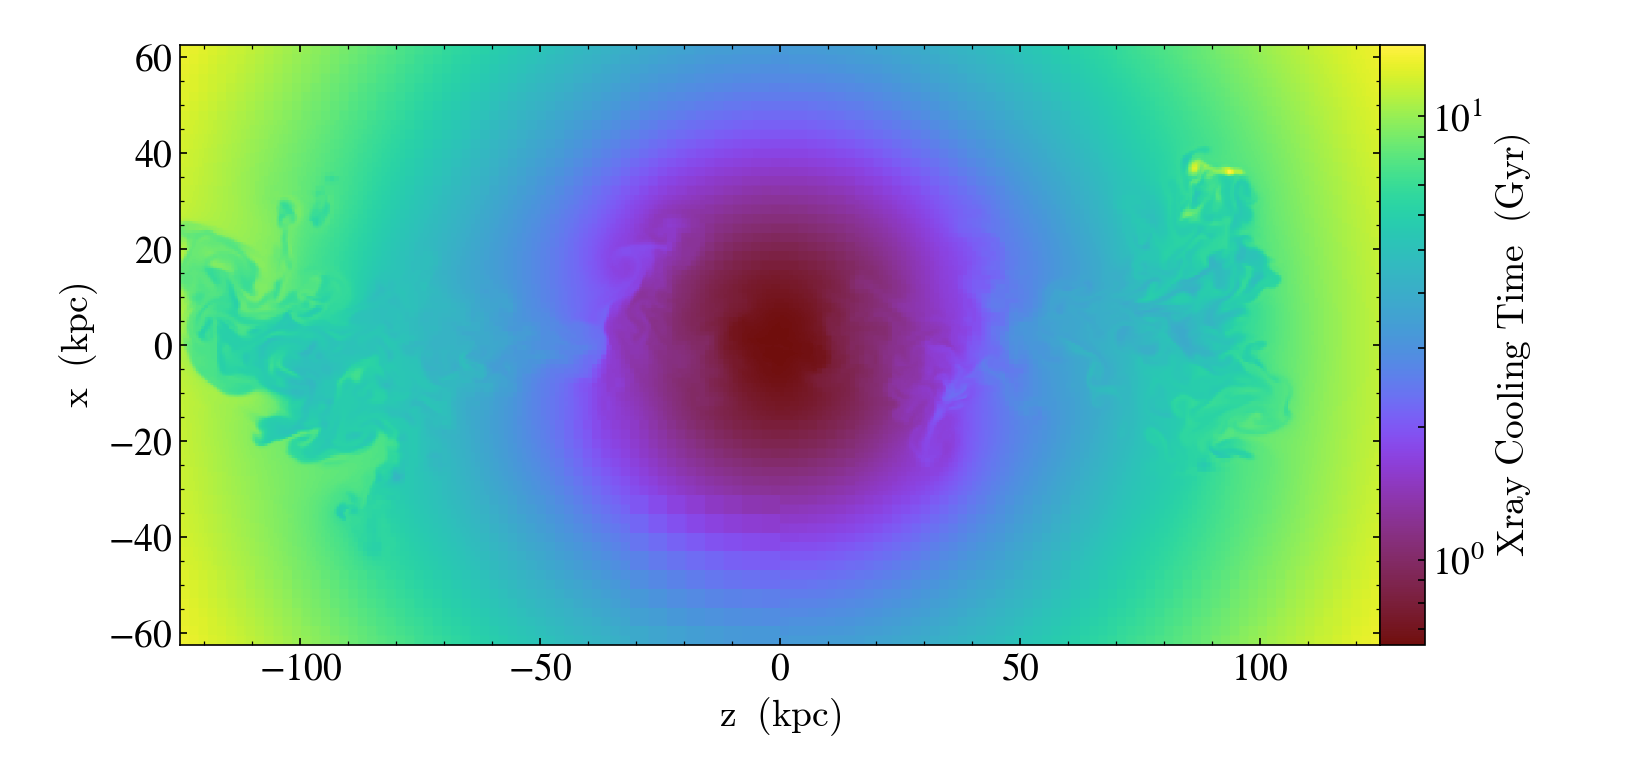

In [9]:
plot = yt.SlicePlot(ds, 'y', 'xray_cooling_time', )
plot.set_unit('xray_cooling_time', 'Gyr')
plot.zoom(4)
plot.show()


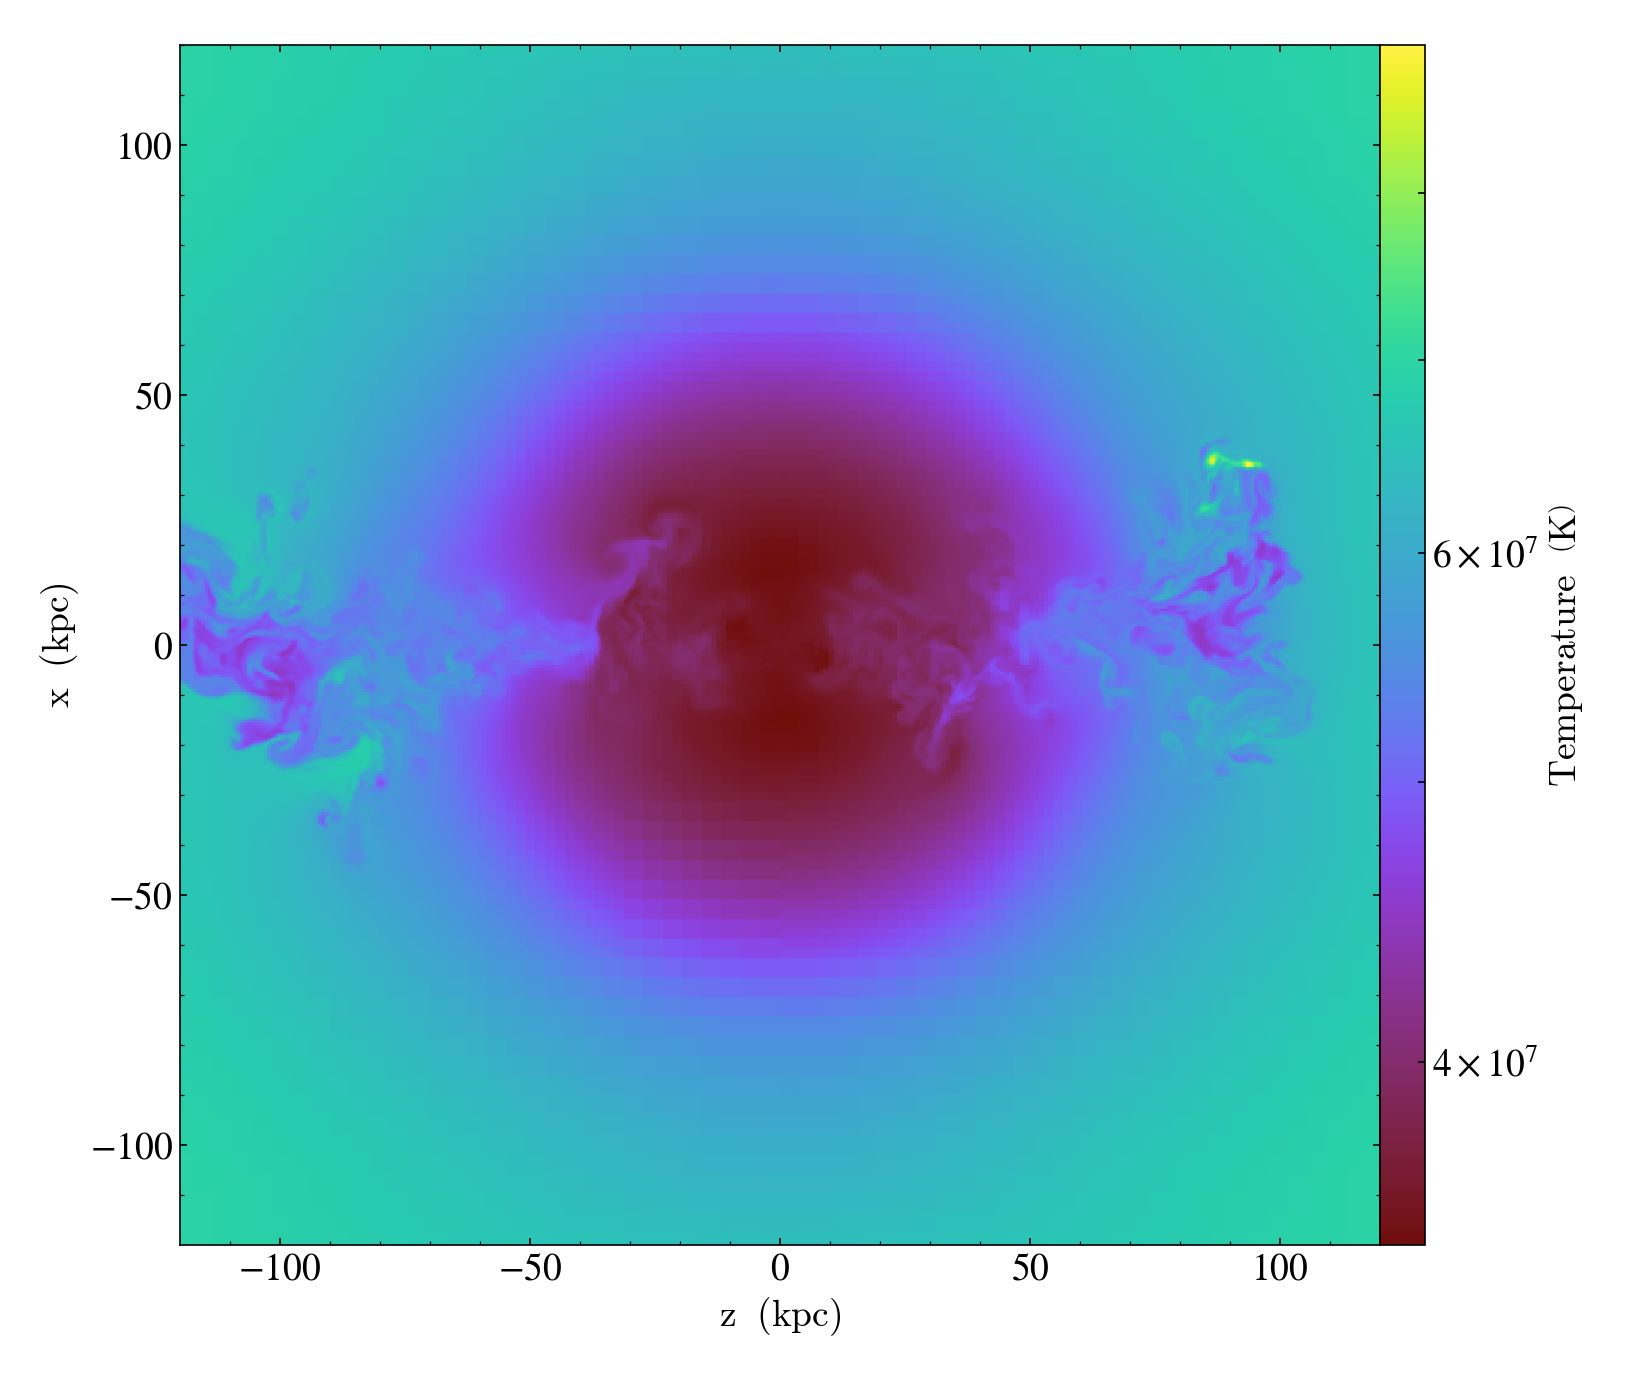

In [14]:
plot = yt.SlicePlot(ds, 'y', 'temperature', data_source=sp, width=(240, 'kpc'))
plot.show()


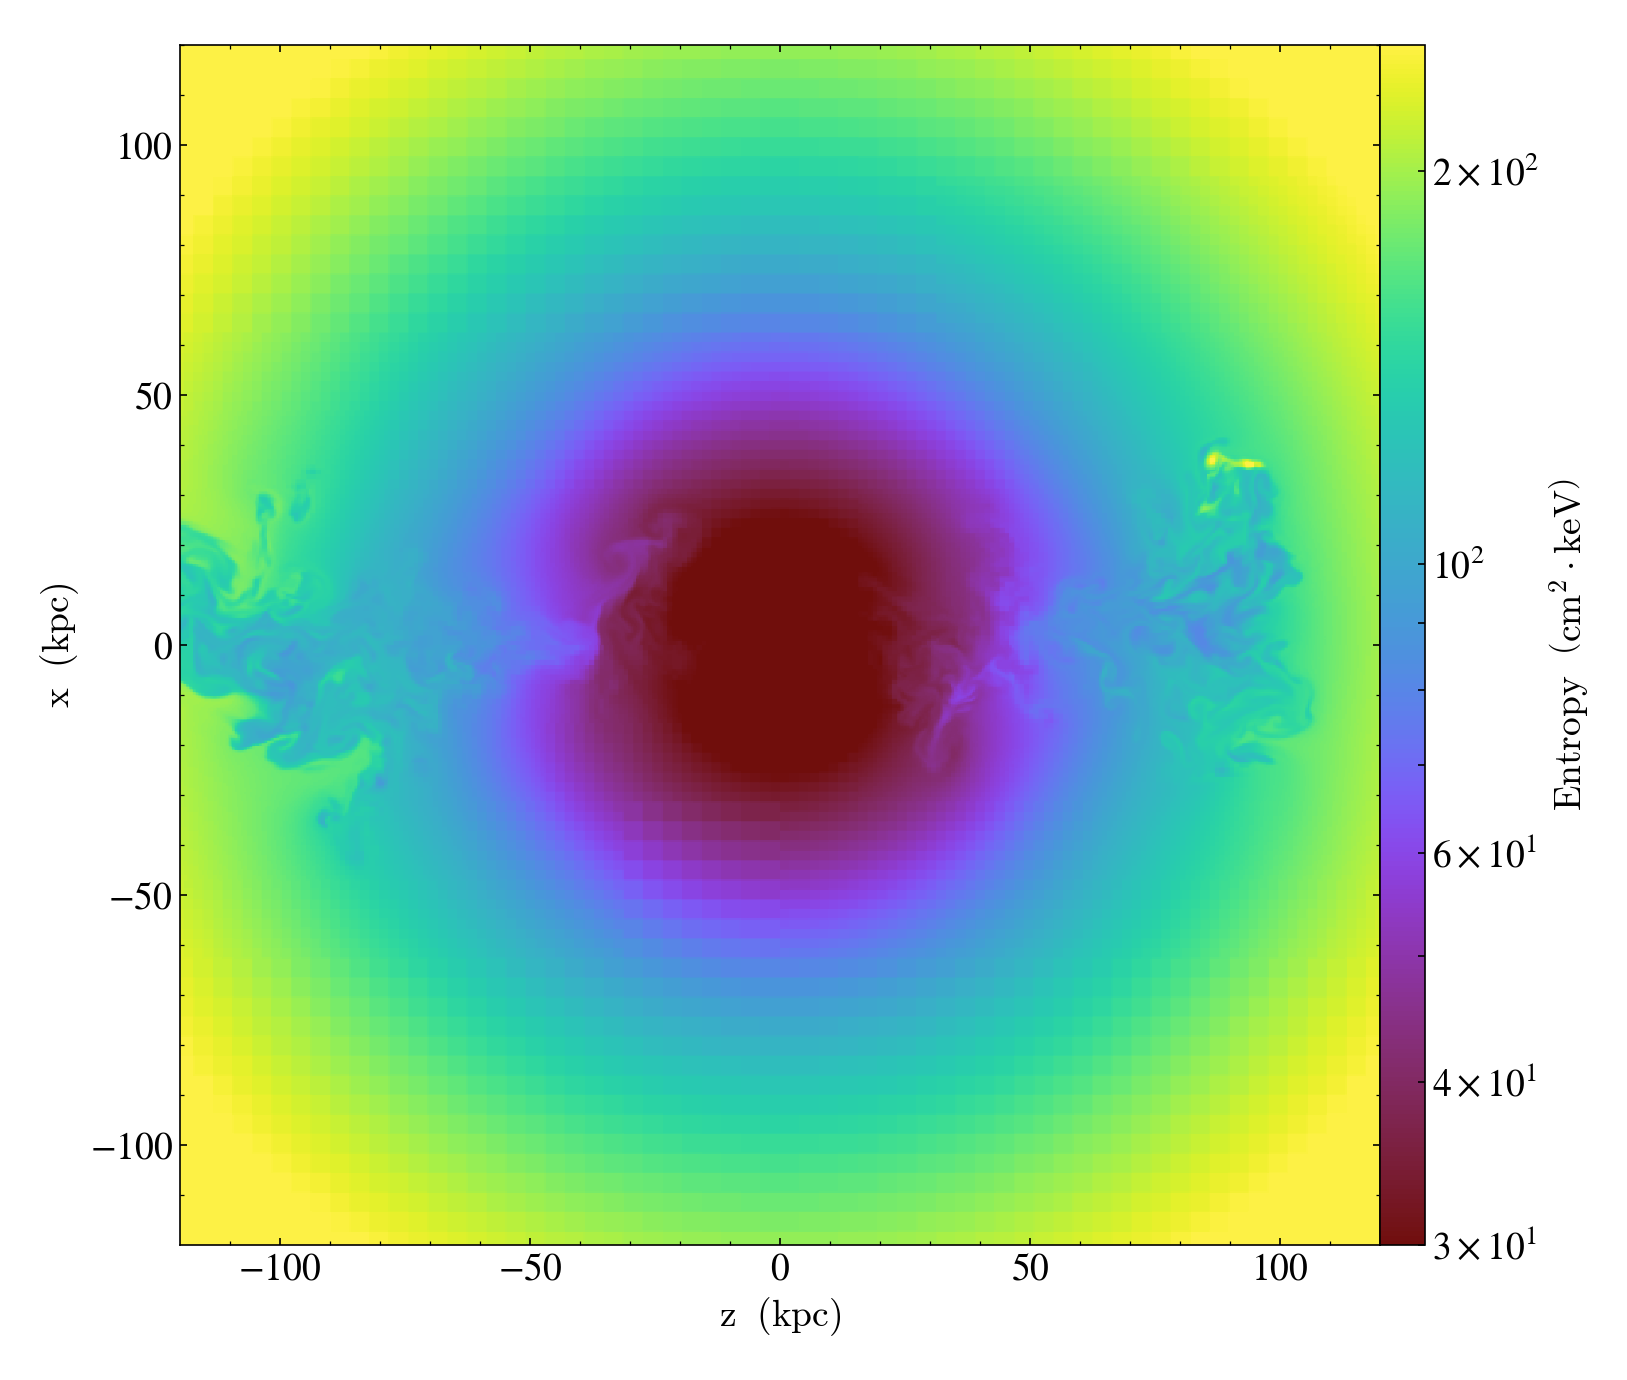

In [17]:
plot = yt.SlicePlot(ds, 'y', 'entropy', data_source=sp, width=(240, 'kpc'))
plot.set_zlim('entropy', 30, 250)
plot.show()


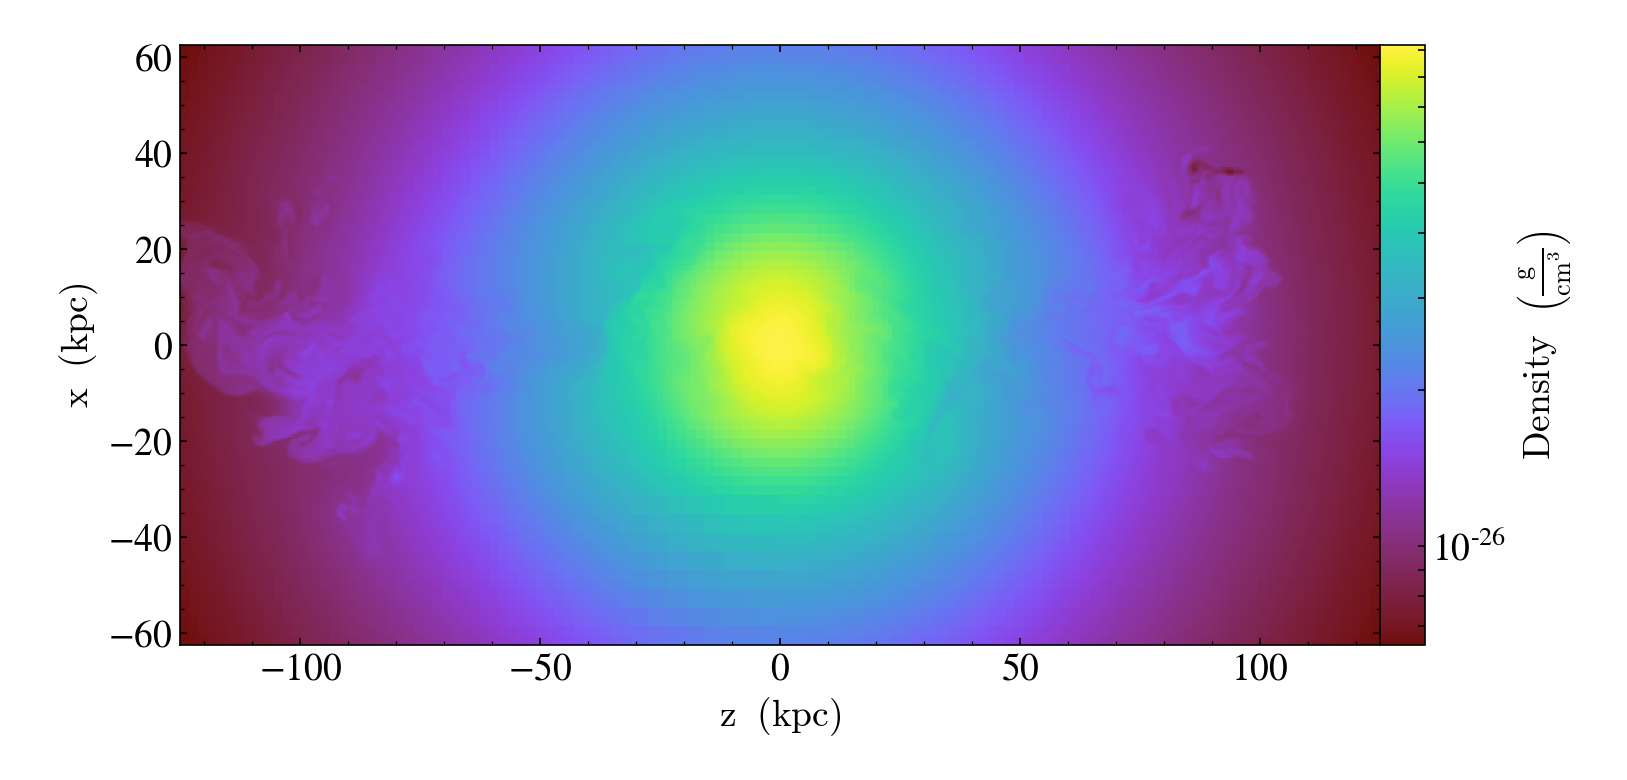

In [12]:
plot = yt.SlicePlot(ds, 'y', 'density')
plot.zoom(4)
plot.show()

In [39]:
ds = yt.load('/home/ychen/data/0only_1022_h1_10Myr/data/MHD_Jet_10Myr_hdf5_plt_cnt_1700')
sp = ds.sphere([0,0,0], (150, 'kpc'))
prof = yt.Profile2D(sp, 'spherical_radius', 100, 0.1, 100, True, 'entropy', 100, 10, 300, True)


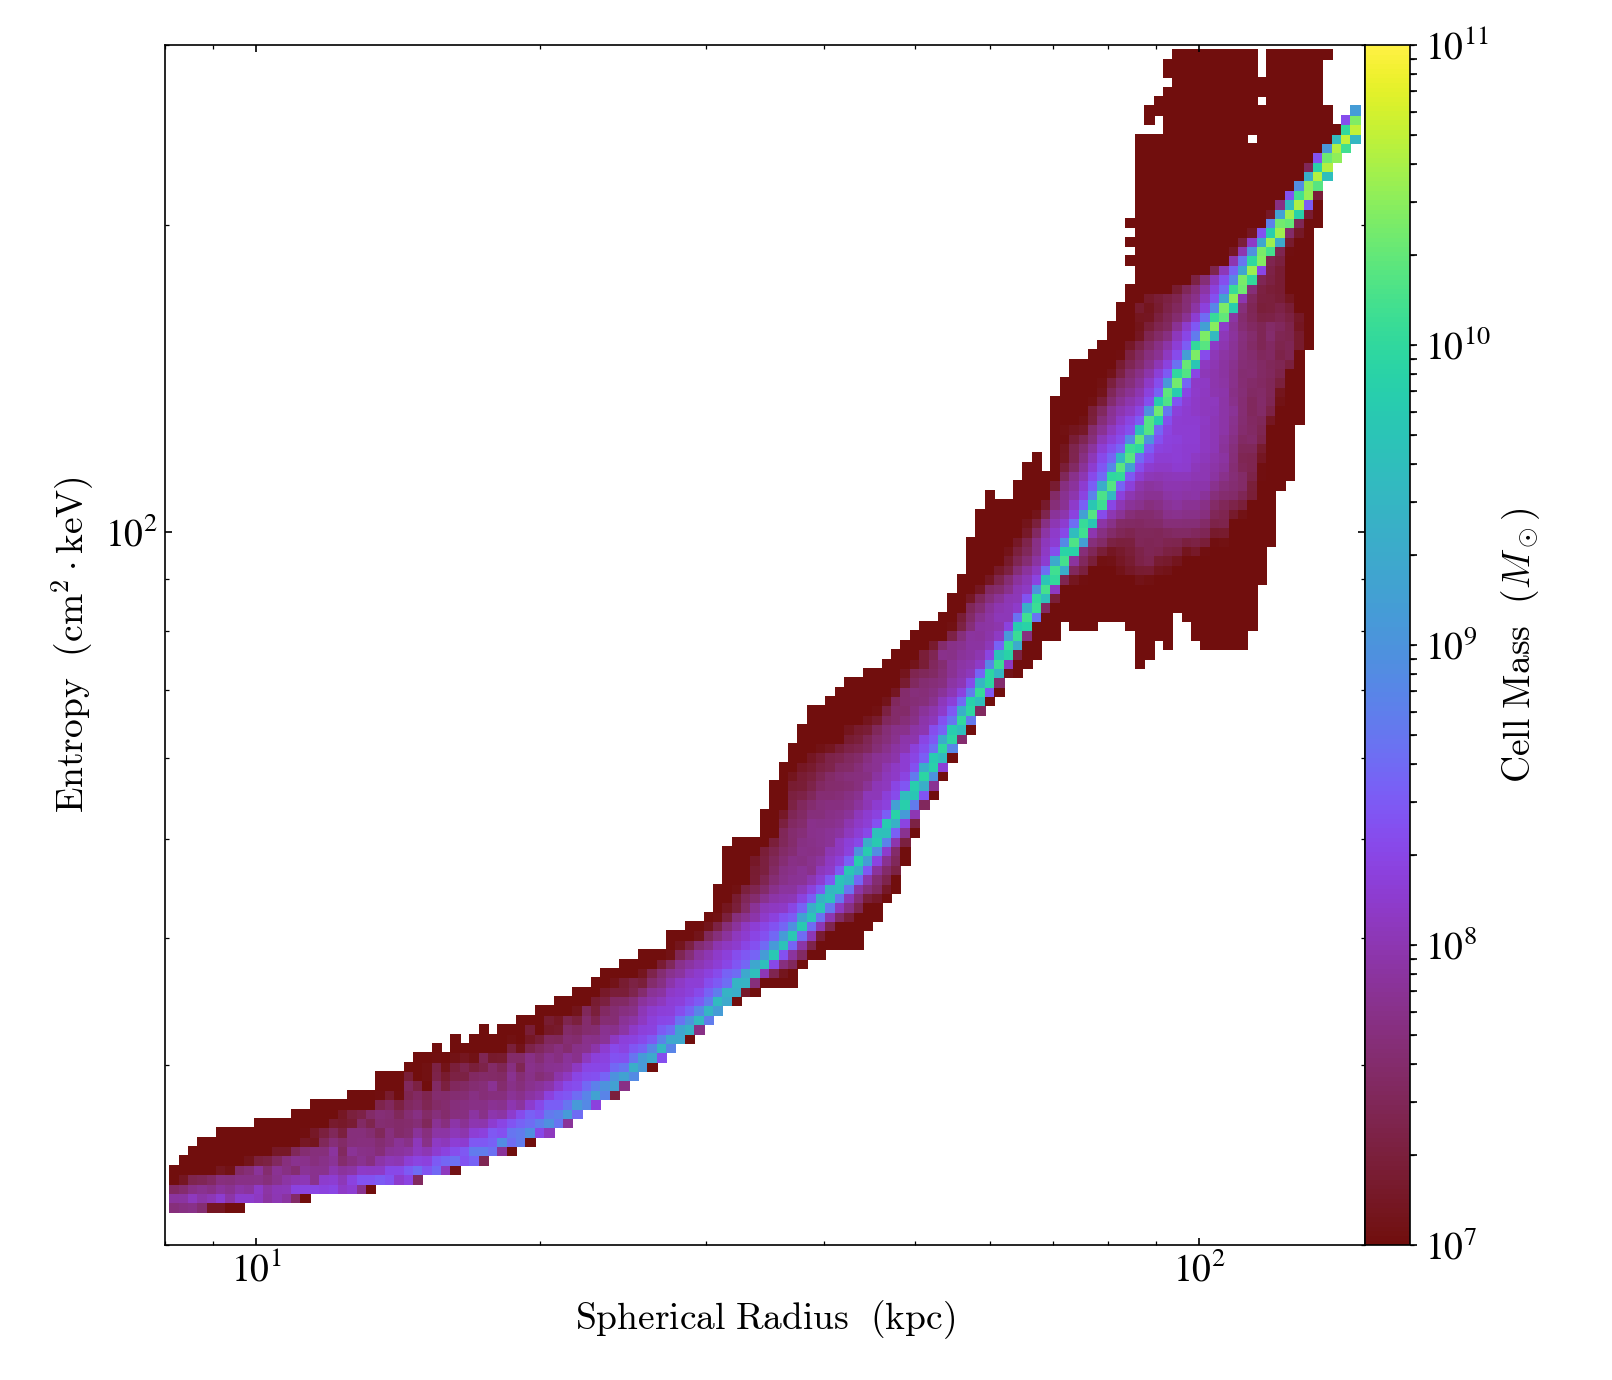

['MHD_Jet_10Myr_hdf5_plt_cnt_1700_2d-Profile_spherical_radius_entropy_cell_mass.png']

In [41]:
pp = yt.PhasePlot(sp, 'spherical_radius', 'entropy', 'cell_mass', weight_field=None)
pp.set_unit('spherical_radius', 'kpc')
pp.set_unit('cell_mass', 'Msun')
pp.set_xlim(8, 150)
pp.set_ylim(20, 300)
pp.set_zlim('cell_mass', 1E7, 1E11)
pp.show()
pp.save()

In [46]:
pp.set_zlim('cell_mass', 1E6, 1E10)
cmap = plt.cm.arbre()
cmap.set_bad('purple')
pp.show()

TypeError: 'dict' object is not callable

In [60]:
box['temperature'].to_equivalent('keV', 'thermal')

YTArray([ 5.89883703,  5.88709746,  5.8726748 , ...,  5.87447824,
        5.88700991,  5.89856403]) keV

In [63]:
box['H_nuclei_density']

YTArray([ 0.00255889,  0.00260189,  0.00264677, ...,  0.00264559,
        0.00260211,  0.00255946]) cm**(-3)

In [30]:
ds.add_gradient_fields(('gas', 'temperature'))

#le = ds.domain_left_edge/4
#re = ds.domain_right_edge/4
#box = ds.box(le, re)



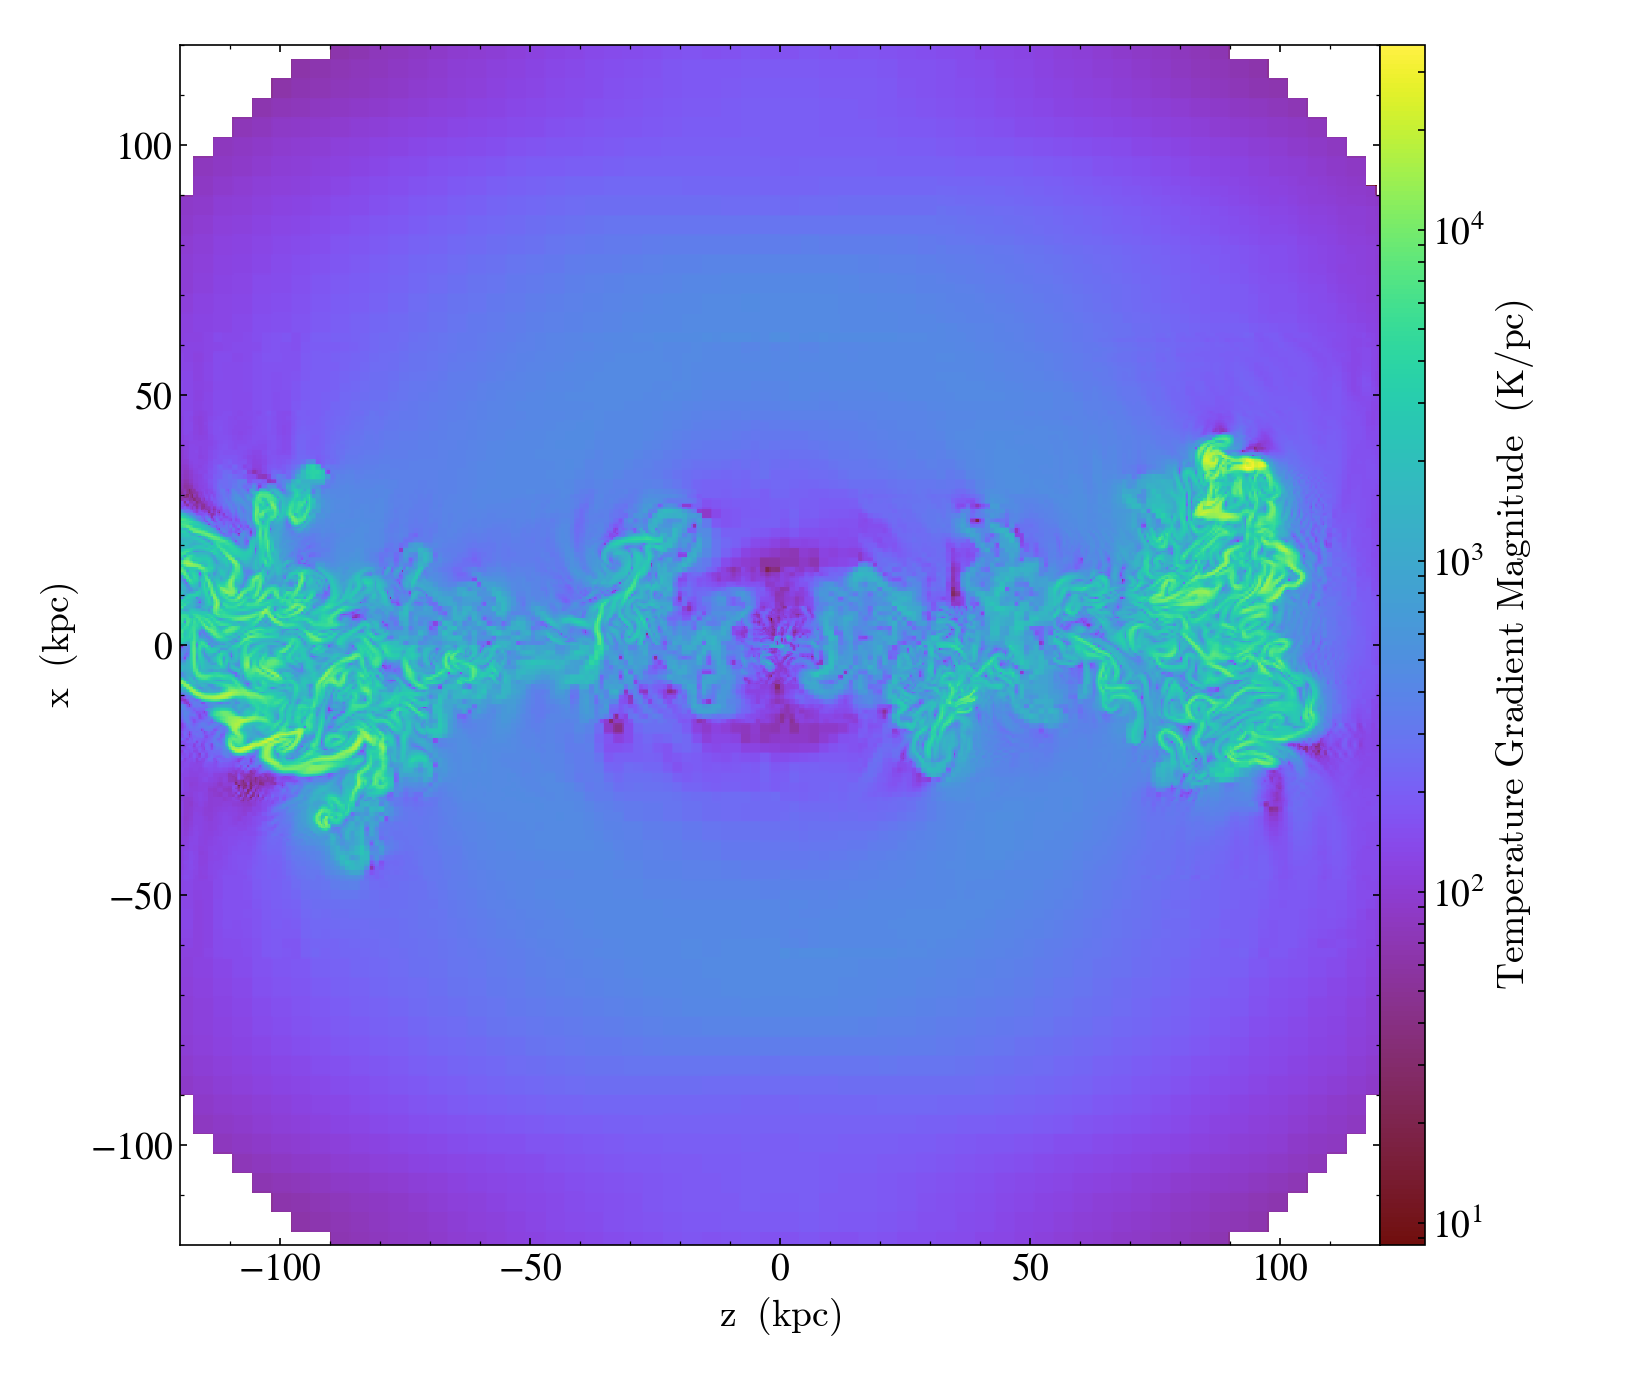

In [37]:
plot = yt.SlicePlot(ds, 'y', 'temperature_gradient_magnitude', data_source=sp, width=(240, 'kpc'))
plot.set_unit('temperature_gradient_magnitude', 'K/pc')
plot.show()

yt : [WARNING  ] 2018-05-10 19:13:54,189 Plot image for field ('gas', 'temperature_gradient_x') has both positive and negative values. Min = -0.000000, Max = 0.000000.
yt : [WARNING  ] 2018-05-10 19:13:54,192 Switching to symlog colorbar scaling unless linear scaling is specified later



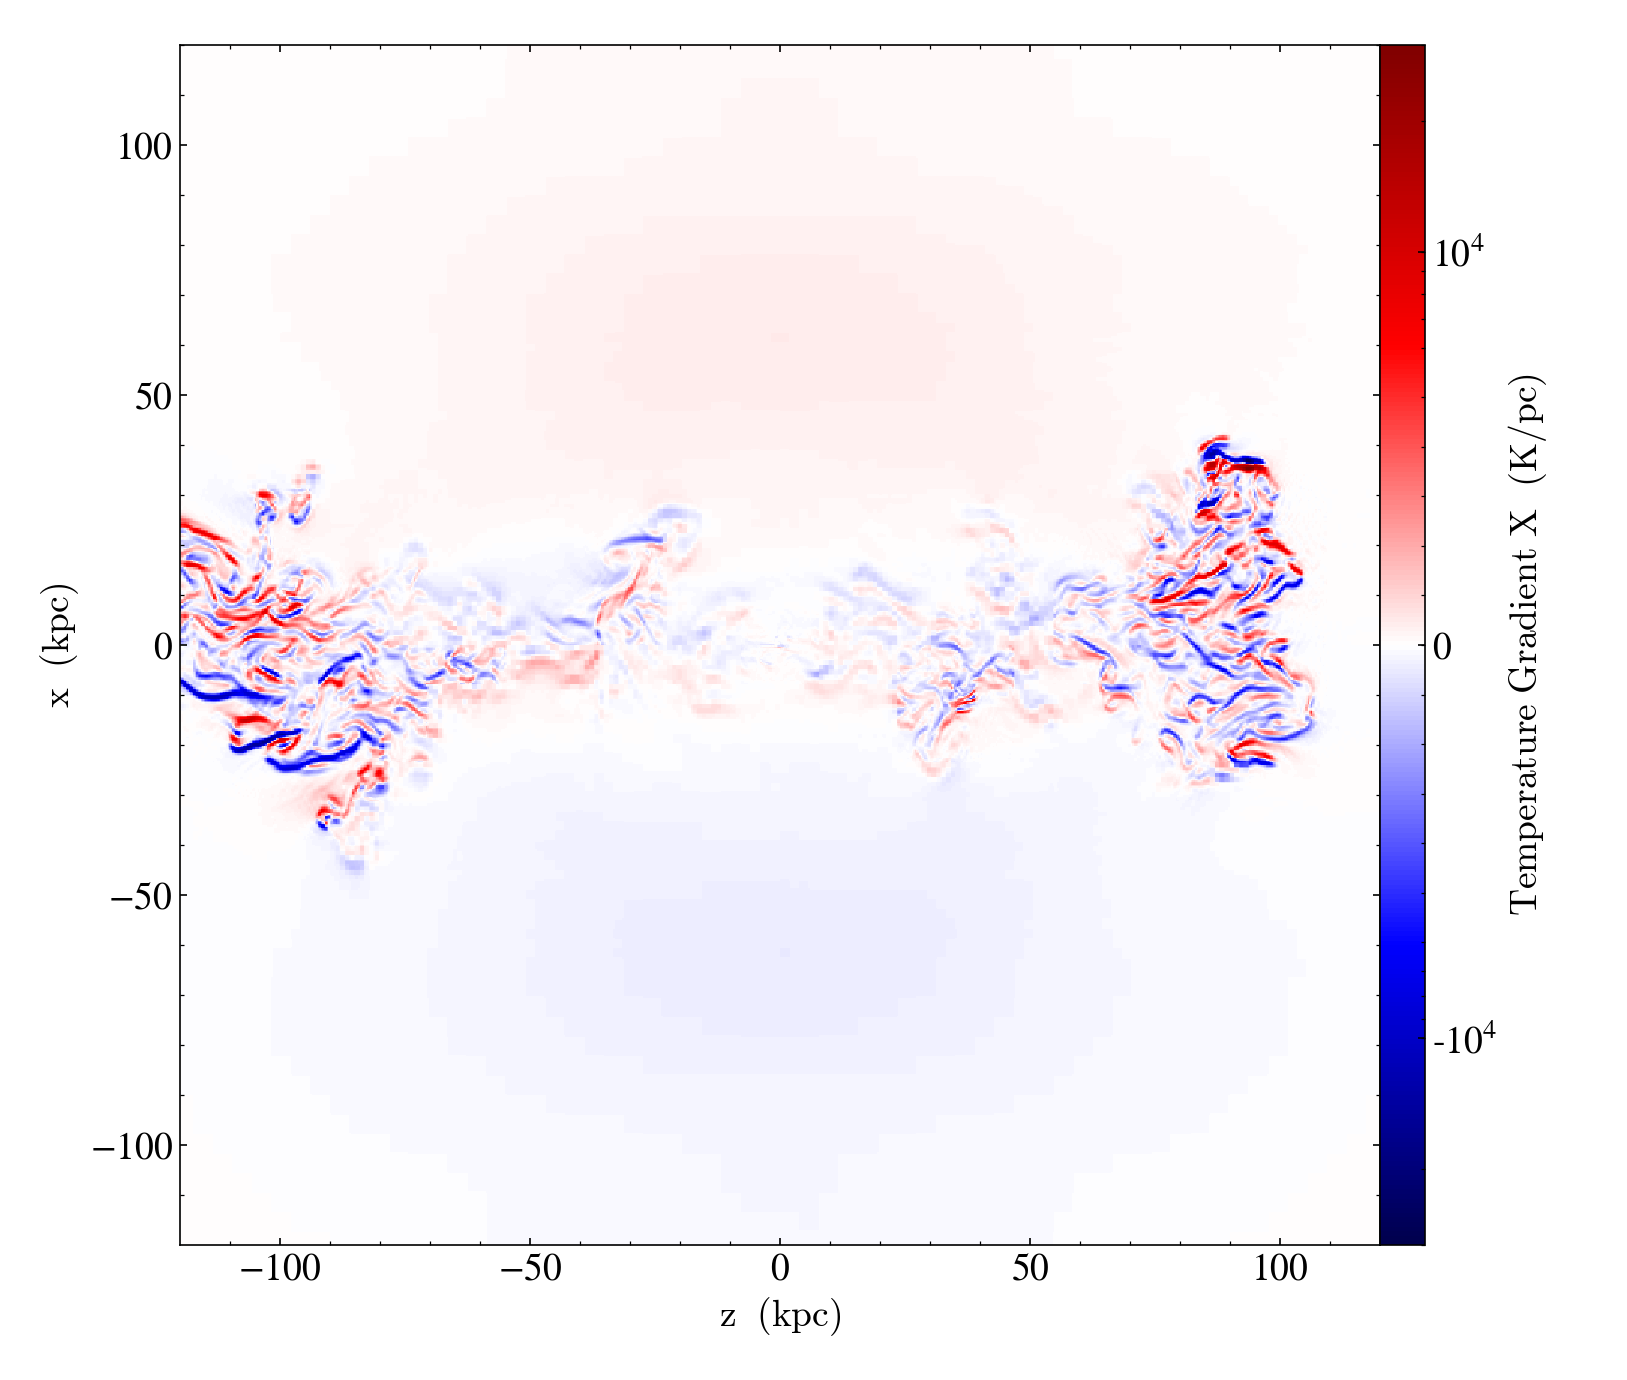

In [38]:
plot = yt.SlicePlot(ds, 'y', 'temperature_gradient_x', data_source=sp, width=(240, 'kpc'))
plot.set_unit('temperature_gradient_x', 'K/pc')
plot.set_cmap('temperature_gradient_x', 'seismic')
plot.set_zlim('temperature_gradient_x', -3E4, 3E4)
plot.show()


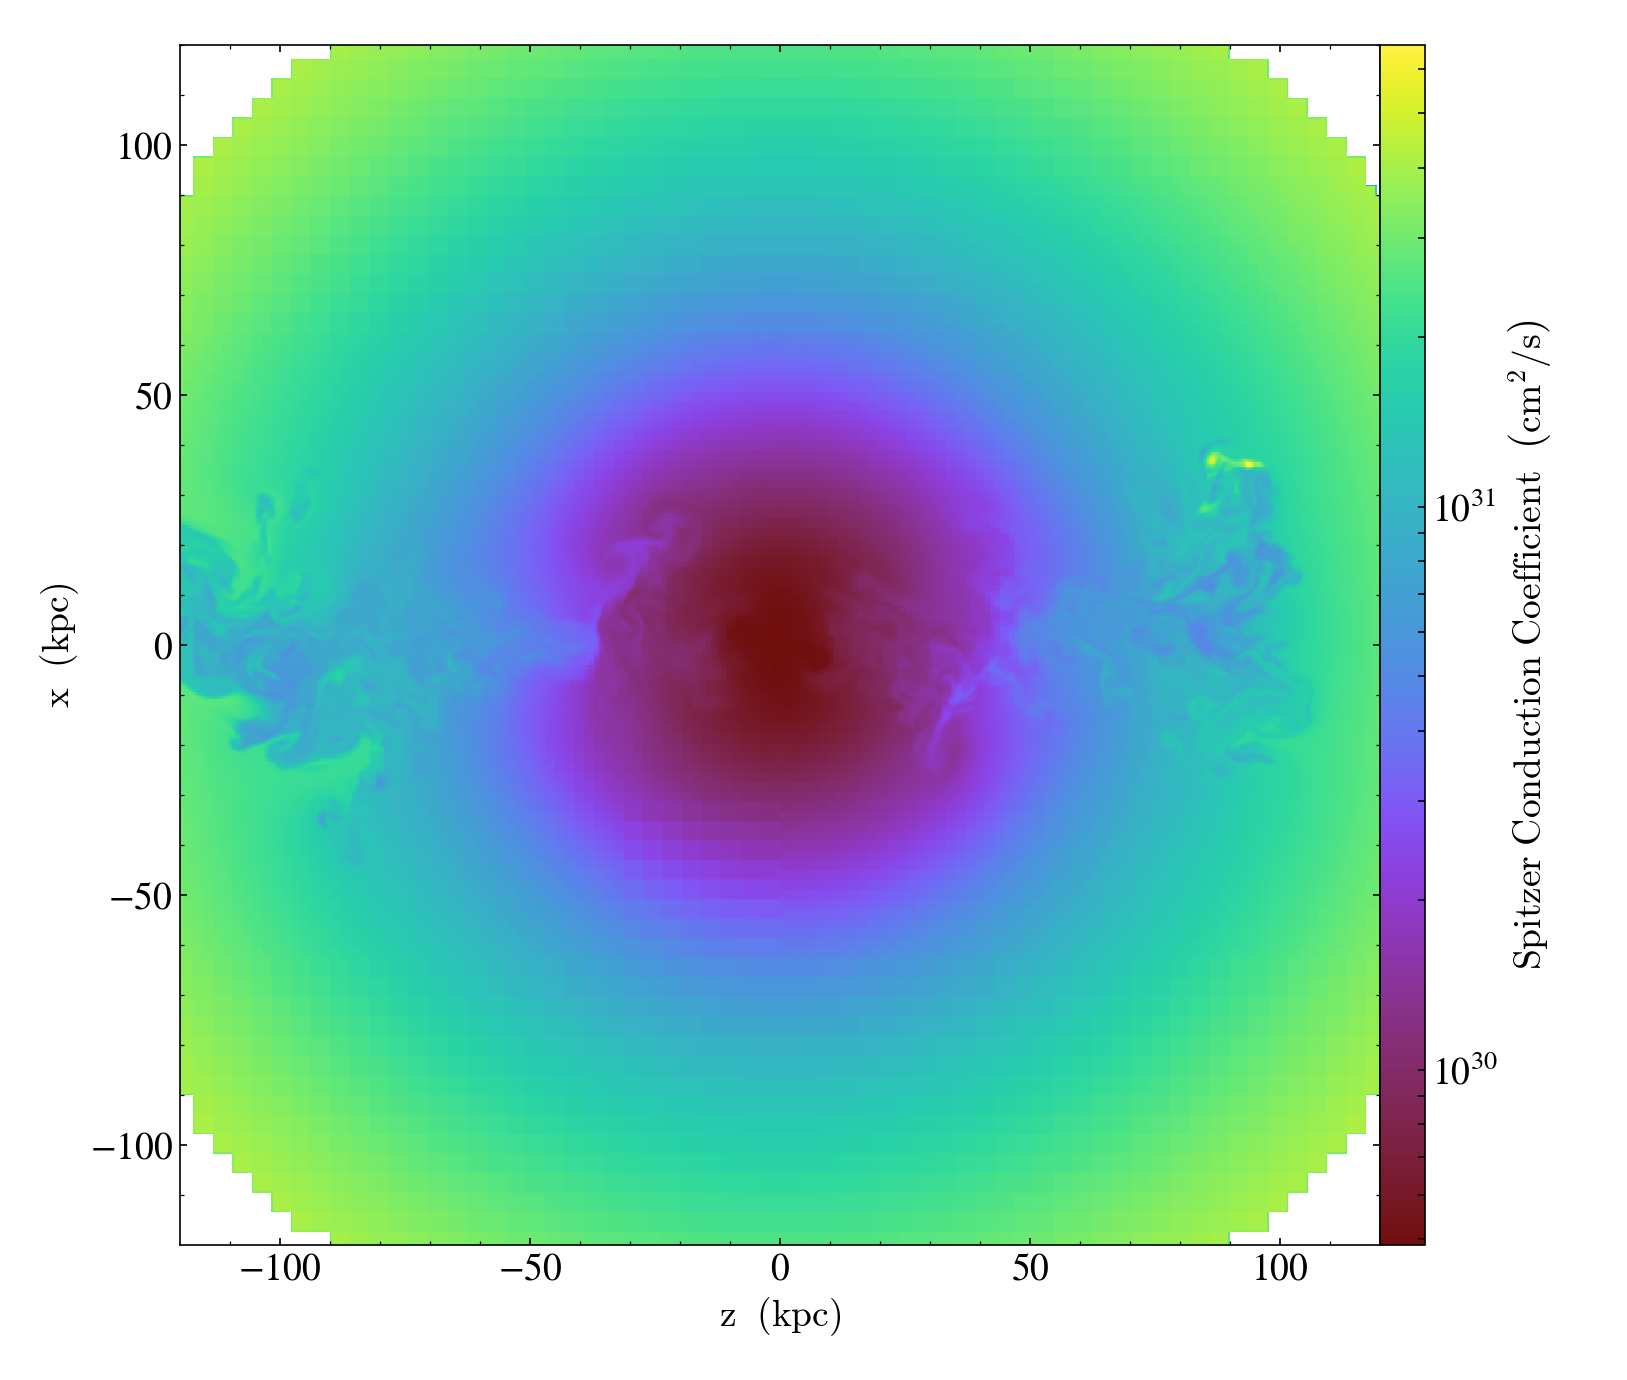

In [39]:
plot = yt.SlicePlot(ds, 'y', 'spitzer_conduction_coefficient', data_source=sp, width=(240, 'kpc'))
plot.show()

yt : [WARNING  ] 2018-05-12 22:56:49,230 Plot image for field ('gas', 'spitzer_heat_flux_x') has both positive and negative values. Min = -0.200316, Max = 0.168001.
yt : [WARNING  ] 2018-05-12 22:56:49,234 Switching to symlog colorbar scaling unless linear scaling is specified later



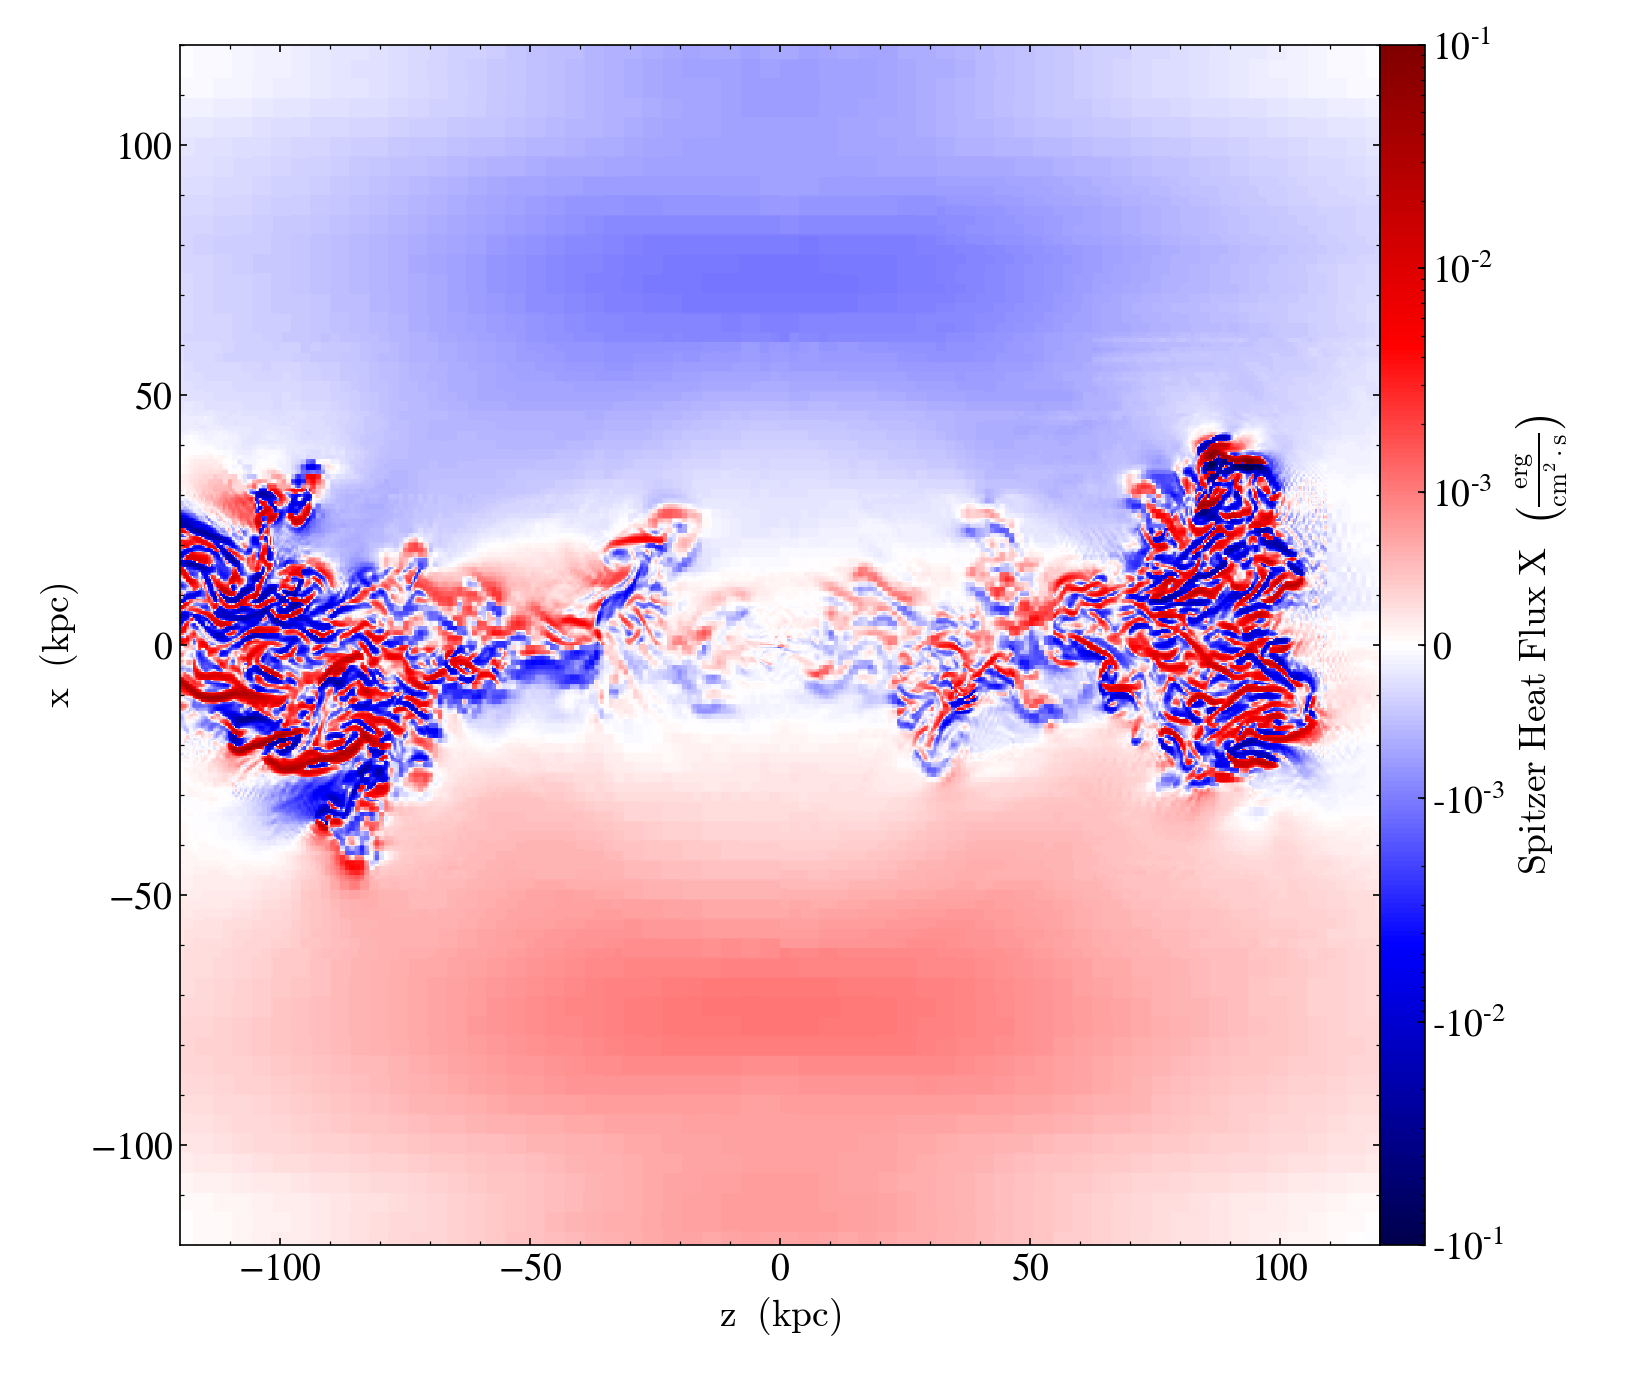

In [16]:
plot = yt.SlicePlot(ds, 'y', 'spitzer_heat_flux_x', data_source=sp, width=(240, 'kpc'))
plot.set_log('spitzer_heat_flux_x' , True, linthresh=1E-3)
plot.set_cmap('spitzer_heat_flux_x', 'seismic')
plot.set_zlim('spitzer_heat_flux_x', -1E-1, 1E-1)
plot.show()

yt : [WARNING  ] 2018-05-14 07:35:00,684 Plot image for field ('gas', 'spitzer_heat_flux_divergence') has both positive and negative values. Min = -0.000000, Max = 0.000000.
yt : [WARNING  ] 2018-05-14 07:35:00,688 Switching to symlog colorbar scaling unless linear scaling is specified later



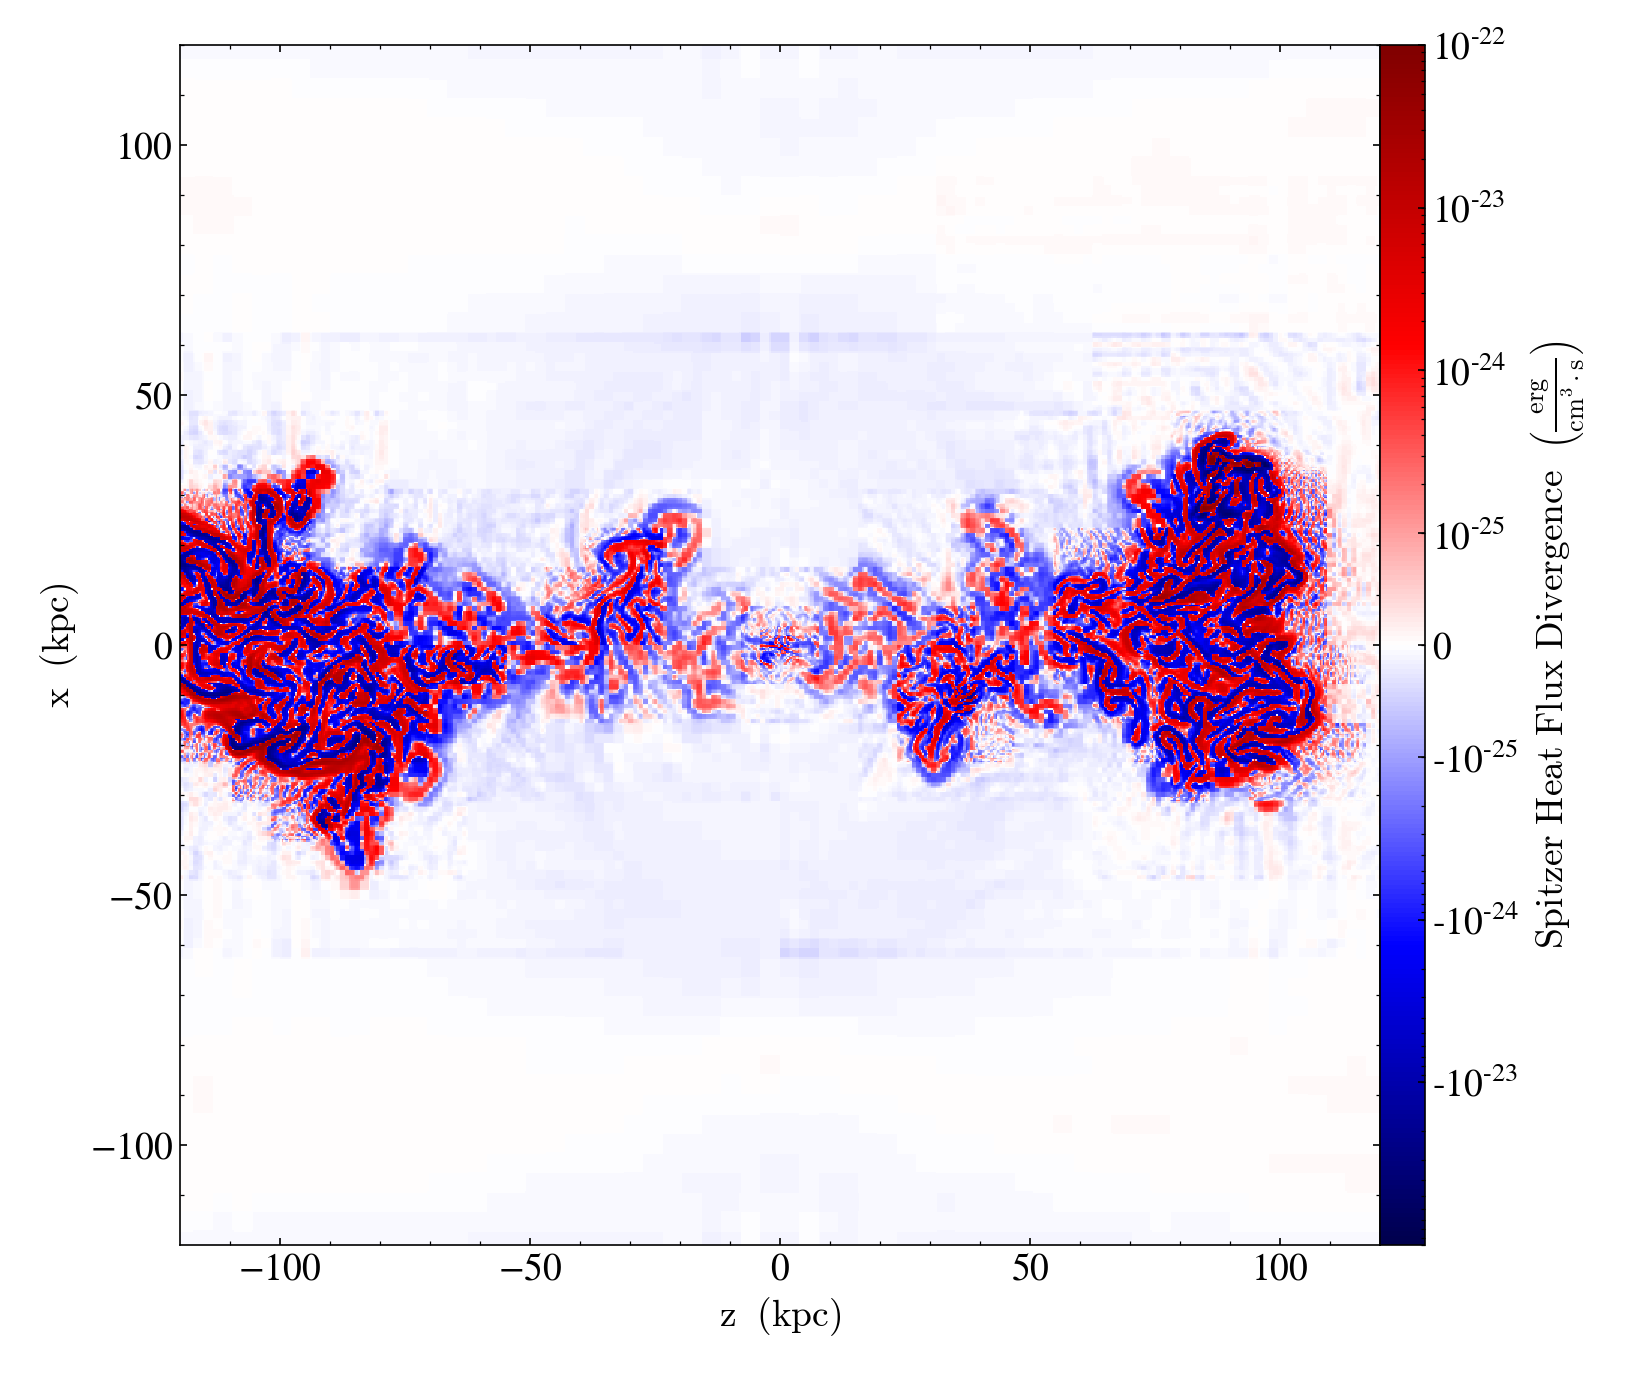

In [23]:
plot = yt.SlicePlot(ds, 'y', 'spitzer_heat_flux_divergence', data_source=sp, width=(240, 'kpc'))

plot.set_log('spitzer_heat_flux_divergence' , True, linthresh=1E-25)
plot.set_cmap('spitzer_heat_flux_divergence', 'seismic')
plot.set_zlim('spitzer_heat_flux_divergence', -1E-22, 1E-22)
plot.show()

yt : [WARNING  ] 2018-05-14 07:37:22,776 Plot image for field ('gas', 'total_heating_rate') has both positive and negative values. Min = -888336620233762500720938966594301076701184.000000, Max = 216173858096431130918417663570032023568384.000000.
yt : [WARNING  ] 2018-05-14 07:37:22,780 Switching to symlog colorbar scaling unless linear scaling is specified later



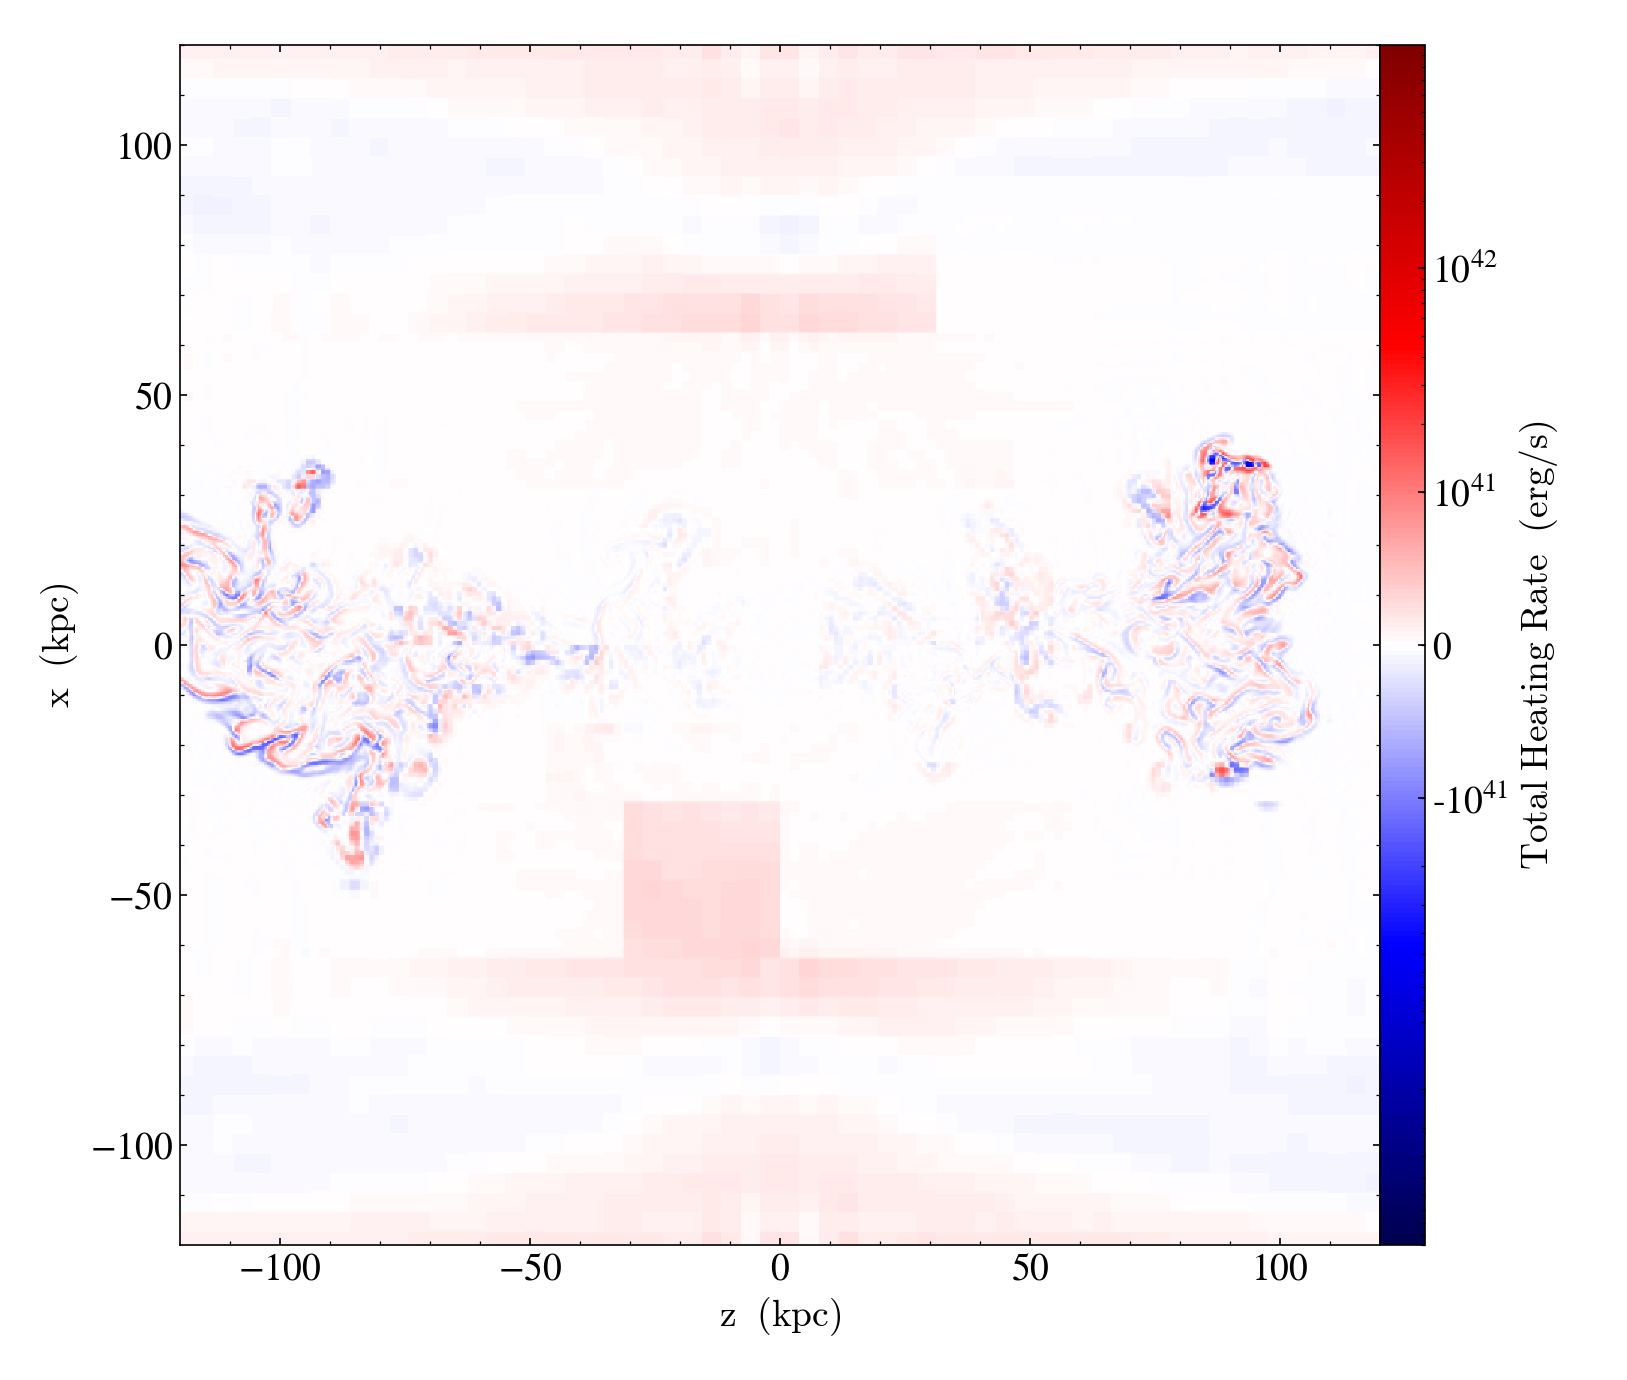

In [24]:
plot = yt.SlicePlot(ds, 'y', 'total_heating_rate', data_source=sp, width=(240, 'kpc'))

plot.set_log('total_heating_rate' , True, linthresh=1E41)
plot.set_cmap('total_heating_rate', 'seismic')
plot.set_zlim('total_heating_rate', -1E43, 1E43)
plot.show()

yt : [WARNING  ] 2018-05-14 07:33:24,522 Plot image for field ('gas', 'spitzer_heating_rate') has both positive and negative values. Min = -888336620233762500720938966594301076701184.000000, Max = 216173858096431130918417663570032023568384.000000.
yt : [WARNING  ] 2018-05-14 07:33:24,526 Switching to symlog colorbar scaling unless linear scaling is specified later



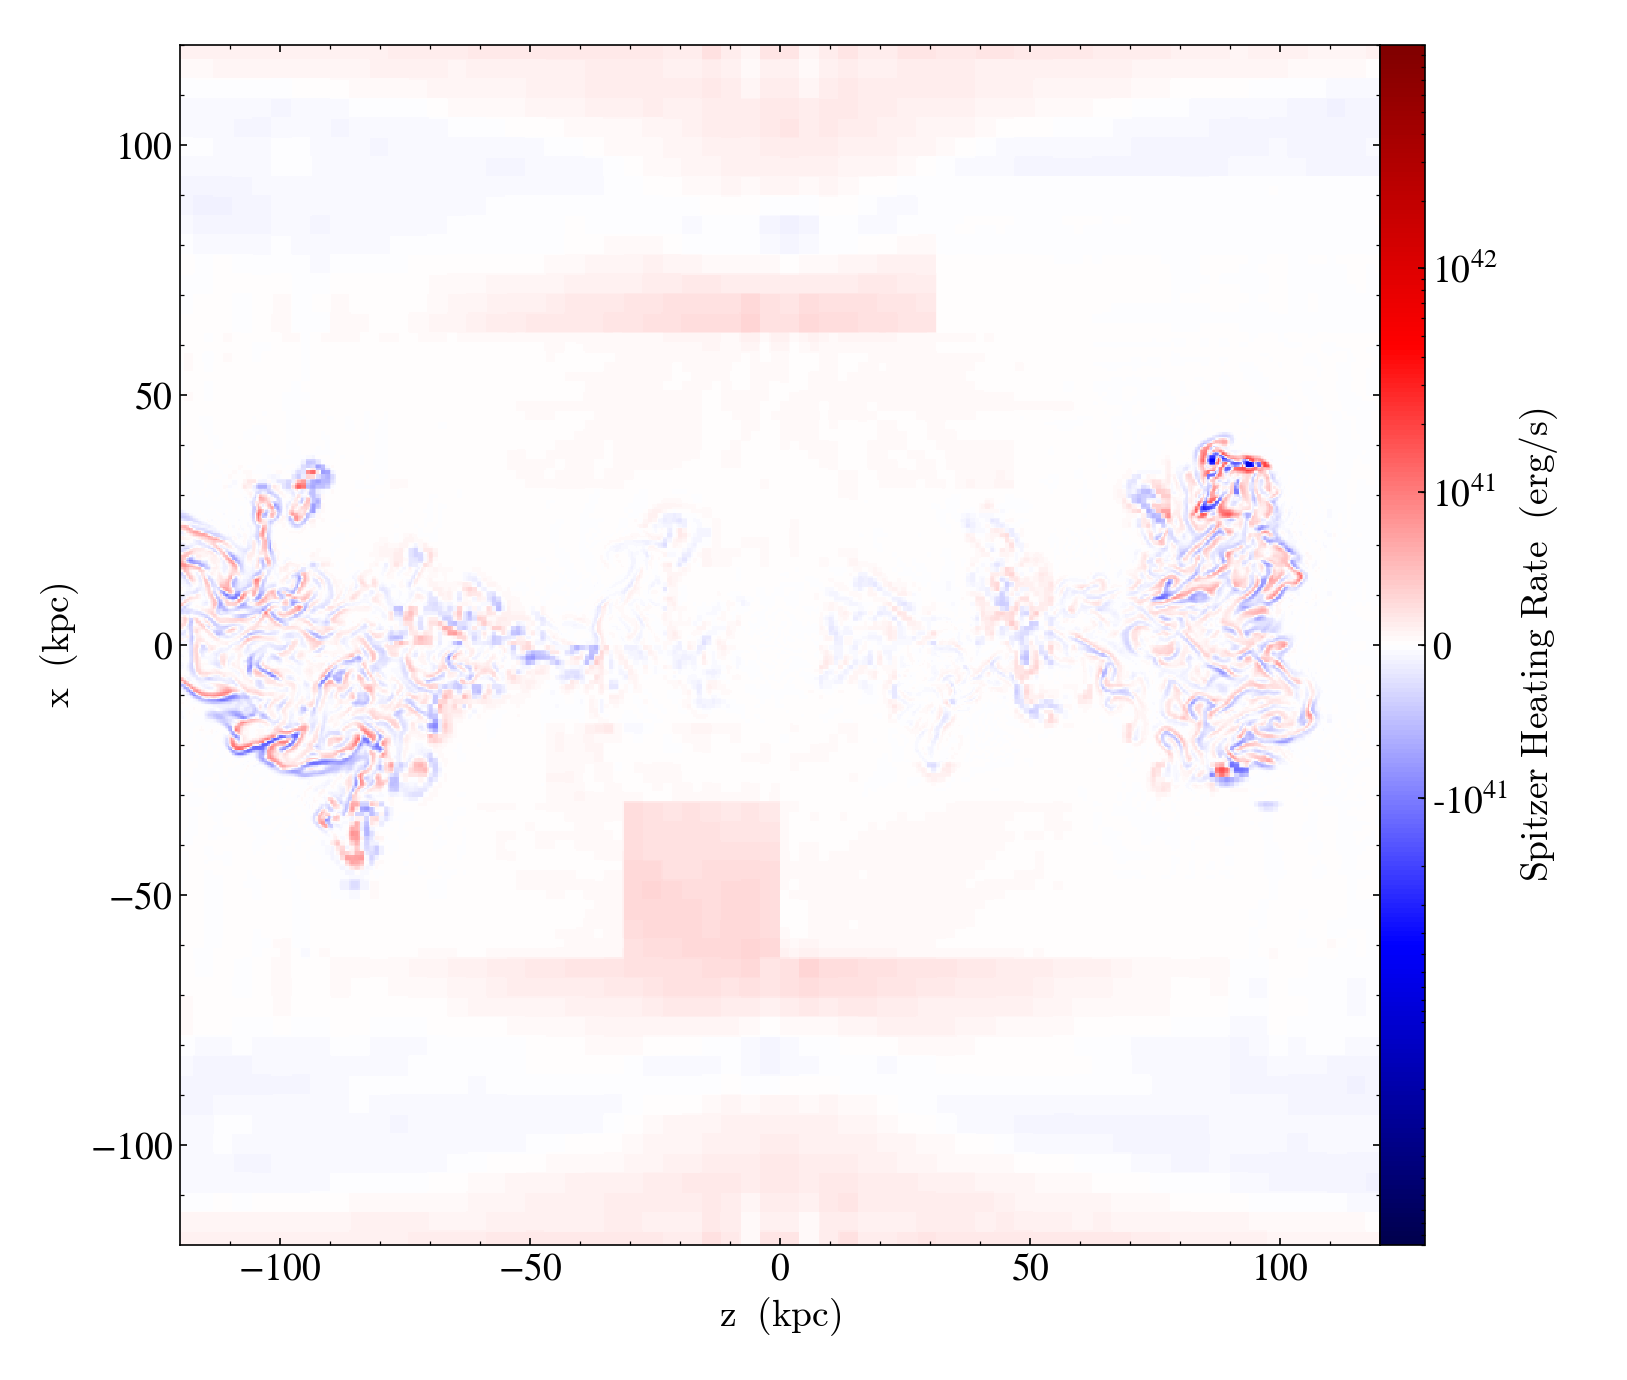

In [22]:
plot = yt.SlicePlot(ds, 'y', 'spitzer_heating_rate', data_source=sp, width=(240, 'kpc'))

plot.set_log('spitzer_heating_rate' , True, linthresh=1E41)
plot.set_cmap('spitzer_heating_rate', 'seismic')
plot.set_zlim('spitzer_heating_rate', -1E43, 1E43)
plot.show()

yt : [WARNING  ] 2018-06-22 11:03:22,246 Plot image for field ('gas', 'total_cooling_time') has both positive and negative values. Min = -1271844.399105, Max = 5184567.763767.
yt : [WARNING  ] 2018-06-22 11:03:22,251 Switching to symlog colorbar scaling unless linear scaling is specified later



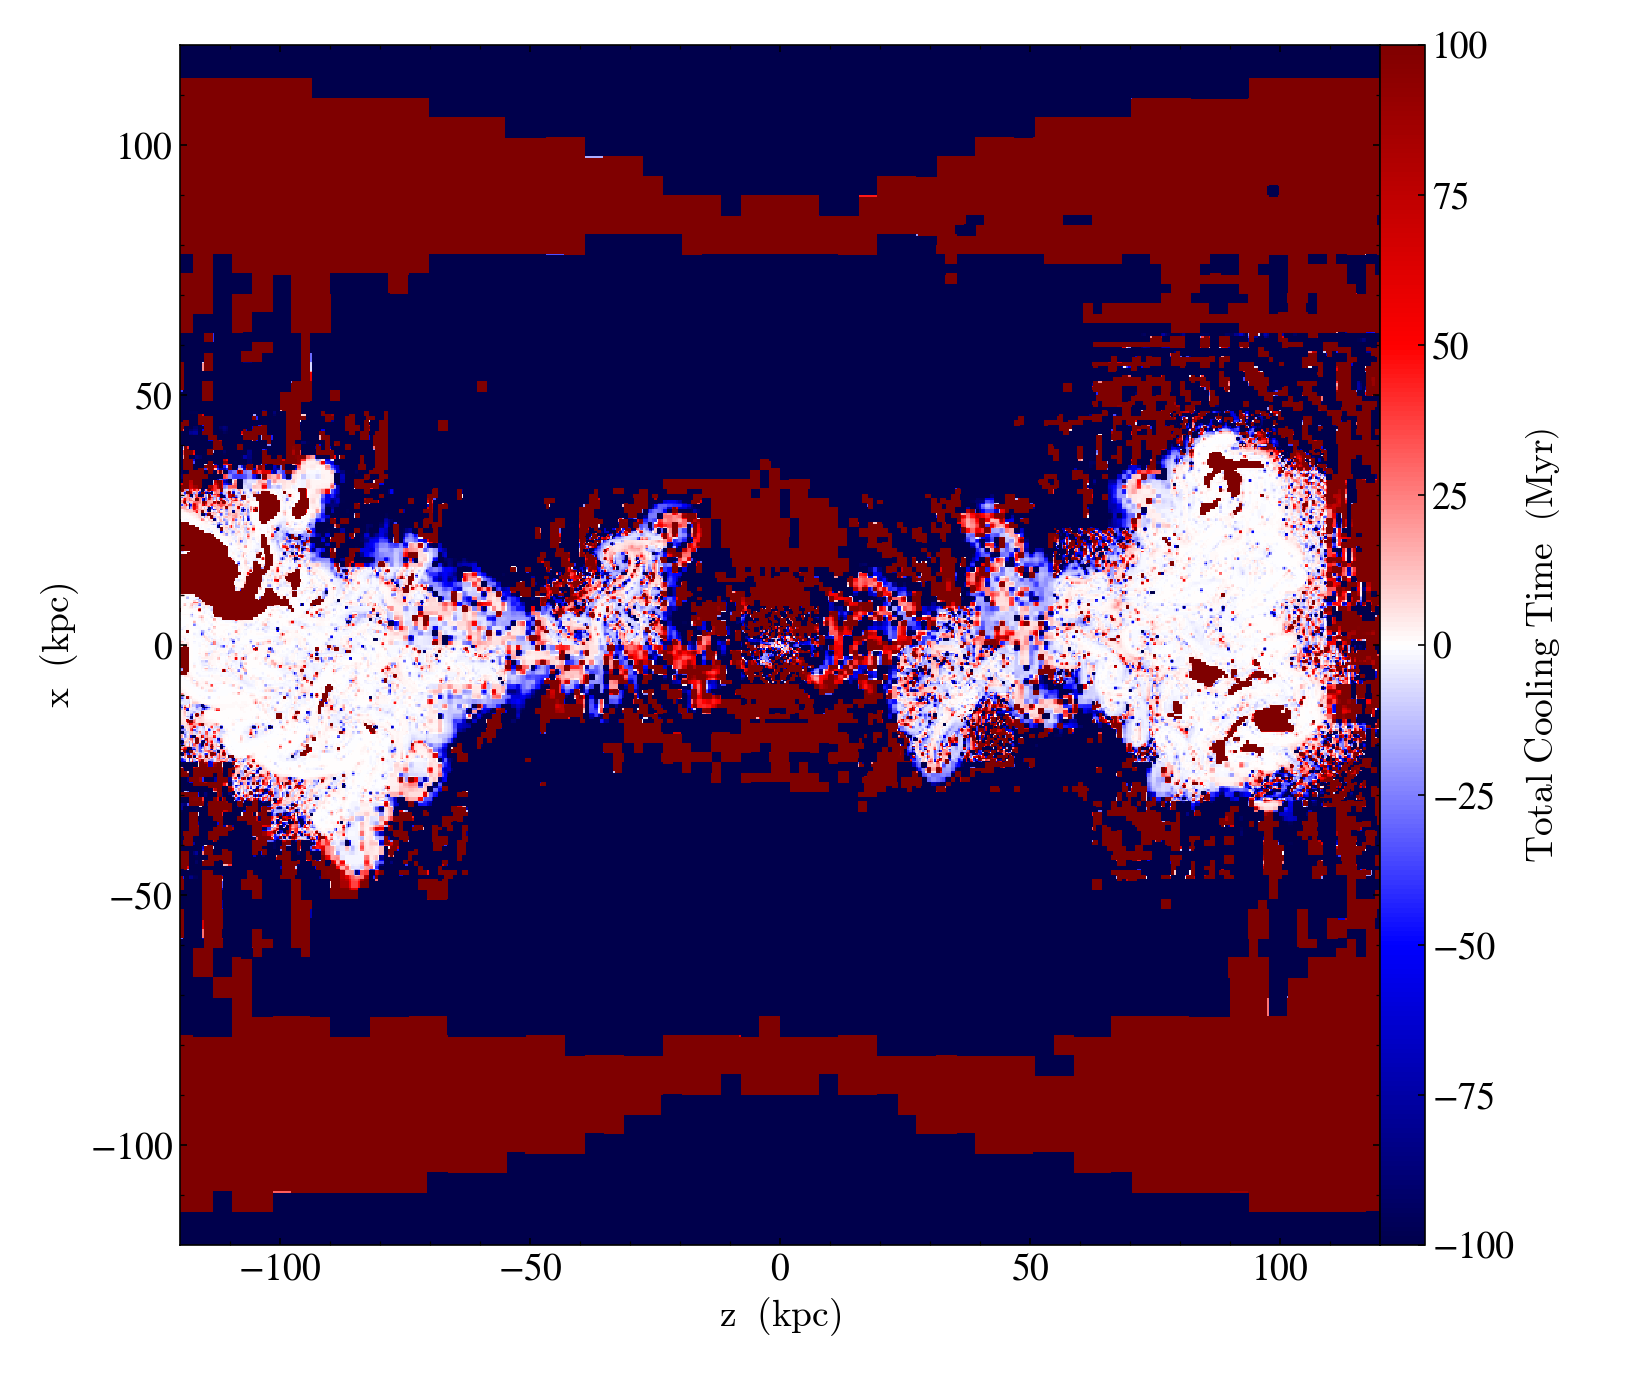

In [5]:
plot = yt.SlicePlot(ds, 'y', 'total_cooling_time', data_source=sp, width=(240, 'kpc'))

plot.set_log('total_cooling_time' , False)
plot.set_cmap('total_cooling_time', 'seismic')
plot.set_zlim('total_cooling_time', -1E2, 1E2)
plot.show()

In [ ]:
extrema = {'entropy': (20, 324)}
logs = {'entropy': True}
fields = ['spitzer_heating_rate', 'xray_luminosity_0.1_100_keV', 'cell_mass']
prof_entropy = yt.create_profile(sp, 'entropy', fields, weight_field=None, 
                         extrema=extrema, logs=logs)

(20, 325)

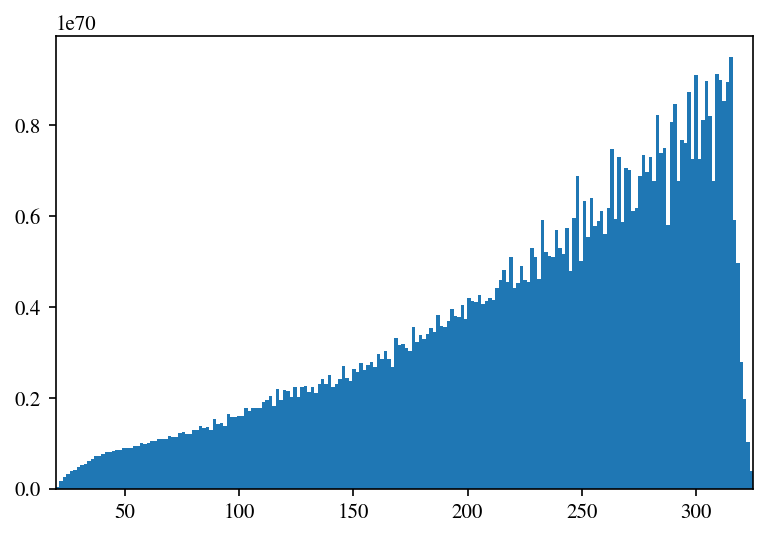

In [33]:
null = plt.hist(sp['entropy'], range=(20,325), weights=sp['cell_volume'], bins=200)
plt.xlim(20, 325)

In [ ]:
plt.step(prof_entropy.x, prof_entropy['cell_mass'])
plt.semilogx()

In [ ]:
plt.step(prof_entropy.x, -prof_entropy['xray_luminosity_0.1_100_keV'], label='X-ray Cooling')
plt.step(prof_entropy.x, prof_entropy['spitzer_heating_rate'], label='Spitzer Thermal Conduction')
plt.step(prof_entropy.x, prof_entropy['spitzer_heating_rate']-prof_entropy['xray_luminosity_0.1_100_keV'], label='Total')

plt.ylim(-1E46, 1E46)
plt.yscale('symlog', linthreshy=2E42)
yticks = [-1E46, -1E45, -1E44, -1E43, -1E42, 0, 1E42, 1E43, 1E44, 1E45, 1E46]
plt.yticks(yticks, yticks)

plt.ylabel('Heating/Cooling rate (erg/s)')
plt.semilogx()
plt.xlim(20, 250)
entropy_ticks = [20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300]
plt.xticks(entropy_ticks, entropy_ticks)
plt.xlabel(r'entropy (cm$^2\ $ keV)')
plt.axhline(0, ls=':', color='grey')
plt.text(22, 1E45, '%.0f Myr' % ds.current_time.in_units('Myr'))
plt.legend()

In [ ]:
sum(prof_entropy['spitzer_heating_rate'])

In [29]:
extrema = {'entropy': (20, 324), 'spherical_radius': ((10, 'kpc'), (150, 'kpc'))}
fields = ['spitzer_heating_rate', 'xray_luminosity_0.1_100_keV', 'total_heating_rate', 'cell_mass']
prof = yt.create_profile(sp, ['spherical_radius', 'entropy'], fields, weight_field=None,
                         extrema=extrema)

/home/ychen/src/yt-git/yt/visualization/plot_container.py:118: RuntimeWarning: invalid value encountered in log10
  expA = np.floor(np.log10(vmin))



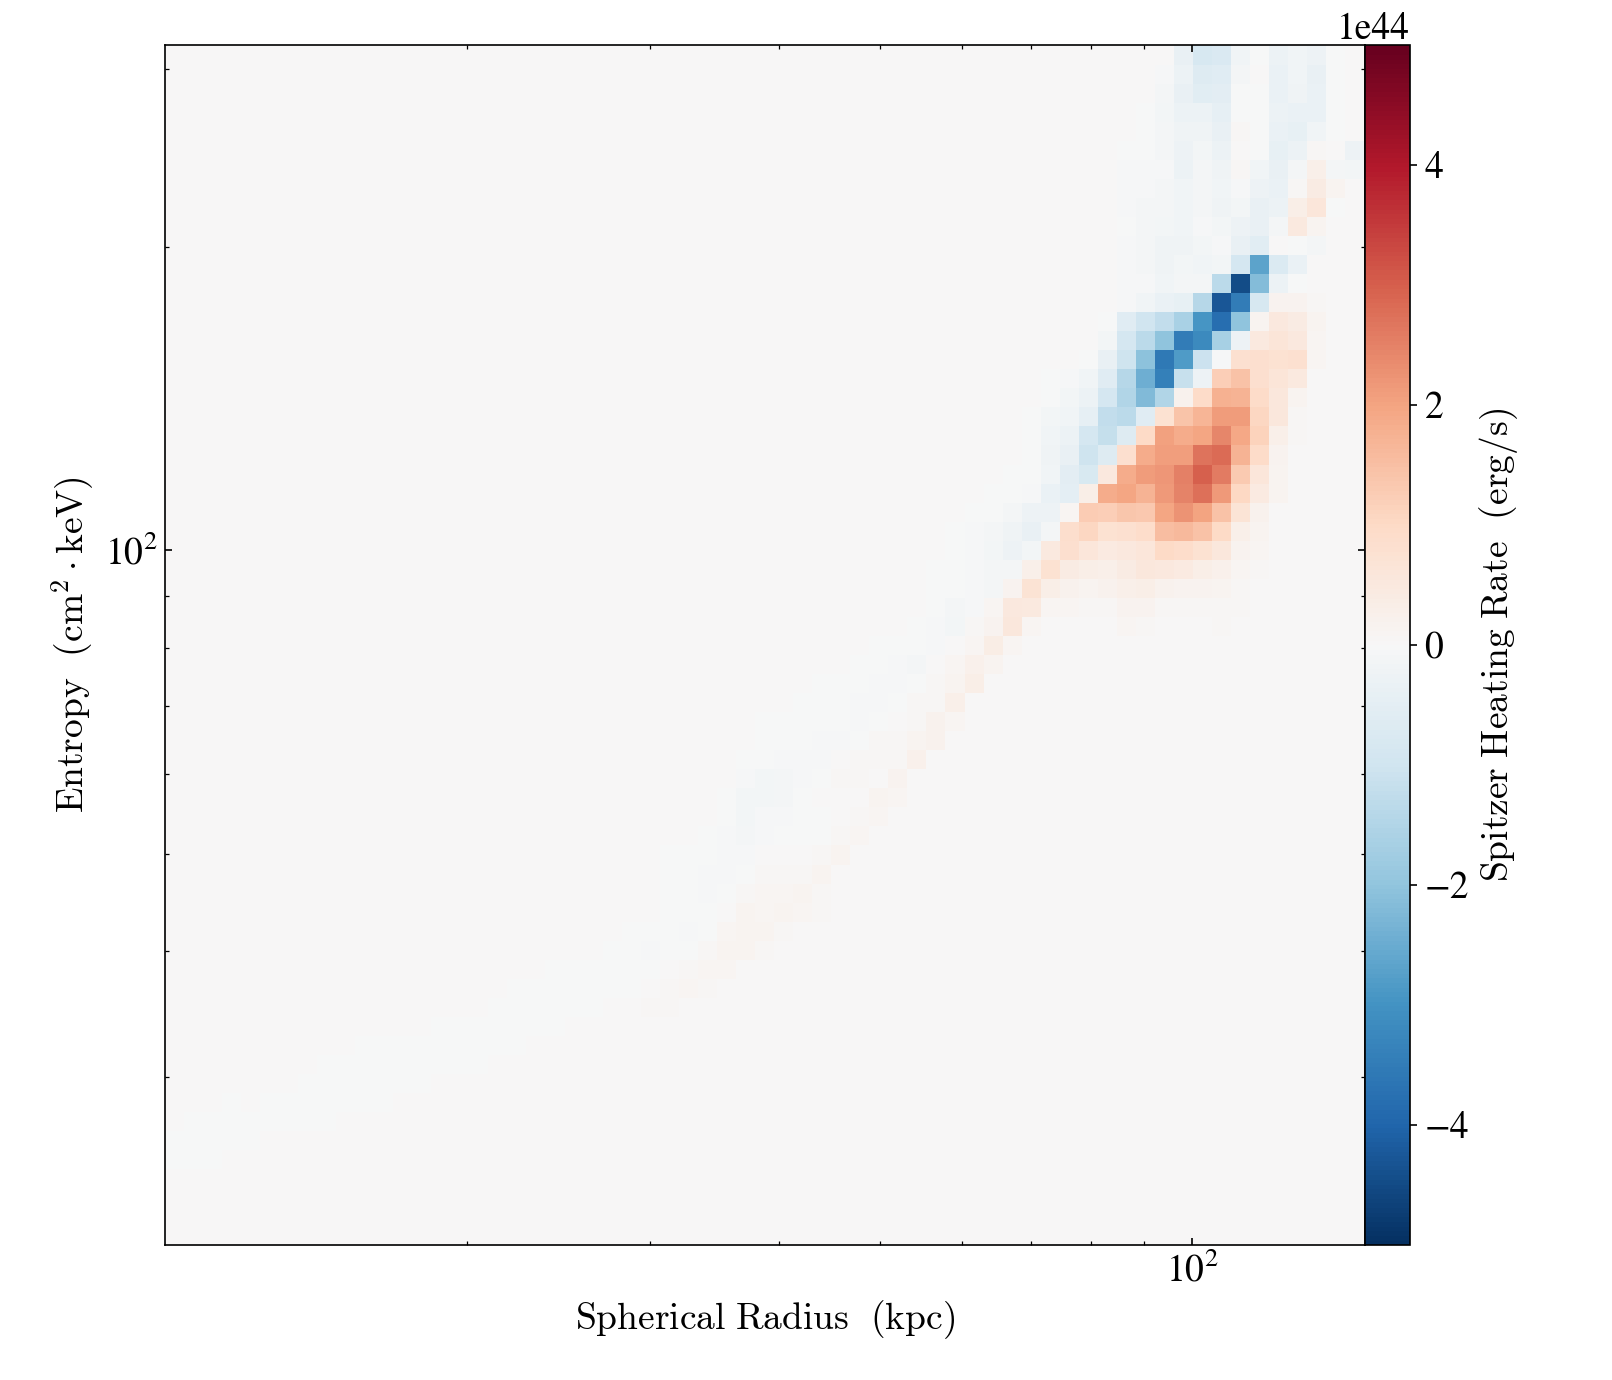
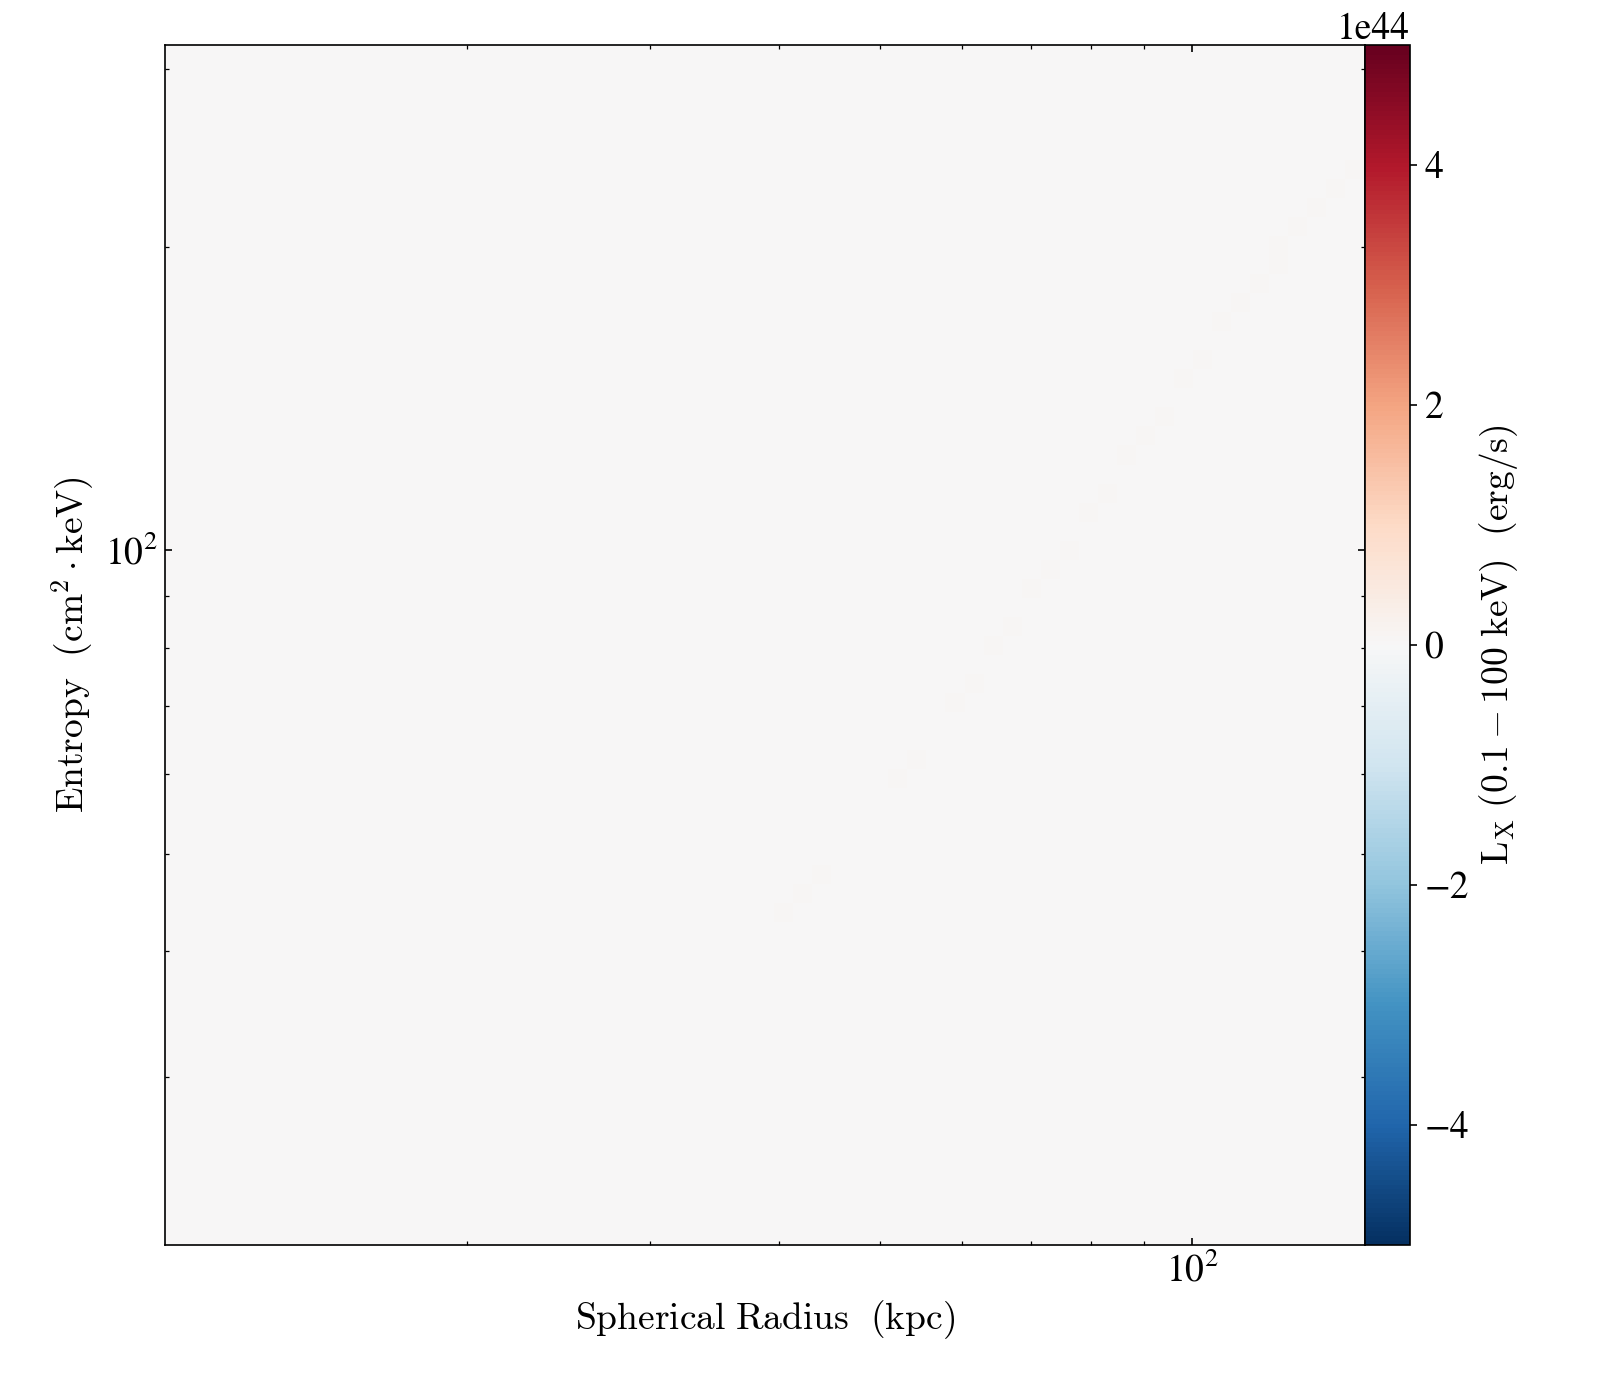
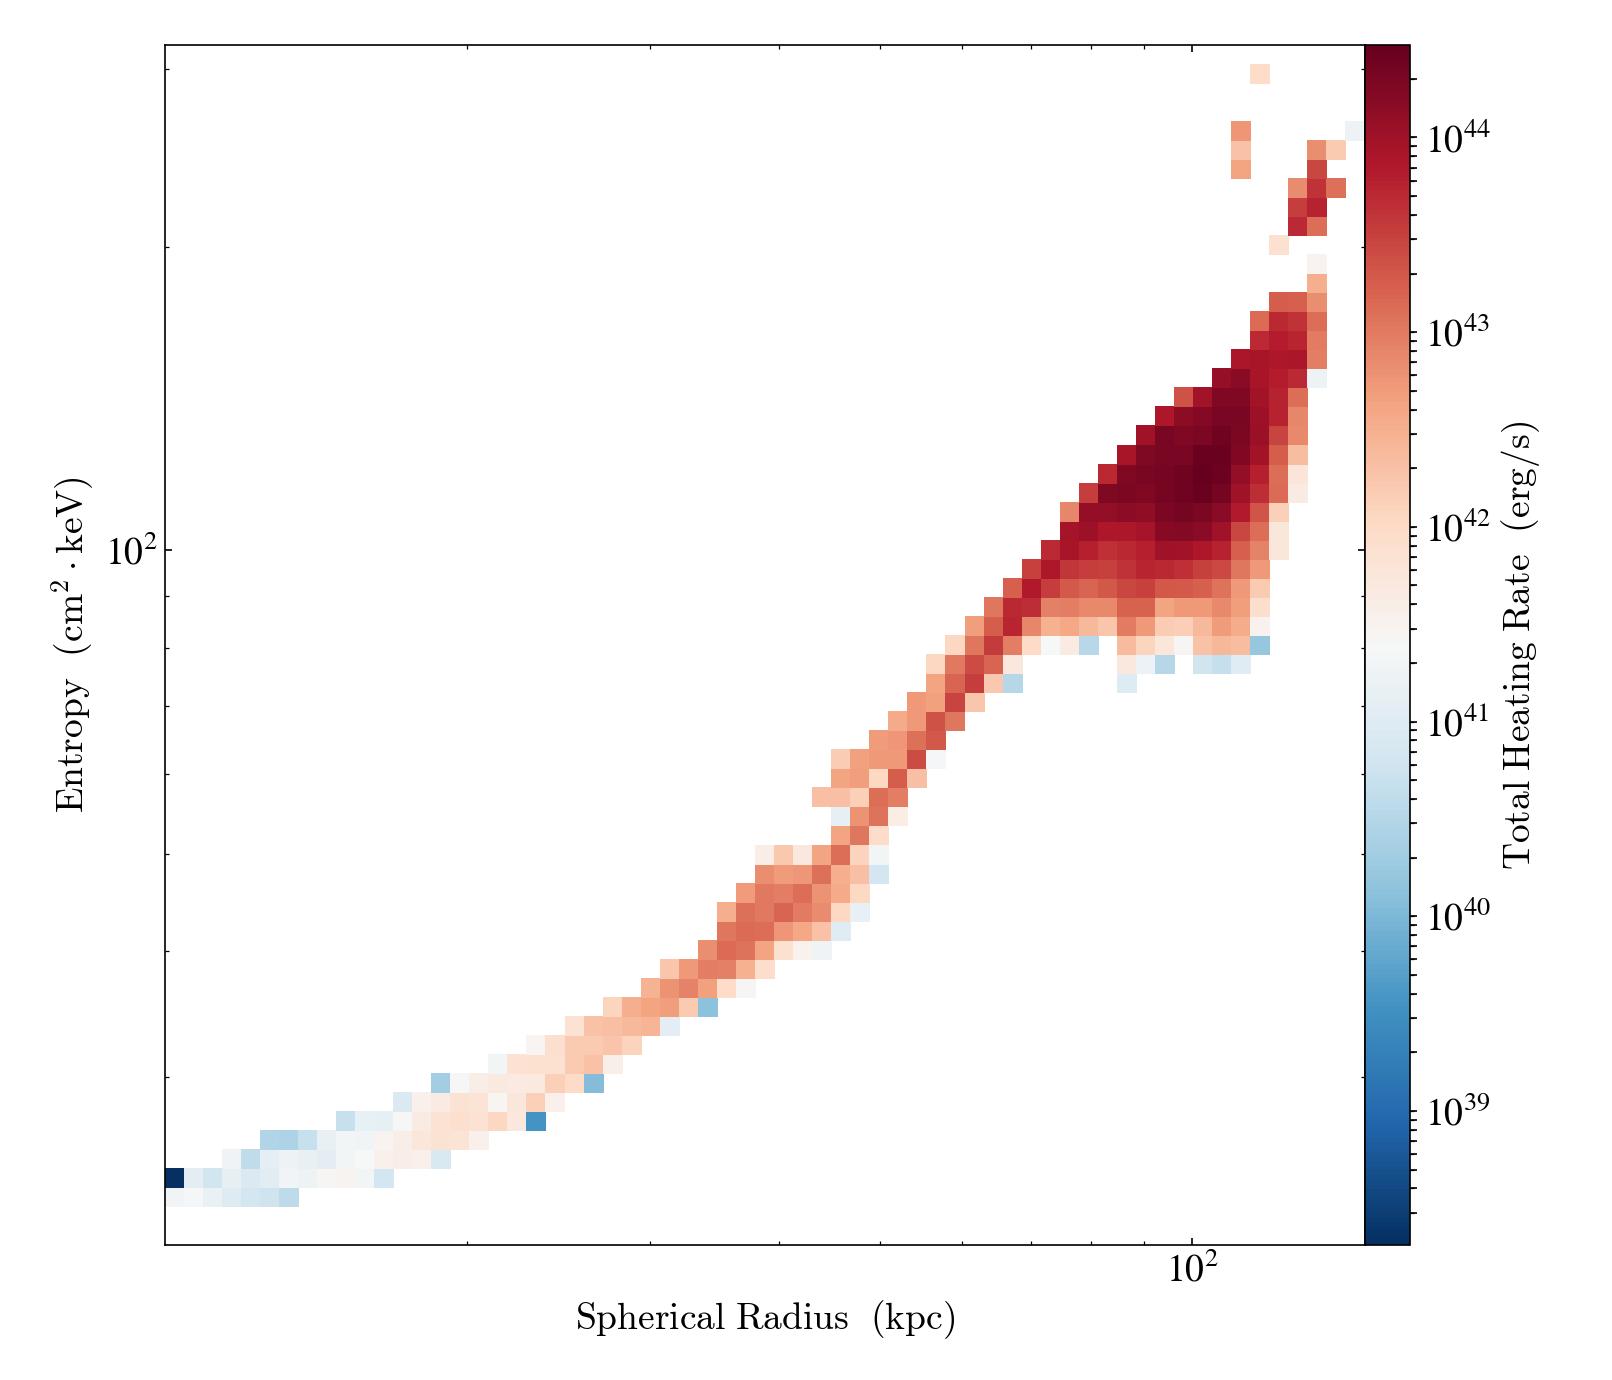
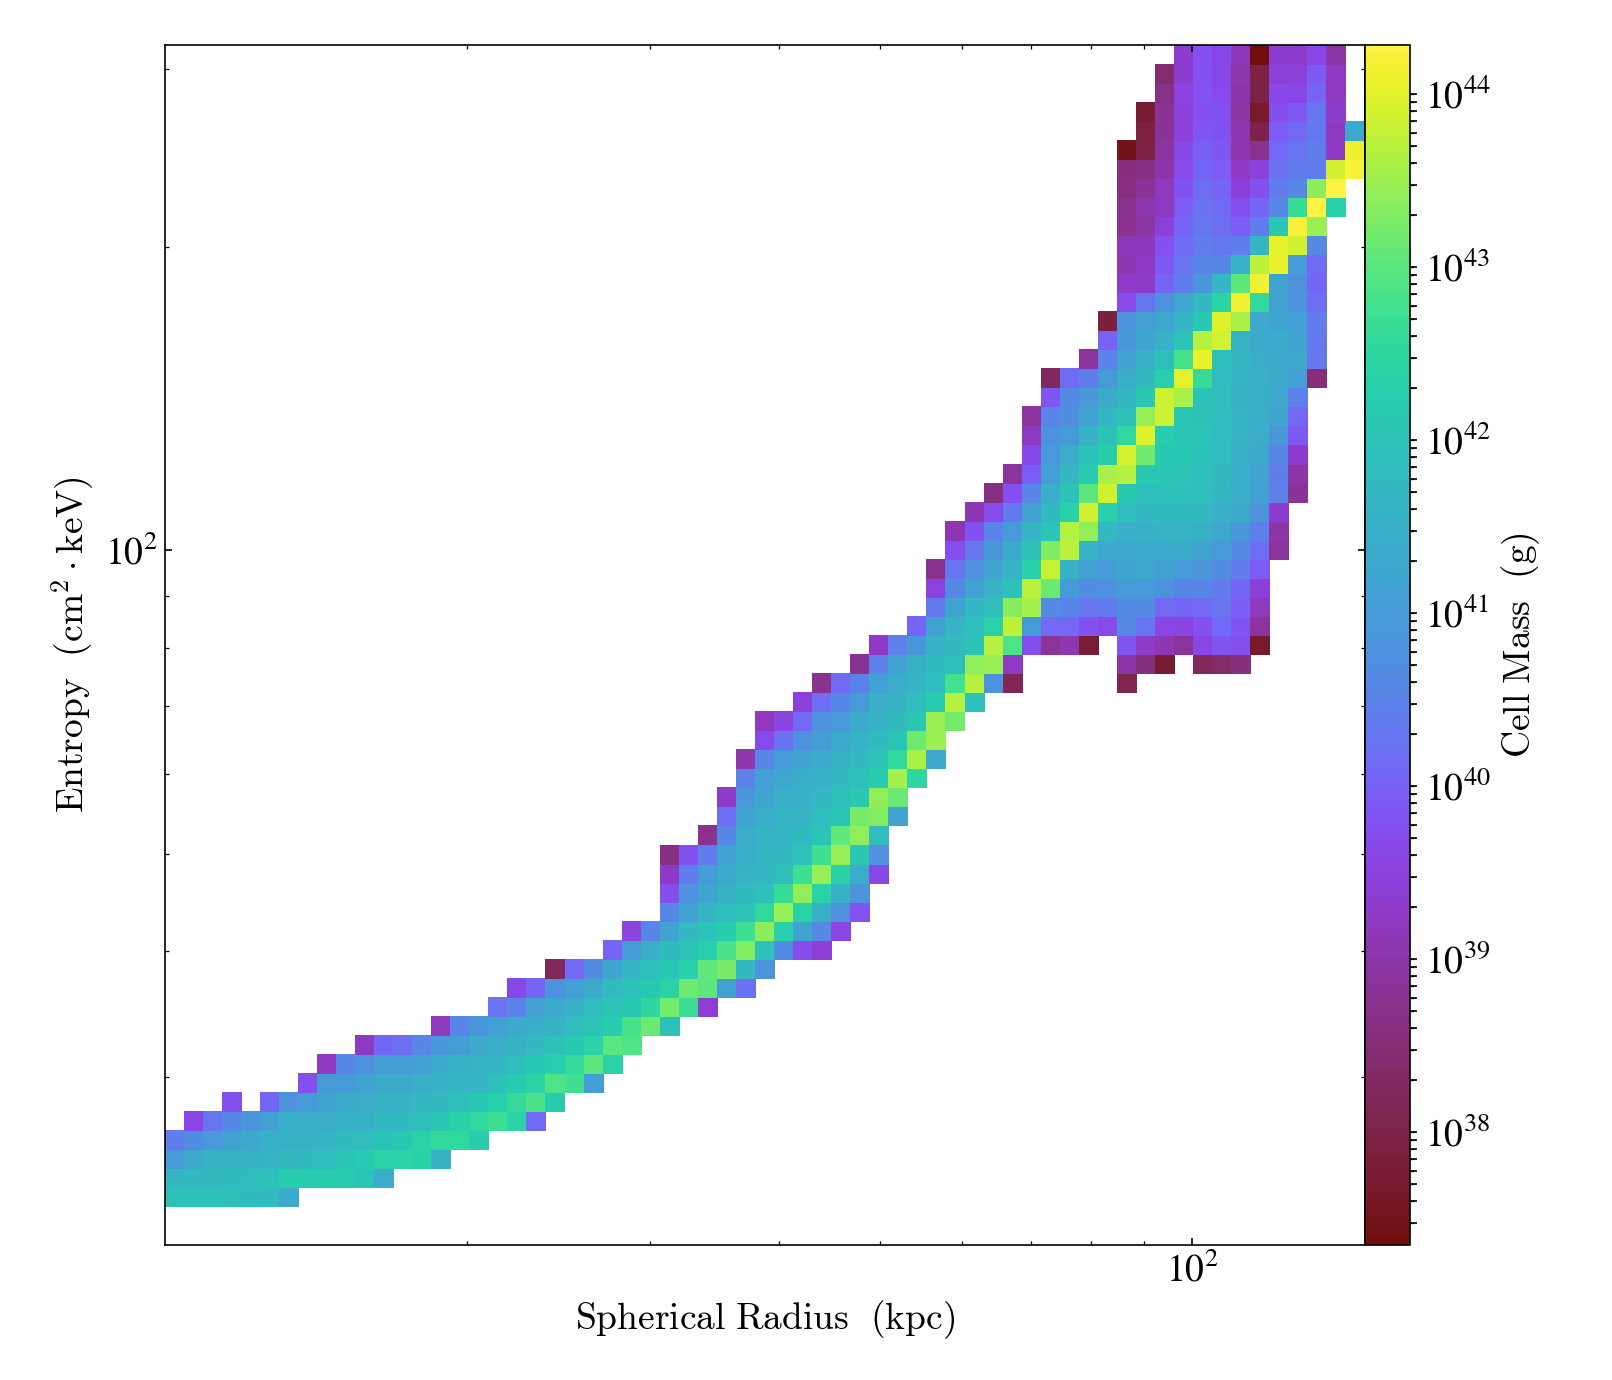

In [7]:
pp = yt.PhasePlot.from_profile(prof)
pp.annotate_text(1.5, 200, '%.0f Myr' % ds.current_time.in_units('Myr'))
pp.set_unit('spherical_radius', 'kpc')
pp.set_cmap('spitzer_heating_rate', 'RdBu_r')
pp.set_cmap('total_heating_rate', 'RdBu_r')
pp.set_cmap('xray_luminosity_0.1_100_keV', 'RdBu_r')
pp.set_log('spitzer_heating_rate', False)
pp.set_zlim('spitzer_heating_rate', -5E44, 5E44)
pp.set_log('xray_luminosity_0.1_100_keV', False)
pp.set_zlim('xray_luminosity_0.1_100_keV', -5E44, 5E44)


/home/ychen/src/yt-git/yt/visualization/plot_container.py:118: RuntimeWarning: invalid value encountered in log10
  expA = np.floor(np.log10(vmin))


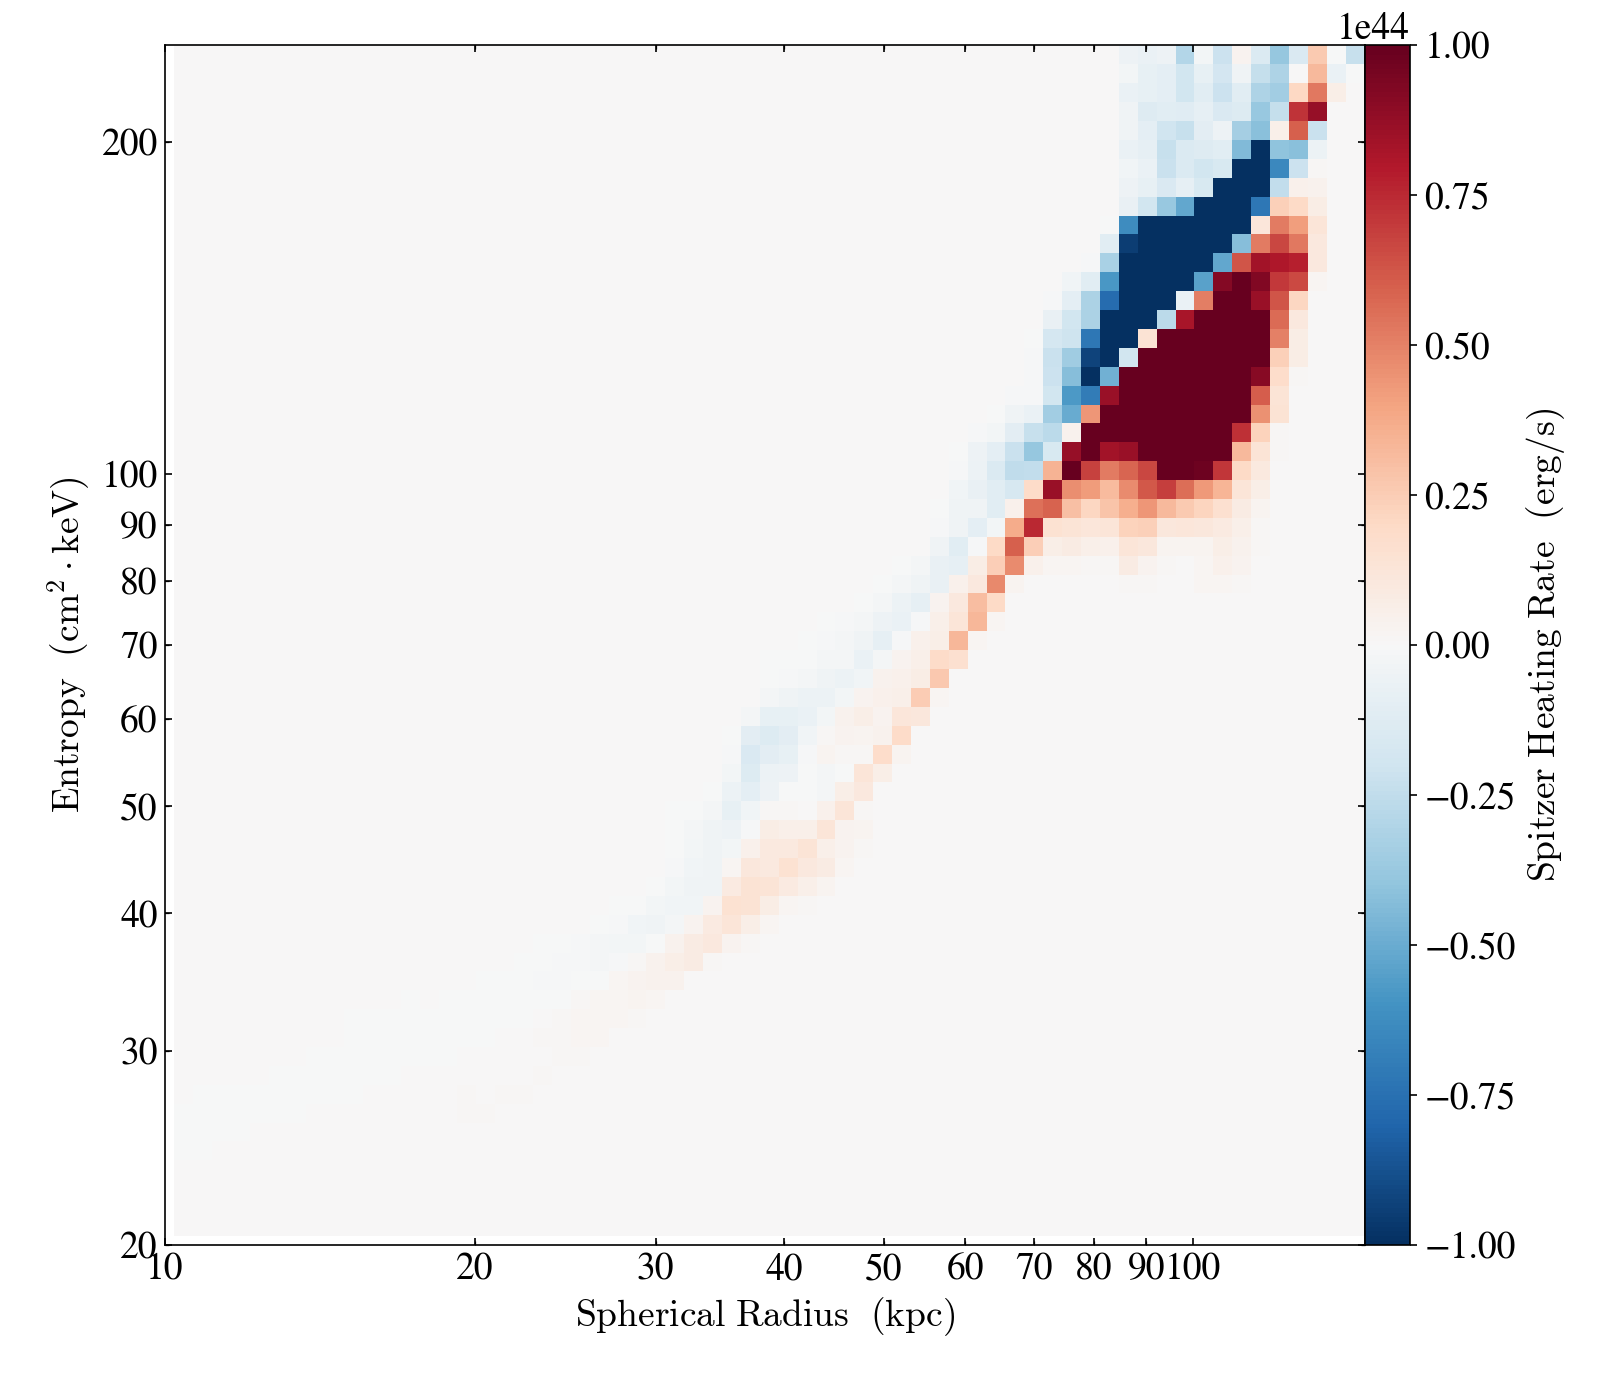

In [31]:
from yt.visualization.plot_container import FieldTransform
from yt.visualization.tick_locators import LogLocator

linthresh = 1E43

symlog_transform = FieldTransform('symlog', None, LogLocator()) 
pp._field_transform['spitzer_heating_rate'] = symlog_transform
pp._field_transform['spitzer_heating_rate'].func = linthresh
pp._setup_plots()
print(pp._field_transform['spitzer_heating_rate'])
pp.set_zlim('spitzer_heating_rate', -1E44, 1E44)
plot2 = pp['spitzer_heating_rate']
entropy_ticks = [20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
plot2.axes.set_yticks(entropy_ticks)
plot2.axes.set_yticklabels(entropy_ticks)
r_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plot2.axes.set_xticks(r_ticks)
plot2.axes.set_xticklabels(r_ticks)
plot2

In [70]:
keV = yt.units.keV
cm = yt.units.cm
kappa = 1*(keV**(5/2)*cm**3)
kappa.convert_to_base()

1.0274860530720377e-22 cm**8*g**(5/2)/s**5

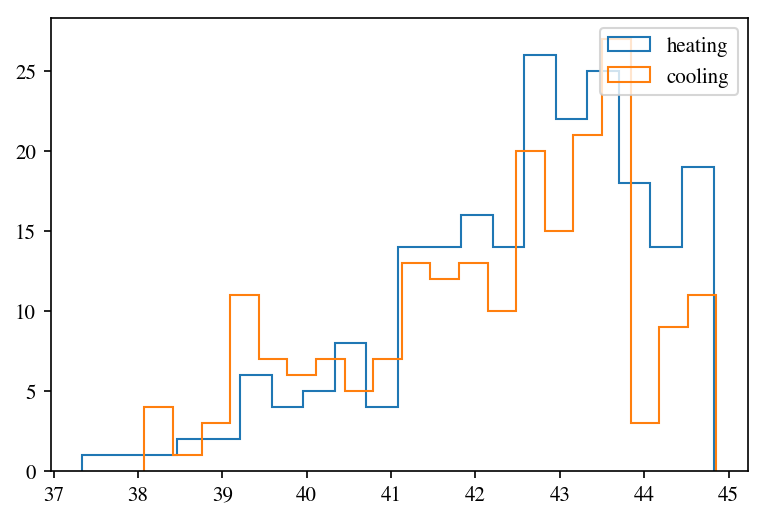

In [35]:
heating_rate = prof['spitzer_heating_rate'].flatten()
null = plt.hist(np.log10(heating_rate[heating_rate>0]), bins=20, histtype='step', label='heating')
null = plt.hist(np.log10(-heating_rate[heating_rate<0]), bins=20, histtype='step', label='cooling')
plt.legend()